# Computación Bio-inspirada. Bloque I: Optimización y búsqueda. 
# 9. Problema de máxima diversidad

Santiago Méndez García (s.mendezgarcia@um.es), Domingo Méndez García (domingo.mendezg@um.es)

Computación Bio-inspirada. Máster en Inteligencia Artificial. Universidad de Murcia. Curso 2024/2025.

## 1. Objetivos y metodología

Implementar en Python un algoritmo evolutivo para el problema de máxima diversidad, tal y como se define en https://grafo.etsii.urjc.es/optsicom/mdp.html. Comparar las siguientes versiones del algoritmo para el manejo de las restricciones:

– **AE1: External feasibility first** (Tema 2, pág. 78). Dado que solo hay una restricción, las versiones max y sum de feasibility first externo descritas en el Tema 2 de la asignatura son equivalentes. El problema es de maximización, por lo que se transformará a un problema de minimización. La función objetivo resultante es la siguiente:

$\min F(x) = \begin{cases} 
-\sum\limits_{i=1}^{n-1} \sum\limits_{j=i+1}^{n} d_{ij} x_i x_j & \text{si } \sum\limits_{i=1}^n x_i = 0 \\
\left | \sum\limits_{i=1}^n x_i - m \right | & \text{en otro caso}
\end{cases}$

– **AE2: Algoritmo de reparo** (Tema 2, pág. 76).

– **AE3 (añadido): Algoritmo con representación permutacional**: Se aprovecha la representación permutacional para que todos los individuos sean factibles. Cada individuo se representa por una permutación $[p_1, ..., p_n]$. Se seleccionan los primeros $m$ individuos de la permutación ($x_{p_i}=1 \, \forall i \le m$).

Para las comparaciones, generar aleatoriamente 3 problemas de test con las siguientes características:

– **Problema de test 1**: $ n = 100, m = 10, K = 1, s_{ij} ∈ [0, 10]$.

– **Problema de test 2**: $ n = 150, m = 15, K = 1, s_{ij} ∈ [0, 10]$.

– **Problema de test 3**: $ n = 200, m = 20, K = 1, s_{ij} ∈ [0, 10]$.

– **Problema de test 4 (adicional)**: $n = 200, m=20, K=7, s_{ij} \in [0, 10]$.

Se realizará ajuste de parámetros con una **grid search** configurada de la
siguiente forma: 

- grid search de 10x10, 3 repeticiones, probabilidad de cruce en el intervalo (0.0, 1.0], y probabilidad de mutación en el intervalo (0.0, 0.3], 10000 evaluaciones de la función objetivo.

Una vez identificados los valores de los parámetros, se realizarán **10 runs** con esos parámetros y diferentes semillas, con 300000 evaluaciones en los proyectos 1 a 8, y 10000 evaluaciones en los proyectos 9 y 10.

- Se reportará media, máximo, mínimo y desviación estándar para cada problema y algoritmo.

- Se realizará un ranking wins-losses de los resultados medios y de las diferencias estadísticamente significativas (Wilcoxon rank-sum test).

- Se entregaun documento Jupyter Notebook en Python con el código, comentarios, resultados, visualización gráfica de la evolución de los algoritmos (las 10 runs sobre el mismo gráfico), análisis y discusión de resultados y conclusiones.

### Requerimientos

A continuación se importan las librerías de _Python_ necesarias, se establece la semilla de _Numpy_ para la reproducibilidad y se definen la ruta del directorio donde se guardarán los resultados y algunas variables que se pueden utilizar para hacer pruebas de menor tamaño o utilizar los resultados ya guardados.

In [1]:
import numpy as np
import heapq 
from tqdm import tqdm
import matplotlib.pyplot as plt
import landscapes.single_objective as lso
from scipy.spatial import distance_matrix
import os
import pandas as pd
from scipy.stats import wilcoxon, mannwhitneyu
from statistics import mean

profiling = False # Poner a True para hacer profiling
results_dir = 'cbio_p9_results' if not profiling else 'cbio_p9_results_profiling' # Directorio de resultados
done = False # os.path.isdir(results_dir) # Poner a False para ejecutar las pruebas
np.random.seed(0)   # Establecer semilla

## 2. El problema de la máxima diversidad

El problema de la máxima diversidad consiste en escoger un subconjunto de $m$ puntos de una nube de $n$ puntos (es decir, un conjunto de puntos con una distancia entre ellos) de forma que se maximice la suma de las distancias entre cada par de puntos del subconjunto elegido. Consideraremos una nube de $n$ puntos  $\{s_i\}_{i=1}^n \subset [L, U]^K$ con la distancia euclídea: 

$$d_{ij} = d(s_i, s_j) = \sqrt{\sum\limits_{k=1}^K (s_{ik}-s_{jk})^2}$$

El problema se puede formular como un problema de optimización cuadrático con variables binarias:

$$\begin{align*}\text{Maximizar } & \sum\limits_{i=1}^{n-1} \sum\limits_{j=i+1}^{n} d_{ij} x_i x_j \\ \text{Sujeto a } & \sum\limits_{i=1}^n x_i = m, \\ & x_i \in \{0, 1\} \quad \forall i=1, ..., n \end{align*}$$

### 2.1. Definición del problema de optimización con restricciones (Máxima diversidad)
- $n$: Número de instancias del dataset (puntos de la nube de puntos).
- $k$: Dimensionalidad de la nube de puntos.
- $L$: Límite inferior de espacio muestral del dataset. 
- $U$: Límite superior de espacio muestral del dataset. Los puntos del dataset serán $s_i \in [L, U]^k \quad \forall i = 1, ..., n$.
- $f$: Función objetivo (máxima diversidad).
- $maxf$:  Máximo (aproximado) de la función $f$, en este caso 0.

Hemos implementado una clase _diversity_problem_ que representa un problema de máxima diversidad.

En cuanto a la función objetivo, hemos utilizado la expresión matricial equivalente 

$$-\sum\limits_{i=1}^{n-1} \sum\limits_{j=i+1}^{n} d_{ij} x_i x_j = - x D x^T$$

con la matriz $D = (a_{ij})_{n \times n}$ la parte triangular superior de la matriz de distancias asociada a la nube de puntos, es decir, la matriz dada por 

$$ a_{ij} = \begin{cases} d_{ij} & \text{si } i<j \\ 0 & \text{en otro caso} \end{cases} \quad \forall i, j=1, ..., n.$$ 

Esto permite precalcular la matriz $D$ y hacer la evaluación de los individuos de forma eficiente mediante operaciones matriciales con _Numpy_.

In [2]:
# Problema de máxima diversidad

def diversity_obj(x, d):
    """
    Función objetivo del problema de máxima diversidad.
    x: representación binaria de un individuo. 
    d: matriz de distancias del dataset.
    """
    return -(x.T @ d @ x) # Cambiamos el signo para transformar el problema en uno de minimización

def maxDiversity_constraints(x, m):
    return np.array([np.abs(np.sum(x)-m)])

class diversity_problem:
    def __init__(self, n, m, k=1, L=0, U=10):
        self.n = n
        self.m = m
        self.k = k
        self.L = L
        self.U = U
        self.X = np.random.uniform(L, U, (n, k))     # Dataset de n puntos en [L, U]
        #if k==1:
        #    self.X = np.sort(self.X, axis=0)        # Ordena los puntos de menor a mayor
        
        self.d = np.triu(distance_matrix(self.X, self.X))   # Matriz de distancias de los puntos del dataset (n x n)
                                                            # Extraemos la parte triangular superior para evitar sumar distancias repetidas
                                                            
        self.f = lambda x: diversity_obj(x, self.d)  # Función objetivo
        self.g = lambda x: maxDiversity_constraints(x, m) # Restricciones
        self.maxf = 0

### 2.2. Definición de los problemas de test

Se generan aleatoriamente 3 problemas de test con las siguientes características:

– **Problema de test 1**: $ n = 100, m = 10, K = 1, s_{ij} ∈ [0, 10]$.

– **Problema de test 2**: $ n = 150, m = 15, K = 1, s_{ij} ∈ [0, 10]$.

– **Problema de test 3**: $ n = 200, m = 20, K = 1, s_{ij} ∈ [0, 10]$.

– **Problema de test 4 (adicional)**: $n = 200, m=20, K=7, s_{ij} \in [0, 10]$.

Cada $s_{ij}$ se toma muestreando una distribución uniforme en el intervalo $[0, 10]$. A continuación podemos ver una representación gráfica de los problemas 1, 2 y 3. El problema 4 se ha añadido porque para $K=1$ el problema tiene una solución trivial, mientras que con dimensión alta el problema es más complejo. Así, podemos comparar los algoritmos en un problema más complejo además de en problemas sencillos de prueba de distinto tamaño.

In [3]:
problems = [diversity_problem(100, 10), diversity_problem(150, 15), diversity_problem(200, 20), diversity_problem(200, 20, 7)]

### 2.3. Solución del problema para dimensión $K=1$

Si $K=1$ y suponemos $s_1 \le \cdots \le s_n$, se tiene que existe una solución óptima al problema de la forma:

$$x_i = \begin{cases}
    1 & \text{, si } i \le p \lor i \ge n-m+p+1 \\
    0 & \text{, en otro caso}
\end{cases}$$

para algún $p$ con $ \lfloor m/2 \rfloor \le p \le \lceil m/2 \rceil$. Por tanto, a lo sumo hay que comprobar 2 posibles soluciones.

In [4]:
# Obtiene la solución de cada problema
def solve(problem):
    perm = np.argsort(problem.X[:,0]) # Sort X and get the permutation
    perm = np.argsort(perm) # invert permutation
    sol = np.zeros(problem.n, dtype=int)
    minf = 0
    for i in range(problem.m//2, (problem.m+1)//2+1):
        x = np.zeros(problem.n, dtype=int)
        x[:i] = 1
        x[problem.n-problem.m+i:] = 1
        x = x[perm] # Apply inverse permutation to x
        f = problem.f(x)
        if f < minf:
            minf = f
            sol = x
    return minf, sol

solutions = [solve(problem) for problem in problems if problem.k == 1]

A continuación se muestra la solución de los problemas 1, 2 y 3 (con dimensión $k = 1$).

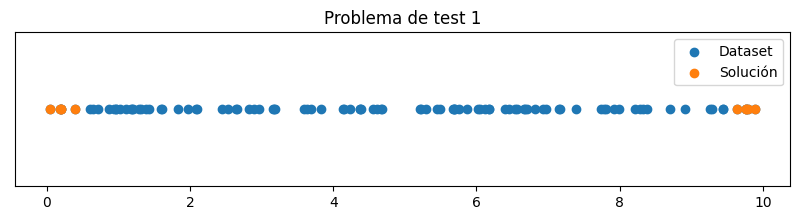

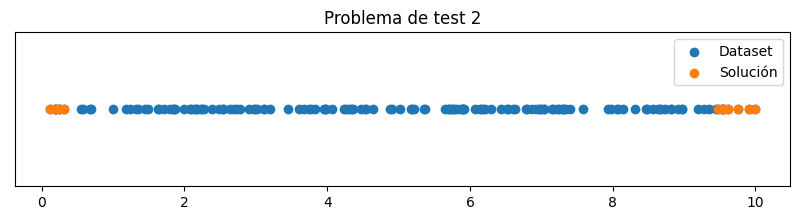

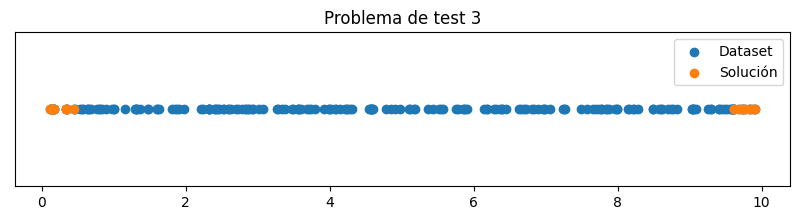

In [5]:
for i in range(len(problems)):
    if problems[i].k == 1:
        plt.figure(figsize=(10, 2))
        plt.title(f"Problema de test {i+1}")
        plt.scatter(problems[i].X, np.zeros(problems[i].n))
        plt.scatter(problems[i].X[solutions[i][1]==1], np.zeros(np.sum(solutions[i][1])))
        plt.legend(['Dataset', 'Solución'])
        plt.yticks([])
        plt.show()


## 3. Algoritmos evolutivos utilizados

En todos los casos transformaremos el problema a un problema de minimización y aplicaremos algoritmos evolutivos. Además, todos los algoritmos comparten los siguientes elementos:

- Estrategia de reemplazo generacional $\mu + \lambda$ con $\mu = \lambda = N$ (tamaño de la población). Por tanto, todos los algoritmos serán elitistas.
- Selección por torneo binario.

Utilizaremos los siguientes algoritmos, con los siguientes componentes:

**AE1: External feasibility first** (Tema 2, pág. 78):

- Representación binaria: Cada individuo se representa por $x = (x_i)_{i=1}^n \in \{0, 1\}^n$.
- Manejo de restricciones con enfoque feasibility first descrito anteriormente. El problema se transforma a un problema de minimización y la función objetivo se transforma a:
  $$\min F(x) = \begin{cases} -\sum\limits_{i=1}^{n-1} \sum\limits_{j=i+1}^{n} d_{ij} x_i x_j & \text{si } \sum\limits_{i=1}^n x_i = 0 \\\left | \sum\limits_{i=1}^n x_i - m \right | &\text{en otro caso} \end{cases}$$
- Selección por torneo binario. Muestreo estocástico con reemplazamiento.
- Cruce simple.
- Mutación bit-flip.
- Estrategia de reemplazo generacional $\mu + \lambda$ con $\mu = \lambda = N$.

El espacio de búsqueda es $\{0, 1\}^n$, con cardinal $2^n$. Las soluciones infactibles forman parte del espacio de búsqueda, aunque se penaliza su función de evaluación.

**AE2: Algoritmo de reparo** (Tema 2, pág. 76).

- Representación binaria.
- Manejo de restricciones con algoritmo de reparo. Las soluciones no factibles se reparan con el siguiente algoritmo de reparo:

    IF $\sum\limits_{i=1}^n x_i < m$ THEN seleccionar aleatoriamente $p = 1, ..., n$ tal que $x_p = 0$ y asignar $x_p \leftarrow 1$

    ELSE IF $\sum\limits_{i=1}^n x_i > m$ THEN seleccionar aleatoriamente $p = 1, ..., n$ tal que $x_p = 1$ y asignar $x_p \leftarrow 0$

- Selección por torneo binario. Muestreo estocástico con reemplazamiento.
- Cruce simple.
- Mutación bit-flip.
- Estrategia de reemplazo generacional $\mu + \lambda$ con $\mu = \lambda = N$.

Al incorporar el reparo de individuos no factibles, el espacio de búsqueda se reduce al conjunto de soluciones factibles, con cardinal ${n} \choose {m}$.

**AE3 (añadido): Algoritmo con representación permutacional**: Se aprovecha la representación permutacional para que todos los individuos sean factibles. 

- Representación permutacional: Cada individuo se representa por una permutación $[p_1, ..., p_n]$. Se seleccionan los primeros $m$ individuos de la permutación ($x_{p_i}=1 \, \forall i \le m$).
- Manejo de restricciones: no es necesario, ya que el espacio de búsqueda solo contiene individuos factibles.
- Selección por torneo binario. Muestreo estocástico con reemplazamiento.
- Cruce PMX modificado: el intervalo entre puntos de corte siempre estará entre los $m$ primeros índices de la permutación. Esto favorece el cambio de fenotipo en la mutación.
- Mutación por intercambio recíproco modificado: uno de los puntos intercambiados es de los $m$ primeros. Esto favorece el cambio de fenotipo en la mutación.
- Estrategia de reemplazo generacional $\mu + \lambda$ con $\mu = \lambda = N$.
- 
Al utilizar la representación permutacional, el espacio de búsqueda tiene cardinal $n!$. La representación es muy redundante: hay $m!(n-m)!$ posibles genotipos por cada fenotipo (y cada fenotipo corresponde a una solución factible).

### Parámetros del algoritmo evolutivo
- $G$: Número de generaciones. El número de evaluaciones será $2GN$.
- $N$: Tamaño de la población.
- $random\_state$: Semilla para reproducibilidad.
- $prob$: Probabilidades.
  - $p\_c$: Probabilidad de cruce.
  - $p\_m$: Probabilidades de mutación.


## 4. Implementación de los algoritmos evolutivos para el problema de máxima diversidad

### Transformación del problema con restricciones en un problema sin restricciones – versión max

En este caso, como solo hay una restricción, las versiones max y sum de la transformación a un problema sin restricciones (external feasibility first) son equivalentes.

In [6]:
def transformed_problem(x,f,g,maxf):
    maxg = max(g(x))
    if maxg <= 0.0:
        return f(x)
    else:
        return maxf+maxg

### Definición de individuo

In [7]:
class Individuo:
    def __init__(self,n):
        self.x = np.zeros(n, dtype=int)
        self.f = 0.0
    def __lt__(self, ind):
        return self.f < ind.f

### Inicialización de la población

In [8]:
def InitializePopulation(P):
    for I in P:
        I.x[:] = np.random.randint(2, size=len(I.x))

def InitializePopulationPermutation(P):
    for I in P:
        I.x[:] = np.random.permutation(len(I.x))

### Funciones de evaluación

In [9]:
def evaluate_EFF(I,f, g, maxf):           
    I.f = transformed_problem(I.x,f,g,maxf)

def perm2bin(x, m):
    """
    Devuelve la representación binaria de un individuo representado mediante una permutación.
    x: permutación.
    m: los primeros m elementos de la permutación se ponen a 1's.
    """
    n = len(x)
    y = np.zeros(n, dtype=int)
    y[x[:m]] = 1
    return y

def evaluate_permutation(I, problem):
    I.f = problem.f(perm2bin(I.x, problem.m))

### Copia de individuo

In [10]:
def copia(I1, I2):
    """
        Copia I2 en I1
    """
    np.copyto(I1.x, I2.x)
    I1.f = I2.f

### Selección

Solo utilizaremos el operador de selección por torneo binario.

In [11]:
def binary_tournament_selection(P):
    return min(np.random.choice(P,2,replace=False))

### Cruce

- Cruce simple: para representación binaria.
- Cruce PMX: para representación permutacional.

In [12]:
def uniform_crossover(x1,x2):
    for l in range(x1.size):
        if np.random.random()<=0.5:
            x1[l], x2[l] = x2[l], x1[l] 
            
def simple_crossover(x1,x2):
    pos = np.random.randint(x1.size)
    x1[:], x2[:] = np.hstack((x1[:pos],x2[pos:])), np.hstack((x2[:pos],x1[pos:]))
        
def crossover(x1,x2,prob_cross, problem): # Cruce simple
    if np.random.random()<=prob_cross:
        simple_crossover(x1,x2)

aux_mem = np.arange(10) # Memoria auxiliar para PMX para evitar reservar memoria en cada llamada

def modified_pmx(x1, x2, m):
    """
    Cruce PMX modificado para que el intervalo entre los puntos de corte esté entre los primeros m elementos."""
    global aux_mem
    if aux_mem.size != x1.size:
        aux_mem = np.arange(x1.size, dtype=int)
    else:
        for i in range(x1.size):
            aux_mem[i] = i
    pos1 = np.random.randint(m)
    pos2 = np.random.randint(m)
    if pos1 > pos2:
        pos1, pos2 = pos2, pos1
    pos2 += 1
    for i in range(pos1, pos2):
        aux_mem[x1[i]] = x2[i]
        aux_mem[x2[i]] = x1[i]
    x1[pos1:pos2], x2[pos1:pos2] = x2[pos1:pos2], x1[pos1:pos2]
    x1[:pos1] = aux_mem[x1[:pos1]]
    x2[:pos1] = aux_mem[x2[:pos1]]
    x1[pos2:] = aux_mem[x1[pos2:]]
    x2[pos2:] = aux_mem[x2[pos2:]]

def perm_crossover(x1, x2, prob_cross, problem):
    if np.random.random()<=prob_cross:
        modified_pmx(x1,x2, problem.m)

### Mutación

Definimos los siguientes operadores de mutación:

- Mutación bit-flip: para la representación binaria.

- Mutación por intercambio recíproco: para la representación permutacional.

In [13]:
def bitflip_mutation(x,p_m):
    for l in range(x.size):
        if np.random.random()<=p_m:
            x[l] = 1-x[l]

def mutation(x,prob_mutation, problem):
    bitflip_mutation(x, prob_mutation)

def exchange_mutation(x, prob_mutation, m):
    """
    Intercambia dos elementos de la representación permutacional. Uno de ellos es uno de los primeros m elementos.
    """
    if np.random.random()<=prob_mutation:
        pos1 = np.random.randint(m)
        pos2 = np.random.randint(x.size)
        x[pos1], x[pos2] = x[pos2], x[pos1]

def perm_mutation(x, prob_mutation, problem):
    exchange_mutation(x, prob_mutation, problem.m)

### Algoritmo de reparo

El algoritmo AE2 maneja las restricciones reparando los individuos infactibles. El reparo se incorpora en la función de evaluación, antes de calcular la función objetivo del individuo.

In [14]:
def maxDiversity_repair(x, m):
    """
    Reparación de la solución x para cumplir las restricciones del problema de máxima diversidad. Se realiza inplace.
    x: representación binaria de un individuo. 
    m: número de elementos a seleccionar.
    """
    v = np.sum(x)
    if v != m:
        if v > m:
            # Eliminar elemento
            x[np.random.choice(np.where(x == 1)[0], size=v-m, replace=False)] = 0
        else:
            # Añadir un elemento
            x[np.random.choice(np.where(x == 0)[0], size=m-v, replace=False)] = 1

def repair_and_evaluate(I, m, f):
    """
    Repara el individuo I si no cumple las restricciones y evalúa su función objetivo.
    """
    maxDiversity_repair(I.x, m)
    I.f = f(I.x)

### Progreso del algoritmo

In [15]:
def IniciaProgreso(P,G, feasibility, problem):
    best_outputs_f = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    best_outputs_g = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    progression_bar = tqdm()
    ActualizaProgreso(P,0,best_outputs_f,best_outputs_g,progression_bar, feasibility, problem)    
    return best_outputs_f,best_outputs_g,progression_bar
    
def ActualizaProgreso(P,gen,best_outputs_f,best_outputs_g,progression_bar, feasibility, problem):
    best_individuo = min(P)
    best_g = feasibility(best_individuo, problem)
    progression_bar.set_description("Generation: %s Objective: %s Feasibility: %s " % (str(gen), str(best_individuo.f), str(best_g)))
    best_outputs_f[gen] = best_individuo.f # Añadir mejor fitness (para visualización)
    best_outputs_g[gen] = best_g
    progression_bar.update(1)

### Algoritmo evolutivo

La clase _EAOperators_ encapsula los operadores de un algoritmo evolutivo: inicialización de la población, evaluación, selección, cruce, mutación, factibilidad. De esta forma la función EA ejecuta una instancia de algoritmo evolutivo y gracias a un parámetro de tipo _EAOperators_ se pueden ejecutar distintos tipos algoritmos evolutivos (como AE1, AE2 y AE3) con una misma función.

In [16]:
class EAOperators:
    """
    Clase que encapsula los operadores de un algoritmo evolutivo.
    """
    def __init__(self, initialize_population, evaluate, select, cross, mutate, feasibility):
        """
        initialize_population: función de inicialización de la población. initialize_population(P:List[Individuo]).
        evaluate(I:Individuo): función de evaluación de un individuo. evaluate(I:Individuo, problem: diversity_problem).
        select: operador de selección de padres. select(P:List[Individuo]) -> Individuo.
        cross: operador de cruce. cross(x1:np.array, x2:np.array, prob_cross:float, problem_diversity_problem).
        mutate: operador de mutación. mutate(I:Individuo, prob_mutation:float, problem:diversity_problem).
        feasibility: función g que evalúa la factibilidad de un individuo. feasibility(I: Individuo, problem: diversity_problem) -> double.
        """
        self.initialize_population = initialize_population
        self.evaluate = evaluate
        self.select = select
        self.cross = cross
        self.mutate = mutate
        self.feasibility = feasibility

def EA(G,N,prob,problem,ops,random_state):
    """
    Algoritmo evolutivo para el problema de máxima diversidad con representación binaria y manejo de restricciones por External Feasibility First.
    G: número de generaciones.
    N: tamaño de la población.
    ops: operadores del algoritmo evolutivo (EAOperators).
    random_state: semilla para la generación de números aleatorios.
    """
    np.random.seed(random_state)
    
    p_c, p_m = prob
    initialize_population = ops.initialize_population
    evaluate = ops.evaluate
    select = ops.select
    cross = ops.cross
    mutate = ops.mutate

    # Aserciones
    
    assert G >= 1, "El número de evaluaciones debe ser mayor o igual que 1."  
    assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."  
    
    def AssertProbability(p):
        assert p>=0 and p<=1, "La probabilidad debe estar entre 0 y 1."

    AssertProbability(p_c)
    
    AssertProbability(p_m)
    
    # Parámetros del problema
    n = problem.n

    # Crear población inicial con N individuos
    P = [Individuo(n) for _ in range(N)]
    initialize_population(P)
    
    # Evaluar población inicial
    for I in P:
        evaluate(I,problem)
    
    # Crear población auxilar 
    Q = [Individuo(n) for _ in range(2*N)]
    
    # Evoluciona durante G generaciones
    best_outputs_f,best_outputs_g,progression_bar = IniciaProgreso(P,G, feasibility, problem)    
    for gen in range(1,G+1):
        for i in range(N):
            copia(Q[i],P[i])
        i=N
        while i < 2*N:
            copia(Q[i],select(P))
            copia(Q[i+1],select(P))
            cross(Q[i].x,Q[i+1].x,p_c, problem)
            mutate(Q[i].x,p_m, problem)
            mutate(Q[i+1].x,p_m, problem)
            evaluate(Q[i],problem)
            evaluate(Q[i+1],problem)
            i += 2  
        R = heapq.nsmallest(N,Q)
        for i in range(N):
            copia(P[i],R[i])
        ActualizaProgreso(P,gen,best_outputs_f,best_outputs_g,progression_bar, feasibility, problem)
        # print([I.x for I in P])
    best_individuo = min(P)
    return best_outputs_f,best_outputs_g, best_individuo.f, best_individuo.x

def evaluate_AE1(I, problem):
    return evaluate_EFF(I, problem.f, problem.g, problem.maxf)

def evaluate_AE2(I, problem):
    return repair_and_evaluate(I, problem.m, problem.f)

def feasibility(I, problem):
    return max(problem.g(I.x))

def feasibility_perm(I, problem):
    return 0    # Todos los individuos representados con una permutación son factibles

ops_list = [EAOperators(InitializePopulation, evaluate_AE1, binary_tournament_selection, crossover, mutation, feasibility), 
                  EAOperators(InitializePopulation, evaluate_AE2, binary_tournament_selection, crossover, mutation, feasibility), 
                  EAOperators(InitializePopulationPermutation, evaluate_permutation, binary_tournament_selection, perm_crossover, perm_mutation, feasibility_perm)]

## 5. Ejecución de los experimentos

### 5.1. Búsqueda de parámetros mediante Grid Search

Se van a ajustar los siguientes parámetros del EA:
  - $p\_c$ (Probabilidad de cruce)
  - $p\_m$ (Probabilidad de mutación)

La búsqueda de parámetros se hará mediante grid search. Para los 3 algoritmos AE1, AE2 y AE3 y los 4 problemas de test utilizaremos el mismo grid de parámetros de tamaño $10 \times 10$:
  - $p\_c$: 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9. Hemos tomado valores en $(0, 1]$, con más valores alrededor de $0.8$.
  - $p\_m$: 1e-4,5e-4,1e-3,5e-3,0.01,0.05,0.1, 0.15, 0.2, 0.3. Hemos tomado valores en $(0, 0.3]$ probando distintas escalas.

In [17]:
options = {'p_c': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
           'p_m': [1e-4,5e-4,1e-3,5e-3,0.01,0.05,0.1, 0.15, 0.2, 0.3]} \
        if not profiling else \
            {'p_c': [0.7, 0.8], 'p_m': [0.01, 0.05]}

In [18]:
def GridSearchEA(options, n_repeat, G, N, problem, ops):    
    best_score = float('inf')
    best_options = None
    for p_c in options['p_c']:
        for p_m in options['p_m']:
            score = np.zeros(n_repeat)
            print("p_c:",p_c," p_m:",p_m)
            for i in range(n_repeat):
                prob = p_c, p_m
                _, _, score[i], _ = EA(G, N, prob, problem, ops, random_state = i)
            scoreMean = score.mean()
            print("Score Mean: ",scoreMean)
            print("")
            if scoreMean < best_score:
                best_score = scoreMean
                best_options = {'p_c': p_c, 'p_m': p_m}
    return best_score, best_options

#### Ejecución del Grid Search

In [19]:
# Crea un directorio para guardar archivos con los resultados
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [20]:
%%time
N = 100
evals = 10000 # Aumentamos el número de evaluaciones (50 generaciones)
G = evals//(2*N) if not profiling else 30

n_repeat = 3


best_scores = []
best_options_list = []

algorithm_names = ['AE1', 'AE2', 'AE3']

if not done:
    for ops, algorithm_name in zip(ops_list, algorithm_names):
        for nproblem, problem in enumerate(problems):
            print("ALGORITMO: ", algorithm_name)
            print("PROBLEMA DE TEST ", nproblem+1)
            print("n: ", problem.n, " m: ", problem.m, " k: ", problem.k, " L: ", problem.L, " U: ", problem.U)

            best_score, best_options = GridSearchEA(options=options,n_repeat=n_repeat,G=G,N=N,problem=problem, ops=ops)

            best_scores.append(best_score)
            best_options_list.append(best_options)
            
            print("BEST:")
            print(best_score)
            print(best_options)

    df = pd.DataFrame(columns=['algorithm', 'problem', 'n', 'm', 'k', 'L', 'U', 'gs_best_score', 'best_options'])
    df['algorithm'] = [algorithm_name for algorithm_name in algorithm_names for _ in range(len(problems))]
    df['problem'] = list(range(1, len(problems)+1)) * len(algorithm_names)
    df['n'] = [problem.n for problem in problems] * len(algorithm_names)
    df['m'] = [problem.m for problem in problems] * len(algorithm_names)
    df['k'] = [problem.k for problem in problems] * len(algorithm_names)
    df['L'] = [problem.L for problem in problems] * len(algorithm_names)
    df['U'] = [problem.U for problem in problems] * len(algorithm_names)
    df['gs_best_score'] = best_scores
    df['best_options'] = best_options_list

    df.to_csv(os.path.join(results_dir, f'cbio_p9_grid_search.csv'), index=False)
else:
    df = pd.read_csv(os.path.join(results_dir, f'cbio_p9_grid_search.csv'))

ALGORITMO:  AE1
PROBLEMA DE TEST  1
n:  100  m:  10  k:  1  L:  0  U:  10
p_c: 0.2  p_m: 0.0001


Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 73.52it/s]  
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 74.31it/s]  
Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 75.93it/s]


Score Mean:  10.333333333333334

p_c: 0.2  p_m: 0.0005


Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 75.82it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 71.35it/s]  
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 74.83it/s]  


Score Mean:  4.666666666666667

p_c: 0.2  p_m: 0.001


Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 72.67it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 74.74it/s]  
Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 71.79it/s]  


Score Mean:  3.0

p_c: 0.2  p_m: 0.005


Generation: 50 Objective: -175.45194998409443 Feasibility: 0 : : 51it [00:01, 46.54it/s]
Generation: 50 Objective: -207.43519307435818 Feasibility: 0 : : 51it [00:00, 52.94it/s]
Generation: 50 Objective: -170.3536929460331 Feasibility: 0 : : 51it [00:01, 50.64it/s] 


Score Mean:  -184.41361200149524

p_c: 0.2  p_m: 0.01


Generation: 50 Objective: -208.4057601667635 Feasibility: 0 : : 51it [00:01, 39.53it/s] 
Generation: 50 Objective: -200.68013754668092 Feasibility: 0 : : 51it [00:01, 48.45it/s]
Generation: 50 Objective: -192.26924735220362 Feasibility: 0 : : 51it [00:00, 52.39it/s]


Score Mean:  -200.45171502188268

p_c: 0.2  p_m: 0.05


Generation: 50 Objective: -200.62141835068206 Feasibility: 0 : : 51it [00:00, 63.76it/s]
Generation: 50 Objective: -147.28448019617946 Feasibility: 0 : : 51it [00:00, 65.45it/s]
Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 63.62it/s]  


Score Mean:  -115.6352995156205

p_c: 0.2  p_m: 0.1


Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 70.35it/s]  
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 68.76it/s]  
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 72.30it/s]  


Score Mean:  6.0

p_c: 0.2  p_m: 0.15


Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 68.72it/s]
Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 70.97it/s]
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 73.66it/s]


Score Mean:  11.0

p_c: 0.2  p_m: 0.2


Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 70.36it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 71.01it/s]
Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 70.22it/s]


Score Mean:  12.666666666666666

p_c: 0.2  p_m: 0.3


Generation: 50 Objective: 17 Feasibility: 17 : : 51it [00:00, 70.54it/s]
Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 72.97it/s]
Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 68.95it/s]


Score Mean:  15.333333333333334

p_c: 0.3  p_m: 0.0001


Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 76.10it/s]  
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 72.47it/s]  
Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 72.19it/s]  


Score Mean:  6.333333333333333

p_c: 0.3  p_m: 0.0005


Generation: 50 Objective: -167.2660142717034 Feasibility: 0 : : 51it [00:00, 59.88it/s]
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 69.12it/s]  
Generation: 50 Objective: -153.30337080643514 Feasibility: 0 : : 51it [00:00, 76.91it/s]


Score Mean:  -105.52312835937953

p_c: 0.3  p_m: 0.001


Generation: 50 Objective: -132.83818595236536 Feasibility: 0 : : 51it [00:00, 68.79it/s]
Generation: 50 Objective: -168.6210084253642 Feasibility: 0 : : 51it [00:00, 60.59it/s]
Generation: 50 Objective: -174.29936596773624 Feasibility: 0 : : 51it [00:00, 62.01it/s]


Score Mean:  -158.5861867818219

p_c: 0.3  p_m: 0.005


Generation: 50 Objective: -210.63722205210146 Feasibility: 0 : : 51it [00:01, 50.84it/s]
Generation: 50 Objective: -211.6862651847014 Feasibility: 0 : : 51it [00:01, 44.08it/s] 
Generation: 50 Objective: -211.33507967657812 Feasibility: 0 : : 51it [00:01, 43.05it/s]


Score Mean:  -211.21952230446036

p_c: 0.3  p_m: 0.01


Generation: 50 Objective: -206.54844416441273 Feasibility: 0 : : 51it [00:01, 42.83it/s]
Generation: 50 Objective: -201.81381878820113 Feasibility: 0 : : 51it [00:01, 49.76it/s]
Generation: 50 Objective: -202.1220113469793 Feasibility: 0 : : 51it [00:00, 51.72it/s] 


Score Mean:  -203.49475809986438

p_c: 0.3  p_m: 0.05


Generation: 50 Objective: -141.5456495000256 Feasibility: 0 : : 51it [00:00, 66.65it/s]
Generation: 50 Objective: -152.67901659625815 Feasibility: 0 : : 51it [00:00, 64.96it/s]
Generation: 50 Objective: -163.36289016553087 Feasibility: 0 : : 51it [00:00, 61.90it/s]


Score Mean:  -152.52918542060488

p_c: 0.3  p_m: 0.1


Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 71.14it/s]  
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 72.49it/s]  
Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 74.62it/s]  


Score Mean:  4.0

p_c: 0.3  p_m: 0.15


Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 68.78it/s]
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 70.56it/s]  
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 75.30it/s]  


Score Mean:  8.666666666666666

p_c: 0.3  p_m: 0.2


Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 71.05it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 74.09it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 72.88it/s]


Score Mean:  13.333333333333334

p_c: 0.3  p_m: 0.3


Generation: 50 Objective: 19 Feasibility: 19 : : 51it [00:00, 69.92it/s]
Generation: 50 Objective: 19 Feasibility: 19 : : 51it [00:00, 71.15it/s]
Generation: 50 Objective: 17 Feasibility: 17 : : 51it [00:00, 69.39it/s]


Score Mean:  18.333333333333332

p_c: 0.4  p_m: 0.0001


Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 72.13it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 74.03it/s]  
Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 70.20it/s]


Score Mean:  4.666666666666667

p_c: 0.4  p_m: 0.0005


Generation: 50 Objective: -163.45289191060647 Feasibility: 0 : : 51it [00:00, 59.96it/s]
Generation: 50 Objective: -184.59313998754303 Feasibility: 0 : : 51it [00:00, 64.48it/s]
Generation: 50 Objective: -168.47283728563883 Feasibility: 0 : : 51it [00:00, 57.93it/s]


Score Mean:  -172.17295639459613

p_c: 0.4  p_m: 0.001


Generation: 50 Objective: -166.2205847601997 Feasibility: 0 : : 51it [00:01, 49.69it/s] 
Generation: 50 Objective: -187.33198830795556 Feasibility: 0 : : 51it [00:00, 58.05it/s]
Generation: 50 Objective: -148.73530264817526 Feasibility: 0 : : 51it [00:01, 47.72it/s]


Score Mean:  -167.4292919054435

p_c: 0.4  p_m: 0.005


Generation: 50 Objective: -196.24862689785397 Feasibility: 0 : : 51it [00:01, 47.25it/s]
Generation: 50 Objective: -219.45008141183396 Feasibility: 0 : : 51it [00:01, 46.34it/s]
Generation: 50 Objective: -212.05744006056798 Feasibility: 0 : : 51it [00:00, 51.98it/s]


Score Mean:  -209.25204945675196

p_c: 0.4  p_m: 0.01


Generation: 50 Objective: -211.38515172518385 Feasibility: 0 : : 51it [00:01, 45.35it/s]
Generation: 50 Objective: -206.97042608802295 Feasibility: 0 : : 51it [00:01, 43.51it/s]
Generation: 50 Objective: -213.74532766820238 Feasibility: 0 : : 51it [00:01, 45.87it/s]


Score Mean:  -210.7003018271364

p_c: 0.4  p_m: 0.05


Generation: 50 Objective: -204.57712479580127 Feasibility: 0 : : 51it [00:01, 49.20it/s]
Generation: 50 Objective: -193.00474585037966 Feasibility: 0 : : 51it [00:00, 53.18it/s]
Generation: 50 Objective: -209.28675876467577 Feasibility: 0 : : 51it [00:00, 63.05it/s]


Score Mean:  -202.28954313695226

p_c: 0.4  p_m: 0.1


Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 68.16it/s]  
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 76.12it/s]  
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 69.81it/s]  


Score Mean:  5.666666666666667

p_c: 0.4  p_m: 0.15


Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 71.50it/s]  
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 72.53it/s]  
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 72.47it/s]


Score Mean:  9.333333333333334

p_c: 0.4  p_m: 0.2


Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 67.22it/s]
Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 68.51it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 72.13it/s]


Score Mean:  11.666666666666666

p_c: 0.4  p_m: 0.3


Generation: 50 Objective: 17 Feasibility: 17 : : 51it [00:00, 64.24it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 65.70it/s]
Generation: 50 Objective: 19 Feasibility: 19 : : 51it [00:00, 70.83it/s]


Score Mean:  18.0

p_c: 0.5  p_m: 0.0001


Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 70.97it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 74.39it/s]  
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 71.86it/s]  


Score Mean:  3.6666666666666665

p_c: 0.5  p_m: 0.0005


Generation: 50 Objective: -152.3610261856935 Feasibility: 0 : : 51it [00:00, 62.49it/s] 
Generation: 50 Objective: -166.97246572654416 Feasibility: 0 : : 51it [00:00, 59.36it/s]
Generation: 50 Objective: -134.87775308263627 Feasibility: 0 : : 51it [00:01, 49.90it/s]


Score Mean:  -151.40374833162466

p_c: 0.5  p_m: 0.001


Generation: 50 Objective: -175.49354531428756 Feasibility: 0 : : 51it [00:01, 47.61it/s]
Generation: 50 Objective: -168.00086316135085 Feasibility: 0 : : 51it [00:00, 55.56it/s]
Generation: 50 Objective: -168.5632501329328 Feasibility: 0 : : 51it [00:00, 51.65it/s]


Score Mean:  -170.6858862028571

p_c: 0.5  p_m: 0.005


Generation: 50 Objective: -228.57820645667013 Feasibility: 0 : : 51it [00:01, 41.68it/s]
Generation: 50 Objective: -199.8325580474775 Feasibility: 0 : : 51it [00:01, 42.86it/s] 
Generation: 50 Objective: -212.82951550392804 Feasibility: 0 : : 51it [00:01, 40.87it/s]


Score Mean:  -213.7467600026919

p_c: 0.5  p_m: 0.01


Generation: 50 Objective: -218.57564226328435 Feasibility: 0 : : 51it [00:01, 44.88it/s]
Generation: 50 Objective: -225.3418713212523 Feasibility: 0 : : 51it [00:01, 41.36it/s] 
Generation: 50 Objective: -214.89566968746715 Feasibility: 0 : : 51it [00:01, 44.06it/s]


Score Mean:  -219.60439442400127

p_c: 0.5  p_m: 0.05


Generation: 50 Objective: -195.98013297221019 Feasibility: 0 : : 51it [00:00, 55.37it/s]
Generation: 50 Objective: -196.4936084130386 Feasibility: 0 : : 51it [00:01, 49.72it/s] 
Generation: 50 Objective: -204.25406978635073 Feasibility: 0 : : 51it [00:00, 51.55it/s]


Score Mean:  -198.90927039053318

p_c: 0.5  p_m: 0.1


Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 65.32it/s]  
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 72.69it/s]  
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 71.18it/s]  


Score Mean:  6.0

p_c: 0.5  p_m: 0.15


Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 67.96it/s]  
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 70.59it/s]  
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 69.49it/s]  


Score Mean:  9.0

p_c: 0.5  p_m: 0.2


Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 69.00it/s]
Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 68.69it/s]
Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 67.37it/s]


Score Mean:  12.333333333333334

p_c: 0.5  p_m: 0.3


Generation: 50 Objective: 20 Feasibility: 20 : : 51it [00:00, 70.54it/s]
Generation: 50 Objective: 17 Feasibility: 17 : : 51it [00:00, 66.86it/s]
Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 64.17it/s]


Score Mean:  17.666666666666668

p_c: 0.6  p_m: 0.0001


Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 72.77it/s]  
Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 72.04it/s]  
Generation: 50 Objective: -202.80950317053455 Feasibility: 0 : : 51it [00:01, 45.64it/s]


Score Mean:  -64.60316772351152

p_c: 0.6  p_m: 0.0005


Generation: 50 Objective: -182.32326927542238 Feasibility: 0 : : 51it [00:00, 57.21it/s]
Generation: 50 Objective: -157.91880352608285 Feasibility: 0 : : 51it [00:01, 43.53it/s]
Generation: 50 Objective: -183.81073652697089 Feasibility: 0 : : 51it [00:01, 49.89it/s]


Score Mean:  -174.6842697761587

p_c: 0.6  p_m: 0.001


Generation: 50 Objective: -175.6420518504826 Feasibility: 0 : : 51it [00:01, 41.18it/s]
Generation: 50 Objective: -203.51798189278844 Feasibility: 0 : : 51it [00:01, 45.19it/s]
Generation: 50 Objective: -158.8814272969197 Feasibility: 0 : : 51it [00:01, 43.34it/s] 


Score Mean:  -179.34715368006357

p_c: 0.6  p_m: 0.005


Generation: 50 Objective: -210.03598102139983 Feasibility: 0 : : 51it [00:01, 37.57it/s]
Generation: 50 Objective: -226.24985857656108 Feasibility: 0 : : 51it [00:01, 37.38it/s]
Generation: 50 Objective: -229.79731639474468 Feasibility: 0 : : 51it [00:01, 40.68it/s]


Score Mean:  -222.0277186642352

p_c: 0.6  p_m: 0.01


Generation: 50 Objective: -213.99308277481248 Feasibility: 0 : : 51it [00:01, 39.71it/s]
Generation: 50 Objective: -222.16696314524054 Feasibility: 0 : : 51it [00:01, 41.90it/s]
Generation: 50 Objective: -227.72410773118557 Feasibility: 0 : : 51it [00:01, 36.62it/s]


Score Mean:  -221.2947178837462

p_c: 0.6  p_m: 0.05


Generation: 50 Objective: -182.1058204829872 Feasibility: 0 : : 51it [00:00, 54.81it/s] 
Generation: 50 Objective: -181.34224628536774 Feasibility: 0 : : 51it [00:00, 52.07it/s]
Generation: 50 Objective: -177.03363533736308 Feasibility: 0 : : 51it [00:00, 55.22it/s]


Score Mean:  -180.16056736857266

p_c: 0.6  p_m: 0.1


Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 66.50it/s]  
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 68.60it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 73.68it/s]  


Score Mean:  4.333333333333333

p_c: 0.6  p_m: 0.15


Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 69.25it/s]  
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 66.37it/s]  
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 64.29it/s]  


Score Mean:  9.0

p_c: 0.6  p_m: 0.2


Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 64.69it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 69.72it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 62.43it/s]


Score Mean:  13.0

p_c: 0.6  p_m: 0.3


Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 65.61it/s]
Generation: 50 Objective: 17 Feasibility: 17 : : 51it [00:00, 67.05it/s]
Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 67.02it/s]


Score Mean:  14.666666666666666

p_c: 0.7  p_m: 0.0001


Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 71.57it/s]  
Generation: 50 Objective: -138.31531918919816 Feasibility: 0 : : 51it [00:00, 69.97it/s]
Generation: 50 Objective: -182.34993637006153 Feasibility: 0 : : 51it [00:01, 46.26it/s]


Score Mean:  -106.22175185308656

p_c: 0.7  p_m: 0.0005


Generation: 50 Objective: -169.72574852240496 Feasibility: 0 : : 51it [00:01, 48.69it/s]
Generation: 50 Objective: -138.11428434725042 Feasibility: 0 : : 51it [00:00, 59.24it/s]
Generation: 50 Objective: -166.8222027902372 Feasibility: 0 : : 51it [00:01, 46.61it/s] 


Score Mean:  -158.2207452199642

p_c: 0.7  p_m: 0.001


Generation: 50 Objective: -162.04799490694307 Feasibility: 0 : : 51it [00:01, 44.44it/s]
Generation: 50 Objective: -164.68692225016133 Feasibility: 0 : : 51it [00:01, 44.38it/s]
Generation: 50 Objective: -190.91348980923698 Feasibility: 0 : : 51it [00:01, 41.52it/s]


Score Mean:  -172.54946898878043

p_c: 0.7  p_m: 0.005


Generation: 50 Objective: -213.2848348109415 Feasibility: 0 : : 51it [00:01, 40.36it/s] 
Generation: 50 Objective: -217.69126884335623 Feasibility: 0 : : 51it [00:01, 39.14it/s]
Generation: 50 Objective: -224.9239958094475 Feasibility: 0 : : 51it [00:01, 38.24it/s] 


Score Mean:  -218.63336648791505

p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -225.1650060599563 Feasibility: 0 : : 51it [00:01, 39.32it/s] 
Generation: 50 Objective: -215.0884198771594 Feasibility: 0 : : 51it [00:01, 37.01it/s] 
Generation: 50 Objective: -227.24545325257185 Feasibility: 0 : : 51it [00:01, 42.41it/s]


Score Mean:  -222.49962639656255

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -171.4180003489467 Feasibility: 0 : : 51it [00:00, 55.66it/s] 
Generation: 50 Objective: -190.46596818553263 Feasibility: 0 : : 51it [00:00, 56.00it/s]
Generation: 50 Objective: -215.71514034370173 Feasibility: 0 : : 51it [00:00, 51.46it/s]


Score Mean:  -192.53303629272702

p_c: 0.7  p_m: 0.1


Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 63.19it/s]  
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 65.41it/s]  
Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 69.19it/s]  


Score Mean:  3.6666666666666665

p_c: 0.7  p_m: 0.15


Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 71.42it/s]  
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 62.65it/s]  
Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 61.40it/s]


Score Mean:  8.666666666666666

p_c: 0.7  p_m: 0.2


Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 69.16it/s]
Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 66.33it/s]
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 68.47it/s]


Score Mean:  11.333333333333334

p_c: 0.7  p_m: 0.3


Generation: 50 Objective: 17 Feasibility: 17 : : 51it [00:00, 66.24it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 67.64it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 63.33it/s]


Score Mean:  16.666666666666668

p_c: 0.75  p_m: 0.0001


Generation: 50 Objective: -154.22943858921622 Feasibility: 0 : : 51it [00:01, 46.14it/s]
Generation: 50 Objective: -169.2935988043115 Feasibility: 0 : : 51it [00:00, 60.24it/s] 
Generation: 50 Objective: -173.71771657204053 Feasibility: 0 : : 51it [00:01, 35.56it/s]


Score Mean:  -165.74691798852277

p_c: 0.75  p_m: 0.0005


Generation: 50 Objective: -179.08114179960938 Feasibility: 0 : : 51it [00:01, 38.10it/s]
Generation: 50 Objective: -156.89630745637754 Feasibility: 0 : : 51it [00:01, 49.81it/s]
Generation: 50 Objective: -176.50291702085826 Feasibility: 0 : : 51it [00:01, 38.76it/s]


Score Mean:  -170.8267887589484

p_c: 0.75  p_m: 0.001


Generation: 50 Objective: -190.47914223126625 Feasibility: 0 : : 51it [00:01, 39.69it/s]
Generation: 50 Objective: -176.20631512992176 Feasibility: 0 : : 51it [00:01, 48.24it/s]
Generation: 50 Objective: -161.91418340895586 Feasibility: 0 : : 51it [00:01, 34.33it/s]


Score Mean:  -176.19988025671464

p_c: 0.75  p_m: 0.005


Generation: 50 Objective: -226.28684352462489 Feasibility: 0 : : 51it [00:01, 40.53it/s]
Generation: 50 Objective: -211.20902771620686 Feasibility: 0 : : 51it [00:01, 35.86it/s]
Generation: 50 Objective: -202.98439733852663 Feasibility: 0 : : 51it [00:01, 35.54it/s]


Score Mean:  -213.49342285978614

p_c: 0.75  p_m: 0.01


Generation: 50 Objective: -225.11343382251687 Feasibility: 0 : : 51it [00:01, 42.26it/s]
Generation: 50 Objective: -233.41993648764873 Feasibility: 0 : : 51it [00:01, 39.19it/s]
Generation: 50 Objective: -216.7236390964315 Feasibility: 0 : : 51it [00:01, 36.85it/s] 


Score Mean:  -225.08566980219902

p_c: 0.75  p_m: 0.05


Generation: 50 Objective: -187.95361330171863 Feasibility: 0 : : 51it [00:01, 49.29it/s]
Generation: 50 Objective: -190.11567556490814 Feasibility: 0 : : 51it [00:00, 52.13it/s]
Generation: 50 Objective: -198.75355794799358 Feasibility: 0 : : 51it [00:00, 52.23it/s]


Score Mean:  -192.2742822715401

p_c: 0.75  p_m: 0.1


Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 64.29it/s]  
Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 67.86it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 66.00it/s]  


Score Mean:  2.3333333333333335

p_c: 0.75  p_m: 0.15


Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 63.43it/s]
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 70.64it/s]  
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 66.28it/s]  


Score Mean:  7.666666666666667

p_c: 0.75  p_m: 0.2


Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 65.96it/s]
Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 67.35it/s]
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 64.82it/s]


Score Mean:  11.0

p_c: 0.75  p_m: 0.3


Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 65.96it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 64.92it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 67.39it/s]


Score Mean:  16.666666666666668

p_c: 0.8  p_m: 0.0001


Generation: 50 Objective: -153.79653719114168 Feasibility: 0 : : 51it [00:00, 59.38it/s]
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 63.51it/s]  
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 69.67it/s]  


Score Mean:  -49.265512397047225

p_c: 0.8  p_m: 0.0005


Generation: 50 Objective: -123.14443275502725 Feasibility: 0 : : 51it [00:01, 40.91it/s]
Generation: 50 Objective: -185.76131931540712 Feasibility: 0 : : 51it [00:01, 39.71it/s]
Generation: 50 Objective: -161.17810003258978 Feasibility: 0 : : 51it [00:01, 43.04it/s]


Score Mean:  -156.6946173676747

p_c: 0.8  p_m: 0.001


Generation: 50 Objective: -186.3544532295067 Feasibility: 0 : : 51it [00:01, 39.70it/s] 
Generation: 50 Objective: -212.7104359828233 Feasibility: 0 : : 51it [00:01, 39.03it/s] 
Generation: 50 Objective: -190.68784534059188 Feasibility: 0 : : 51it [00:01, 39.07it/s]


Score Mean:  -196.58424485097396

p_c: 0.8  p_m: 0.005


Generation: 50 Objective: -221.70464693739808 Feasibility: 0 : : 51it [00:01, 39.30it/s]
Generation: 50 Objective: -207.7380806569849 Feasibility: 0 : : 51it [00:01, 40.25it/s] 
Generation: 50 Objective: -224.42202198807564 Feasibility: 0 : : 51it [00:01, 36.51it/s]


Score Mean:  -217.95491652748623

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -215.8617406597743 Feasibility: 0 : : 51it [00:01, 36.74it/s] 
Generation: 50 Objective: -216.10782393670146 Feasibility: 0 : : 51it [00:01, 36.78it/s]
Generation: 50 Objective: -225.2568459658196 Feasibility: 0 : : 51it [00:01, 37.61it/s] 


Score Mean:  -219.07547018743176

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -187.63482406915335 Feasibility: 0 : : 51it [00:00, 52.54it/s]
Generation: 50 Objective: -210.1292088200486 Feasibility: 0 : : 51it [00:00, 53.57it/s] 
Generation: 50 Objective: -195.8502428985031 Feasibility: 0 : : 51it [00:01, 50.85it/s] 


Score Mean:  -197.87142526256835

p_c: 0.8  p_m: 0.1


Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 66.61it/s]  
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 65.67it/s]  
Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 67.27it/s]  


Score Mean:  4.0

p_c: 0.8  p_m: 0.15


Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 69.96it/s]  
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 68.56it/s]
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 71.23it/s]  


Score Mean:  8.333333333333334

p_c: 0.8  p_m: 0.2


Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 67.89it/s]
Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 63.59it/s]
Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 70.19it/s]


Score Mean:  12.666666666666666

p_c: 0.8  p_m: 0.3


Generation: 50 Objective: 17 Feasibility: 17 : : 51it [00:00, 64.45it/s]
Generation: 50 Objective: 19 Feasibility: 19 : : 51it [00:00, 69.71it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 68.27it/s]


Score Mean:  18.0

p_c: 0.85  p_m: 0.0001


Generation: 50 Objective: -143.4681770965724 Feasibility: 0 : : 51it [00:01, 39.68it/s]
Generation: 50 Objective: -109.78493880798676 Feasibility: 0 : : 51it [00:01, 41.13it/s]
Generation: 50 Objective: -185.83918541550113 Feasibility: 0 : : 51it [00:01, 34.31it/s]


Score Mean:  -146.3641004400201

p_c: 0.85  p_m: 0.0005


Generation: 50 Objective: -166.04213695528222 Feasibility: 0 : : 51it [00:01, 38.88it/s]
Generation: 50 Objective: -191.59812052854278 Feasibility: 0 : : 51it [00:01, 33.93it/s]
Generation: 50 Objective: -109.00660702643233 Feasibility: 0 : : 51it [00:01, 28.10it/s]


Score Mean:  -155.54895483675244

p_c: 0.85  p_m: 0.001


Generation: 50 Objective: -198.06112450698618 Feasibility: 0 : : 51it [00:01, 31.86it/s]
Generation: 50 Objective: -171.73982970137226 Feasibility: 0 : : 51it [00:01, 34.39it/s]
Generation: 50 Objective: -212.934504105098 Feasibility: 0 : : 51it [00:01, 29.77it/s]  


Score Mean:  -194.24515277115214

p_c: 0.85  p_m: 0.005


Generation: 50 Objective: -226.79935746485302 Feasibility: 0 : : 51it [00:01, 33.20it/s]
Generation: 50 Objective: -216.82268799022683 Feasibility: 0 : : 51it [00:01, 32.49it/s]
Generation: 50 Objective: -224.5590405200062 Feasibility: 0 : : 51it [00:01, 29.18it/s] 


Score Mean:  -222.727028658362

p_c: 0.85  p_m: 0.01


Generation: 50 Objective: -219.85603778572764 Feasibility: 0 : : 51it [00:01, 34.19it/s]
Generation: 50 Objective: -225.48383782555592 Feasibility: 0 : : 51it [00:01, 32.42it/s]
Generation: 50 Objective: -223.70931605683143 Feasibility: 0 : : 51it [00:01, 32.51it/s]


Score Mean:  -223.016397222705

p_c: 0.85  p_m: 0.05


Generation: 50 Objective: -183.1720240885853 Feasibility: 0 : : 51it [00:01, 43.89it/s]
Generation: 50 Objective: -202.1549715544689 Feasibility: 0 : : 51it [00:01, 40.23it/s] 
Generation: 50 Objective: -186.50396136378646 Feasibility: 0 : : 51it [00:01, 44.91it/s]


Score Mean:  -190.61031900228022

p_c: 0.85  p_m: 0.1


Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 58.25it/s]  
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 65.38it/s]  
Generation: 50 Objective: -163.3184224025765 Feasibility: 0 : : 51it [00:00, 61.74it/s]


Score Mean:  -52.43947413419216

p_c: 0.85  p_m: 0.15


Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 63.08it/s]  
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 66.30it/s]  
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 63.04it/s]  


Score Mean:  8.666666666666666

p_c: 0.85  p_m: 0.2


Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 63.87it/s]  
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 66.48it/s]
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 63.58it/s]


Score Mean:  11.0

p_c: 0.85  p_m: 0.3


Generation: 50 Objective: 17 Feasibility: 17 : : 51it [00:00, 63.49it/s]
Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 58.62it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 63.09it/s]


Score Mean:  15.666666666666666

p_c: 0.9  p_m: 0.0001


Generation: 50 Objective: -160.08746642536232 Feasibility: 0 : : 51it [00:01, 42.16it/s]
Generation: 50 Objective: -168.45389675344455 Feasibility: 0 : : 51it [00:01, 34.95it/s]
Generation: 50 Objective: -132.09767321852416 Feasibility: 0 : : 51it [00:01, 32.79it/s]


Score Mean:  -153.54634546577702

p_c: 0.9  p_m: 0.0005


Generation: 50 Objective: -147.16379362816343 Feasibility: 0 : : 51it [00:01, 41.88it/s]
Generation: 50 Objective: -158.55098930816192 Feasibility: 0 : : 51it [00:01, 28.65it/s]
Generation: 50 Objective: -151.79788267340834 Feasibility: 0 : : 51it [00:01, 42.25it/s]


Score Mean:  -152.50422186991125

p_c: 0.9  p_m: 0.001


Generation: 50 Objective: -157.45755592232945 Feasibility: 0 : : 51it [00:01, 29.12it/s]
Generation: 50 Objective: -182.54216088484515 Feasibility: 0 : : 51it [00:01, 33.07it/s]
Generation: 50 Objective: -181.49088511950043 Feasibility: 0 : : 51it [00:01, 35.08it/s]


Score Mean:  -173.830200642225

p_c: 0.9  p_m: 0.005


Generation: 50 Objective: -226.20261632870742 Feasibility: 0 : : 51it [00:01, 29.43it/s]
Generation: 50 Objective: -212.86808958909043 Feasibility: 0 : : 51it [00:01, 30.23it/s]
Generation: 50 Objective: -229.4536299574031 Feasibility: 0 : : 51it [00:01, 29.74it/s] 


Score Mean:  -222.84144529173363

p_c: 0.9  p_m: 0.01


Generation: 50 Objective: -229.8741549361648 Feasibility: 0 : : 51it [00:01, 30.31it/s] 
Generation: 50 Objective: -223.10518942026562 Feasibility: 0 : : 51it [00:01, 31.37it/s]
Generation: 50 Objective: -227.82492266576318 Feasibility: 0 : : 51it [00:01, 31.15it/s]


Score Mean:  -226.93475567406452

p_c: 0.9  p_m: 0.05


Generation: 50 Objective: -183.67106326910172 Feasibility: 0 : : 51it [00:01, 44.06it/s]
Generation: 50 Objective: -197.8022735011594 Feasibility: 0 : : 51it [00:01, 45.16it/s] 
Generation: 50 Objective: -187.86287911368103 Feasibility: 0 : : 51it [00:01, 38.37it/s]


Score Mean:  -189.77873862798072

p_c: 0.9  p_m: 0.1


Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 54.76it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 64.34it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 60.99it/s]  


Score Mean:  2.3333333333333335

p_c: 0.9  p_m: 0.15


Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 65.24it/s]
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 59.49it/s]  
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 60.22it/s]  


Score Mean:  8.666666666666666

p_c: 0.9  p_m: 0.2


Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 63.50it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 61.44it/s]
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 62.66it/s]


Score Mean:  11.0

p_c: 0.9  p_m: 0.3


Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 60.31it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 60.70it/s]
Generation: 50 Objective: 17 Feasibility: 17 : : 51it [00:00, 65.11it/s]


Score Mean:  16.0

BEST:
-226.93475567406452
{'p_c': 0.9, 'p_m': 0.01}
ALGORITMO:  AE1
PROBLEMA DE TEST  2
n:  150  m:  15  k:  1  L:  0  U:  10
p_c: 0.2  p_m: 0.0001


Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 58.20it/s]
Generation: 50 Objective: 19 Feasibility: 19 : : 51it [00:00, 60.10it/s]
Generation: 50 Objective: 26 Feasibility: 26 : : 51it [00:00, 62.42it/s]


Score Mean:  22.333333333333332

p_c: 0.2  p_m: 0.0005


Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 60.21it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 62.72it/s]
Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 57.69it/s]


Score Mean:  14.333333333333334

p_c: 0.2  p_m: 0.001


Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 56.54it/s]  
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 62.29it/s]  
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 58.12it/s]  


Score Mean:  8.333333333333334

p_c: 0.2  p_m: 0.005


Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 61.50it/s]  
Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 58.52it/s]  
Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 59.23it/s]  


Score Mean:  2.6666666666666665

p_c: 0.2  p_m: 0.01


Generation: 50 Objective: -372.6703215342196 Feasibility: 0 : : 51it [00:00, 55.38it/s]
Generation: 50 Objective: -331.22761851032226 Feasibility: 0 : : 51it [00:01, 43.78it/s]
Generation: 50 Objective: -354.30836223023323 Feasibility: 0 : : 51it [00:00, 54.98it/s]


Score Mean:  -352.73543409159174

p_c: 0.2  p_m: 0.05


Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 56.75it/s]  
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 58.61it/s]
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 61.77it/s]  


Score Mean:  8.666666666666666

p_c: 0.2  p_m: 0.1


Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 56.83it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 60.03it/s]
Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 61.36it/s]


Score Mean:  16.0

p_c: 0.2  p_m: 0.15


Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 54.89it/s]
Generation: 50 Objective: 23 Feasibility: 23 : : 51it [00:00, 58.56it/s]
Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:00, 53.26it/s]


Score Mean:  24.0

p_c: 0.2  p_m: 0.2


Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:00, 56.57it/s]
Generation: 50 Objective: 25 Feasibility: 25 : : 51it [00:00, 60.55it/s]
Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:00, 55.23it/s]


Score Mean:  26.333333333333332

p_c: 0.2  p_m: 0.3


Generation: 50 Objective: 31 Feasibility: 31 : : 51it [00:00, 57.93it/s]
Generation: 50 Objective: 31 Feasibility: 31 : : 51it [00:00, 57.22it/s]
Generation: 50 Objective: 32 Feasibility: 32 : : 51it [00:00, 55.19it/s]


Score Mean:  31.333333333333332

p_c: 0.3  p_m: 0.0001


Generation: 50 Objective: 25 Feasibility: 25 : : 51it [00:00, 58.11it/s]
Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 57.69it/s]
Generation: 50 Objective: 20 Feasibility: 20 : : 51it [00:00, 59.67it/s]


Score Mean:  20.333333333333332

p_c: 0.3  p_m: 0.0005


Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 56.25it/s]
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 59.02it/s]  
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 63.35it/s]


Score Mean:  10.0

p_c: 0.3  p_m: 0.001


Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 59.00it/s]
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 57.38it/s]  
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 62.87it/s]  


Score Mean:  8.666666666666666

p_c: 0.3  p_m: 0.005


Generation: 50 Objective: -337.9965212353468 Feasibility: 0 : : 51it [00:00, 56.01it/s]
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 57.72it/s]  
Generation: 50 Objective: -355.9388995171096 Feasibility: 0 : : 51it [00:00, 55.52it/s] 


Score Mean:  -230.31180691748546

p_c: 0.3  p_m: 0.01


Generation: 50 Objective: -406.75099777152036 Feasibility: 0 : : 51it [00:00, 53.28it/s]
Generation: 50 Objective: -391.6959045700057 Feasibility: 0 : : 51it [00:00, 53.67it/s] 
Generation: 50 Objective: -421.983684329271 Feasibility: 0 : : 51it [00:01, 44.63it/s]  


Score Mean:  -406.81019555693234

p_c: 0.3  p_m: 0.05


Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 53.55it/s]  
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 59.17it/s]  
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 57.45it/s]  


Score Mean:  7.333333333333333

p_c: 0.3  p_m: 0.1


Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 61.01it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 58.17it/s]
Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 57.78it/s]


Score Mean:  17.333333333333332

p_c: 0.3  p_m: 0.15


Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 60.08it/s]
Generation: 50 Objective: 21 Feasibility: 21 : : 51it [00:00, 57.03it/s]
Generation: 50 Objective: 24 Feasibility: 24 : : 51it [00:00, 61.27it/s]


Score Mean:  22.333333333333332

p_c: 0.3  p_m: 0.2


Generation: 50 Objective: 21 Feasibility: 21 : : 51it [00:00, 54.48it/s]
Generation: 50 Objective: 21 Feasibility: 21 : : 51it [00:00, 55.33it/s]
Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:00, 60.64it/s]


Score Mean:  23.0

p_c: 0.3  p_m: 0.3


Generation: 50 Objective: 32 Feasibility: 32 : : 51it [00:00, 55.12it/s]
Generation: 50 Objective: 33 Feasibility: 33 : : 51it [00:00, 55.82it/s]
Generation: 50 Objective: 33 Feasibility: 33 : : 51it [00:00, 56.39it/s]


Score Mean:  32.666666666666664

p_c: 0.4  p_m: 0.0001


Generation: 50 Objective: 20 Feasibility: 20 : : 51it [00:00, 58.58it/s]
Generation: 50 Objective: 17 Feasibility: 17 : : 51it [00:00, 61.07it/s]
Generation: 50 Objective: 21 Feasibility: 21 : : 51it [00:00, 55.59it/s]


Score Mean:  19.333333333333332

p_c: 0.4  p_m: 0.0005


Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 55.94it/s]  
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 58.46it/s]  
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 58.78it/s]


Score Mean:  8.0

p_c: 0.4  p_m: 0.001


Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 62.23it/s]  
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 59.41it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 59.62it/s]  


Score Mean:  6.333333333333333

p_c: 0.4  p_m: 0.005


Generation: 50 Objective: -412.5390991322094 Feasibility: 0 : : 51it [00:01, 50.28it/s]
Generation: 50 Objective: -396.59829650438985 Feasibility: 0 : : 51it [00:01, 45.26it/s]
Generation: 50 Objective: -369.96654708245387 Feasibility: 0 : : 51it [00:01, 43.81it/s]


Score Mean:  -393.0346475730177

p_c: 0.4  p_m: 0.01


Generation: 50 Objective: -415.0336123758891 Feasibility: 0 : : 51it [00:01, 43.23it/s]
Generation: 50 Objective: -413.5876838659551 Feasibility: 0 : : 51it [00:01, 46.40it/s] 
Generation: 50 Objective: -423.8493370719819 Feasibility: 0 : : 51it [00:01, 38.37it/s] 


Score Mean:  -417.4902111046087

p_c: 0.4  p_m: 0.05


Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 52.64it/s]  
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 58.70it/s]  
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 55.80it/s]  


Score Mean:  8.0

p_c: 0.4  p_m: 0.1


Generation: 50 Objective: 17 Feasibility: 17 : : 51it [00:00, 57.12it/s]
Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 59.39it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 55.27it/s]


Score Mean:  17.0

p_c: 0.4  p_m: 0.15


Generation: 50 Objective: 24 Feasibility: 24 : : 51it [00:00, 54.68it/s]
Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 59.63it/s]
Generation: 50 Objective: 23 Feasibility: 23 : : 51it [00:00, 56.92it/s]


Score Mean:  23.0

p_c: 0.4  p_m: 0.2


Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:00, 57.73it/s]
Generation: 50 Objective: 25 Feasibility: 25 : : 51it [00:00, 58.03it/s]
Generation: 50 Objective: 26 Feasibility: 26 : : 51it [00:00, 55.30it/s]


Score Mean:  26.0

p_c: 0.4  p_m: 0.3


Generation: 50 Objective: 30 Feasibility: 30 : : 51it [00:00, 56.74it/s]
Generation: 50 Objective: 32 Feasibility: 32 : : 51it [00:00, 51.05it/s]
Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:00, 54.00it/s]


Score Mean:  29.666666666666668

p_c: 0.5  p_m: 0.0001


Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 60.76it/s]
Generation: 50 Objective: 19 Feasibility: 19 : : 51it [00:00, 58.43it/s]
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 60.60it/s]


Score Mean:  13.666666666666666

p_c: 0.5  p_m: 0.0005


Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 58.54it/s]  
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 58.32it/s]
Generation: 50 Objective: -330.537651968201 Feasibility: 0 : : 51it [00:00, 58.50it/s]


Score Mean:  -105.17921732273366

p_c: 0.5  p_m: 0.001


Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 52.67it/s]  
Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 58.32it/s]  
Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 60.13it/s]  


Score Mean:  3.0

p_c: 0.5  p_m: 0.005


Generation: 50 Objective: -375.9676955865939 Feasibility: 0 : : 51it [00:01, 50.10it/s]
Generation: 50 Objective: -427.0598929521302 Feasibility: 0 : : 51it [00:01, 40.50it/s] 
Generation: 50 Objective: -412.29253726305626 Feasibility: 0 : : 51it [00:01, 39.15it/s]


Score Mean:  -405.10670860059344

p_c: 0.5  p_m: 0.01


Generation: 50 Objective: -393.7918248345012 Feasibility: 0 : : 51it [00:01, 42.16it/s] 
Generation: 50 Objective: -443.60008823539886 Feasibility: 0 : : 51it [00:01, 40.36it/s]
Generation: 50 Objective: -430.17186641651716 Feasibility: 0 : : 51it [00:01, 41.22it/s]


Score Mean:  -422.52125982880574

p_c: 0.5  p_m: 0.05


Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 54.92it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 60.14it/s]  
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 58.92it/s]  


Score Mean:  2.6666666666666665

p_c: 0.5  p_m: 0.1


Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 60.31it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 57.68it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 60.60it/s]


Score Mean:  13.666666666666666

p_c: 0.5  p_m: 0.15


Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 55.86it/s]
Generation: 50 Objective: 21 Feasibility: 21 : : 51it [00:00, 56.03it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 57.92it/s]


Score Mean:  18.0

p_c: 0.5  p_m: 0.2


Generation: 50 Objective: 26 Feasibility: 26 : : 51it [00:00, 55.75it/s]
Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 55.96it/s]
Generation: 50 Objective: 26 Feasibility: 26 : : 51it [00:00, 58.86it/s]


Score Mean:  26.666666666666668

p_c: 0.5  p_m: 0.3


Generation: 50 Objective: 32 Feasibility: 32 : : 51it [00:00, 54.00it/s]
Generation: 50 Objective: 31 Feasibility: 31 : : 51it [00:00, 58.47it/s]
Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:00, 55.28it/s]


Score Mean:  32.333333333333336

p_c: 0.6  p_m: 0.0001


Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 58.55it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 60.67it/s]  
Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 56.00it/s]  


Score Mean:  5.666666666666667

p_c: 0.6  p_m: 0.0005


Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 59.99it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 55.94it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 58.56it/s]  


Score Mean:  4.0

p_c: 0.6  p_m: 0.001


Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 61.88it/s]  
Generation: 50 Objective: -311.1097259711778 Feasibility: 0 : : 51it [00:00, 51.17it/s]
Generation: 50 Objective: -355.669105859101 Feasibility: 0 : : 51it [00:01, 46.77it/s]  


Score Mean:  -220.59294394342626

p_c: 0.6  p_m: 0.005


Generation: 50 Objective: -397.51386553457803 Feasibility: 0 : : 51it [00:01, 42.08it/s]
Generation: 50 Objective: -396.2967173801088 Feasibility: 0 : : 51it [00:01, 40.58it/s] 
Generation: 50 Objective: -361.0069935189116 Feasibility: 0 : : 51it [00:01, 37.92it/s] 


Score Mean:  -384.9391921445328

p_c: 0.6  p_m: 0.01


Generation: 50 Objective: -403.61053200467353 Feasibility: 0 : : 51it [00:01, 43.69it/s]
Generation: 50 Objective: -445.10776507672983 Feasibility: 0 : : 51it [00:01, 33.00it/s]
Generation: 50 Objective: -418.1099155233038 Feasibility: 0 : : 51it [00:01, 39.71it/s] 


Score Mean:  -422.27607086823565

p_c: 0.6  p_m: 0.05


Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 51.74it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 60.68it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 57.88it/s]  


Score Mean:  3.6666666666666665

p_c: 0.6  p_m: 0.1


Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 56.04it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 61.15it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 54.94it/s]


Score Mean:  14.666666666666666

p_c: 0.6  p_m: 0.15


Generation: 50 Objective: 20 Feasibility: 20 : : 51it [00:00, 56.64it/s]
Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 59.67it/s]
Generation: 50 Objective: 21 Feasibility: 21 : : 51it [00:00, 55.58it/s]


Score Mean:  21.0

p_c: 0.6  p_m: 0.2


Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 57.99it/s]
Generation: 50 Objective: 24 Feasibility: 24 : : 51it [00:00, 56.33it/s]
Generation: 50 Objective: 24 Feasibility: 24 : : 51it [00:00, 53.44it/s]


Score Mean:  23.333333333333332

p_c: 0.6  p_m: 0.3


Generation: 50 Objective: 32 Feasibility: 32 : : 51it [00:00, 55.50it/s]
Generation: 50 Objective: 30 Feasibility: 30 : : 51it [00:00, 53.15it/s]
Generation: 50 Objective: 32 Feasibility: 32 : : 51it [00:00, 52.39it/s]


Score Mean:  31.333333333333332

p_c: 0.7  p_m: 0.0001


Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 59.25it/s]  
Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 58.83it/s]
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 63.19it/s]  


Score Mean:  10.333333333333334

p_c: 0.7  p_m: 0.0005


Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 59.13it/s]  
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 57.23it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 62.17it/s]  


Score Mean:  5.0

p_c: 0.7  p_m: 0.001


Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 58.73it/s]  
Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 62.14it/s]  
Generation: 50 Objective: -340.71477229990927 Feasibility: 0 : : 51it [00:00, 55.48it/s]


Score Mean:  -112.57159076663642

p_c: 0.7  p_m: 0.005


Generation: 50 Objective: -377.2281148543426 Feasibility: 0 : : 51it [00:01, 39.82it/s] 
Generation: 50 Objective: -447.32391613930764 Feasibility: 0 : : 51it [00:01, 35.10it/s]
Generation: 50 Objective: -439.37770484239877 Feasibility: 0 : : 51it [00:01, 36.01it/s]


Score Mean:  -421.3099119453497

p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -463.70177952560516 Feasibility: 0 : : 51it [00:01, 32.83it/s]
Generation: 50 Objective: -399.8257737756811 Feasibility: 0 : : 51it [00:01, 39.20it/s] 
Generation: 50 Objective: -430.364633924686 Feasibility: 0 : : 51it [00:01, 35.02it/s]  


Score Mean:  -431.2973957419908

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 55.32it/s]  
Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 57.73it/s]  
Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 58.21it/s]  


Score Mean:  3.6666666666666665

p_c: 0.7  p_m: 0.1


Generation: 50 Objective: 17 Feasibility: 17 : : 51it [00:00, 57.26it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 57.65it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 59.59it/s]


Score Mean:  15.666666666666666

p_c: 0.7  p_m: 0.15


Generation: 50 Objective: 19 Feasibility: 19 : : 51it [00:00, 56.10it/s]
Generation: 50 Objective: 21 Feasibility: 21 : : 51it [00:00, 56.55it/s]
Generation: 50 Objective: 21 Feasibility: 21 : : 51it [00:00, 56.92it/s]


Score Mean:  20.333333333333332

p_c: 0.7  p_m: 0.2


Generation: 50 Objective: 26 Feasibility: 26 : : 51it [00:00, 54.86it/s]
Generation: 50 Objective: 25 Feasibility: 25 : : 51it [00:00, 57.13it/s]
Generation: 50 Objective: 25 Feasibility: 25 : : 51it [00:00, 55.09it/s]


Score Mean:  25.333333333333332

p_c: 0.7  p_m: 0.3


Generation: 50 Objective: 32 Feasibility: 32 : : 51it [00:00, 54.59it/s]
Generation: 50 Objective: 32 Feasibility: 32 : : 51it [00:00, 54.06it/s]
Generation: 50 Objective: 32 Feasibility: 32 : : 51it [00:00, 52.76it/s]


Score Mean:  32.0

p_c: 0.75  p_m: 0.0001


Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 56.66it/s]
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 58.83it/s]  
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 57.28it/s]  


Score Mean:  10.0

p_c: 0.75  p_m: 0.0005


Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 60.88it/s]  
Generation: 50 Objective: -342.5440338078328 Feasibility: 0 : : 51it [00:00, 53.53it/s]
Generation: 50 Objective: -337.17402021103163 Feasibility: 0 : : 51it [00:01, 50.51it/s]


Score Mean:  -226.2393513396215

p_c: 0.75  p_m: 0.001


Generation: 50 Objective: -372.6966583774105 Feasibility: 0 : : 51it [00:01, 50.35it/s]
Generation: 50 Objective: -431.6251723934124 Feasibility: 0 : : 51it [00:01, 46.01it/s]
Generation: 50 Objective: -401.27230453052647 Feasibility: 0 : : 51it [00:01, 44.26it/s]


Score Mean:  -401.86471176711643

p_c: 0.75  p_m: 0.005


Generation: 50 Objective: -430.41697692729974 Feasibility: 0 : : 51it [00:01, 37.75it/s]
Generation: 50 Objective: -407.43698734487134 Feasibility: 0 : : 51it [00:01, 33.09it/s]
Generation: 50 Objective: -461.4178561841698 Feasibility: 0 : : 51it [00:01, 36.17it/s] 


Score Mean:  -433.0906068187803

p_c: 0.75  p_m: 0.01


Generation: 50 Objective: -419.9064117594698 Feasibility: 0 : : 51it [00:01, 37.13it/s] 
Generation: 50 Objective: -435.53542439914105 Feasibility: 0 : : 51it [00:01, 36.70it/s]
Generation: 50 Objective: -442.65262694903964 Feasibility: 0 : : 51it [00:01, 34.71it/s]


Score Mean:  -432.6981543692168

p_c: 0.75  p_m: 0.05


Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 51.07it/s]  
Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 60.17it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 56.69it/s]  


Score Mean:  3.3333333333333335

p_c: 0.75  p_m: 0.1


Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 55.44it/s]
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 59.50it/s]  
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 56.69it/s]


Score Mean:  12.333333333333334

p_c: 0.75  p_m: 0.15


Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 56.62it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 57.44it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 55.43it/s]


Score Mean:  19.333333333333332

p_c: 0.75  p_m: 0.2


Generation: 50 Objective: 25 Feasibility: 25 : : 51it [00:00, 57.26it/s]
Generation: 50 Objective: 24 Feasibility: 24 : : 51it [00:00, 55.61it/s]
Generation: 50 Objective: 24 Feasibility: 24 : : 51it [00:00, 57.32it/s]


Score Mean:  24.333333333333332

p_c: 0.75  p_m: 0.3


Generation: 50 Objective: 32 Feasibility: 32 : : 51it [00:00, 55.82it/s]
Generation: 50 Objective: 30 Feasibility: 30 : : 51it [00:00, 54.77it/s]
Generation: 50 Objective: 31 Feasibility: 31 : : 51it [00:00, 56.20it/s]


Score Mean:  31.0

p_c: 0.8  p_m: 0.0001


Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 57.60it/s]  
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 58.12it/s]
Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 60.78it/s]  


Score Mean:  6.666666666666667

p_c: 0.8  p_m: 0.0005


Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 57.02it/s]  
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 60.55it/s]  
Generation: 50 Objective: -232.60615419568725 Feasibility: 0 : : 51it [00:00, 56.46it/s]


Score Mean:  -75.86871806522909

p_c: 0.8  p_m: 0.001


Generation: 50 Objective: -373.47100109455386 Feasibility: 0 : : 51it [00:01, 39.44it/s]
Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 54.65it/s]  
Generation: 50 Objective: -282.06801704855076 Feasibility: 0 : : 51it [00:01, 40.60it/s]


Score Mean:  -218.1796727143682

p_c: 0.8  p_m: 0.005


Generation: 50 Objective: -446.6588793875726 Feasibility: 0 : : 51it [00:01, 36.96it/s] 
Generation: 50 Objective: -386.8534391618864 Feasibility: 0 : : 51it [00:01, 39.80it/s] 
Generation: 50 Objective: -395.357190761917 Feasibility: 0 : : 51it [00:01, 36.97it/s]  


Score Mean:  -409.6231697704587

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -442.89696408977636 Feasibility: 0 : : 51it [00:01, 36.32it/s]
Generation: 50 Objective: -460.1502707571045 Feasibility: 0 : : 51it [00:01, 33.38it/s] 
Generation: 50 Objective: -419.2435678291313 Feasibility: 0 : : 51it [00:01, 33.90it/s] 


Score Mean:  -440.76360089200404

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 53.70it/s]  
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 57.05it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 57.32it/s]  


Score Mean:  3.0

p_c: 0.8  p_m: 0.1


Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 54.83it/s]
Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 58.32it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 56.68it/s]


Score Mean:  14.333333333333334

p_c: 0.8  p_m: 0.15


Generation: 50 Objective: 21 Feasibility: 21 : : 51it [00:00, 58.33it/s]
Generation: 50 Objective: 21 Feasibility: 21 : : 51it [00:00, 55.49it/s]
Generation: 50 Objective: 23 Feasibility: 23 : : 51it [00:00, 54.81it/s]


Score Mean:  21.666666666666668

p_c: 0.8  p_m: 0.2


Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 57.89it/s]
Generation: 50 Objective: 25 Feasibility: 25 : : 51it [00:00, 52.53it/s]
Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 56.88it/s]


Score Mean:  25.0

p_c: 0.8  p_m: 0.3


Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:00, 51.17it/s]
Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 53.30it/s]
Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 56.68it/s]


Score Mean:  30.666666666666668

p_c: 0.85  p_m: 0.0001


Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 56.78it/s]  
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 51.77it/s]  
Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 60.46it/s]


Score Mean:  9.333333333333334

p_c: 0.85  p_m: 0.0005


Generation: 50 Objective: -346.04768332385936 Feasibility: 0 : : 51it [00:00, 52.75it/s]
Generation: 50 Objective: -389.41888774731194 Feasibility: 0 : : 51it [00:01, 46.48it/s]
Generation: 50 Objective: -342.3212099224322 Feasibility: 0 : : 51it [00:00, 52.02it/s]


Score Mean:  -359.2625936645345

p_c: 0.85  p_m: 0.001


Generation: 50 Objective: -280.63991893721004 Feasibility: 0 : : 51it [00:01, 43.09it/s]
Generation: 50 Objective: -366.4404510718899 Feasibility: 0 : : 51it [00:01, 45.34it/s]
Generation: 50 Objective: -374.64228312503366 Feasibility: 0 : : 51it [00:01, 39.82it/s]


Score Mean:  -340.5742177113779

p_c: 0.85  p_m: 0.005


Generation: 50 Objective: -458.5381390431876 Feasibility: 0 : : 51it [00:01, 33.47it/s] 
Generation: 50 Objective: -447.8751900679471 Feasibility: 0 : : 51it [00:01, 33.40it/s] 
Generation: 50 Objective: -414.98185282363517 Feasibility: 0 : : 51it [00:01, 32.87it/s]


Score Mean:  -440.4650606449233

p_c: 0.85  p_m: 0.01


Generation: 50 Objective: -458.62508740198257 Feasibility: 0 : : 51it [00:01, 32.95it/s]
Generation: 50 Objective: -436.00775081749373 Feasibility: 0 : : 51it [00:01, 33.38it/s]
Generation: 50 Objective: -438.5591429255968 Feasibility: 0 : : 51it [00:01, 30.67it/s] 


Score Mean:  -444.3973270483577

p_c: 0.85  p_m: 0.05


Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 52.78it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 54.68it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 57.91it/s]  


Score Mean:  2.6666666666666665

p_c: 0.85  p_m: 0.1


Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 58.18it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 57.22it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 59.17it/s]


Score Mean:  13.666666666666666

p_c: 0.85  p_m: 0.15


Generation: 50 Objective: 21 Feasibility: 21 : : 51it [00:00, 55.68it/s]
Generation: 50 Objective: 20 Feasibility: 20 : : 51it [00:00, 56.38it/s]
Generation: 50 Objective: 19 Feasibility: 19 : : 51it [00:00, 59.38it/s]


Score Mean:  20.0

p_c: 0.85  p_m: 0.2


Generation: 50 Objective: 26 Feasibility: 26 : : 51it [00:00, 52.94it/s]
Generation: 50 Objective: 25 Feasibility: 25 : : 51it [00:00, 56.44it/s]
Generation: 50 Objective: 25 Feasibility: 25 : : 51it [00:00, 56.23it/s]


Score Mean:  25.333333333333332

p_c: 0.85  p_m: 0.3


Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:01, 50.62it/s]
Generation: 50 Objective: 32 Feasibility: 32 : : 51it [00:00, 56.33it/s]
Generation: 50 Objective: 33 Feasibility: 33 : : 51it [00:00, 53.95it/s]


Score Mean:  33.0

p_c: 0.9  p_m: 0.0001


Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 57.43it/s]  
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 60.90it/s]
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 52.24it/s]  


Score Mean:  7.0

p_c: 0.9  p_m: 0.0005


Generation: 50 Objective: -370.03582093186424 Feasibility: 0 : : 51it [00:01, 40.12it/s]
Generation: 50 Objective: -415.78869632207466 Feasibility: 0 : : 51it [00:01, 48.06it/s]
Generation: 50 Objective: -334.79947220483035 Feasibility: 0 : : 51it [00:01, 41.43it/s]


Score Mean:  -373.54132981958975

p_c: 0.9  p_m: 0.001


Generation: 50 Objective: -440.3213914216975 Feasibility: 0 : : 51it [00:01, 47.24it/s] 
Generation: 50 Objective: -336.2919680908029 Feasibility: 0 : : 51it [00:01, 37.23it/s]
Generation: 50 Objective: -405.2626396724673 Feasibility: 0 : : 51it [00:01, 32.81it/s]


Score Mean:  -393.9586663949892

p_c: 0.9  p_m: 0.005


Generation: 50 Objective: -398.3461066841064 Feasibility: 0 : : 51it [00:01, 35.57it/s] 
Generation: 50 Objective: -413.84276455611644 Feasibility: 0 : : 51it [00:01, 33.10it/s]
Generation: 50 Objective: -441.6990208447794 Feasibility: 0 : : 51it [00:01, 30.62it/s] 


Score Mean:  -417.96263069500077

p_c: 0.9  p_m: 0.01


Generation: 50 Objective: -457.3620209092244 Feasibility: 0 : : 51it [00:01, 33.17it/s] 
Generation: 50 Objective: -459.5422917703248 Feasibility: 0 : : 51it [00:01, 32.85it/s] 
Generation: 50 Objective: -433.7058781398506 Feasibility: 0 : : 51it [00:01, 34.49it/s] 


Score Mean:  -450.2033969397999

p_c: 0.9  p_m: 0.05


Generation: 50 Objective: -381.17007507958425 Feasibility: 0 : : 51it [00:00, 53.23it/s]
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 53.85it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 56.20it/s]  


Score Mean:  -125.05669169319475

p_c: 0.9  p_m: 0.1


Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 53.05it/s]  
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:01, 50.65it/s]
Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 59.11it/s]


Score Mean:  12.0

p_c: 0.9  p_m: 0.15


Generation: 50 Objective: 21 Feasibility: 21 : : 51it [00:00, 55.33it/s]
Generation: 50 Objective: 19 Feasibility: 19 : : 51it [00:00, 57.77it/s]
Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 55.62it/s]


Score Mean:  20.666666666666668

p_c: 0.9  p_m: 0.2


Generation: 50 Objective: 25 Feasibility: 25 : : 51it [00:00, 51.09it/s]
Generation: 50 Objective: 26 Feasibility: 26 : : 51it [00:00, 55.24it/s]
Generation: 50 Objective: 25 Feasibility: 25 : : 51it [00:00, 53.97it/s]


Score Mean:  25.333333333333332

p_c: 0.9  p_m: 0.3


Generation: 50 Objective: 31 Feasibility: 31 : : 51it [00:00, 52.68it/s]
Generation: 50 Objective: 31 Feasibility: 31 : : 51it [00:00, 55.70it/s]
Generation: 50 Objective: 30 Feasibility: 30 : : 51it [00:00, 54.47it/s]


Score Mean:  30.666666666666668

BEST:
-450.2033969397999
{'p_c': 0.9, 'p_m': 0.01}
ALGORITMO:  AE1
PROBLEMA DE TEST  3
n:  200  m:  20  k:  1  L:  0  U:  10
p_c: 0.2  p_m: 0.0001


Generation: 50 Objective: 42 Feasibility: 42 : : 51it [00:00, 57.41it/s]
Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:00, 53.92it/s]
Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 52.34it/s]


Score Mean:  34.666666666666664

p_c: 0.2  p_m: 0.0005


Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:00, 57.45it/s]
Generation: 50 Objective: 23 Feasibility: 23 : : 51it [00:00, 53.89it/s]
Generation: 50 Objective: 20 Feasibility: 20 : : 51it [00:00, 56.76it/s]


Score Mean:  25.666666666666668

p_c: 0.2  p_m: 0.001


Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:01, 50.72it/s]
Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 51.08it/s]
Generation: 50 Objective: 19 Feasibility: 19 : : 51it [00:00, 56.37it/s]


Score Mean:  22.666666666666668

p_c: 0.2  p_m: 0.005


Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 52.24it/s]
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 54.16it/s]  
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 54.67it/s]  


Score Mean:  10.666666666666666

p_c: 0.2  p_m: 0.01


Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 53.18it/s]
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 56.16it/s]  
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 53.12it/s]  


Score Mean:  8.666666666666666

p_c: 0.2  p_m: 0.05


Generation: 50 Objective: 17 Feasibility: 17 : : 51it [00:00, 53.05it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 56.28it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 52.54it/s]


Score Mean:  17.666666666666668

p_c: 0.2  p_m: 0.1


Generation: 50 Objective: 31 Feasibility: 31 : : 51it [00:00, 52.42it/s]
Generation: 50 Objective: 30 Feasibility: 30 : : 51it [00:00, 55.34it/s]
Generation: 50 Objective: 30 Feasibility: 30 : : 51it [00:00, 51.50it/s]


Score Mean:  30.333333333333332

p_c: 0.2  p_m: 0.15


Generation: 50 Objective: 37 Feasibility: 37 : : 51it [00:00, 54.25it/s]
Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:00, 51.31it/s]
Generation: 50 Objective: 37 Feasibility: 37 : : 51it [00:00, 51.72it/s]


Score Mean:  36.0

p_c: 0.2  p_m: 0.2


Generation: 50 Objective: 43 Feasibility: 43 : : 51it [00:00, 53.20it/s]
Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:01, 49.84it/s]
Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:00, 51.78it/s]


Score Mean:  41.666666666666664

p_c: 0.2  p_m: 0.3


Generation: 50 Objective: 47 Feasibility: 47 : : 51it [00:01, 49.04it/s]
Generation: 50 Objective: 48 Feasibility: 48 : : 51it [00:01, 48.54it/s]
Generation: 50 Objective: 47 Feasibility: 47 : : 51it [00:00, 51.91it/s]


Score Mean:  47.333333333333336

p_c: 0.3  p_m: 0.0001


Generation: 50 Objective: 30 Feasibility: 30 : : 51it [00:00, 52.88it/s]
Generation: 50 Objective: 38 Feasibility: 38 : : 51it [00:00, 54.17it/s]
Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 54.68it/s]


Score Mean:  32.333333333333336

p_c: 0.3  p_m: 0.0005


Generation: 50 Objective: 31 Feasibility: 31 : : 51it [00:00, 53.10it/s]
Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 56.07it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 53.22it/s]


Score Mean:  23.666666666666668

p_c: 0.3  p_m: 0.001


Generation: 50 Objective: 24 Feasibility: 24 : : 51it [00:00, 53.77it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 56.08it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:01, 50.90it/s]


Score Mean:  19.0

p_c: 0.3  p_m: 0.005


Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 52.24it/s]  
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 56.63it/s]
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 53.98it/s]  


Score Mean:  7.333333333333333

p_c: 0.3  p_m: 0.01


Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 54.45it/s]  
Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 55.65it/s]  
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 54.10it/s]  


Score Mean:  5.333333333333333

p_c: 0.3  p_m: 0.05


Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 54.70it/s]
Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 52.02it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 51.74it/s]


Score Mean:  14.333333333333334

p_c: 0.3  p_m: 0.1


Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 53.66it/s]
Generation: 50 Objective: 32 Feasibility: 32 : : 51it [00:00, 52.18it/s]
Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 54.37it/s]


Score Mean:  29.666666666666668

p_c: 0.3  p_m: 0.15


Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 51.11it/s]
Generation: 50 Objective: 39 Feasibility: 39 : : 51it [00:01, 50.85it/s]
Generation: 50 Objective: 40 Feasibility: 40 : : 51it [00:00, 54.79it/s]


Score Mean:  38.333333333333336

p_c: 0.3  p_m: 0.2


Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:01, 49.65it/s]
Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:01, 50.80it/s]
Generation: 50 Objective: 42 Feasibility: 42 : : 51it [00:00, 52.71it/s]


Score Mean:  41.333333333333336

p_c: 0.3  p_m: 0.3


Generation: 50 Objective: 46 Feasibility: 46 : : 51it [00:01, 48.28it/s]
Generation: 50 Objective: 47 Feasibility: 47 : : 51it [00:01, 48.89it/s]
Generation: 50 Objective: 47 Feasibility: 47 : : 51it [00:01, 49.31it/s]


Score Mean:  46.666666666666664

p_c: 0.4  p_m: 0.0001


Generation: 50 Objective: 24 Feasibility: 24 : : 51it [00:00, 53.37it/s]
Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 56.92it/s]
Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 52.56it/s]


Score Mean:  27.0

p_c: 0.4  p_m: 0.0005


Generation: 50 Objective: 21 Feasibility: 21 : : 51it [00:00, 51.57it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 55.59it/s]
Generation: 50 Objective: 17 Feasibility: 17 : : 51it [00:00, 53.60it/s]


Score Mean:  16.666666666666668

p_c: 0.4  p_m: 0.001


Generation: 50 Objective: 23 Feasibility: 23 : : 51it [00:00, 55.33it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 52.56it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 53.11it/s]


Score Mean:  15.666666666666666

p_c: 0.4  p_m: 0.005


Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 52.07it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 51.80it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:01, 50.07it/s]  


Score Mean:  2.3333333333333335

p_c: 0.4  p_m: 0.01


Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 54.42it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 52.43it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 56.11it/s]  


Score Mean:  1.6666666666666667

p_c: 0.4  p_m: 0.05


Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 52.25it/s]
Generation: 50 Objective: 19 Feasibility: 19 : : 51it [00:00, 52.03it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:01, 49.80it/s]


Score Mean:  17.333333333333332

p_c: 0.4  p_m: 0.1


Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:00, 52.38it/s]
Generation: 50 Objective: 30 Feasibility: 30 : : 51it [00:00, 52.55it/s]
Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 55.99it/s]


Score Mean:  28.666666666666668

p_c: 0.4  p_m: 0.15


Generation: 50 Objective: 35 Feasibility: 35 : : 51it [00:00, 51.99it/s]
Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:00, 54.71it/s]
Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:01, 50.44it/s]


Score Mean:  34.333333333333336

p_c: 0.4  p_m: 0.2


Generation: 50 Objective: 40 Feasibility: 40 : : 51it [00:01, 49.00it/s]
Generation: 50 Objective: 42 Feasibility: 42 : : 51it [00:00, 52.70it/s]
Generation: 50 Objective: 42 Feasibility: 42 : : 51it [00:01, 48.65it/s]


Score Mean:  41.333333333333336

p_c: 0.4  p_m: 0.3


Generation: 50 Objective: 45 Feasibility: 45 : : 51it [00:01, 49.49it/s]
Generation: 50 Objective: 48 Feasibility: 48 : : 51it [00:00, 51.75it/s]
Generation: 50 Objective: 50 Feasibility: 50 : : 51it [00:01, 48.84it/s]


Score Mean:  47.666666666666664

p_c: 0.5  p_m: 0.0001


Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 54.45it/s]
Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 54.29it/s]
Generation: 50 Objective: 26 Feasibility: 26 : : 51it [00:00, 53.06it/s]


Score Mean:  25.666666666666668

p_c: 0.5  p_m: 0.0005


Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 55.93it/s]
Generation: 50 Objective: 20 Feasibility: 20 : : 51it [00:00, 53.42it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 53.72it/s]


Score Mean:  15.333333333333334

p_c: 0.5  p_m: 0.001


Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 55.16it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 52.53it/s]
Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 56.47it/s]


Score Mean:  12.666666666666666

p_c: 0.5  p_m: 0.005


Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 51.25it/s]  
Generation: 50 Objective: -580.4258940483529 Feasibility: 0 : : 51it [00:00, 51.41it/s]
Generation: 50 Objective: -804.3392017094571 Feasibility: 0 : : 51it [00:01, 47.48it/s]


Score Mean:  -461.25503191927004

p_c: 0.5  p_m: 0.01


Generation: 50 Objective: -687.3720544554003 Feasibility: 0 : : 51it [00:01, 48.40it/s]
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:01, 46.01it/s]  
Generation: 50 Objective: -752.4271597000343 Feasibility: 0 : : 51it [00:01, 49.60it/s]


Score Mean:  -479.2664047184782

p_c: 0.5  p_m: 0.05


Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:01, 46.45it/s]  
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 52.66it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 53.13it/s]


Score Mean:  14.0

p_c: 0.5  p_m: 0.1


Generation: 50 Objective: 26 Feasibility: 26 : : 51it [00:01, 50.49it/s]
Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:00, 54.77it/s]
Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 52.78it/s]


Score Mean:  27.333333333333332

p_c: 0.5  p_m: 0.15


Generation: 50 Objective: 35 Feasibility: 35 : : 51it [00:00, 51.11it/s]
Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 53.71it/s]
Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:01, 49.33it/s]


Score Mean:  35.666666666666664

p_c: 0.5  p_m: 0.2


Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:01, 48.94it/s]
Generation: 50 Objective: 38 Feasibility: 38 : : 51it [00:00, 52.59it/s]
Generation: 50 Objective: 38 Feasibility: 38 : : 51it [00:01, 49.15it/s]


Score Mean:  37.333333333333336

p_c: 0.5  p_m: 0.3


Generation: 50 Objective: 48 Feasibility: 48 : : 51it [00:01, 50.68it/s]
Generation: 50 Objective: 48 Feasibility: 48 : : 51it [00:01, 49.12it/s]
Generation: 50 Objective: 45 Feasibility: 45 : : 51it [00:01, 49.67it/s]


Score Mean:  47.0

p_c: 0.6  p_m: 0.0001


Generation: 50 Objective: 21 Feasibility: 21 : : 51it [00:00, 53.80it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 53.32it/s]
Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 52.23it/s]


Score Mean:  18.333333333333332

p_c: 0.6  p_m: 0.0005


Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 54.76it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 52.94it/s]
Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 55.41it/s]


Score Mean:  12.666666666666666

p_c: 0.6  p_m: 0.001


Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:01, 50.54it/s]  
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:01, 50.88it/s]  
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 52.42it/s]  


Score Mean:  6.0

p_c: 0.6  p_m: 0.005


Generation: 50 Objective: -745.6954681315833 Feasibility: 0 : : 51it [00:01, 46.41it/s]
Generation: 50 Objective: -721.734148190513 Feasibility: 0 : : 51it [00:01, 48.85it/s]
Generation: 50 Objective: -775.8373681118487 Feasibility: 0 : : 51it [00:01, 48.24it/s]


Score Mean:  -747.7556614779818

p_c: 0.6  p_m: 0.01


Generation: 50 Objective: -722.830645064917 Feasibility: 0 : : 51it [00:01, 46.49it/s] 
Generation: 50 Objective: -716.830817734125 Feasibility: 0 : : 51it [00:01, 47.81it/s] 
Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:01, 48.60it/s]  


Score Mean:  -479.55382093301404

p_c: 0.6  p_m: 0.05


Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:01, 50.37it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 53.30it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 51.36it/s]


Score Mean:  13.333333333333334

p_c: 0.6  p_m: 0.1


Generation: 50 Objective: 25 Feasibility: 25 : : 51it [00:00, 51.25it/s]
Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 53.64it/s]
Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 51.87it/s]


Score Mean:  25.0

p_c: 0.6  p_m: 0.15


Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 52.39it/s]
Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:01, 50.51it/s]
Generation: 50 Objective: 38 Feasibility: 38 : : 51it [00:01, 50.98it/s]


Score Mean:  36.666666666666664

p_c: 0.6  p_m: 0.2


Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:01, 50.58it/s]
Generation: 50 Objective: 39 Feasibility: 39 : : 51it [00:01, 49.59it/s]
Generation: 50 Objective: 40 Feasibility: 40 : : 51it [00:01, 50.32it/s]


Score Mean:  40.0

p_c: 0.6  p_m: 0.3


Generation: 50 Objective: 44 Feasibility: 44 : : 51it [00:01, 49.16it/s]
Generation: 50 Objective: 50 Feasibility: 50 : : 51it [00:01, 48.65it/s]
Generation: 50 Objective: 46 Feasibility: 46 : : 51it [00:00, 51.75it/s]


Score Mean:  46.666666666666664

p_c: 0.7  p_m: 0.0001


Generation: 50 Objective: 24 Feasibility: 24 : : 51it [00:00, 55.56it/s]
Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 55.55it/s]
Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 58.90it/s]


Score Mean:  20.666666666666668

p_c: 0.7  p_m: 0.0005


Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 55.41it/s]
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 60.09it/s]
Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 57.77it/s]


Score Mean:  12.0

p_c: 0.7  p_m: 0.001


Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 59.49it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 57.25it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 56.55it/s]  


Score Mean:  4.0

p_c: 0.7  p_m: 0.005


Generation: 50 Objective: -717.8722992343558 Feasibility: 0 : : 51it [00:00, 56.34it/s]
Generation: 50 Objective: -731.1126151999933 Feasibility: 0 : : 51it [00:01, 43.15it/s]
Generation: 50 Objective: -906.2710084120129 Feasibility: 0 : : 51it [00:01, 47.06it/s]


Score Mean:  -785.085307615454

p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -727.9836788926702 Feasibility: 0 : : 51it [00:01, 45.50it/s]
Generation: 50 Objective: -663.081754017868 Feasibility: 0 : : 51it [00:01, 42.75it/s] 
Generation: 50 Objective: -727.9719183513824 Feasibility: 0 : : 51it [00:01, 48.75it/s]


Score Mean:  -706.3457837539736

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 52.16it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 59.84it/s]
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 57.05it/s]  


Score Mean:  10.333333333333334

p_c: 0.7  p_m: 0.1


Generation: 50 Objective: 31 Feasibility: 31 : : 51it [00:00, 58.00it/s]
Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 56.81it/s]
Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 53.14it/s]


Score Mean:  29.0

p_c: 0.7  p_m: 0.15


Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:00, 57.54it/s]
Generation: 50 Objective: 33 Feasibility: 33 : : 51it [00:00, 53.55it/s]
Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 57.66it/s]


Score Mean:  34.333333333333336

p_c: 0.7  p_m: 0.2


Generation: 50 Objective: 40 Feasibility: 40 : : 51it [00:00, 53.96it/s]
Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:00, 56.51it/s]
Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:00, 54.55it/s]


Score Mean:  40.666666666666664

p_c: 0.7  p_m: 0.3


Generation: 50 Objective: 43 Feasibility: 43 : : 51it [00:00, 53.00it/s]
Generation: 50 Objective: 44 Feasibility: 44 : : 51it [00:00, 55.61it/s]
Generation: 50 Objective: 49 Feasibility: 49 : : 51it [00:00, 52.17it/s]


Score Mean:  45.333333333333336

p_c: 0.75  p_m: 0.0001


Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 59.85it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 55.21it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 56.72it/s]


Score Mean:  15.0

p_c: 0.75  p_m: 0.0005


Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 59.87it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 57.76it/s]  
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 60.00it/s]


Score Mean:  8.666666666666666

p_c: 0.75  p_m: 0.001


Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 55.42it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 59.10it/s]  
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 56.93it/s]  


Score Mean:  3.6666666666666665

p_c: 0.75  p_m: 0.005


Generation: 50 Objective: -743.2477427926178 Feasibility: 0 : : 51it [00:00, 54.90it/s]
Generation: 50 Objective: -764.484236112178 Feasibility: 0 : : 51it [00:01, 50.91it/s]
Generation: 50 Objective: -809.688221127575 Feasibility: 0 : : 51it [00:01, 43.26it/s] 


Score Mean:  -772.4734000107902

p_c: 0.75  p_m: 0.01


Generation: 50 Objective: -714.0169636320796 Feasibility: 0 : : 51it [00:01, 46.43it/s]
Generation: 50 Objective: -724.5662679056438 Feasibility: 0 : : 51it [00:01, 44.51it/s]
Generation: 50 Objective: -788.95180952389 Feasibility: 0 : : 51it [00:01, 40.96it/s]  


Score Mean:  -742.5116803538712

p_c: 0.75  p_m: 0.05


Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 53.35it/s]
Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 55.94it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 59.46it/s]


Score Mean:  12.666666666666666

p_c: 0.75  p_m: 0.1


Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:00, 54.42it/s]
Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 57.59it/s]
Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:00, 54.87it/s]


Score Mean:  27.333333333333332

p_c: 0.75  p_m: 0.15


Generation: 50 Objective: 32 Feasibility: 32 : : 51it [00:00, 54.60it/s]
Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:00, 57.24it/s]
Generation: 50 Objective: 32 Feasibility: 32 : : 51it [00:00, 53.81it/s]


Score Mean:  32.666666666666664

p_c: 0.75  p_m: 0.2


Generation: 50 Objective: 38 Feasibility: 38 : : 51it [00:00, 55.53it/s]
Generation: 50 Objective: 39 Feasibility: 39 : : 51it [00:00, 53.01it/s]
Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:00, 53.85it/s]


Score Mean:  39.333333333333336

p_c: 0.75  p_m: 0.3


Generation: 50 Objective: 45 Feasibility: 45 : : 51it [00:00, 55.17it/s]
Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:00, 51.99it/s]
Generation: 50 Objective: 47 Feasibility: 47 : : 51it [00:00, 55.41it/s]


Score Mean:  44.333333333333336

p_c: 0.8  p_m: 0.0001


Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 56.57it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 59.12it/s]
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 58.47it/s]


Score Mean:  12.0

p_c: 0.8  p_m: 0.0005


Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 57.15it/s]
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 60.02it/s]
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 57.73it/s]  


Score Mean:  10.333333333333334

p_c: 0.8  p_m: 0.001


Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 59.03it/s]  
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 56.50it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 57.55it/s]  


Score Mean:  3.3333333333333335

p_c: 0.8  p_m: 0.005


Generation: 50 Objective: -761.190097269088 Feasibility: 0 : : 51it [00:01, 47.84it/s] 
Generation: 50 Objective: -658.6982373923192 Feasibility: 0 : : 51it [00:01, 50.90it/s]
Generation: 50 Objective: -769.8353051783065 Feasibility: 0 : : 51it [00:01, 45.71it/s]


Score Mean:  -729.9078799465711

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -804.8167108306026 Feasibility: 0 : : 51it [00:01, 47.05it/s]
Generation: 50 Objective: -733.2585118144722 Feasibility: 0 : : 51it [00:01, 41.82it/s]
Generation: 50 Objective: -800.2280682446121 Feasibility: 0 : : 51it [00:01, 47.41it/s]


Score Mean:  -779.4344302965623

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 51.06it/s]
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 57.81it/s]  
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 55.50it/s]


Score Mean:  12.666666666666666

p_c: 0.8  p_m: 0.1


Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:00, 55.80it/s]
Generation: 50 Objective: 26 Feasibility: 26 : : 51it [00:00, 54.59it/s]
Generation: 50 Objective: 24 Feasibility: 24 : : 51it [00:00, 56.39it/s]


Score Mean:  25.666666666666668

p_c: 0.8  p_m: 0.15


Generation: 50 Objective: 31 Feasibility: 31 : : 51it [00:00, 53.78it/s]
Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 57.54it/s]
Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 54.03it/s]


Score Mean:  32.0

p_c: 0.8  p_m: 0.2


Generation: 50 Objective: 39 Feasibility: 39 : : 51it [00:00, 56.15it/s]
Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 52.09it/s]
Generation: 50 Objective: 42 Feasibility: 42 : : 51it [00:00, 52.99it/s]


Score Mean:  39.0

p_c: 0.8  p_m: 0.3


Generation: 50 Objective: 47 Feasibility: 47 : : 51it [00:00, 52.73it/s]
Generation: 50 Objective: 48 Feasibility: 48 : : 51it [00:00, 51.08it/s]
Generation: 50 Objective: 48 Feasibility: 48 : : 51it [00:00, 51.52it/s]


Score Mean:  47.666666666666664

p_c: 0.85  p_m: 0.0001


Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 55.65it/s]
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 58.53it/s]  
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 60.00it/s]  


Score Mean:  11.0

p_c: 0.85  p_m: 0.0005


Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 57.51it/s]  
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 60.24it/s]  
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 56.15it/s]


Score Mean:  8.666666666666666

p_c: 0.85  p_m: 0.001


Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 57.76it/s]  
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 56.33it/s]  
Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 55.96it/s]  


Score Mean:  2.6666666666666665

p_c: 0.85  p_m: 0.005


Generation: 50 Objective: -724.127199219264 Feasibility: 0 : : 51it [00:01, 48.17it/s] 
Generation: 50 Objective: -797.2575656682111 Feasibility: 0 : : 51it [00:01, 43.26it/s]
Generation: 50 Objective: -752.0037377725631 Feasibility: 0 : : 51it [00:01, 41.96it/s]


Score Mean:  -757.7961675533461

p_c: 0.85  p_m: 0.01


Generation: 50 Objective: -840.4682498314905 Feasibility: 0 : : 51it [00:01, 44.54it/s]
Generation: 50 Objective: -803.5099618630604 Feasibility: 0 : : 51it [00:01, 40.14it/s]
Generation: 50 Objective: -775.4659309197526 Feasibility: 0 : : 51it [00:01, 41.95it/s]


Score Mean:  -806.4813808714345

p_c: 0.85  p_m: 0.05


Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:01, 47.50it/s]
Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 59.57it/s]
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 55.81it/s]  


Score Mean:  12.333333333333334

p_c: 0.85  p_m: 0.1


Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 58.20it/s]
Generation: 50 Objective: 26 Feasibility: 26 : : 51it [00:00, 53.70it/s]
Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 54.75it/s]


Score Mean:  25.666666666666668

p_c: 0.85  p_m: 0.15


Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 56.94it/s]
Generation: 50 Objective: 35 Feasibility: 35 : : 51it [00:00, 53.60it/s]
Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 56.95it/s]


Score Mean:  35.666666666666664

p_c: 0.85  p_m: 0.2


Generation: 50 Objective: 40 Feasibility: 40 : : 51it [00:00, 52.94it/s]
Generation: 50 Objective: 40 Feasibility: 40 : : 51it [00:00, 53.98it/s]
Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:00, 56.25it/s]


Score Mean:  40.333333333333336

p_c: 0.85  p_m: 0.3


Generation: 50 Objective: 46 Feasibility: 46 : : 51it [00:00, 52.46it/s]
Generation: 50 Objective: 50 Feasibility: 50 : : 51it [00:00, 54.92it/s]
Generation: 50 Objective: 45 Feasibility: 45 : : 51it [00:01, 50.49it/s]


Score Mean:  47.0

p_c: 0.9  p_m: 0.0001


Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 55.30it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 58.28it/s]
Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 55.49it/s]


Score Mean:  12.0

p_c: 0.9  p_m: 0.0005


Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 58.89it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 57.67it/s]  
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 60.82it/s]  


Score Mean:  5.666666666666667

p_c: 0.9  p_m: 0.001


Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 56.30it/s]  
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 56.34it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 60.54it/s]  


Score Mean:  6.666666666666667

p_c: 0.9  p_m: 0.005


Generation: 50 Objective: -757.4567316876603 Feasibility: 0 : : 51it [00:01, 46.88it/s]
Generation: 50 Objective: -780.6824375782267 Feasibility: 0 : : 51it [00:01, 46.25it/s]
Generation: 50 Objective: -748.5298689068625 Feasibility: 0 : : 51it [00:01, 38.38it/s]


Score Mean:  -762.2230127242498

p_c: 0.9  p_m: 0.01


Generation: 50 Objective: -791.8526479246442 Feasibility: 0 : : 51it [00:01, 38.41it/s]
Generation: 50 Objective: -756.5985567778287 Feasibility: 0 : : 51it [00:01, 48.44it/s]
Generation: 50 Objective: -815.1750186511664 Feasibility: 0 : : 51it [00:01, 43.43it/s]


Score Mean:  -787.8754077845464

p_c: 0.9  p_m: 0.05


Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 53.30it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 55.75it/s]
Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 60.00it/s]


Score Mean:  12.333333333333334

p_c: 0.9  p_m: 0.1


Generation: 50 Objective: 25 Feasibility: 25 : : 51it [00:00, 54.41it/s]
Generation: 50 Objective: 23 Feasibility: 23 : : 51it [00:00, 53.20it/s]
Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 58.13it/s]


Score Mean:  25.333333333333332

p_c: 0.9  p_m: 0.15


Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 52.93it/s]
Generation: 50 Objective: 37 Feasibility: 37 : : 51it [00:00, 56.15it/s]
Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 53.62it/s]


Score Mean:  36.333333333333336

p_c: 0.9  p_m: 0.2


Generation: 50 Objective: 42 Feasibility: 42 : : 51it [00:00, 54.09it/s]
Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:00, 56.41it/s]
Generation: 50 Objective: 39 Feasibility: 39 : : 51it [00:00, 54.14it/s]


Score Mean:  38.333333333333336

p_c: 0.9  p_m: 0.3


Generation: 50 Objective: 49 Feasibility: 49 : : 51it [00:00, 54.35it/s]
Generation: 50 Objective: 47 Feasibility: 47 : : 51it [00:00, 51.62it/s]
Generation: 50 Objective: 46 Feasibility: 46 : : 51it [00:00, 51.21it/s]


Score Mean:  47.333333333333336

BEST:
-806.4813808714345
{'p_c': 0.85, 'p_m': 0.01}
ALGORITMO:  AE1
PROBLEMA DE TEST  4
n:  200  m:  20  k:  7  L:  0  U:  10
p_c: 0.2  p_m: 0.0001


Generation: 50 Objective: 42 Feasibility: 42 : : 51it [00:00, 59.13it/s]
Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:00, 57.51it/s]
Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 60.99it/s]


Score Mean:  34.666666666666664

p_c: 0.2  p_m: 0.0005


Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:00, 57.68it/s]
Generation: 50 Objective: 23 Feasibility: 23 : : 51it [00:00, 61.91it/s]
Generation: 50 Objective: 20 Feasibility: 20 : : 51it [00:00, 58.60it/s]


Score Mean:  25.666666666666668

p_c: 0.2  p_m: 0.001


Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:00, 58.76it/s]
Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 59.95it/s]
Generation: 50 Objective: 19 Feasibility: 19 : : 51it [00:00, 58.55it/s]


Score Mean:  22.666666666666668

p_c: 0.2  p_m: 0.005


Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 61.60it/s]
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 56.38it/s]  
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 58.90it/s]  


Score Mean:  10.666666666666666

p_c: 0.2  p_m: 0.01


Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 56.57it/s]
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 57.95it/s]  
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 60.76it/s]  


Score Mean:  8.666666666666666

p_c: 0.2  p_m: 0.05


Generation: 50 Objective: 17 Feasibility: 17 : : 51it [00:00, 57.07it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 61.45it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 57.83it/s]


Score Mean:  17.666666666666668

p_c: 0.2  p_m: 0.1


Generation: 50 Objective: 31 Feasibility: 31 : : 51it [00:00, 60.07it/s]
Generation: 50 Objective: 30 Feasibility: 30 : : 51it [00:00, 56.81it/s]
Generation: 50 Objective: 30 Feasibility: 30 : : 51it [00:00, 60.65it/s]


Score Mean:  30.333333333333332

p_c: 0.2  p_m: 0.15


Generation: 50 Objective: 37 Feasibility: 37 : : 51it [00:00, 54.07it/s]
Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:00, 55.41it/s]
Generation: 50 Objective: 37 Feasibility: 37 : : 51it [00:00, 58.55it/s]


Score Mean:  36.0

p_c: 0.2  p_m: 0.2


Generation: 50 Objective: 43 Feasibility: 43 : : 51it [00:00, 55.78it/s]
Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:00, 59.99it/s]
Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:00, 55.71it/s]


Score Mean:  41.666666666666664

p_c: 0.2  p_m: 0.3


Generation: 50 Objective: 47 Feasibility: 47 : : 51it [00:00, 53.57it/s]
Generation: 50 Objective: 48 Feasibility: 48 : : 51it [00:00, 55.59it/s]
Generation: 50 Objective: 47 Feasibility: 47 : : 51it [00:00, 53.59it/s]


Score Mean:  47.333333333333336

p_c: 0.3  p_m: 0.0001


Generation: 50 Objective: 30 Feasibility: 30 : : 51it [00:00, 61.13it/s]
Generation: 50 Objective: 38 Feasibility: 38 : : 51it [00:00, 58.44it/s]
Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 61.61it/s]


Score Mean:  32.333333333333336

p_c: 0.3  p_m: 0.0005


Generation: 50 Objective: 31 Feasibility: 31 : : 51it [00:00, 57.14it/s]
Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 58.58it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 61.19it/s]


Score Mean:  23.666666666666668

p_c: 0.3  p_m: 0.001


Generation: 50 Objective: 24 Feasibility: 24 : : 51it [00:00, 57.67it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 60.95it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 58.20it/s]


Score Mean:  19.0

p_c: 0.3  p_m: 0.005


Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 61.06it/s]  
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 58.02it/s]
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 58.05it/s]  


Score Mean:  7.333333333333333

p_c: 0.3  p_m: 0.01


Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 61.01it/s]  
Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 58.04it/s]  
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 61.45it/s]  


Score Mean:  5.333333333333333

p_c: 0.3  p_m: 0.05


Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 57.68it/s]
Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 60.96it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 57.53it/s]


Score Mean:  14.333333333333334

p_c: 0.3  p_m: 0.1


Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 55.26it/s]
Generation: 50 Objective: 32 Feasibility: 32 : : 51it [00:00, 59.43it/s]
Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 56.32it/s]


Score Mean:  29.666666666666668

p_c: 0.3  p_m: 0.15


Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 57.54it/s]
Generation: 50 Objective: 39 Feasibility: 39 : : 51it [00:00, 56.35it/s]
Generation: 50 Objective: 40 Feasibility: 40 : : 51it [00:00, 57.88it/s]


Score Mean:  38.333333333333336

p_c: 0.3  p_m: 0.2


Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:00, 54.55it/s]
Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:00, 55.62it/s]
Generation: 50 Objective: 42 Feasibility: 42 : : 51it [00:00, 56.72it/s]


Score Mean:  41.333333333333336

p_c: 0.3  p_m: 0.3


Generation: 50 Objective: 46 Feasibility: 46 : : 51it [00:00, 53.46it/s]
Generation: 50 Objective: 47 Feasibility: 47 : : 51it [00:00, 57.15it/s]
Generation: 50 Objective: 47 Feasibility: 47 : : 51it [00:00, 54.51it/s]


Score Mean:  46.666666666666664

p_c: 0.4  p_m: 0.0001


Generation: 50 Objective: 24 Feasibility: 24 : : 51it [00:00, 60.36it/s]
Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 58.91it/s]
Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 58.78it/s]


Score Mean:  27.0

p_c: 0.4  p_m: 0.0005


Generation: 50 Objective: 21 Feasibility: 21 : : 51it [00:00, 60.92it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 57.81it/s]
Generation: 50 Objective: 17 Feasibility: 17 : : 51it [00:00, 59.93it/s]


Score Mean:  16.666666666666668

p_c: 0.4  p_m: 0.001


Generation: 50 Objective: 23 Feasibility: 23 : : 51it [00:00, 57.77it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 60.68it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 57.60it/s]


Score Mean:  15.666666666666666

p_c: 0.4  p_m: 0.005


Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 58.45it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 59.91it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 57.10it/s]  


Score Mean:  2.3333333333333335

p_c: 0.4  p_m: 0.01


Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 60.39it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 57.36it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 58.90it/s]  


Score Mean:  1.6666666666666667

p_c: 0.4  p_m: 0.05


Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 57.29it/s]
Generation: 50 Objective: 19 Feasibility: 19 : : 51it [00:00, 56.78it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 60.77it/s]


Score Mean:  17.333333333333332

p_c: 0.4  p_m: 0.1


Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:00, 56.09it/s]
Generation: 50 Objective: 30 Feasibility: 30 : : 51it [00:00, 60.34it/s]
Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 56.72it/s]


Score Mean:  28.666666666666668

p_c: 0.4  p_m: 0.15


Generation: 50 Objective: 35 Feasibility: 35 : : 51it [00:00, 55.22it/s]
Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:00, 57.33it/s]
Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:00, 54.55it/s]


Score Mean:  34.333333333333336

p_c: 0.4  p_m: 0.2


Generation: 50 Objective: 40 Feasibility: 40 : : 51it [00:00, 56.62it/s]
Generation: 50 Objective: 42 Feasibility: 42 : : 51it [00:00, 52.88it/s]
Generation: 50 Objective: 42 Feasibility: 42 : : 51it [00:00, 56.81it/s]


Score Mean:  41.333333333333336

p_c: 0.4  p_m: 0.3


Generation: 50 Objective: 45 Feasibility: 45 : : 51it [00:00, 52.18it/s]
Generation: 50 Objective: 48 Feasibility: 48 : : 51it [00:00, 52.08it/s]
Generation: 50 Objective: 50 Feasibility: 50 : : 51it [00:00, 56.40it/s]


Score Mean:  47.666666666666664

p_c: 0.5  p_m: 0.0001


Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 57.31it/s]
Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 62.04it/s]
Generation: 50 Objective: 26 Feasibility: 26 : : 51it [00:00, 58.66it/s]


Score Mean:  25.666666666666668

p_c: 0.5  p_m: 0.0005


Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 59.00it/s]
Generation: 50 Objective: 20 Feasibility: 20 : : 51it [00:00, 60.24it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 56.85it/s]


Score Mean:  15.333333333333334

p_c: 0.5  p_m: 0.001


Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 60.64it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 58.32it/s]
Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 62.22it/s]


Score Mean:  12.666666666666666

p_c: 0.5  p_m: 0.005


Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 57.44it/s]  
Generation: 50 Objective: -2080.66364747444 Feasibility: 0 : : 51it [00:00, 56.04it/s]
Generation: 50 Objective: -2090.3912096838217 Feasibility: 0 : : 51it [00:00, 52.77it/s]


Score Mean:  -1390.0182857194206

p_c: 0.5  p_m: 0.01


Generation: 50 Objective: -2194.5635410236605 Feasibility: 0 : : 51it [00:01, 50.65it/s]
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 55.85it/s]  
Generation: 50 Objective: -2194.320803204135 Feasibility: 0 : : 51it [00:00, 51.92it/s]


Score Mean:  -1462.2947814092652

p_c: 0.5  p_m: 0.05


Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 51.63it/s]  
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 60.28it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 57.46it/s]


Score Mean:  14.0

p_c: 0.5  p_m: 0.1


Generation: 50 Objective: 26 Feasibility: 26 : : 51it [00:00, 58.79it/s]
Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:00, 54.70it/s]
Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 57.99it/s]


Score Mean:  27.333333333333332

p_c: 0.5  p_m: 0.15


Generation: 50 Objective: 35 Feasibility: 35 : : 51it [00:00, 56.14it/s]
Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 56.16it/s]
Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 58.55it/s]


Score Mean:  35.666666666666664

p_c: 0.5  p_m: 0.2


Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 53.73it/s]
Generation: 50 Objective: 38 Feasibility: 38 : : 51it [00:00, 57.00it/s]
Generation: 50 Objective: 38 Feasibility: 38 : : 51it [00:00, 55.15it/s]


Score Mean:  37.333333333333336

p_c: 0.5  p_m: 0.3


Generation: 50 Objective: 48 Feasibility: 48 : : 51it [00:00, 53.66it/s]
Generation: 50 Objective: 48 Feasibility: 48 : : 51it [00:00, 56.08it/s]
Generation: 50 Objective: 45 Feasibility: 45 : : 51it [00:00, 53.31it/s]


Score Mean:  47.0

p_c: 0.6  p_m: 0.0001


Generation: 50 Objective: 21 Feasibility: 21 : : 51it [00:00, 61.10it/s]
Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 57.94it/s]
Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 61.08it/s]


Score Mean:  18.333333333333332

p_c: 0.6  p_m: 0.0005


Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 56.15it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 57.55it/s]
Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 61.18it/s]


Score Mean:  12.666666666666666

p_c: 0.6  p_m: 0.001


Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 55.30it/s]  
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 59.99it/s]  
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 56.64it/s]  


Score Mean:  6.0

p_c: 0.6  p_m: 0.005


Generation: 50 Objective: -2214.459160178701 Feasibility: 0 : : 51it [00:00, 52.42it/s]
Generation: 50 Objective: -2012.5188204394954 Feasibility: 0 : : 51it [00:00, 53.86it/s]
Generation: 50 Objective: -2187.006341300201 Feasibility: 0 : : 51it [00:01, 48.57it/s] 


Score Mean:  -2137.994773972799

p_c: 0.6  p_m: 0.01


Generation: 50 Objective: -2251.845587799933 Feasibility: 0 : : 51it [00:00, 53.92it/s]
Generation: 50 Objective: -2006.1780449897792 Feasibility: 0 : : 51it [00:01, 49.57it/s]
Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 55.47it/s]  


Score Mean:  -1419.007877596571

p_c: 0.6  p_m: 0.05


Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 56.89it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 56.82it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 58.91it/s]


Score Mean:  13.333333333333334

p_c: 0.6  p_m: 0.1


Generation: 50 Objective: 25 Feasibility: 25 : : 51it [00:00, 55.13it/s]
Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 58.23it/s]
Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 54.79it/s]


Score Mean:  25.0

p_c: 0.6  p_m: 0.15


Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 54.47it/s]
Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 57.08it/s]
Generation: 50 Objective: 38 Feasibility: 38 : : 51it [00:00, 54.90it/s]


Score Mean:  36.666666666666664

p_c: 0.6  p_m: 0.2


Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:00, 56.26it/s]
Generation: 50 Objective: 39 Feasibility: 39 : : 51it [00:00, 54.39it/s]
Generation: 50 Objective: 40 Feasibility: 40 : : 51it [00:00, 57.02it/s]


Score Mean:  40.0

p_c: 0.6  p_m: 0.3


Generation: 50 Objective: 44 Feasibility: 44 : : 51it [00:00, 52.59it/s]
Generation: 50 Objective: 50 Feasibility: 50 : : 51it [00:00, 52.63it/s]
Generation: 50 Objective: 46 Feasibility: 46 : : 51it [00:00, 55.75it/s]


Score Mean:  46.666666666666664

p_c: 0.7  p_m: 0.0001


Generation: 50 Objective: 24 Feasibility: 24 : : 51it [00:00, 55.82it/s]
Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 58.15it/s]
Generation: 50 Objective: 16 Feasibility: 16 : : 51it [00:00, 56.04it/s]


Score Mean:  20.666666666666668

p_c: 0.7  p_m: 0.0005


Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 57.21it/s]
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 59.99it/s]
Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 57.25it/s]


Score Mean:  12.0

p_c: 0.7  p_m: 0.001


Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 60.15it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 55.79it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 57.30it/s]  


Score Mean:  4.0

p_c: 0.7  p_m: 0.005


Generation: 50 Objective: -1974.3516892577982 Feasibility: 0 : : 51it [00:00, 56.23it/s]
Generation: 50 Objective: -2200.100473595206 Feasibility: 0 : : 51it [00:01, 43.90it/s] 
Generation: 50 Objective: -2182.214237324981 Feasibility: 0 : : 51it [00:01, 46.46it/s] 


Score Mean:  -2118.8888000593283

p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -2183.0589947934704 Feasibility: 0 : : 51it [00:01, 44.51it/s]
Generation: 50 Objective: -2211.282822833411 Feasibility: 0 : : 51it [00:01, 43.30it/s] 
Generation: 50 Objective: -2249.189112638168 Feasibility: 0 : : 51it [00:01, 48.68it/s] 


Score Mean:  -2214.51031008835

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:01, 51.00it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 61.43it/s]
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 57.01it/s]  


Score Mean:  10.333333333333334

p_c: 0.7  p_m: 0.1


Generation: 50 Objective: 31 Feasibility: 31 : : 51it [00:00, 56.63it/s]
Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 55.92it/s]
Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 55.25it/s]


Score Mean:  29.0

p_c: 0.7  p_m: 0.15


Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:00, 57.98it/s]
Generation: 50 Objective: 33 Feasibility: 33 : : 51it [00:00, 55.13it/s]
Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 58.80it/s]


Score Mean:  34.333333333333336

p_c: 0.7  p_m: 0.2


Generation: 50 Objective: 40 Feasibility: 40 : : 51it [00:00, 53.70it/s]
Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:00, 56.41it/s]
Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:00, 54.07it/s]


Score Mean:  40.666666666666664

p_c: 0.7  p_m: 0.3


Generation: 50 Objective: 43 Feasibility: 43 : : 51it [00:00, 52.49it/s]
Generation: 50 Objective: 44 Feasibility: 44 : : 51it [00:00, 54.26it/s]
Generation: 50 Objective: 49 Feasibility: 49 : : 51it [00:00, 52.37it/s]


Score Mean:  45.333333333333336

p_c: 0.75  p_m: 0.0001


Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 58.32it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 54.95it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 60.26it/s]


Score Mean:  15.0

p_c: 0.75  p_m: 0.0005


Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 57.16it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 57.15it/s]  
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 60.63it/s]


Score Mean:  8.666666666666666

p_c: 0.75  p_m: 0.001


Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 57.14it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 60.64it/s]  
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 57.44it/s]  


Score Mean:  3.6666666666666665

p_c: 0.75  p_m: 0.005


Generation: 50 Objective: -2220.832041362346 Feasibility: 0 : : 51it [00:00, 57.55it/s]
Generation: 50 Objective: -2091.2063629490694 Feasibility: 0 : : 51it [00:01, 49.62it/s]
Generation: 50 Objective: -2202.3606262691983 Feasibility: 0 : : 51it [00:01, 39.93it/s]


Score Mean:  -2171.4663435268712

p_c: 0.75  p_m: 0.01


Generation: 50 Objective: -2279.264578720863 Feasibility: 0 : : 51it [00:01, 45.58it/s]
Generation: 50 Objective: -2131.873855680983 Feasibility: 0 : : 51it [00:01, 44.16it/s] 
Generation: 50 Objective: -2085.442938392597 Feasibility: 0 : : 51it [00:01, 44.15it/s] 


Score Mean:  -2165.5271242648146

p_c: 0.75  p_m: 0.05


Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 51.72it/s]
Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 55.92it/s]
Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:00, 55.10it/s]


Score Mean:  12.666666666666666

p_c: 0.75  p_m: 0.1


Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:00, 52.41it/s]
Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 56.32it/s]
Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:00, 55.42it/s]


Score Mean:  27.333333333333332

p_c: 0.75  p_m: 0.15


Generation: 50 Objective: 32 Feasibility: 32 : : 51it [00:00, 55.43it/s]
Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:00, 57.04it/s]
Generation: 50 Objective: 32 Feasibility: 32 : : 51it [00:00, 54.24it/s]


Score Mean:  32.666666666666664

p_c: 0.75  p_m: 0.2


Generation: 50 Objective: 38 Feasibility: 38 : : 51it [00:00, 55.92it/s]
Generation: 50 Objective: 39 Feasibility: 39 : : 51it [00:00, 54.07it/s]
Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:00, 57.21it/s]


Score Mean:  39.333333333333336

p_c: 0.75  p_m: 0.3


Generation: 50 Objective: 45 Feasibility: 45 : : 51it [00:00, 51.67it/s]
Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:00, 52.89it/s]
Generation: 50 Objective: 47 Feasibility: 47 : : 51it [00:00, 55.06it/s]


Score Mean:  44.333333333333336

p_c: 0.8  p_m: 0.0001


Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 56.33it/s]
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 59.67it/s]
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 55.83it/s]


Score Mean:  12.0

p_c: 0.8  p_m: 0.0005


Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 59.21it/s]
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 58.10it/s]
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 57.20it/s]  


Score Mean:  10.333333333333334

p_c: 0.8  p_m: 0.001


Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 58.04it/s]  
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 56.40it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 59.37it/s]  


Score Mean:  3.3333333333333335

p_c: 0.8  p_m: 0.005


Generation: 50 Objective: -2115.1752503496637 Feasibility: 0 : : 51it [00:01, 45.75it/s]
Generation: 50 Objective: -2165.090080158501 Feasibility: 0 : : 51it [00:01, 49.19it/s] 
Generation: 50 Objective: -2127.8815880036645 Feasibility: 0 : : 51it [00:01, 45.08it/s]


Score Mean:  -2136.0489728372763

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -2094.5849494233307 Feasibility: 0 : : 51it [00:01, 47.16it/s]
Generation: 50 Objective: -2140.5353899155634 Feasibility: 0 : : 51it [00:01, 46.71it/s]
Generation: 50 Objective: -2130.519268497089 Feasibility: 0 : : 51it [00:01, 45.21it/s] 


Score Mean:  -2121.879869278661

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 54.41it/s]
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 55.86it/s]  
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 55.90it/s]


Score Mean:  12.666666666666666

p_c: 0.8  p_m: 0.1


Generation: 50 Objective: 27 Feasibility: 27 : : 51it [00:00, 57.48it/s]
Generation: 50 Objective: 26 Feasibility: 26 : : 51it [00:00, 55.22it/s]
Generation: 50 Objective: 24 Feasibility: 24 : : 51it [00:00, 58.19it/s]


Score Mean:  25.666666666666668

p_c: 0.8  p_m: 0.15


Generation: 50 Objective: 31 Feasibility: 31 : : 51it [00:00, 54.07it/s]
Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 55.05it/s]
Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 56.67it/s]


Score Mean:  32.0

p_c: 0.8  p_m: 0.2


Generation: 50 Objective: 39 Feasibility: 39 : : 51it [00:00, 54.16it/s]
Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 56.49it/s]
Generation: 50 Objective: 42 Feasibility: 42 : : 51it [00:00, 53.53it/s]


Score Mean:  39.0

p_c: 0.8  p_m: 0.3


Generation: 50 Objective: 47 Feasibility: 47 : : 51it [00:00, 51.58it/s]
Generation: 50 Objective: 48 Feasibility: 48 : : 51it [00:00, 54.82it/s]
Generation: 50 Objective: 48 Feasibility: 48 : : 51it [00:00, 53.32it/s]


Score Mean:  47.666666666666664

p_c: 0.85  p_m: 0.0001


Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 60.67it/s]
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 57.50it/s]  
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 60.88it/s]  


Score Mean:  11.0

p_c: 0.85  p_m: 0.0005


Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 56.15it/s]  
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 55.93it/s]  
Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 58.70it/s]


Score Mean:  8.666666666666666

p_c: 0.85  p_m: 0.001


Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 55.40it/s]  
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 59.39it/s]  
Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 54.66it/s]  


Score Mean:  2.6666666666666665

p_c: 0.85  p_m: 0.005


Generation: 50 Objective: -2128.793794314459 Feasibility: 0 : : 51it [00:01, 43.27it/s] 
Generation: 50 Objective: -2058.0838025233293 Feasibility: 0 : : 51it [00:01, 46.96it/s]
Generation: 50 Objective: -2158.663745644301 Feasibility: 0 : : 51it [00:01, 39.27it/s] 


Score Mean:  -2115.1804474940295

p_c: 0.85  p_m: 0.01


Generation: 50 Objective: -2221.954202775788 Feasibility: 0 : : 51it [00:01, 44.12it/s] 
Generation: 50 Objective: -2217.5468824757145 Feasibility: 0 : : 51it [00:01, 43.81it/s]
Generation: 50 Objective: -2081.217820124567 Feasibility: 0 : : 51it [00:01, 40.09it/s] 


Score Mean:  -2173.57296845869

p_c: 0.85  p_m: 0.05


Generation: 50 Objective: 15 Feasibility: 15 : : 51it [00:01, 50.51it/s]
Generation: 50 Objective: 13 Feasibility: 13 : : 51it [00:00, 58.61it/s]
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 55.77it/s]  


Score Mean:  12.333333333333334

p_c: 0.85  p_m: 0.1


Generation: 50 Objective: 29 Feasibility: 29 : : 51it [00:00, 57.57it/s]
Generation: 50 Objective: 26 Feasibility: 26 : : 51it [00:00, 55.67it/s]
Generation: 50 Objective: 22 Feasibility: 22 : : 51it [00:00, 54.74it/s]


Score Mean:  25.666666666666668

p_c: 0.85  p_m: 0.15


Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 55.67it/s]
Generation: 50 Objective: 35 Feasibility: 35 : : 51it [00:00, 53.68it/s]
Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 55.47it/s]


Score Mean:  35.666666666666664

p_c: 0.85  p_m: 0.2


Generation: 50 Objective: 40 Feasibility: 40 : : 51it [00:00, 52.29it/s]
Generation: 50 Objective: 40 Feasibility: 40 : : 51it [00:00, 55.90it/s]
Generation: 50 Objective: 41 Feasibility: 41 : : 51it [00:00, 53.34it/s]


Score Mean:  40.333333333333336

p_c: 0.85  p_m: 0.3


Generation: 50 Objective: 46 Feasibility: 46 : : 51it [00:01, 50.64it/s]
Generation: 50 Objective: 50 Feasibility: 50 : : 51it [00:00, 53.13it/s]
Generation: 50 Objective: 45 Feasibility: 45 : : 51it [00:00, 53.42it/s]


Score Mean:  47.0

p_c: 0.9  p_m: 0.0001


Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 60.26it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 57.09it/s]
Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 58.33it/s]


Score Mean:  12.0

p_c: 0.9  p_m: 0.0005


Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 55.82it/s]  
Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 57.49it/s]  
Generation: 50 Objective: 6 Feasibility: 6 : : 51it [00:00, 56.88it/s]  


Score Mean:  5.666666666666667

p_c: 0.9  p_m: 0.001


Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 56.86it/s]  
Generation: 50 Objective: 9 Feasibility: 9 : : 51it [00:00, 59.84it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 56.38it/s]  


Score Mean:  6.666666666666667

p_c: 0.9  p_m: 0.005


Generation: 50 Objective: -2169.0441387201 Feasibility: 0 : : 51it [00:01, 49.37it/s]   
Generation: 50 Objective: -2082.094767322578 Feasibility: 0 : : 51it [00:01, 45.59it/s] 
Generation: 50 Objective: -2266.245964907611 Feasibility: 0 : : 51it [00:01, 36.25it/s] 


Score Mean:  -2172.461623650096

p_c: 0.9  p_m: 0.01


Generation: 50 Objective: -2242.5770503688964 Feasibility: 0 : : 51it [00:01, 40.79it/s]
Generation: 50 Objective: -2106.9005860573466 Feasibility: 0 : : 51it [00:01, 47.56it/s]
Generation: 50 Objective: -2203.0645699008714 Feasibility: 0 : : 51it [00:01, 43.88it/s]


Score Mean:  -2184.1807354423713

p_c: 0.9  p_m: 0.05


Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:01, 49.85it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 55.52it/s]
Generation: 50 Objective: 11 Feasibility: 11 : : 51it [00:00, 57.28it/s]


Score Mean:  12.333333333333334

p_c: 0.9  p_m: 0.1


Generation: 50 Objective: 25 Feasibility: 25 : : 51it [00:00, 52.56it/s]
Generation: 50 Objective: 23 Feasibility: 23 : : 51it [00:00, 58.06it/s]
Generation: 50 Objective: 28 Feasibility: 28 : : 51it [00:00, 55.09it/s]


Score Mean:  25.333333333333332

p_c: 0.9  p_m: 0.15


Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 54.71it/s]
Generation: 50 Objective: 37 Feasibility: 37 : : 51it [00:00, 56.18it/s]
Generation: 50 Objective: 36 Feasibility: 36 : : 51it [00:00, 54.25it/s]


Score Mean:  36.333333333333336

p_c: 0.9  p_m: 0.2


Generation: 50 Objective: 42 Feasibility: 42 : : 51it [00:00, 56.72it/s]
Generation: 50 Objective: 34 Feasibility: 34 : : 51it [00:00, 54.31it/s]
Generation: 50 Objective: 39 Feasibility: 39 : : 51it [00:00, 55.01it/s]


Score Mean:  38.333333333333336

p_c: 0.9  p_m: 0.3


Generation: 50 Objective: 49 Feasibility: 49 : : 51it [00:00, 53.94it/s]
Generation: 50 Objective: 47 Feasibility: 47 : : 51it [00:00, 52.62it/s]
Generation: 50 Objective: 46 Feasibility: 46 : : 51it [00:00, 54.92it/s]


Score Mean:  47.333333333333336

BEST:
-2214.51031008835
{'p_c': 0.7, 'p_m': 0.01}
ALGORITMO:  AE2
PROBLEMA DE TEST  1
n:  100  m:  10  k:  1  L:  0  U:  10
p_c: 0.2  p_m: 0.0001


Generation: 50 Objective: -231.74652158165344 Feasibility: 0 : : 51it [00:01, 26.85it/s]
Generation: 50 Objective: -237.07894139584405 Feasibility: 0 : : 51it [00:01, 26.67it/s]
Generation: 50 Objective: -238.197950481977 Feasibility: 0 : : 51it [00:01, 28.66it/s]  


Score Mean:  -235.67447115315818

p_c: 0.2  p_m: 0.0005


Generation: 50 Objective: -239.89492549809034 Feasibility: 0 : : 51it [00:01, 25.58it/s]
Generation: 50 Objective: -238.3609901364073 Feasibility: 0 : : 51it [00:01, 28.52it/s] 
Generation: 50 Objective: -237.42064854666094 Feasibility: 0 : : 51it [00:01, 27.74it/s]


Score Mean:  -238.55885472705287

p_c: 0.2  p_m: 0.001


Generation: 50 Objective: -239.71628387295667 Feasibility: 0 : : 51it [00:01, 26.83it/s]
Generation: 50 Objective: -239.93746365356748 Feasibility: 0 : : 51it [00:01, 28.25it/s]
Generation: 50 Objective: -240.17161976105524 Feasibility: 0 : : 51it [00:01, 25.69it/s]


Score Mean:  -239.9417890958598

p_c: 0.2  p_m: 0.005


Generation: 50 Objective: -240.46954942103056 Feasibility: 0 : : 51it [00:01, 25.76it/s]
Generation: 50 Objective: -241.23411226260652 Feasibility: 0 : : 51it [00:01, 28.41it/s]
Generation: 50 Objective: -241.10304808146742 Feasibility: 0 : : 51it [00:02, 25.42it/s]


Score Mean:  -240.93556992170147

p_c: 0.2  p_m: 0.01


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 24.82it/s] 
Generation: 50 Objective: -241.29377086903668 Feasibility: 0 : : 51it [00:01, 26.15it/s]
Generation: 50 Objective: -241.29377086903668 Feasibility: 0 : : 51it [00:01, 25.89it/s]


Score Mean:  -241.35708368054148

p_c: 0.2  p_m: 0.05


Generation: 50 Objective: -238.13424412886263 Feasibility: 0 : : 51it [00:02, 24.36it/s]
Generation: 50 Objective: -237.51425013151862 Feasibility: 0 : : 51it [00:01, 26.88it/s]
Generation: 50 Objective: -238.28138355420464 Feasibility: 0 : : 51it [00:02, 24.34it/s]


Score Mean:  -237.9766259381953

p_c: 0.2  p_m: 0.1


Generation: 50 Objective: -231.53545345983392 Feasibility: 0 : : 51it [00:02, 23.62it/s]
Generation: 50 Objective: -231.90687663596412 Feasibility: 0 : : 51it [00:02, 25.25it/s]
Generation: 50 Objective: -231.12629660112412 Feasibility: 0 : : 51it [00:02, 22.75it/s]


Score Mean:  -231.5228755656407

p_c: 0.2  p_m: 0.15


Generation: 50 Objective: -230.702299122181 Feasibility: 0 : : 51it [00:02, 23.12it/s]  
Generation: 50 Objective: -231.05820568186033 Feasibility: 0 : : 51it [00:01, 26.19it/s]
Generation: 50 Objective: -227.17191812923073 Feasibility: 0 : : 51it [00:02, 24.02it/s]


Score Mean:  -229.64414097775736

p_c: 0.2  p_m: 0.2


Generation: 50 Objective: -224.6011147793454 Feasibility: 0 : : 51it [00:02, 23.43it/s] 
Generation: 50 Objective: -230.72218213450884 Feasibility: 0 : : 51it [00:01, 25.65it/s]
Generation: 50 Objective: -226.7322053307916 Feasibility: 0 : : 51it [00:02, 24.50it/s] 


Score Mean:  -227.35183408154862

p_c: 0.2  p_m: 0.3


Generation: 50 Objective: -219.6992396085527 Feasibility: 0 : : 51it [00:02, 23.36it/s] 
Generation: 50 Objective: -222.65049313693711 Feasibility: 0 : : 51it [00:02, 24.98it/s]
Generation: 50 Objective: -221.92760037620673 Feasibility: 0 : : 51it [00:02, 23.95it/s]


Score Mean:  -221.42577770723219

p_c: 0.3  p_m: 0.0001


Generation: 50 Objective: -236.77233264899246 Feasibility: 0 : : 51it [00:01, 28.21it/s]
Generation: 50 Objective: -235.4781660933715 Feasibility: 0 : : 51it [00:01, 27.55it/s] 
Generation: 50 Objective: -236.5643643442685 Feasibility: 0 : : 51it [00:01, 27.30it/s] 


Score Mean:  -236.2716210288775

p_c: 0.3  p_m: 0.0005


Generation: 50 Objective: -240.12046925102322 Feasibility: 0 : : 51it [00:01, 27.91it/s]
Generation: 50 Objective: -238.27918090857028 Feasibility: 0 : : 51it [00:01, 26.38it/s]
Generation: 50 Objective: -236.50094223954665 Feasibility: 0 : : 51it [00:02, 24.41it/s]


Score Mean:  -238.30019746638004

p_c: 0.3  p_m: 0.001


Generation: 50 Objective: -241.27333250980166 Feasibility: 0 : : 51it [00:01, 27.34it/s]
Generation: 50 Objective: -240.91460314715468 Feasibility: 0 : : 51it [00:02, 24.98it/s]
Generation: 50 Objective: -239.69754069634092 Feasibility: 0 : : 51it [00:01, 25.60it/s]


Score Mean:  -240.62849211776575

p_c: 0.3  p_m: 0.005


Generation: 50 Objective: -241.27333250980166 Feasibility: 0 : : 51it [00:02, 24.53it/s]
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 23.04it/s] 
Generation: 50 Objective: -241.29377086903668 Feasibility: 0 : : 51it [00:02, 23.83it/s]


Score Mean:  -241.35027089412984

p_c: 0.3  p_m: 0.01


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 24.88it/s] 
Generation: 50 Objective: -241.29377086903668 Feasibility: 0 : : 51it [00:02, 23.96it/s]
Generation: 50 Objective: -241.27333250980166 Feasibility: 0 : : 51it [00:01, 25.62it/s]


Score Mean:  -241.35027089412984

p_c: 0.3  p_m: 0.05


Generation: 50 Objective: -239.74983655627338 Feasibility: 0 : : 51it [00:01, 26.44it/s]
Generation: 50 Objective: -236.65148864590773 Feasibility: 0 : : 51it [00:02, 24.82it/s]
Generation: 50 Objective: -240.01676266716854 Feasibility: 0 : : 51it [00:02, 24.70it/s]


Score Mean:  -238.8060292897832

p_c: 0.3  p_m: 0.1


Generation: 50 Objective: -230.68626627818986 Feasibility: 0 : : 51it [00:01, 26.16it/s]
Generation: 50 Objective: -232.412520893692 Feasibility: 0 : : 51it [00:02, 25.03it/s]  
Generation: 50 Objective: -233.44340921786582 Feasibility: 0 : : 51it [00:02, 24.75it/s]


Score Mean:  -232.1807321299159

p_c: 0.3  p_m: 0.15


Generation: 50 Objective: -229.56552053163816 Feasibility: 0 : : 51it [00:01, 25.76it/s]
Generation: 50 Objective: -230.07565590380398 Feasibility: 0 : : 51it [00:02, 23.55it/s]
Generation: 50 Objective: -228.67436831342235 Feasibility: 0 : : 51it [00:01, 25.95it/s]


Score Mean:  -229.4385149162882

p_c: 0.3  p_m: 0.2


Generation: 50 Objective: -228.79520816243226 Feasibility: 0 : : 51it [00:02, 22.84it/s]
Generation: 50 Objective: -225.61914995636056 Feasibility: 0 : : 51it [00:02, 24.00it/s]
Generation: 50 Objective: -229.62422763502803 Feasibility: 0 : : 51it [00:01, 25.71it/s]


Score Mean:  -228.01286191794028

p_c: 0.3  p_m: 0.3


Generation: 50 Objective: -226.31587550438616 Feasibility: 0 : : 51it [00:02, 23.47it/s]
Generation: 50 Objective: -220.8128031677836 Feasibility: 0 : : 51it [00:02, 23.05it/s] 
Generation: 50 Objective: -223.86873024952845 Feasibility: 0 : : 51it [00:02, 25.39it/s]


Score Mean:  -223.66580297389942

p_c: 0.4  p_m: 0.0001


Generation: 50 Objective: -235.7077967197141 Feasibility: 0 : : 51it [00:01, 26.10it/s] 
Generation: 50 Objective: -237.42882701748857 Feasibility: 0 : : 51it [00:01, 27.25it/s]
Generation: 50 Objective: -238.00663506718098 Feasibility: 0 : : 51it [00:01, 29.09it/s]


Score Mean:  -237.04775293479454

p_c: 0.4  p_m: 0.0005


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 25.98it/s] 
Generation: 50 Objective: -241.29377086903668 Feasibility: 0 : : 51it [00:01, 26.57it/s]
Generation: 50 Objective: -237.83383455091843 Feasibility: 0 : : 51it [00:01, 27.68it/s]


Score Mean:  -240.20377157450207

p_c: 0.4  p_m: 0.001


Generation: 50 Objective: -241.29377086903668 Feasibility: 0 : : 51it [00:02, 24.65it/s]
Generation: 50 Objective: -239.33797671821776 Feasibility: 0 : : 51it [00:01, 26.29it/s]
Generation: 50 Objective: -240.5672456529653 Feasibility: 0 : : 51it [00:01, 28.36it/s] 


Score Mean:  -240.3996644134066

p_c: 0.4  p_m: 0.005


Generation: 50 Objective: -241.14004367430297 Feasibility: 0 : : 51it [00:02, 24.97it/s]
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 25.67it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 27.86it/s] 


Score Mean:  -241.36915409380174

p_c: 0.4  p_m: 0.01


Generation: 50 Objective: -241.27333250980166 Feasibility: 0 : : 51it [00:02, 23.69it/s]
Generation: 50 Objective: -240.97528820960102 Feasibility: 0 : : 51it [00:02, 23.70it/s]
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 27.11it/s] 


Score Mean:  -241.24411000765124

p_c: 0.4  p_m: 0.05


Generation: 50 Objective: -237.26267997799843 Feasibility: 0 : : 51it [00:02, 23.28it/s]
Generation: 50 Objective: -238.63610985898586 Feasibility: 0 : : 51it [00:02, 23.90it/s]
Generation: 50 Objective: -238.79655159156636 Feasibility: 0 : : 51it [00:01, 26.00it/s]


Score Mean:  -238.23178047618353

p_c: 0.4  p_m: 0.1


Generation: 50 Objective: -230.4549481171465 Feasibility: 0 : : 51it [00:02, 24.00it/s] 
Generation: 50 Objective: -233.37748274161595 Feasibility: 0 : : 51it [00:02, 24.01it/s]
Generation: 50 Objective: -230.17389947631872 Feasibility: 0 : : 51it [00:02, 25.22it/s]


Score Mean:  -231.33544344502707

p_c: 0.4  p_m: 0.15


Generation: 50 Objective: -227.04641432081493 Feasibility: 0 : : 51it [00:02, 24.05it/s]
Generation: 50 Objective: -233.53455253038666 Feasibility: 0 : : 51it [00:02, 24.22it/s]
Generation: 50 Objective: -224.57509716184512 Feasibility: 0 : : 51it [00:01, 26.10it/s]


Score Mean:  -228.38535467101556

p_c: 0.4  p_m: 0.2


Generation: 50 Objective: -225.53108255399408 Feasibility: 0 : : 51it [00:02, 23.75it/s]
Generation: 50 Objective: -225.33530840558035 Feasibility: 0 : : 51it [00:02, 23.49it/s]
Generation: 50 Objective: -223.63082151681863 Feasibility: 0 : : 51it [00:01, 25.73it/s]


Score Mean:  -224.8324041587977

p_c: 0.4  p_m: 0.3


Generation: 50 Objective: -226.56637041301659 Feasibility: 0 : : 51it [00:02, 22.99it/s]
Generation: 50 Objective: -217.7321237240331 Feasibility: 0 : : 51it [00:02, 23.85it/s] 
Generation: 50 Objective: -222.11175207957788 Feasibility: 0 : : 51it [00:02, 25.49it/s]


Score Mean:  -222.13674873887587

p_c: 0.5  p_m: 0.0001


Generation: 50 Objective: -239.798539440769 Feasibility: 0 : : 51it [00:02, 25.48it/s]  
Generation: 50 Objective: -240.47509198367214 Feasibility: 0 : : 51it [00:01, 28.40it/s]
Generation: 50 Objective: -239.86800790264363 Feasibility: 0 : : 51it [00:01, 25.85it/s]


Score Mean:  -240.04721310902823

p_c: 0.5  p_m: 0.0005


Generation: 50 Objective: -240.885580189469 Feasibility: 0 : : 51it [00:01, 25.70it/s]  
Generation: 50 Objective: -239.39204079739528 Feasibility: 0 : : 51it [00:01, 28.53it/s]
Generation: 50 Objective: -239.74983655627338 Feasibility: 0 : : 51it [00:01, 25.52it/s]


Score Mean:  -240.00915251437922

p_c: 0.5  p_m: 0.001


Generation: 50 Objective: -241.08339407528717 Feasibility: 0 : : 51it [00:02, 25.06it/s]
Generation: 50 Objective: -240.54576574518248 Feasibility: 0 : : 51it [00:01, 27.70it/s]
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 26.42it/s] 


Score Mean:  -241.03762304134025

p_c: 0.5  p_m: 0.005


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 25.14it/s] 
Generation: 50 Objective: -241.29377086903668 Feasibility: 0 : : 51it [00:01, 28.18it/s]
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 25.80it/s] 


Score Mean:  -241.4203964920463

p_c: 0.5  p_m: 0.01


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 24.68it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 26.72it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 24.23it/s] 


Score Mean:  -241.4837093035511

p_c: 0.5  p_m: 0.05


Generation: 50 Objective: -240.32446096333484 Feasibility: 0 : : 51it [00:02, 23.35it/s]
Generation: 50 Objective: -237.64200003237204 Feasibility: 0 : : 51it [00:01, 26.94it/s]
Generation: 50 Objective: -238.77051610085888 Feasibility: 0 : : 51it [00:02, 24.35it/s]


Score Mean:  -238.91232569885526

p_c: 0.5  p_m: 0.1


Generation: 50 Objective: -231.49573062209373 Feasibility: 0 : : 51it [00:02, 23.67it/s]
Generation: 50 Objective: -231.87412351808814 Feasibility: 0 : : 51it [00:01, 26.76it/s]
Generation: 50 Objective: -231.73097485093496 Feasibility: 0 : : 51it [00:02, 24.97it/s]


Score Mean:  -231.70027633037228

p_c: 0.5  p_m: 0.15


Generation: 50 Objective: -233.94090643904323 Feasibility: 0 : : 51it [00:02, 24.02it/s]
Generation: 50 Objective: -226.47665651069687 Feasibility: 0 : : 51it [00:01, 26.42it/s]
Generation: 50 Objective: -226.65609070412913 Feasibility: 0 : : 51it [00:02, 24.36it/s]


Score Mean:  -229.0245512179564

p_c: 0.5  p_m: 0.2


Generation: 50 Objective: -220.37379616575123 Feasibility: 0 : : 51it [00:02, 23.51it/s]
Generation: 50 Objective: -224.06994785013495 Feasibility: 0 : : 51it [00:02, 25.01it/s]
Generation: 50 Objective: -228.48640360061535 Feasibility: 0 : : 51it [00:02, 23.88it/s]


Score Mean:  -224.3100492055005

p_c: 0.5  p_m: 0.3


Generation: 50 Objective: -221.70188099596942 Feasibility: 0 : : 51it [00:02, 21.79it/s]
Generation: 50 Objective: -220.8224028116667 Feasibility: 0 : : 51it [00:02, 22.80it/s] 
Generation: 50 Objective: -224.15064564418392 Feasibility: 0 : : 51it [00:02, 22.73it/s]


Score Mean:  -222.22497648394003

p_c: 0.6  p_m: 0.0001


Generation: 50 Objective: -241.0741856899376 Feasibility: 0 : : 51it [00:02, 25.23it/s] 
Generation: 50 Objective: -234.24127233186107 Feasibility: 0 : : 51it [00:01, 27.31it/s]
Generation: 50 Objective: -238.42377028523478 Feasibility: 0 : : 51it [00:02, 24.30it/s]


Score Mean:  -237.9130761023445

p_c: 0.6  p_m: 0.0005


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 24.94it/s] 
Generation: 50 Objective: -241.29377086903668 Feasibility: 0 : : 51it [00:02, 22.73it/s]
Generation: 50 Objective: -240.66503041818663 Feasibility: 0 : : 51it [00:01, 26.82it/s]


Score Mean:  -241.14750353025815

p_c: 0.6  p_m: 0.001


Generation: 50 Objective: -240.9098697336657 Feasibility: 0 : : 51it [00:02, 24.75it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 25.47it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 27.98it/s] 


Score Mean:  -241.29242944692263

p_c: 0.6  p_m: 0.005


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 25.64it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 21.41it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 27.45it/s] 


Score Mean:  -241.4837093035511

p_c: 0.6  p_m: 0.01


Generation: 50 Objective: -241.14004367430297 Feasibility: 0 : : 51it [00:02, 23.89it/s]
Generation: 50 Objective: -241.27333250980166 Feasibility: 0 : : 51it [00:02, 24.62it/s]
Generation: 50 Objective: -240.69028455456657 Feasibility: 0 : : 51it [00:01, 26.90it/s]


Score Mean:  -241.03455357955707

p_c: 0.6  p_m: 0.05


Generation: 50 Objective: -236.67609862307705 Feasibility: 0 : : 51it [00:02, 22.51it/s]
Generation: 50 Objective: -237.4994843585883 Feasibility: 0 : : 51it [00:02, 24.01it/s] 
Generation: 50 Objective: -237.51167776301094 Feasibility: 0 : : 51it [00:01, 25.89it/s]


Score Mean:  -237.22908691489206

p_c: 0.6  p_m: 0.1


Generation: 50 Objective: -231.1858443977414 Feasibility: 0 : : 51it [00:02, 22.38it/s] 
Generation: 50 Objective: -235.78048999107966 Feasibility: 0 : : 51it [00:02, 23.97it/s]
Generation: 50 Objective: -230.45763967677271 Feasibility: 0 : : 51it [00:01, 25.53it/s]


Score Mean:  -232.47465802186457

p_c: 0.6  p_m: 0.15


Generation: 50 Objective: -227.33938169261927 Feasibility: 0 : : 51it [00:02, 23.64it/s]
Generation: 50 Objective: -228.71188562561457 Feasibility: 0 : : 51it [00:02, 24.11it/s]
Generation: 50 Objective: -233.02753426118417 Feasibility: 0 : : 51it [00:01, 26.45it/s]


Score Mean:  -229.692933859806

p_c: 0.6  p_m: 0.2


Generation: 50 Objective: -225.36417170181412 Feasibility: 0 : : 51it [00:02, 23.51it/s]
Generation: 50 Objective: -228.46863690241148 Feasibility: 0 : : 51it [00:02, 23.39it/s]
Generation: 50 Objective: -225.45255204216258 Feasibility: 0 : : 51it [00:01, 25.57it/s]


Score Mean:  -226.42845354879606

p_c: 0.6  p_m: 0.3


Generation: 50 Objective: -222.32523427821593 Feasibility: 0 : : 51it [00:02, 23.26it/s]
Generation: 50 Objective: -222.3129405583928 Feasibility: 0 : : 51it [00:02, 23.93it/s] 
Generation: 50 Objective: -222.02843109873635 Feasibility: 0 : : 51it [00:02, 23.95it/s]


Score Mean:  -222.2222019784484

p_c: 0.7  p_m: 0.0001


Generation: 50 Objective: -240.01676266716854 Feasibility: 0 : : 51it [00:02, 25.35it/s]
Generation: 50 Objective: -238.7202833875039 Feasibility: 0 : : 51it [00:02, 25.46it/s] 
Generation: 50 Objective: -238.66429684791478 Feasibility: 0 : : 51it [00:01, 29.00it/s]


Score Mean:  -239.13378096752908

p_c: 0.7  p_m: 0.0005


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 25.92it/s] 
Generation: 50 Objective: -239.33448063133375 Feasibility: 0 : : 51it [00:01, 26.71it/s]
Generation: 50 Objective: -241.27333250980166 Feasibility: 0 : : 51it [00:01, 26.66it/s]


Score Mean:  -240.6971741482288

p_c: 0.7  p_m: 0.001


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 24.20it/s] 
Generation: 50 Objective: -241.29377086903668 Feasibility: 0 : : 51it [00:02, 24.68it/s]
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 25.93it/s] 


Score Mean:  -241.4203964920463

p_c: 0.7  p_m: 0.005


Generation: 50 Objective: -241.27333250980166 Feasibility: 0 : : 51it [00:02, 24.10it/s]
Generation: 50 Objective: -241.23411226260652 Feasibility: 0 : : 51it [00:01, 25.57it/s]
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 28.05it/s] 


Score Mean:  -241.3303846919864

p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -241.27333250980166 Feasibility: 0 : : 51it [00:02, 23.70it/s]
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 24.32it/s] 
Generation: 50 Objective: -241.16522664411548 Feasibility: 0 : : 51it [00:01, 26.17it/s]


Score Mean:  -241.30742281915607

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -237.79433617211942 Feasibility: 0 : : 51it [00:02, 22.94it/s]
Generation: 50 Objective: -238.4912158725967 Feasibility: 0 : : 51it [00:02, 24.49it/s] 
Generation: 50 Objective: -239.3116187969158 Feasibility: 0 : : 51it [00:01, 25.59it/s] 


Score Mean:  -238.53239028054398

p_c: 0.7  p_m: 0.1


Generation: 50 Objective: -234.0590085673045 Feasibility: 0 : : 51it [00:02, 23.80it/s] 
Generation: 50 Objective: -239.43252269817825 Feasibility: 0 : : 51it [00:02, 22.78it/s]
Generation: 50 Objective: -233.48412579029682 Feasibility: 0 : : 51it [00:02, 24.70it/s]


Score Mean:  -235.65855235192655

p_c: 0.7  p_m: 0.15


Generation: 50 Objective: -226.0679212457179 Feasibility: 0 : : 51it [00:02, 23.37it/s] 
Generation: 50 Objective: -227.90806969976694 Feasibility: 0 : : 51it [00:02, 23.97it/s]
Generation: 50 Objective: -230.53415748528425 Feasibility: 0 : : 51it [00:01, 25.73it/s]


Score Mean:  -228.17004947692303

p_c: 0.7  p_m: 0.2


Generation: 50 Objective: -225.52044058265082 Feasibility: 0 : : 51it [00:02, 23.76it/s]
Generation: 50 Objective: -227.15155034222252 Feasibility: 0 : : 51it [00:02, 23.65it/s]
Generation: 50 Objective: -232.6250033315411 Feasibility: 0 : : 51it [00:02, 24.51it/s] 


Score Mean:  -228.4323314188048

p_c: 0.7  p_m: 0.3


Generation: 50 Objective: -225.38454672747568 Feasibility: 0 : : 51it [00:02, 22.97it/s]
Generation: 50 Objective: -224.76953621763454 Feasibility: 0 : : 51it [00:02, 23.11it/s]
Generation: 50 Objective: -219.41775087081612 Feasibility: 0 : : 51it [00:02, 24.76it/s]


Score Mean:  -223.19061127197543

p_c: 0.75  p_m: 0.0001


Generation: 50 Objective: -239.90910503839518 Feasibility: 0 : : 51it [00:01, 25.63it/s]
Generation: 50 Objective: -241.14004367430297 Feasibility: 0 : : 51it [00:01, 25.63it/s]
Generation: 50 Objective: -240.8947885748186 Feasibility: 0 : : 51it [00:01, 27.95it/s] 


Score Mean:  -240.6479790958389

p_c: 0.75  p_m: 0.0005


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 25.38it/s] 
Generation: 50 Objective: -240.65948785554505 Feasibility: 0 : : 51it [00:01, 25.79it/s]
Generation: 50 Objective: -239.07988773359682 Feasibility: 0 : : 51it [00:01, 28.85it/s]


Score Mean:  -240.407694964231

p_c: 0.75  p_m: 0.001


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 25.88it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 26.34it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 27.00it/s] 


Score Mean:  -241.4837093035511

p_c: 0.75  p_m: 0.005


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 25.02it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 25.89it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 26.62it/s] 


Score Mean:  -241.4837093035511

p_c: 0.75  p_m: 0.01


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 24.20it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 25.19it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 26.47it/s] 


Score Mean:  -241.4837093035511

p_c: 0.75  p_m: 0.05


Generation: 50 Objective: -238.5898780111405 Feasibility: 0 : : 51it [00:02, 23.67it/s] 
Generation: 50 Objective: -237.00451066815296 Feasibility: 0 : : 51it [00:02, 24.12it/s]
Generation: 50 Objective: -237.2762194174693 Feasibility: 0 : : 51it [00:01, 25.78it/s] 


Score Mean:  -237.62353603225426

p_c: 0.75  p_m: 0.1


Generation: 50 Objective: -234.16706344570463 Feasibility: 0 : : 51it [00:02, 23.45it/s]
Generation: 50 Objective: -231.96278589300027 Feasibility: 0 : : 51it [00:02, 24.11it/s]
Generation: 50 Objective: -232.47962727191685 Feasibility: 0 : : 51it [00:01, 25.84it/s]


Score Mean:  -232.86982553687392

p_c: 0.75  p_m: 0.15


Generation: 50 Objective: -230.2597346132744 Feasibility: 0 : : 51it [00:02, 22.58it/s] 
Generation: 50 Objective: -231.35521425559284 Feasibility: 0 : : 51it [00:02, 23.37it/s]
Generation: 50 Objective: -228.44545689807168 Feasibility: 0 : : 51it [00:02, 25.08it/s]


Score Mean:  -230.02013525564632

p_c: 0.75  p_m: 0.2


Generation: 50 Objective: -221.57410397173464 Feasibility: 0 : : 51it [00:02, 22.22it/s]
Generation: 50 Objective: -229.2533987392792 Feasibility: 0 : : 51it [00:02, 23.48it/s] 
Generation: 50 Objective: -224.73940723284565 Feasibility: 0 : : 51it [00:02, 24.27it/s]


Score Mean:  -225.1889699812865

p_c: 0.75  p_m: 0.3


Generation: 50 Objective: -229.21216278832023 Feasibility: 0 : : 51it [00:02, 21.84it/s]
Generation: 50 Objective: -221.84800065658726 Feasibility: 0 : : 51it [00:02, 22.51it/s]
Generation: 50 Objective: -222.97235597004533 Feasibility: 0 : : 51it [00:02, 24.46it/s]


Score Mean:  -224.67750647165096

p_c: 0.8  p_m: 0.0001


Generation: 50 Objective: -240.9098697336657 Feasibility: 0 : : 51it [00:01, 25.75it/s] 
Generation: 50 Objective: -239.45360264138208 Feasibility: 0 : : 51it [00:02, 25.17it/s]
Generation: 50 Objective: -240.02835747429657 Feasibility: 0 : : 51it [00:01, 28.78it/s]


Score Mean:  -240.13060994978142

p_c: 0.8  p_m: 0.0005


Generation: 50 Objective: -240.2172536068075 Feasibility: 0 : : 51it [00:01, 25.90it/s] 
Generation: 50 Objective: -240.9098697336657 Feasibility: 0 : : 51it [00:01, 26.28it/s] 
Generation: 50 Objective: -240.20804522145795 Feasibility: 0 : : 51it [00:01, 28.32it/s]


Score Mean:  -240.44505618731037

p_c: 0.8  p_m: 0.001


Generation: 50 Objective: -240.7647807918487 Feasibility: 0 : : 51it [00:02, 25.11it/s] 
Generation: 50 Objective: -240.51518375090407 Feasibility: 0 : : 51it [00:01, 25.59it/s]
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 27.12it/s] 


Score Mean:  -240.92122461543462

p_c: 0.8  p_m: 0.005


Generation: 50 Objective: -240.9098697336657 Feasibility: 0 : : 51it [00:02, 24.57it/s] 
Generation: 50 Objective: -241.23411226260652 Feasibility: 0 : : 51it [00:02, 24.97it/s]
Generation: 50 Objective: -240.69028455456657 Feasibility: 0 : : 51it [00:01, 26.41it/s]


Score Mean:  -240.94475551694623

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 24.91it/s] 
Generation: 50 Objective: -241.16522664411548 Feasibility: 0 : : 51it [00:02, 24.83it/s]
Generation: 50 Objective: -241.29377086903668 Feasibility: 0 : : 51it [00:01, 26.53it/s]


Score Mean:  -241.31423560556777

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -237.91454844570686 Feasibility: 0 : : 51it [00:02, 24.10it/s]
Generation: 50 Objective: -238.56165913883996 Feasibility: 0 : : 51it [00:02, 24.16it/s]
Generation: 50 Objective: -240.5740580042795 Feasibility: 0 : : 51it [00:01, 26.48it/s] 


Score Mean:  -239.01675519627543

p_c: 0.8  p_m: 0.1


Generation: 50 Objective: -230.05873804807476 Feasibility: 0 : : 51it [00:02, 23.75it/s]
Generation: 50 Objective: -232.66025028083115 Feasibility: 0 : : 51it [00:02, 23.94it/s]
Generation: 50 Objective: -229.75898540041572 Feasibility: 0 : : 51it [00:01, 25.95it/s]


Score Mean:  -230.82599124310718

p_c: 0.8  p_m: 0.15


Generation: 50 Objective: -226.8269004810836 Feasibility: 0 : : 51it [00:02, 23.57it/s] 
Generation: 50 Objective: -227.08219090864014 Feasibility: 0 : : 51it [00:02, 24.09it/s]
Generation: 50 Objective: -224.3483923684901 Feasibility: 0 : : 51it [00:02, 24.81it/s] 


Score Mean:  -226.08582791940464

p_c: 0.8  p_m: 0.2


Generation: 50 Objective: -226.1095343228352 Feasibility: 0 : : 51it [00:02, 23.54it/s] 
Generation: 50 Objective: -226.1343927991098 Feasibility: 0 : : 51it [00:02, 22.70it/s] 
Generation: 50 Objective: -224.4219846175847 Feasibility: 0 : : 51it [00:02, 24.69it/s] 


Score Mean:  -225.55530391317657

p_c: 0.8  p_m: 0.3


Generation: 50 Objective: -226.99641124766356 Feasibility: 0 : : 51it [00:02, 22.45it/s]
Generation: 50 Objective: -226.15314231683908 Feasibility: 0 : : 51it [00:02, 23.12it/s]
Generation: 50 Objective: -223.2397579072845 Feasibility: 0 : : 51it [00:02, 24.91it/s] 


Score Mean:  -225.46310382392903

p_c: 0.85  p_m: 0.0001


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 25.81it/s] 
Generation: 50 Objective: -240.9098697336657 Feasibility: 0 : : 51it [00:01, 25.85it/s] 
Generation: 50 Objective: -240.21548357761193 Feasibility: 0 : : 51it [00:01, 27.18it/s]


Score Mean:  -240.86968753827625

p_c: 0.85  p_m: 0.0005


Generation: 50 Objective: -240.6987081027402 Feasibility: 0 : : 51it [00:02, 25.12it/s] 
Generation: 50 Objective: -240.80514740921487 Feasibility: 0 : : 51it [00:02, 25.04it/s]
Generation: 50 Objective: -240.70425066538178 Feasibility: 0 : : 51it [00:01, 27.74it/s]


Score Mean:  -240.73603539244561

p_c: 0.85  p_m: 0.001


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 25.31it/s] 
Generation: 50 Objective: -240.54519561274967 Feasibility: 0 : : 51it [00:01, 27.79it/s]
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 25.64it/s] 


Score Mean:  -241.1708714066173

p_c: 0.85  p_m: 0.005


Generation: 50 Objective: -240.9098697336657 Feasibility: 0 : : 51it [00:02, 24.50it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 27.09it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 24.72it/s] 


Score Mean:  -241.29242944692263

p_c: 0.85  p_m: 0.01


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 24.03it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 26.24it/s] 
Generation: 50 Objective: -241.29377086903668 Feasibility: 0 : : 51it [00:02, 24.85it/s]


Score Mean:  -241.4203964920463

p_c: 0.85  p_m: 0.05


Generation: 50 Objective: -238.91917616355204 Feasibility: 0 : : 51it [00:02, 23.91it/s]
Generation: 50 Objective: -238.14883159935036 Feasibility: 0 : : 51it [00:01, 25.65it/s]
Generation: 50 Objective: -238.02781630409308 Feasibility: 0 : : 51it [00:02, 24.18it/s]


Score Mean:  -238.3652746889985

p_c: 0.85  p_m: 0.1


Generation: 50 Objective: -232.74568294092555 Feasibility: 0 : : 51it [00:02, 21.99it/s]
Generation: 50 Objective: -232.16377928306767 Feasibility: 0 : : 51it [00:02, 24.68it/s]
Generation: 50 Objective: -230.59753100457976 Feasibility: 0 : : 51it [00:02, 23.61it/s]


Score Mean:  -231.83566440952436

p_c: 0.85  p_m: 0.15


Generation: 50 Objective: -230.17616347678506 Feasibility: 0 : : 51it [00:02, 22.23it/s]
Generation: 50 Objective: -227.63769877451045 Feasibility: 0 : : 51it [00:02, 25.26it/s]
Generation: 50 Objective: -231.15327402633656 Feasibility: 0 : : 51it [00:02, 22.81it/s]


Score Mean:  -229.65571209254404

p_c: 0.85  p_m: 0.2


Generation: 50 Objective: -226.48079235339605 Feasibility: 0 : : 51it [00:02, 22.68it/s]
Generation: 50 Objective: -225.33131203505957 Feasibility: 0 : : 51it [00:02, 25.27it/s]
Generation: 50 Objective: -223.27855792051912 Feasibility: 0 : : 51it [00:02, 23.28it/s]


Score Mean:  -225.03022076965826

p_c: 0.85  p_m: 0.3


Generation: 50 Objective: -230.07574328990154 Feasibility: 0 : : 51it [00:02, 21.72it/s]
Generation: 50 Objective: -229.2345904427395 Feasibility: 0 : : 51it [00:02, 24.85it/s] 
Generation: 50 Objective: -222.19790207396937 Feasibility: 0 : : 51it [00:02, 21.88it/s]


Score Mean:  -227.1694119355368

p_c: 0.9  p_m: 0.0001


Generation: 50 Objective: -239.42282815410013 Feasibility: 0 : : 51it [00:02, 25.09it/s]
Generation: 50 Objective: -239.9934060830799 Feasibility: 0 : : 51it [00:01, 25.70it/s]
Generation: 50 Objective: -240.9098697336657 Feasibility: 0 : : 51it [00:01, 27.50it/s] 


Score Mean:  -240.10870132361524

p_c: 0.9  p_m: 0.0005


Generation: 50 Objective: -241.29377086903668 Feasibility: 0 : : 51it [00:02, 23.49it/s]
Generation: 50 Objective: -240.60646590016046 Feasibility: 0 : : 51it [00:02, 24.91it/s]
Generation: 50 Objective: -240.70425066538178 Feasibility: 0 : : 51it [00:01, 27.86it/s]


Score Mean:  -240.86816247819297

p_c: 0.9  p_m: 0.001


Generation: 50 Objective: -240.9098697336657 Feasibility: 0 : : 51it [00:02, 24.73it/s] 
Generation: 50 Objective: -241.14004367430297 Feasibility: 0 : : 51it [00:02, 25.24it/s]
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 27.56it/s] 


Score Mean:  -241.17787423717326

p_c: 0.9  p_m: 0.005


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 24.20it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 25.64it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 26.93it/s] 


Score Mean:  -241.4837093035511

p_c: 0.9  p_m: 0.01


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 24.28it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 24.56it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 26.26it/s] 


Score Mean:  -241.4837093035511

p_c: 0.9  p_m: 0.05


Generation: 50 Objective: -237.86784897490682 Feasibility: 0 : : 51it [00:02, 23.14it/s]
Generation: 50 Objective: -238.64309733453584 Feasibility: 0 : : 51it [00:02, 24.22it/s]
Generation: 50 Objective: -238.4420488003981 Feasibility: 0 : : 51it [00:01, 26.34it/s] 


Score Mean:  -238.3176650366136

p_c: 0.9  p_m: 0.1


Generation: 50 Objective: -232.206701460447 Feasibility: 0 : : 51it [00:02, 24.25it/s]  
Generation: 50 Objective: -232.17958120819725 Feasibility: 0 : : 51it [00:02, 23.53it/s]
Generation: 50 Objective: -232.10017973346467 Feasibility: 0 : : 51it [00:02, 24.92it/s]


Score Mean:  -232.1621541340363

p_c: 0.9  p_m: 0.15


Generation: 50 Objective: -224.7443711958236 Feasibility: 0 : : 51it [00:02, 23.42it/s] 
Generation: 50 Objective: -227.83442834990066 Feasibility: 0 : : 51it [00:02, 24.42it/s]
Generation: 50 Objective: -230.68475848305638 Feasibility: 0 : : 51it [00:01, 25.85it/s]


Score Mean:  -227.75451934292687

p_c: 0.9  p_m: 0.2


Generation: 50 Objective: -224.27486985833684 Feasibility: 0 : : 51it [00:02, 23.39it/s]
Generation: 50 Objective: -224.62157690472833 Feasibility: 0 : : 51it [00:02, 23.23it/s]
Generation: 50 Objective: -225.0234150466484 Feasibility: 0 : : 51it [00:01, 25.74it/s] 


Score Mean:  -224.63995393657117

p_c: 0.9  p_m: 0.3


Generation: 50 Objective: -227.50762664395762 Feasibility: 0 : : 51it [00:02, 22.47it/s]
Generation: 50 Objective: -228.5494552531331 Feasibility: 0 : : 51it [00:02, 23.34it/s]
Generation: 50 Objective: -226.37478318365763 Feasibility: 0 : : 51it [00:02, 24.71it/s]


Score Mean:  -227.47728836024945

BEST:
-241.4837093035511
{'p_c': 0.5, 'p_m': 0.01}
ALGORITMO:  AE2
PROBLEMA DE TEST  2
n:  150  m:  15  k:  1  L:  0  U:  10
p_c: 0.2  p_m: 0.0001


Generation: 50 Objective: -516.3395102045179 Feasibility: 0 : : 51it [00:02, 22.73it/s] 
Generation: 50 Objective: -519.511600975369 Feasibility: 0 : : 51it [00:02, 24.03it/s]  
Generation: 50 Objective: -525.9070557177025 Feasibility: 0 : : 51it [00:01, 25.56it/s]


Score Mean:  -520.5860556325298

p_c: 0.2  p_m: 0.0005


Generation: 50 Objective: -528.7941718440828 Feasibility: 0 : : 51it [00:02, 22.80it/s]
Generation: 50 Objective: -527.1736598763356 Feasibility: 0 : : 51it [00:02, 23.59it/s] 
Generation: 50 Objective: -535.8932009933985 Feasibility: 0 : : 51it [00:01, 25.60it/s] 


Score Mean:  -530.620344237939

p_c: 0.2  p_m: 0.001


Generation: 50 Objective: -529.5707167641482 Feasibility: 0 : : 51it [00:02, 23.07it/s] 
Generation: 50 Objective: -534.3267594596197 Feasibility: 0 : : 51it [00:02, 23.25it/s] 
Generation: 50 Objective: -535.4749031336628 Feasibility: 0 : : 51it [00:02, 24.86it/s] 


Score Mean:  -533.1241264524768

p_c: 0.2  p_m: 0.005


Generation: 50 Objective: -535.5012176507537 Feasibility: 0 : : 51it [00:02, 22.70it/s] 
Generation: 50 Objective: -536.7877492937052 Feasibility: 0 : : 51it [00:02, 24.58it/s]
Generation: 50 Objective: -535.8841422286714 Feasibility: 0 : : 51it [00:02, 24.23it/s] 


Score Mean:  -536.0577030577101

p_c: 0.2  p_m: 0.01


Generation: 50 Objective: -535.7603381739141 Feasibility: 0 : : 51it [00:02, 22.00it/s]
Generation: 50 Objective: -534.5818039103706 Feasibility: 0 : : 51it [00:02, 24.05it/s] 
Generation: 50 Objective: -535.8369085680051 Feasibility: 0 : : 51it [00:02, 22.11it/s] 


Score Mean:  -535.3930168840966

p_c: 0.2  p_m: 0.05


Generation: 50 Objective: -516.7250956452724 Feasibility: 0 : : 51it [00:02, 21.69it/s]
Generation: 50 Objective: -522.5147365007015 Feasibility: 0 : : 51it [00:02, 23.72it/s] 
Generation: 50 Objective: -513.4866164978387 Feasibility: 0 : : 51it [00:02, 21.87it/s] 


Score Mean:  -517.5754828812709

p_c: 0.2  p_m: 0.1


Generation: 50 Objective: -500.7160607213213 Feasibility: 0 : : 51it [00:02, 21.66it/s] 
Generation: 50 Objective: -499.43572290188644 Feasibility: 0 : : 51it [00:02, 22.52it/s]
Generation: 50 Objective: -495.65648426296076 Feasibility: 0 : : 51it [00:02, 23.23it/s]


Score Mean:  -498.60275596205616

p_c: 0.2  p_m: 0.15


Generation: 50 Objective: -502.009273903809 Feasibility: 0 : : 51it [00:02, 20.91it/s]  
Generation: 50 Objective: -488.6436082946884 Feasibility: 0 : : 51it [00:02, 21.95it/s] 
Generation: 50 Objective: -485.9425514147141 Feasibility: 0 : : 51it [00:02, 23.15it/s] 


Score Mean:  -492.1984778710705

p_c: 0.2  p_m: 0.2


Generation: 50 Objective: -492.2214640722399 Feasibility: 0 : : 51it [00:02, 19.32it/s]
Generation: 50 Objective: -489.14712753623303 Feasibility: 0 : : 51it [00:02, 21.42it/s]
Generation: 50 Objective: -488.864126453238 Feasibility: 0 : : 51it [00:02, 22.87it/s]  


Score Mean:  -490.0775726872369

p_c: 0.2  p_m: 0.3


Generation: 50 Objective: -480.955258035899 Feasibility: 0 : : 51it [00:02, 20.19it/s]  
Generation: 50 Objective: -470.1195043266166 Feasibility: 0 : : 51it [00:02, 20.36it/s]
Generation: 50 Objective: -466.70378286995975 Feasibility: 0 : : 51it [00:02, 21.33it/s]


Score Mean:  -472.5928484108251

p_c: 0.3  p_m: 0.0001


Generation: 50 Objective: -525.1607912996162 Feasibility: 0 : : 51it [00:02, 23.29it/s] 
Generation: 50 Objective: -522.6148590281766 Feasibility: 0 : : 51it [00:02, 24.31it/s] 
Generation: 50 Objective: -524.9602597391823 Feasibility: 0 : : 51it [00:02, 23.01it/s] 


Score Mean:  -524.2453033556584

p_c: 0.3  p_m: 0.0005


Generation: 50 Objective: -528.5420654124796 Feasibility: 0 : : 51it [00:01, 25.57it/s] 
Generation: 50 Objective: -530.893418078094 Feasibility: 0 : : 51it [00:02, 24.57it/s] 
Generation: 50 Objective: -526.8459485762671 Feasibility: 0 : : 51it [00:02, 24.08it/s] 


Score Mean:  -528.7604773556135

p_c: 0.3  p_m: 0.001


Generation: 50 Objective: -533.5007558100845 Feasibility: 0 : : 51it [00:02, 24.91it/s] 
Generation: 50 Objective: -535.677855076558 Feasibility: 0 : : 51it [00:02, 23.18it/s]  
Generation: 50 Objective: -537.1601553837475 Feasibility: 0 : : 51it [00:02, 23.99it/s] 


Score Mean:  -535.4462554234633

p_c: 0.3  p_m: 0.005


Generation: 50 Objective: -535.0773037934853 Feasibility: 0 : : 51it [00:02, 23.58it/s] 
Generation: 50 Objective: -532.9016533536053 Feasibility: 0 : : 51it [00:02, 23.60it/s] 
Generation: 50 Objective: -536.1018377970914 Feasibility: 0 : : 51it [00:02, 23.03it/s] 


Score Mean:  -534.6935983147273

p_c: 0.3  p_m: 0.01


Generation: 50 Objective: -536.600899968829 Feasibility: 0 : : 51it [00:02, 23.85it/s]  
Generation: 50 Objective: -536.4671125190368 Feasibility: 0 : : 51it [00:02, 22.82it/s] 
Generation: 50 Objective: -536.5426417769277 Feasibility: 0 : : 51it [00:02, 22.94it/s] 


Score Mean:  -536.5368847549312

p_c: 0.3  p_m: 0.05


Generation: 50 Objective: -519.2863135931509 Feasibility: 0 : : 51it [00:02, 23.57it/s] 
Generation: 50 Objective: -521.6914414724336 Feasibility: 0 : : 51it [00:02, 22.17it/s] 
Generation: 50 Objective: -516.5619558866607 Feasibility: 0 : : 51it [00:02, 22.30it/s] 


Score Mean:  -519.1799036507483

p_c: 0.3  p_m: 0.1


Generation: 50 Objective: -508.46117777122504 Feasibility: 0 : : 51it [00:02, 22.35it/s]
Generation: 50 Objective: -494.74941853466214 Feasibility: 0 : : 51it [00:02, 22.36it/s]
Generation: 50 Objective: -492.40851566949846 Feasibility: 0 : : 51it [00:02, 21.69it/s]


Score Mean:  -498.53970399179525

p_c: 0.3  p_m: 0.15


Generation: 50 Objective: -490.3491595073057 Feasibility: 0 : : 51it [00:02, 22.75it/s] 
Generation: 50 Objective: -505.87595081348445 Feasibility: 0 : : 51it [00:02, 22.00it/s]
Generation: 50 Objective: -493.156621926069 Feasibility: 0 : : 51it [00:02, 21.61it/s]  


Score Mean:  -496.46057741561975

p_c: 0.3  p_m: 0.2


Generation: 50 Objective: -491.74685184917314 Feasibility: 0 : : 51it [00:02, 22.36it/s]
Generation: 50 Objective: -495.76416316531254 Feasibility: 0 : : 51it [00:02, 21.56it/s]
Generation: 50 Objective: -478.2190638604326 Feasibility: 0 : : 51it [00:02, 21.69it/s] 


Score Mean:  -488.57669295830607

p_c: 0.3  p_m: 0.3


Generation: 50 Objective: -483.90172871894214 Feasibility: 0 : : 51it [00:02, 22.26it/s]
Generation: 50 Objective: -477.8147922677972 Feasibility: 0 : : 51it [00:02, 21.89it/s] 
Generation: 50 Objective: -470.10259562583786 Feasibility: 0 : : 51it [00:02, 21.58it/s]


Score Mean:  -477.2730388708591

p_c: 0.4  p_m: 0.0001


Generation: 50 Objective: -533.4819781621122 Feasibility: 0 : : 51it [00:02, 25.28it/s] 
Generation: 50 Objective: -528.1062584168317 Feasibility: 0 : : 51it [00:02, 23.84it/s]
Generation: 50 Objective: -535.067078763972 Feasibility: 0 : : 51it [00:02, 23.60it/s] 


Score Mean:  -532.2184384476386

p_c: 0.4  p_m: 0.0005


Generation: 50 Objective: -533.064727196961 Feasibility: 0 : : 51it [00:02, 25.08it/s]  
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 23.15it/s] 
Generation: 50 Objective: -536.364969648374 Feasibility: 0 : : 51it [00:02, 23.54it/s]  


Score Mean:  -535.5299507430276

p_c: 0.4  p_m: 0.001


Generation: 50 Objective: -536.5902306286287 Feasibility: 0 : : 51it [00:02, 22.70it/s]
Generation: 50 Objective: -533.9911112825866 Feasibility: 0 : : 51it [00:01, 25.92it/s] 
Generation: 50 Objective: -533.0004527430889 Feasibility: 0 : : 51it [00:02, 23.51it/s] 


Score Mean:  -534.5272648847681

p_c: 0.4  p_m: 0.005


Generation: 50 Objective: -536.4675765394445 Feasibility: 0 : : 51it [00:02, 22.66it/s] 
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 24.82it/s] 
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 22.72it/s]


Score Mean:  -536.92929576898

p_c: 0.4  p_m: 0.01


Generation: 50 Objective: -535.8024585221631 Feasibility: 0 : : 51it [00:02, 22.50it/s]
Generation: 50 Objective: -535.2813010675243 Feasibility: 0 : : 51it [00:02, 24.02it/s] 
Generation: 50 Objective: -535.6974929646956 Feasibility: 0 : : 51it [00:02, 22.87it/s] 


Score Mean:  -535.593750851461

p_c: 0.4  p_m: 0.05


Generation: 50 Objective: -526.4005402296091 Feasibility: 0 : : 51it [00:02, 21.84it/s]
Generation: 50 Objective: -520.5221111914876 Feasibility: 0 : : 51it [00:02, 23.99it/s] 
Generation: 50 Objective: -527.7991560446703 Feasibility: 0 : : 51it [00:02, 21.93it/s] 


Score Mean:  -524.9072691552557

p_c: 0.4  p_m: 0.1


Generation: 50 Objective: -512.4068820772459 Feasibility: 0 : : 51it [00:02, 21.33it/s] 
Generation: 50 Objective: -510.99082920999786 Feasibility: 0 : : 51it [00:02, 23.52it/s]
Generation: 50 Objective: -506.5530492770478 Feasibility: 0 : : 51it [00:02, 21.92it/s] 


Score Mean:  -509.98358685476387

p_c: 0.4  p_m: 0.15


Generation: 50 Objective: -488.076045574752 Feasibility: 0 : : 51it [00:02, 20.50it/s]  
Generation: 50 Objective: -500.21814210807474 Feasibility: 0 : : 51it [00:02, 22.70it/s]
Generation: 50 Objective: -497.6144380421905 Feasibility: 0 : : 51it [00:02, 21.29it/s]


Score Mean:  -495.30287524167244

p_c: 0.4  p_m: 0.2


Generation: 50 Objective: -496.134690544961 Feasibility: 0 : : 51it [00:02, 20.68it/s]  
Generation: 50 Objective: -482.20572083490845 Feasibility: 0 : : 51it [00:02, 22.63it/s]
Generation: 50 Objective: -487.43716231676177 Feasibility: 0 : : 51it [00:02, 21.67it/s]


Score Mean:  -488.5925245655437

p_c: 0.4  p_m: 0.3


Generation: 50 Objective: -475.85550648080016 Feasibility: 0 : : 51it [00:02, 20.33it/s]
Generation: 50 Objective: -484.5271788937074 Feasibility: 0 : : 51it [00:02, 23.06it/s] 
Generation: 50 Objective: -482.4941251360151 Feasibility: 0 : : 51it [00:02, 21.47it/s] 


Score Mean:  -480.9589368368409

p_c: 0.5  p_m: 0.0001


Generation: 50 Objective: -533.4575955653099 Feasibility: 0 : : 51it [00:02, 23.34it/s] 
Generation: 50 Objective: -533.0555638009037 Feasibility: 0 : : 51it [00:01, 25.98it/s] 
Generation: 50 Objective: -532.1020717345275 Feasibility: 0 : : 51it [00:02, 23.29it/s] 


Score Mean:  -532.8717437002471

p_c: 0.5  p_m: 0.0005


Generation: 50 Objective: -536.9926229530864 Feasibility: 0 : : 51it [00:02, 22.83it/s] 
Generation: 50 Objective: -533.0791071326329 Feasibility: 0 : : 51it [00:02, 25.45it/s] 
Generation: 50 Objective: -536.4631257485175 Feasibility: 0 : : 51it [00:02, 23.58it/s] 


Score Mean:  -535.5116186114122

p_c: 0.5  p_m: 0.001


Generation: 50 Objective: -536.4033813037523 Feasibility: 0 : : 51it [00:02, 22.98it/s]
Generation: 50 Objective: -537.0508811449879 Feasibility: 0 : : 51it [00:02, 24.38it/s] 
Generation: 50 Objective: -535.9360879390379 Feasibility: 0 : : 51it [00:02, 23.54it/s]


Score Mean:  -536.4634501292594

p_c: 0.5  p_m: 0.005


Generation: 50 Objective: -536.7101742075886 Feasibility: 0 : : 51it [00:02, 22.35it/s] 
Generation: 50 Objective: -537.1601553837475 Feasibility: 0 : : 51it [00:02, 23.98it/s] 
Generation: 50 Objective: -536.3893023088251 Feasibility: 0 : : 51it [00:02, 22.38it/s] 


Score Mean:  -536.7532106333871

p_c: 0.5  p_m: 0.01


Generation: 50 Objective: -536.8533624799112 Feasibility: 0 : : 51it [00:02, 21.62it/s]
Generation: 50 Objective: -536.5409359587292 Feasibility: 0 : : 51it [00:02, 21.63it/s]
Generation: 50 Objective: -537.0525869631863 Feasibility: 0 : : 51it [00:02, 24.02it/s]


Score Mean:  -536.8156284672756

p_c: 0.5  p_m: 0.05


Generation: 50 Objective: -519.3731227430985 Feasibility: 0 : : 51it [00:02, 20.60it/s] 
Generation: 50 Objective: -522.8427039268188 Feasibility: 0 : : 51it [00:02, 21.96it/s] 
Generation: 50 Objective: -518.4074577824435 Feasibility: 0 : : 51it [00:02, 23.55it/s] 


Score Mean:  -520.2077614841203

p_c: 0.5  p_m: 0.1


Generation: 50 Objective: -503.57145615953857 Feasibility: 0 : : 51it [00:02, 21.52it/s]
Generation: 50 Objective: -504.4578177896487 Feasibility: 0 : : 51it [00:02, 21.84it/s] 
Generation: 50 Objective: -514.3537986706058 Feasibility: 0 : : 51it [00:02, 22.23it/s] 


Score Mean:  -507.46102420659764

p_c: 0.5  p_m: 0.15


Generation: 50 Objective: -482.41776139722793 Feasibility: 0 : : 51it [00:02, 20.52it/s]
Generation: 50 Objective: -494.1231613155861 Feasibility: 0 : : 51it [00:02, 20.82it/s] 
Generation: 50 Objective: -495.6880738533322 Feasibility: 0 : : 51it [00:02, 22.87it/s]


Score Mean:  -490.74299885538204

p_c: 0.5  p_m: 0.2


Generation: 50 Objective: -493.4425145101813 Feasibility: 0 : : 51it [00:02, 21.01it/s]
Generation: 50 Objective: -488.6684712997526 Feasibility: 0 : : 51it [00:02, 21.85it/s] 
Generation: 50 Objective: -483.9061565661729 Feasibility: 0 : : 51it [00:02, 22.74it/s] 


Score Mean:  -488.67238079203565

p_c: 0.5  p_m: 0.3


Generation: 50 Objective: -471.5289908147877 Feasibility: 0 : : 51it [00:02, 20.78it/s] 
Generation: 50 Objective: -479.70518564783237 Feasibility: 0 : : 51it [00:02, 20.36it/s]
Generation: 50 Objective: -480.750229486326 Feasibility: 0 : : 51it [00:02, 22.68it/s]  


Score Mean:  -477.32813531631535

p_c: 0.6  p_m: 0.0001


Generation: 50 Objective: -527.709943452274 Feasibility: 0 : : 51it [00:02, 23.32it/s] 
Generation: 50 Objective: -533.2462103335706 Feasibility: 0 : : 51it [00:02, 23.96it/s]
Generation: 50 Objective: -532.794084933044 Feasibility: 0 : : 51it [00:02, 23.91it/s]  


Score Mean:  -531.2500795729629

p_c: 0.6  p_m: 0.0005


Generation: 50 Objective: -537.1601553837475 Feasibility: 0 : : 51it [00:02, 24.50it/s] 
Generation: 50 Objective: -535.6724217987395 Feasibility: 0 : : 51it [00:02, 23.31it/s]
Generation: 50 Objective: -534.4982914757269 Feasibility: 0 : : 51it [00:02, 23.62it/s]


Score Mean:  -535.7769562194047

p_c: 0.6  p_m: 0.001


Generation: 50 Objective: -536.600899968829 Feasibility: 0 : : 51it [00:02, 24.74it/s] 
Generation: 50 Objective: -537.1601553837475 Feasibility: 0 : : 51it [00:02, 23.37it/s]
Generation: 50 Objective: -536.294812129966 Feasibility: 0 : : 51it [00:02, 23.44it/s]  


Score Mean:  -536.6852891608474

p_c: 0.6  p_m: 0.005


Generation: 50 Objective: -536.600899968829 Feasibility: 0 : : 51it [00:02, 24.07it/s] 
Generation: 50 Objective: -536.7101742075886 Feasibility: 0 : : 51it [00:02, 22.24it/s]
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 22.55it/s]


Score Mean:  -536.8237431867218

p_c: 0.6  p_m: 0.01


Generation: 50 Objective: -536.5426417769276 Feasibility: 0 : : 51it [00:02, 23.06it/s]
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 21.91it/s] 
Generation: 50 Objective: -536.5426417769277 Feasibility: 0 : : 51it [00:02, 21.97it/s]


Score Mean:  -536.7484796458676

p_c: 0.6  p_m: 0.05


Generation: 50 Objective: -518.5429860646736 Feasibility: 0 : : 51it [00:02, 23.05it/s] 
Generation: 50 Objective: -517.086776047575 Feasibility: 0 : : 51it [00:02, 21.59it/s]  
Generation: 50 Objective: -519.3189125348483 Feasibility: 0 : : 51it [00:02, 21.86it/s] 


Score Mean:  -518.3162248823656

p_c: 0.6  p_m: 0.1


Generation: 50 Objective: -501.17169677892025 Feasibility: 0 : : 51it [00:02, 21.58it/s]
Generation: 50 Objective: -503.61816693374146 Feasibility: 0 : : 51it [00:02, 21.17it/s]
Generation: 50 Objective: -503.93982570222227 Feasibility: 0 : : 51it [00:02, 21.86it/s]


Score Mean:  -502.909896471628

p_c: 0.6  p_m: 0.15


Generation: 50 Objective: -498.41252166673115 Feasibility: 0 : : 51it [00:02, 22.06it/s]
Generation: 50 Objective: -485.7478966548773 Feasibility: 0 : : 51it [00:02, 21.42it/s] 
Generation: 50 Objective: -488.9129278140812 Feasibility: 0 : : 51it [00:02, 21.37it/s] 


Score Mean:  -491.02444871189647

p_c: 0.6  p_m: 0.2


Generation: 50 Objective: -489.9770387225412 Feasibility: 0 : : 51it [00:02, 22.89it/s] 
Generation: 50 Objective: -489.02803897544675 Feasibility: 0 : : 51it [00:02, 21.73it/s]
Generation: 50 Objective: -490.36409287741265 Feasibility: 0 : : 51it [00:02, 21.22it/s]


Score Mean:  -489.78972352513347

p_c: 0.6  p_m: 0.3


Generation: 50 Objective: -487.73228132082806 Feasibility: 0 : : 51it [00:02, 21.69it/s]
Generation: 50 Objective: -488.253169319535 Feasibility: 0 : : 51it [00:02, 20.76it/s] 
Generation: 50 Objective: -490.3616573102403 Feasibility: 0 : : 51it [00:02, 20.88it/s] 


Score Mean:  -488.7823693168678

p_c: 0.7  p_m: 0.0001


Generation: 50 Objective: -534.1144841262039 Feasibility: 0 : : 51it [00:02, 22.91it/s] 
Generation: 50 Objective: -536.4631257485177 Feasibility: 0 : : 51it [00:02, 25.16it/s]
Generation: 50 Objective: -527.4910691835242 Feasibility: 0 : : 51it [00:02, 23.19it/s]


Score Mean:  -532.6895596860819

p_c: 0.7  p_m: 0.0005


Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 23.11it/s]
Generation: 50 Objective: -535.8555194771916 Feasibility: 0 : : 51it [00:02, 25.20it/s]
Generation: 50 Objective: -533.8321534520101 Feasibility: 0 : : 51it [00:02, 23.07it/s]


Score Mean:  -535.6159427709831

p_c: 0.7  p_m: 0.001


Generation: 50 Objective: -536.7101742075886 Feasibility: 0 : : 51it [00:02, 23.07it/s]
Generation: 50 Objective: -537.1601553837475 Feasibility: 0 : : 51it [00:02, 24.27it/s] 
Generation: 50 Objective: -536.3649696483741 Feasibility: 0 : : 51it [00:02, 23.84it/s]


Score Mean:  -536.74509974657

p_c: 0.7  p_m: 0.005


Generation: 50 Objective: -537.1601553837475 Feasibility: 0 : : 51it [00:02, 21.95it/s] 
Generation: 50 Objective: -537.0508811449879 Feasibility: 0 : : 51it [00:02, 23.55it/s] 
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 22.15it/s]


Score Mean:  -537.1237306374943

p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -536.6026057870274 Feasibility: 0 : : 51it [00:02, 20.56it/s] 
Generation: 50 Objective: -536.7877492937054 Feasibility: 0 : : 51it [00:02, 24.12it/s] 
Generation: 50 Objective: -536.8533624799113 Feasibility: 0 : : 51it [00:02, 22.27it/s]


Score Mean:  -536.747905853548

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -522.6523417311669 Feasibility: 0 : : 51it [00:02, 21.36it/s] 
Generation: 50 Objective: -528.8793757147367 Feasibility: 0 : : 51it [00:02, 23.06it/s] 
Generation: 50 Objective: -515.0881074706082 Feasibility: 0 : : 51it [00:02, 22.08it/s]


Score Mean:  -522.2066083055039

p_c: 0.7  p_m: 0.1


Generation: 50 Objective: -515.4261072836204 Feasibility: 0 : : 51it [00:02, 21.50it/s] 
Generation: 50 Objective: -501.0954030031994 Feasibility: 0 : : 51it [00:02, 23.30it/s] 
Generation: 50 Objective: -511.2260969616732 Feasibility: 0 : : 51it [00:02, 21.76it/s] 


Score Mean:  -509.2492024161643

p_c: 0.7  p_m: 0.15


Generation: 50 Objective: -494.8599943297347 Feasibility: 0 : : 51it [00:02, 20.50it/s] 
Generation: 50 Objective: -496.9462145425506 Feasibility: 0 : : 51it [00:02, 22.63it/s] 
Generation: 50 Objective: -489.65255373899265 Feasibility: 0 : : 51it [00:02, 21.31it/s]


Score Mean:  -493.8195875370927

p_c: 0.7  p_m: 0.2


Generation: 50 Objective: -485.422173202453 Feasibility: 0 : : 51it [00:02, 20.63it/s] 
Generation: 50 Objective: -482.16438339303 Feasibility: 0 : : 51it [00:02, 22.01it/s]   
Generation: 50 Objective: -479.4504450265308 Feasibility: 0 : : 51it [00:02, 21.31it/s] 


Score Mean:  -482.34566720733795

p_c: 0.7  p_m: 0.3


Generation: 50 Objective: -472.07153306591954 Feasibility: 0 : : 51it [00:02, 20.33it/s]
Generation: 50 Objective: -484.0372861336471 Feasibility: 0 : : 51it [00:02, 22.51it/s] 
Generation: 50 Objective: -487.6495685036319 Feasibility: 0 : : 51it [00:02, 21.34it/s] 


Score Mean:  -481.2527959010661

p_c: 0.75  p_m: 0.0001


Generation: 50 Objective: -534.7540140813094 Feasibility: 0 : : 51it [00:02, 20.55it/s] 
Generation: 50 Objective: -534.5217284735706 Feasibility: 0 : : 51it [00:02, 23.50it/s]
Generation: 50 Objective: -536.7877492937052 Feasibility: 0 : : 51it [00:02, 24.91it/s]


Score Mean:  -535.3544972828618

p_c: 0.75  p_m: 0.0005


Generation: 50 Objective: -536.2965179481644 Feasibility: 0 : : 51it [00:02, 22.64it/s]
Generation: 50 Objective: -537.0508811449879 Feasibility: 0 : : 51it [00:02, 22.23it/s] 
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 24.13it/s]


Score Mean:  -536.8358514922999

p_c: 0.75  p_m: 0.001


Generation: 50 Objective: -536.4033813037523 Feasibility: 0 : : 51it [00:02, 22.74it/s]
Generation: 50 Objective: -536.7757802937657 Feasibility: 0 : : 51it [00:02, 23.63it/s]
Generation: 50 Objective: -537.1601553837475 Feasibility: 0 : : 51it [00:02, 24.55it/s]


Score Mean:  -536.7797723270885

p_c: 0.75  p_m: 0.005


Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 21.74it/s]
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 22.27it/s]
Generation: 50 Objective: -536.6363507678963 Feasibility: 0 : : 51it [00:02, 23.81it/s]


Score Mean:  -536.9855538451305

p_c: 0.75  p_m: 0.01


Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 21.38it/s] 
Generation: 50 Objective: -536.9926229530865 Feasibility: 0 : : 51it [00:02, 22.03it/s]
Generation: 50 Objective: -537.1601553837475 Feasibility: 0 : : 51it [00:02, 22.78it/s] 


Score Mean:  -537.1043112401939

p_c: 0.75  p_m: 0.05


Generation: 50 Objective: -521.175832151222 Feasibility: 0 : : 51it [00:02, 21.81it/s] 
Generation: 50 Objective: -523.9896107375083 Feasibility: 0 : : 51it [00:02, 22.21it/s] 
Generation: 50 Objective: -519.1978792497633 Feasibility: 0 : : 51it [00:02, 23.13it/s] 


Score Mean:  -521.4544407128313

p_c: 0.75  p_m: 0.1


Generation: 50 Objective: -500.28129349334273 Feasibility: 0 : : 51it [00:02, 21.13it/s]
Generation: 50 Objective: -505.26596439195845 Feasibility: 0 : : 51it [00:02, 21.12it/s]
Generation: 50 Objective: -508.0293187792824 Feasibility: 0 : : 51it [00:02, 22.22it/s]


Score Mean:  -504.5255255548612

p_c: 0.75  p_m: 0.15


Generation: 50 Objective: -496.7296392700423 Feasibility: 0 : : 51it [00:02, 21.07it/s]
Generation: 50 Objective: -495.19436368114503 Feasibility: 0 : : 51it [00:02, 21.23it/s]
Generation: 50 Objective: -494.72514757213196 Feasibility: 0 : : 51it [00:02, 22.32it/s]


Score Mean:  -495.54971684110643

p_c: 0.75  p_m: 0.2


Generation: 50 Objective: -494.726627398431 Feasibility: 0 : : 51it [00:02, 20.62it/s] 
Generation: 50 Objective: -482.52666276705946 Feasibility: 0 : : 51it [00:02, 21.77it/s]
Generation: 50 Objective: -489.4204225664012 Feasibility: 0 : : 51it [00:02, 22.25it/s] 


Score Mean:  -488.8912375772972

p_c: 0.75  p_m: 0.3


Generation: 50 Objective: -481.6171771926139 Feasibility: 0 : : 51it [00:02, 20.53it/s] 
Generation: 50 Objective: -476.3564720975621 Feasibility: 0 : : 51it [00:02, 20.36it/s]
Generation: 50 Objective: -474.22136829927854 Feasibility: 0 : : 51it [00:02, 22.35it/s]


Score Mean:  -477.3983391964848

p_c: 0.8  p_m: 0.0001


Generation: 50 Objective: -536.7757802937658 Feasibility: 0 : : 51it [00:02, 22.84it/s]
Generation: 50 Objective: -537.0508811449879 Feasibility: 0 : : 51it [00:02, 23.22it/s] 
Generation: 50 Objective: -535.7517210664153 Feasibility: 0 : : 51it [00:02, 25.48it/s]


Score Mean:  -536.526127501723

p_c: 0.8  p_m: 0.0005


Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 22.75it/s]
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 22.89it/s]
Generation: 50 Objective: -536.7101742075887 Feasibility: 0 : : 51it [00:02, 24.89it/s]


Score Mean:  -537.0101616583612

p_c: 0.8  p_m: 0.001


Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 22.38it/s]
Generation: 50 Objective: -535.8268137002783 Feasibility: 0 : : 51it [00:02, 23.51it/s]
Generation: 50 Objective: -535.8622644993454 Feasibility: 0 : : 51it [00:02, 24.47it/s]


Score Mean:  -536.2830778611238

p_c: 0.8  p_m: 0.005


Generation: 50 Objective: -536.8533624799112 Feasibility: 0 : : 51it [00:02, 21.56it/s]
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 22.75it/s]
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 24.27it/s]


Score Mean:  -537.0578910824688

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -537.1601553837475 Feasibility: 0 : : 51it [00:02, 21.81it/s]
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 22.30it/s]
Generation: 50 Objective: -536.4135940652709 Feasibility: 0 : : 51it [00:02, 24.31it/s]


Score Mean:  -536.9113016109219

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -516.1406421671139 Feasibility: 0 : : 51it [00:02, 21.53it/s] 
Generation: 50 Objective: -525.6010489059624 Feasibility: 0 : : 51it [00:02, 21.75it/s] 
Generation: 50 Objective: -522.4831899728189 Feasibility: 0 : : 51it [00:02, 22.17it/s] 


Score Mean:  -521.408293681965

p_c: 0.8  p_m: 0.1


Generation: 50 Objective: -516.422473581815 Feasibility: 0 : : 51it [00:02, 20.93it/s]  
Generation: 50 Objective: -500.1580097351997 Feasibility: 0 : : 51it [00:02, 21.73it/s] 
Generation: 50 Objective: -505.5021516549433 Feasibility: 0 : : 51it [00:02, 22.52it/s] 


Score Mean:  -507.360878323986

p_c: 0.8  p_m: 0.15


Generation: 50 Objective: -493.52750266182636 Feasibility: 0 : : 51it [00:02, 20.26it/s]
Generation: 50 Objective: -485.4614785286442 Feasibility: 0 : : 51it [00:02, 20.84it/s] 
Generation: 50 Objective: -497.96629852641894 Feasibility: 0 : : 51it [00:02, 22.81it/s]


Score Mean:  -492.31842657229646

p_c: 0.8  p_m: 0.2


Generation: 50 Objective: -491.3475542116399 Feasibility: 0 : : 51it [00:02, 20.61it/s]
Generation: 50 Objective: -481.4459517480462 Feasibility: 0 : : 51it [00:02, 19.97it/s]
Generation: 50 Objective: -493.2302538805226 Feasibility: 0 : : 51it [00:02, 21.02it/s] 


Score Mean:  -488.6745866134029

p_c: 0.8  p_m: 0.3


Generation: 50 Objective: -471.4339216910514 Feasibility: 0 : : 51it [00:02, 21.87it/s]
Generation: 50 Objective: -483.9252962736306 Feasibility: 0 : : 51it [00:02, 20.51it/s] 
Generation: 50 Objective: -471.3826193946375 Feasibility: 0 : : 51it [00:02, 20.94it/s]


Score Mean:  -475.58061245310654

p_c: 0.85  p_m: 0.0001


Generation: 50 Objective: -535.5790026750352 Feasibility: 0 : : 51it [00:02, 23.42it/s]
Generation: 50 Objective: -533.561049130644 Feasibility: 0 : : 51it [00:02, 23.52it/s] 
Generation: 50 Objective: -534.8477300360096 Feasibility: 0 : : 51it [00:02, 22.81it/s]


Score Mean:  -534.6625939472297

p_c: 0.85  p_m: 0.0005


Generation: 50 Objective: -536.8533624799113 Feasibility: 0 : : 51it [00:02, 22.85it/s]
Generation: 50 Objective: -535.7462452384319 Feasibility: 0 : : 51it [00:02, 24.18it/s]
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 22.74it/s]


Score Mean:  -536.5865877006969

p_c: 0.85  p_m: 0.001


Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 22.28it/s]
Generation: 50 Objective: -535.7705469042146 Feasibility: 0 : : 51it [00:02, 24.65it/s]
Generation: 50 Objective: -536.9909171348882 Feasibility: 0 : : 51it [00:02, 23.02it/s]


Score Mean:  -536.6405398076167

p_c: 0.85  p_m: 0.005


Generation: 50 Objective: -536.7101742075887 Feasibility: 0 : : 51it [00:02, 21.50it/s]
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 23.47it/s] 
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 22.45it/s]


Score Mean:  -537.0101616583612

p_c: 0.85  p_m: 0.01


Generation: 50 Objective: -536.4040863687255 Feasibility: 0 : : 51it [00:02, 21.71it/s]
Generation: 50 Objective: -536.9909171348882 Feasibility: 0 : : 51it [00:02, 23.58it/s]
Generation: 50 Objective: -535.7462452384319 Feasibility: 0 : : 51it [00:02, 22.31it/s]


Score Mean:  -536.3804162473485

p_c: 0.85  p_m: 0.05


Generation: 50 Objective: -522.5873677742234 Feasibility: 0 : : 51it [00:02, 21.81it/s] 
Generation: 50 Objective: -522.2759578760546 Feasibility: 0 : : 51it [00:02, 23.38it/s]
Generation: 50 Objective: -515.3270823195081 Feasibility: 0 : : 51it [00:02, 21.53it/s] 


Score Mean:  -520.063469323262

p_c: 0.85  p_m: 0.1


Generation: 50 Objective: -510.89141480338736 Feasibility: 0 : : 51it [00:02, 20.97it/s]
Generation: 50 Objective: -503.4195852251639 Feasibility: 0 : : 51it [00:02, 21.98it/s] 
Generation: 50 Objective: -511.91655791077835 Feasibility: 0 : : 51it [00:02, 21.86it/s]


Score Mean:  -508.7425193131098

p_c: 0.85  p_m: 0.15


Generation: 50 Objective: -494.5191545358643 Feasibility: 0 : : 51it [00:02, 20.82it/s]
Generation: 50 Objective: -489.62874224831455 Feasibility: 0 : : 51it [00:02, 22.52it/s]
Generation: 50 Objective: -497.37473071815873 Feasibility: 0 : : 51it [00:02, 20.65it/s]


Score Mean:  -493.84087583411247

p_c: 0.85  p_m: 0.2


Generation: 50 Objective: -493.5989617633421 Feasibility: 0 : : 51it [00:02, 20.33it/s] 
Generation: 50 Objective: -486.1238360960271 Feasibility: 0 : : 51it [00:02, 22.41it/s] 
Generation: 50 Objective: -490.4982956694331 Feasibility: 0 : : 51it [00:02, 20.91it/s] 


Score Mean:  -490.07369784293405

p_c: 0.85  p_m: 0.3


Generation: 50 Objective: -478.28578581545463 Feasibility: 0 : : 51it [00:02, 20.61it/s]
Generation: 50 Objective: -480.62746133675313 Feasibility: 0 : : 51it [00:02, 21.80it/s]
Generation: 50 Objective: -474.597138966595 Feasibility: 0 : : 51it [00:02, 20.39it/s] 


Score Mean:  -477.8367953729342

p_c: 0.9  p_m: 0.0001


Generation: 50 Objective: -536.4135940652709 Feasibility: 0 : : 51it [00:02, 22.42it/s]
Generation: 50 Objective: -528.59669213894 Feasibility: 0 : : 51it [00:02, 23.09it/s]  
Generation: 50 Objective: -533.584408342392 Feasibility: 0 : : 51it [00:02, 24.85it/s]  


Score Mean:  -532.8648981822009

p_c: 0.9  p_m: 0.0005


Generation: 50 Objective: -536.5757029013914 Feasibility: 0 : : 51it [00:02, 22.96it/s]
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 23.01it/s]
Generation: 50 Objective: -537.0508811449879 Feasibility: 0 : : 51it [00:02, 24.81it/s] 


Score Mean:  -536.9289131433756

p_c: 0.9  p_m: 0.001


Generation: 50 Objective: -535.0316736598294 Feasibility: 0 : : 51it [00:02, 22.56it/s] 
Generation: 50 Objective: -537.0508811449879 Feasibility: 0 : : 51it [00:02, 23.06it/s]
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 24.65it/s] 


Score Mean:  -536.4142367295217

p_c: 0.9  p_m: 0.005


Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 22.31it/s]
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 22.28it/s]
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 23.76it/s]


Score Mean:  -537.1601553837476

p_c: 0.9  p_m: 0.01


Generation: 50 Objective: -537.1601553837475 Feasibility: 0 : : 51it [00:02, 21.71it/s]
Generation: 50 Objective: -536.9926229530864 Feasibility: 0 : : 51it [00:02, 21.85it/s] 
Generation: 50 Objective: -537.1601553837475 Feasibility: 0 : : 51it [00:02, 24.19it/s]


Score Mean:  -537.1043112401937

p_c: 0.9  p_m: 0.05


Generation: 50 Objective: -521.7064694687207 Feasibility: 0 : : 51it [00:02, 21.40it/s] 
Generation: 50 Objective: -522.025375292086 Feasibility: 0 : : 51it [00:02, 21.96it/s]  
Generation: 50 Objective: -523.1587086474149 Feasibility: 0 : : 51it [00:02, 23.34it/s] 


Score Mean:  -522.2968511360739

p_c: 0.9  p_m: 0.1


Generation: 50 Objective: -510.6575009357675 Feasibility: 0 : : 51it [00:02, 21.56it/s] 
Generation: 50 Objective: -497.6383583365598 Feasibility: 0 : : 51it [00:02, 21.87it/s] 
Generation: 50 Objective: -497.2345257004297 Feasibility: 0 : : 51it [00:02, 22.85it/s]


Score Mean:  -501.8434616575857

p_c: 0.9  p_m: 0.15


Generation: 50 Objective: -486.08949067289984 Feasibility: 0 : : 51it [00:02, 19.55it/s]
Generation: 50 Objective: -494.64129668945543 Feasibility: 0 : : 51it [00:02, 21.34it/s]
Generation: 50 Objective: -491.0019865656658 Feasibility: 0 : : 51it [00:02, 22.99it/s]


Score Mean:  -490.57759130934033

p_c: 0.9  p_m: 0.2


Generation: 50 Objective: -491.04330840462626 Feasibility: 0 : : 51it [00:02, 21.12it/s]
Generation: 50 Objective: -478.88958814508425 Feasibility: 0 : : 51it [00:02, 21.41it/s]
Generation: 50 Objective: -494.14913322477895 Feasibility: 0 : : 51it [00:02, 22.54it/s]


Score Mean:  -488.02734325816317

p_c: 0.9  p_m: 0.3


Generation: 50 Objective: -479.3468290372858 Feasibility: 0 : : 51it [00:02, 20.09it/s] 
Generation: 50 Objective: -496.53607171642653 Feasibility: 0 : : 51it [00:02, 20.40it/s]
Generation: 50 Objective: -481.4849994481296 Feasibility: 0 : : 51it [00:02, 22.07it/s]


Score Mean:  -485.78930006728064

BEST:
-537.1601553837476
{'p_c': 0.9, 'p_m': 0.005}
ALGORITMO:  AE2
PROBLEMA DE TEST  3
n:  200  m:  20  k:  1  L:  0  U:  10
p_c: 0.2  p_m: 0.0001


Generation: 50 Objective: -925.1666077697377 Feasibility: 0 : : 51it [00:02, 21.40it/s]
Generation: 50 Objective: -942.7312421169327 Feasibility: 0 : : 51it [00:02, 21.83it/s]
Generation: 50 Objective: -930.1848314133571 Feasibility: 0 : : 51it [00:02, 23.48it/s]


Score Mean:  -932.6942271000092

p_c: 0.2  p_m: 0.0005


Generation: 50 Objective: -941.5741004363679 Feasibility: 0 : : 51it [00:02, 21.55it/s]
Generation: 50 Objective: -948.2728939998794 Feasibility: 0 : : 51it [00:02, 22.02it/s]
Generation: 50 Objective: -946.4538570758068 Feasibility: 0 : : 51it [00:02, 22.96it/s]


Score Mean:  -945.4336171706847

p_c: 0.2  p_m: 0.001


Generation: 50 Objective: -956.6602036501082 Feasibility: 0 : : 51it [00:02, 20.88it/s]
Generation: 50 Objective: -959.1012585147863 Feasibility: 0 : : 51it [00:02, 21.72it/s]
Generation: 50 Objective: -952.8091256514772 Feasibility: 0 : : 51it [00:02, 22.93it/s]


Score Mean:  -956.1901959387906

p_c: 0.2  p_m: 0.005


Generation: 50 Objective: -953.131132485515 Feasibility: 0 : : 51it [00:02, 19.49it/s] 
Generation: 50 Objective: -958.9539158684224 Feasibility: 0 : : 51it [00:02, 20.99it/s]
Generation: 50 Objective: -951.5041930498832 Feasibility: 0 : : 51it [00:02, 22.25it/s]


Score Mean:  -954.529747134607

p_c: 0.2  p_m: 0.01


Generation: 50 Objective: -951.9629129670652 Feasibility: 0 : : 51it [00:02, 19.96it/s]
Generation: 50 Objective: -958.5283495006445 Feasibility: 0 : : 51it [00:02, 20.34it/s]
Generation: 50 Objective: -959.8042343287669 Feasibility: 0 : : 51it [00:02, 22.20it/s]


Score Mean:  -956.7651655988255

p_c: 0.2  p_m: 0.05


Generation: 50 Objective: -912.5267840676293 Feasibility: 0 : : 51it [00:02, 19.68it/s]
Generation: 50 Objective: -914.8736391360022 Feasibility: 0 : : 51it [00:02, 20.52it/s]
Generation: 50 Objective: -921.4633438575587 Feasibility: 0 : : 51it [00:02, 21.13it/s]


Score Mean:  -916.2879223537301

p_c: 0.2  p_m: 0.1


Generation: 50 Objective: -894.0805677848639 Feasibility: 0 : : 51it [00:02, 19.45it/s]
Generation: 50 Objective: -903.0135081426839 Feasibility: 0 : : 51it [00:02, 20.05it/s]
Generation: 50 Objective: -904.2175750870434 Feasibility: 0 : : 51it [00:02, 20.99it/s]


Score Mean:  -900.4372170048637

p_c: 0.2  p_m: 0.15


Generation: 50 Objective: -884.1129445615423 Feasibility: 0 : : 51it [00:02, 19.10it/s]
Generation: 50 Objective: -894.5949184740357 Feasibility: 0 : : 51it [00:02, 19.64it/s]
Generation: 50 Objective: -889.3218239432352 Feasibility: 0 : : 51it [00:02, 21.00it/s]


Score Mean:  -889.3432289929378

p_c: 0.2  p_m: 0.2


Generation: 50 Objective: -880.9393800643211 Feasibility: 0 : : 51it [00:02, 19.19it/s]
Generation: 50 Objective: -865.6152152178281 Feasibility: 0 : : 51it [00:02, 19.58it/s]
Generation: 50 Objective: -866.2085089692257 Feasibility: 0 : : 51it [00:02, 20.85it/s]


Score Mean:  -870.9210347504583

p_c: 0.2  p_m: 0.3


Generation: 50 Objective: -865.0421146330307 Feasibility: 0 : : 51it [00:02, 19.32it/s]
Generation: 50 Objective: -876.4018617128874 Feasibility: 0 : : 51it [00:02, 19.28it/s]
Generation: 50 Objective: -875.756179485038 Feasibility: 0 : : 51it [00:02, 18.32it/s] 


Score Mean:  -872.4000519436521

p_c: 0.3  p_m: 0.0001


Generation: 50 Objective: -947.8117057455095 Feasibility: 0 : : 51it [00:02, 23.10it/s]
Generation: 50 Objective: -947.8695009504836 Feasibility: 0 : : 51it [00:02, 21.61it/s]
Generation: 50 Objective: -941.3568199383625 Feasibility: 0 : : 51it [00:02, 22.15it/s]


Score Mean:  -945.6793422114519

p_c: 0.3  p_m: 0.0005


Generation: 50 Objective: -949.6357201723351 Feasibility: 0 : : 51it [00:02, 22.90it/s]
Generation: 50 Objective: -944.684714368176 Feasibility: 0 : : 51it [00:02, 22.17it/s] 
Generation: 50 Objective: -954.8640248289952 Feasibility: 0 : : 51it [00:02, 21.95it/s]


Score Mean:  -949.7281531231688

p_c: 0.3  p_m: 0.001


Generation: 50 Objective: -952.5068667129934 Feasibility: 0 : : 51it [00:02, 22.27it/s]
Generation: 50 Objective: -957.3164481772062 Feasibility: 0 : : 51it [00:02, 21.60it/s]
Generation: 50 Objective: -955.0143045504783 Feasibility: 0 : : 51it [00:02, 20.77it/s]


Score Mean:  -954.9458731468926

p_c: 0.3  p_m: 0.005


Generation: 50 Objective: -961.034351375111 Feasibility: 0 : : 51it [00:02, 21.64it/s] 
Generation: 50 Objective: -956.373086740398 Feasibility: 0 : : 51it [00:02, 20.64it/s] 
Generation: 50 Objective: -957.978151492819 Feasibility: 0 : : 51it [00:02, 20.49it/s] 


Score Mean:  -958.4618632027759

p_c: 0.3  p_m: 0.01


Generation: 50 Objective: -953.3334521019137 Feasibility: 0 : : 51it [00:02, 21.45it/s]
Generation: 50 Objective: -958.5810784055093 Feasibility: 0 : : 51it [00:02, 20.77it/s]
Generation: 50 Objective: -960.2283896581001 Feasibility: 0 : : 51it [00:02, 20.87it/s]


Score Mean:  -957.3809733885078

p_c: 0.3  p_m: 0.05


Generation: 50 Objective: -907.6492870895058 Feasibility: 0 : : 51it [00:02, 21.15it/s]
Generation: 50 Objective: -922.5542258907183 Feasibility: 0 : : 51it [00:02, 20.27it/s]
Generation: 50 Objective: -925.957849525081 Feasibility: 0 : : 51it [00:02, 20.00it/s] 


Score Mean:  -918.720454168435

p_c: 0.3  p_m: 0.1


Generation: 50 Objective: -906.9276255793673 Feasibility: 0 : : 51it [00:02, 20.75it/s]
Generation: 50 Objective: -906.6198095455056 Feasibility: 0 : : 51it [00:02, 19.66it/s]
Generation: 50 Objective: -892.1674974692452 Feasibility: 0 : : 51it [00:02, 20.16it/s]


Score Mean:  -901.9049775313728

p_c: 0.3  p_m: 0.15


Generation: 50 Objective: -881.5032806873672 Feasibility: 0 : : 51it [00:02, 20.41it/s]
Generation: 50 Objective: -880.540430843134 Feasibility: 0 : : 51it [00:02, 19.32it/s] 
Generation: 50 Objective: -882.4349038010228 Feasibility: 0 : : 51it [00:02, 20.14it/s]


Score Mean:  -881.4928717771746

p_c: 0.3  p_m: 0.2


Generation: 50 Objective: -864.914575553548 Feasibility: 0 : : 51it [00:02, 19.47it/s] 
Generation: 50 Objective: -888.8702975469242 Feasibility: 0 : : 51it [00:02, 20.48it/s]
Generation: 50 Objective: -889.271121637988 Feasibility: 0 : : 51it [00:02, 19.21it/s] 


Score Mean:  -881.0186649128201

p_c: 0.3  p_m: 0.3


Generation: 50 Objective: -855.4697055666877 Feasibility: 0 : : 51it [00:02, 18.75it/s]
Generation: 50 Objective: -863.937793309586 Feasibility: 0 : : 51it [00:02, 20.37it/s] 
Generation: 50 Objective: -866.8766511252154 Feasibility: 0 : : 51it [00:02, 19.33it/s]


Score Mean:  -862.0947166671631

p_c: 0.4  p_m: 0.0001


Generation: 50 Objective: -950.0285271074298 Feasibility: 0 : : 51it [00:02, 19.78it/s]
Generation: 50 Objective: -952.1407460057305 Feasibility: 0 : : 51it [00:02, 22.98it/s]
Generation: 50 Objective: -948.5655396527495 Feasibility: 0 : : 51it [00:02, 21.45it/s]


Score Mean:  -950.2449375886366

p_c: 0.4  p_m: 0.0005


Generation: 50 Objective: -950.1754948791589 Feasibility: 0 : : 51it [00:02, 22.15it/s]
Generation: 50 Objective: -956.236251471579 Feasibility: 0 : : 51it [00:02, 21.33it/s] 
Generation: 50 Objective: -949.6057272405251 Feasibility: 0 : : 51it [00:02, 23.01it/s]


Score Mean:  -952.0058245304209

p_c: 0.4  p_m: 0.001


Generation: 50 Objective: -956.9374072630812 Feasibility: 0 : : 51it [00:02, 21.09it/s]
Generation: 50 Objective: -962.384756076757 Feasibility: 0 : : 51it [00:02, 21.51it/s] 
Generation: 50 Objective: -950.4014559996226 Feasibility: 0 : : 51it [00:02, 22.86it/s]


Score Mean:  -956.5745397798204

p_c: 0.4  p_m: 0.005


Generation: 50 Objective: -961.6754502450751 Feasibility: 0 : : 51it [00:02, 20.76it/s]
Generation: 50 Objective: -963.6855288255952 Feasibility: 0 : : 51it [00:02, 20.53it/s]
Generation: 50 Objective: -961.5827218221854 Feasibility: 0 : : 51it [00:02, 22.50it/s]


Score Mean:  -962.3145669642853

p_c: 0.4  p_m: 0.01


Generation: 50 Objective: -955.6731994101528 Feasibility: 0 : : 51it [00:02, 20.56it/s]
Generation: 50 Objective: -960.2990007062267 Feasibility: 0 : : 51it [00:02, 20.28it/s]
Generation: 50 Objective: -960.6952644750093 Feasibility: 0 : : 51it [00:02, 22.22it/s]


Score Mean:  -958.8891548637963

p_c: 0.4  p_m: 0.05


Generation: 50 Objective: -922.6078240423071 Feasibility: 0 : : 51it [00:02, 19.05it/s]
Generation: 50 Objective: -925.4565925954015 Feasibility: 0 : : 51it [00:02, 19.76it/s]
Generation: 50 Objective: -925.2288443359616 Feasibility: 0 : : 51it [00:02, 21.54it/s]


Score Mean:  -924.4310869912234

p_c: 0.4  p_m: 0.1


Generation: 50 Objective: -894.6623070741281 Feasibility: 0 : : 51it [00:02, 20.00it/s]
Generation: 50 Objective: -895.7355781906402 Feasibility: 0 : : 51it [00:02, 20.20it/s]
Generation: 50 Objective: -913.2883917677243 Feasibility: 0 : : 51it [00:02, 21.53it/s]


Score Mean:  -901.2287590108308

p_c: 0.4  p_m: 0.15


Generation: 50 Objective: -873.8114407288658 Feasibility: 0 : : 51it [00:02, 19.53it/s]
Generation: 50 Objective: -912.892319130653 Feasibility: 0 : : 51it [00:02, 19.78it/s] 
Generation: 50 Objective: -890.3943502039405 Feasibility: 0 : : 51it [00:02, 20.61it/s]


Score Mean:  -892.3660366878198

p_c: 0.4  p_m: 0.2


Generation: 50 Objective: -873.1763351894214 Feasibility: 0 : : 51it [00:02, 19.59it/s]
Generation: 50 Objective: -868.406760631995 Feasibility: 0 : : 51it [00:02, 19.75it/s]
Generation: 50 Objective: -869.0123774868349 Feasibility: 0 : : 51it [00:02, 20.82it/s]


Score Mean:  -870.1984911027504

p_c: 0.4  p_m: 0.3


Generation: 50 Objective: -856.909957482973 Feasibility: 0 : : 51it [00:02, 18.49it/s] 
Generation: 50 Objective: -861.0403457229197 Feasibility: 0 : : 51it [00:02, 18.01it/s]
Generation: 50 Objective: -870.9086706147206 Feasibility: 0 : : 51it [00:02, 18.97it/s]


Score Mean:  -862.9529912735378

p_c: 0.5  p_m: 0.0001


Generation: 50 Objective: -956.3363014507811 Feasibility: 0 : : 51it [00:02, 22.20it/s]
Generation: 50 Objective: -951.4192203862324 Feasibility: 0 : : 51it [00:02, 21.60it/s]
Generation: 50 Objective: -947.921319098556 Feasibility: 0 : : 51it [00:02, 20.96it/s] 


Score Mean:  -951.8922803118566

p_c: 0.5  p_m: 0.0005


Generation: 50 Objective: -954.7329126364814 Feasibility: 0 : : 51it [00:02, 22.68it/s]
Generation: 50 Objective: -959.993523022665 Feasibility: 0 : : 51it [00:02, 21.66it/s] 
Generation: 50 Objective: -960.7125034255914 Feasibility: 0 : : 51it [00:02, 21.22it/s]


Score Mean:  -958.4796463615793

p_c: 0.5  p_m: 0.001


Generation: 50 Objective: -959.8789548458751 Feasibility: 0 : : 51it [00:02, 22.69it/s]
Generation: 50 Objective: -960.777769031879 Feasibility: 0 : : 51it [00:02, 21.25it/s] 
Generation: 50 Objective: -961.5429475560869 Feasibility: 0 : : 51it [00:02, 21.48it/s]


Score Mean:  -960.7332238112804

p_c: 0.5  p_m: 0.005


Generation: 50 Objective: -962.5051736796449 Feasibility: 0 : : 51it [00:02, 21.15it/s]
Generation: 50 Objective: -961.889449750578 Feasibility: 0 : : 51it [00:02, 20.33it/s] 
Generation: 50 Objective: -960.2415077423468 Feasibility: 0 : : 51it [00:02, 20.73it/s]


Score Mean:  -961.5453770575232

p_c: 0.5  p_m: 0.01


Generation: 50 Objective: -956.1143689898174 Feasibility: 0 : : 51it [00:02, 21.47it/s]
Generation: 50 Objective: -958.0206186107368 Feasibility: 0 : : 51it [00:02, 21.12it/s]
Generation: 50 Objective: -957.3849686889998 Feasibility: 0 : : 51it [00:02, 20.86it/s]


Score Mean:  -957.1733187631847

p_c: 0.5  p_m: 0.05


Generation: 50 Objective: -924.9590700172058 Feasibility: 0 : : 51it [00:02, 20.05it/s]
Generation: 50 Objective: -927.3515938996718 Feasibility: 0 : : 51it [00:02, 21.85it/s]
Generation: 50 Objective: -926.3817909732774 Feasibility: 0 : : 51it [00:02, 20.31it/s]


Score Mean:  -926.2308182967184

p_c: 0.5  p_m: 0.1


Generation: 50 Objective: -893.385272147695 Feasibility: 0 : : 51it [00:02, 19.74it/s] 
Generation: 50 Objective: -905.1406725793613 Feasibility: 0 : : 51it [00:02, 21.66it/s]
Generation: 50 Objective: -898.0982349966192 Feasibility: 0 : : 51it [00:02, 19.77it/s]


Score Mean:  -898.8747265745586

p_c: 0.5  p_m: 0.15


Generation: 50 Objective: -885.7835391917847 Feasibility: 0 : : 51it [00:02, 19.44it/s]
Generation: 50 Objective: -890.3323543864881 Feasibility: 0 : : 51it [00:02, 21.07it/s]
Generation: 50 Objective: -873.0597705824026 Feasibility: 0 : : 51it [00:02, 19.51it/s]


Score Mean:  -883.0585547202251

p_c: 0.5  p_m: 0.2


Generation: 50 Objective: -874.6382638165032 Feasibility: 0 : : 51it [00:02, 18.92it/s]
Generation: 50 Objective: -872.647719520567 Feasibility: 0 : : 51it [00:02, 20.58it/s] 
Generation: 50 Objective: -877.9459339783976 Feasibility: 0 : : 51it [00:02, 19.73it/s]


Score Mean:  -875.0773057718226

p_c: 0.5  p_m: 0.3


Generation: 50 Objective: -859.3788737648526 Feasibility: 0 : : 51it [00:02, 18.66it/s]
Generation: 50 Objective: -856.4822018968318 Feasibility: 0 : : 51it [00:02, 19.01it/s]
Generation: 50 Objective: -856.2576457861603 Feasibility: 0 : : 51it [00:02, 19.81it/s]


Score Mean:  -857.3729071492817

p_c: 0.6  p_m: 0.0001


Generation: 50 Objective: -960.8152576013824 Feasibility: 0 : : 51it [00:02, 20.13it/s]
Generation: 50 Objective: -950.8231006695974 Feasibility: 0 : : 51it [00:02, 21.27it/s]
Generation: 50 Objective: -957.4766763553898 Feasibility: 0 : : 51it [00:02, 22.68it/s]


Score Mean:  -956.3716782087898

p_c: 0.6  p_m: 0.0005


Generation: 50 Objective: -960.6669684751785 Feasibility: 0 : : 51it [00:02, 20.88it/s]
Generation: 50 Objective: -960.5486244065381 Feasibility: 0 : : 51it [00:02, 21.09it/s]
Generation: 50 Objective: -958.2099824576119 Feasibility: 0 : : 51it [00:02, 22.54it/s]


Score Mean:  -959.8085251131093

p_c: 0.6  p_m: 0.001


Generation: 50 Objective: -961.8572742360876 Feasibility: 0 : : 51it [00:02, 20.82it/s]
Generation: 50 Objective: -954.6429923857037 Feasibility: 0 : : 51it [00:02, 21.23it/s]
Generation: 50 Objective: -959.870598836055 Feasibility: 0 : : 51it [00:02, 22.37it/s] 


Score Mean:  -958.7902884859487

p_c: 0.6  p_m: 0.005


Generation: 50 Objective: -962.126099225946 Feasibility: 0 : : 51it [00:02, 20.24it/s] 
Generation: 50 Objective: -963.2772229354241 Feasibility: 0 : : 51it [00:02, 20.88it/s]
Generation: 50 Objective: -960.3607088748942 Feasibility: 0 : : 51it [00:02, 21.47it/s]


Score Mean:  -961.9213436787546

p_c: 0.6  p_m: 0.01


Generation: 50 Objective: -960.9959749730613 Feasibility: 0 : : 51it [00:02, 20.23it/s]
Generation: 50 Objective: -959.3250858083176 Feasibility: 0 : : 51it [00:02, 20.22it/s]
Generation: 50 Objective: -957.1617094777595 Feasibility: 0 : : 51it [00:02, 21.14it/s]


Score Mean:  -959.1609234197127

p_c: 0.6  p_m: 0.05


Generation: 50 Objective: -918.5831960855346 Feasibility: 0 : : 51it [00:02, 19.60it/s]
Generation: 50 Objective: -919.1283794919248 Feasibility: 0 : : 51it [00:02, 20.07it/s]
Generation: 50 Objective: -920.6694028825445 Feasibility: 0 : : 51it [00:02, 21.18it/s]


Score Mean:  -919.4603261533347

p_c: 0.6  p_m: 0.1


Generation: 50 Objective: -891.552788983839 Feasibility: 0 : : 51it [00:02, 19.51it/s] 
Generation: 50 Objective: -890.0248508187448 Feasibility: 0 : : 51it [00:02, 19.95it/s]
Generation: 50 Objective: -908.8961865698136 Feasibility: 0 : : 51it [00:02, 21.08it/s]


Score Mean:  -896.8246087907992

p_c: 0.6  p_m: 0.15


Generation: 50 Objective: -863.5102255292871 Feasibility: 0 : : 51it [00:02, 19.55it/s]
Generation: 50 Objective: -905.8444306217624 Feasibility: 0 : : 51it [00:02, 19.21it/s]
Generation: 50 Objective: -886.2873941641171 Feasibility: 0 : : 51it [00:02, 20.63it/s]


Score Mean:  -885.2140167717222

p_c: 0.6  p_m: 0.2


Generation: 50 Objective: -873.2733484064834 Feasibility: 0 : : 51it [00:02, 19.30it/s]
Generation: 50 Objective: -884.1635861428579 Feasibility: 0 : : 51it [00:02, 19.63it/s]
Generation: 50 Objective: -872.2076739987406 Feasibility: 0 : : 51it [00:02, 20.12it/s]


Score Mean:  -876.5482028493607

p_c: 0.6  p_m: 0.3


Generation: 50 Objective: -874.4380946631707 Feasibility: 0 : : 51it [00:02, 19.10it/s]
Generation: 50 Objective: -846.167490919772 Feasibility: 0 : : 51it [00:02, 19.03it/s]
Generation: 50 Objective: -869.075825884174 Feasibility: 0 : : 51it [00:02, 20.33it/s] 


Score Mean:  -863.2271371557057

p_c: 0.7  p_m: 0.0001


Generation: 50 Objective: -956.2487277434342 Feasibility: 0 : : 51it [00:02, 20.71it/s]
Generation: 50 Objective: -956.0221268104909 Feasibility: 0 : : 51it [00:02, 20.81it/s]
Generation: 50 Objective: -957.4776706253017 Feasibility: 0 : : 51it [00:02, 20.55it/s]


Score Mean:  -956.5828417264089

p_c: 0.7  p_m: 0.0005


Generation: 50 Objective: -953.4797673162706 Feasibility: 0 : : 51it [00:02, 21.56it/s]
Generation: 50 Objective: -960.7014987425426 Feasibility: 0 : : 51it [00:02, 21.24it/s]
Generation: 50 Objective: -957.3656930340185 Feasibility: 0 : : 51it [00:02, 20.80it/s]


Score Mean:  -957.1823196976105

p_c: 0.7  p_m: 0.001


Generation: 50 Objective: -960.4218686411348 Feasibility: 0 : : 51it [00:02, 22.05it/s]
Generation: 50 Objective: -960.6550529919543 Feasibility: 0 : : 51it [00:02, 20.73it/s]
Generation: 50 Objective: -961.8437746072248 Feasibility: 0 : : 51it [00:02, 21.32it/s]


Score Mean:  -960.973565413438

p_c: 0.7  p_m: 0.005


Generation: 50 Objective: -959.5619087389887 Feasibility: 0 : : 51it [00:02, 20.96it/s]
Generation: 50 Objective: -963.1761366571418 Feasibility: 0 : : 51it [00:02, 19.98it/s]
Generation: 50 Objective: -962.6183037483479 Feasibility: 0 : : 51it [00:02, 20.19it/s]


Score Mean:  -961.7854497148261

p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -952.7360648386111 Feasibility: 0 : : 51it [00:02, 19.75it/s]
Generation: 50 Objective: -960.052586623255 Feasibility: 0 : : 51it [00:02, 21.51it/s] 
Generation: 50 Objective: -961.1830805650561 Feasibility: 0 : : 51it [00:02, 19.62it/s]


Score Mean:  -957.9905773423075

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -930.1417919720382 Feasibility: 0 : : 51it [00:02, 19.57it/s]
Generation: 50 Objective: -922.4146097892244 Feasibility: 0 : : 51it [00:02, 20.75it/s]
Generation: 50 Objective: -929.0561383001411 Feasibility: 0 : : 51it [00:02, 20.07it/s]


Score Mean:  -927.2041800204679

p_c: 0.7  p_m: 0.1


Generation: 50 Objective: -896.2188567421489 Feasibility: 0 : : 51it [00:02, 19.59it/s]
Generation: 50 Objective: -903.15402292965 Feasibility: 0 : : 51it [00:02, 21.18it/s]  
Generation: 50 Objective: -903.8403530433243 Feasibility: 0 : : 51it [00:02, 19.73it/s]


Score Mean:  -901.0710775717076

p_c: 0.7  p_m: 0.15


Generation: 50 Objective: -889.6575217235758 Feasibility: 0 : : 51it [00:02, 19.21it/s]
Generation: 50 Objective: -898.035926104199 Feasibility: 0 : : 51it [00:02, 19.49it/s] 
Generation: 50 Objective: -899.1585096192043 Feasibility: 0 : : 51it [00:02, 20.52it/s]


Score Mean:  -895.617319148993

p_c: 0.7  p_m: 0.2


Generation: 50 Objective: -877.561158287398 Feasibility: 0 : : 51it [00:02, 18.49it/s] 
Generation: 50 Objective: -869.1937748588975 Feasibility: 0 : : 51it [00:02, 18.08it/s]
Generation: 50 Objective: -869.587563185909 Feasibility: 0 : : 51it [00:02, 19.71it/s]


Score Mean:  -872.1141654440681

p_c: 0.7  p_m: 0.3


Generation: 50 Objective: -869.6390492672908 Feasibility: 0 : : 51it [00:02, 18.06it/s]
Generation: 50 Objective: -876.7796824192317 Feasibility: 0 : : 51it [00:02, 17.80it/s]
Generation: 50 Objective: -860.268827382481 Feasibility: 0 : : 51it [00:02, 19.22it/s] 


Score Mean:  -868.8958530230011

p_c: 0.75  p_m: 0.0001


Generation: 50 Objective: -947.4419788644013 Feasibility: 0 : : 51it [00:02, 18.71it/s]
Generation: 50 Objective: -961.7633582708597 Feasibility: 0 : : 51it [00:02, 22.47it/s]
Generation: 50 Objective: -949.7240104712384 Feasibility: 0 : : 51it [00:02, 21.10it/s]


Score Mean:  -952.9764492021665

p_c: 0.75  p_m: 0.0005


Generation: 50 Objective: -956.9275917317368 Feasibility: 0 : : 51it [00:02, 21.74it/s]
Generation: 50 Objective: -963.1283409112987 Feasibility: 0 : : 51it [00:02, 20.25it/s]
Generation: 50 Objective: -958.23119491115 Feasibility: 0 : : 51it [00:02, 21.28it/s]  


Score Mean:  -959.4290425180619

p_c: 0.75  p_m: 0.001


Generation: 50 Objective: -962.560353917565 Feasibility: 0 : : 51it [00:02, 21.52it/s] 
Generation: 50 Objective: -960.2946798416148 Feasibility: 0 : : 51it [00:02, 20.92it/s]
Generation: 50 Objective: -961.7661434052181 Feasibility: 0 : : 51it [00:02, 20.95it/s]


Score Mean:  -961.5403923881325

p_c: 0.75  p_m: 0.005


Generation: 50 Objective: -958.4954350635538 Feasibility: 0 : : 51it [00:02, 21.03it/s]
Generation: 50 Objective: -964.6424289589315 Feasibility: 0 : : 51it [00:02, 20.60it/s]
Generation: 50 Objective: -963.3245526640743 Feasibility: 0 : : 51it [00:02, 20.77it/s]


Score Mean:  -962.1541388955198

p_c: 0.75  p_m: 0.01


Generation: 50 Objective: -958.2776424468695 Feasibility: 0 : : 51it [00:02, 20.71it/s]
Generation: 50 Objective: -963.1562583576782 Feasibility: 0 : : 51it [00:02, 20.44it/s]
Generation: 50 Objective: -961.8300572043812 Feasibility: 0 : : 51it [00:02, 20.32it/s]


Score Mean:  -961.0879860029763

p_c: 0.75  p_m: 0.05


Generation: 50 Objective: -924.7071269741814 Feasibility: 0 : : 51it [00:02, 21.06it/s]
Generation: 50 Objective: -920.6734625689384 Feasibility: 0 : : 51it [00:02, 20.23it/s]
Generation: 50 Objective: -920.52835767208 Feasibility: 0 : : 51it [00:02, 19.70it/s]  


Score Mean:  -921.9696490717332

p_c: 0.75  p_m: 0.1


Generation: 50 Objective: -886.6218477193477 Feasibility: 0 : : 51it [00:02, 20.80it/s]
Generation: 50 Objective: -902.1232054428344 Feasibility: 0 : : 51it [00:02, 19.78it/s]
Generation: 50 Objective: -895.7950715070149 Feasibility: 0 : : 51it [00:02, 19.64it/s]


Score Mean:  -894.8467082230658

p_c: 0.75  p_m: 0.15


Generation: 50 Objective: -895.3205409018913 Feasibility: 0 : : 51it [00:02, 20.40it/s]
Generation: 50 Objective: -890.5539485356708 Feasibility: 0 : : 51it [00:02, 19.19it/s]
Generation: 50 Objective: -893.2024985080932 Feasibility: 0 : : 51it [00:02, 19.63it/s]


Score Mean:  -893.0256626485517

p_c: 0.75  p_m: 0.2


Generation: 50 Objective: -866.8115443673942 Feasibility: 0 : : 51it [00:02, 19.90it/s]
Generation: 50 Objective: -893.0552886926841 Feasibility: 0 : : 51it [00:02, 19.35it/s]
Generation: 50 Objective: -875.1723983687033 Feasibility: 0 : : 51it [00:02, 19.14it/s]


Score Mean:  -878.3464104762605

p_c: 0.75  p_m: 0.3


Generation: 50 Objective: -868.7236389216392 Feasibility: 0 : : 51it [00:02, 18.36it/s]
Generation: 50 Objective: -877.171171279987 Feasibility: 0 : : 51it [00:02, 19.61it/s] 
Generation: 50 Objective: -874.075636171854 Feasibility: 0 : : 51it [00:02, 18.25it/s] 


Score Mean:  -873.3234821244934

p_c: 0.8  p_m: 0.0001


Generation: 50 Objective: -951.6619094765097 Feasibility: 0 : : 51it [00:02, 20.40it/s]
Generation: 50 Objective: -957.5413485664337 Feasibility: 0 : : 51it [00:02, 22.58it/s]
Generation: 50 Objective: -959.1773195055916 Feasibility: 0 : : 51it [00:02, 21.21it/s]


Score Mean:  -956.1268591828451

p_c: 0.8  p_m: 0.0005


Generation: 50 Objective: -959.637932109644 Feasibility: 0 : : 51it [00:02, 20.28it/s] 
Generation: 50 Objective: -958.3256244448592 Feasibility: 0 : : 51it [00:02, 22.09it/s]
Generation: 50 Objective: -961.5592511384464 Feasibility: 0 : : 51it [00:02, 21.06it/s]


Score Mean:  -959.84093589765

p_c: 0.8  p_m: 0.001


Generation: 50 Objective: -959.9199020586793 Feasibility: 0 : : 51it [00:02, 20.04it/s]
Generation: 50 Objective: -963.5403718027312 Feasibility: 0 : : 51it [00:02, 21.94it/s]
Generation: 50 Objective: -962.2079836008434 Feasibility: 0 : : 51it [00:02, 20.74it/s]


Score Mean:  -961.8894191540845

p_c: 0.8  p_m: 0.005


Generation: 50 Objective: -960.7303755680169 Feasibility: 0 : : 51it [00:02, 20.06it/s]
Generation: 50 Objective: -962.5721388700206 Feasibility: 0 : : 51it [00:02, 21.20it/s]
Generation: 50 Objective: -964.0002448749444 Feasibility: 0 : : 51it [00:02, 21.56it/s]


Score Mean:  -962.4342531043272

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -961.7563135699941 Feasibility: 0 : : 51it [00:02, 19.95it/s]
Generation: 50 Objective: -961.6089500469918 Feasibility: 0 : : 51it [00:02, 21.22it/s]
Generation: 50 Objective: -957.9237398176499 Feasibility: 0 : : 51it [00:02, 20.27it/s]


Score Mean:  -960.4296678115452

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -928.1196261606303 Feasibility: 0 : : 51it [00:02, 19.84it/s]
Generation: 50 Objective: -926.0545189945046 Feasibility: 0 : : 51it [00:02, 20.36it/s]
Generation: 50 Objective: -928.5900304493335 Feasibility: 0 : : 51it [00:02, 21.14it/s]


Score Mean:  -927.5880585348228

p_c: 0.8  p_m: 0.1


Generation: 50 Objective: -905.8725105786538 Feasibility: 0 : : 51it [00:02, 19.21it/s]
Generation: 50 Objective: -889.0947766588895 Feasibility: 0 : : 51it [00:02, 19.46it/s]
Generation: 50 Objective: -893.986091617155 Feasibility: 0 : : 51it [00:02, 20.03it/s] 


Score Mean:  -896.317792951566

p_c: 0.8  p_m: 0.15


Generation: 50 Objective: -877.9048409674183 Feasibility: 0 : : 51it [00:02, 19.04it/s]
Generation: 50 Objective: -905.2833488276046 Feasibility: 0 : : 51it [00:02, 19.21it/s]
Generation: 50 Objective: -877.2616166049401 Feasibility: 0 : : 51it [00:02, 20.30it/s]


Score Mean:  -886.816602133321

p_c: 0.8  p_m: 0.2


Generation: 50 Objective: -895.289800169613 Feasibility: 0 : : 51it [00:02, 19.17it/s] 
Generation: 50 Objective: -882.4434327609745 Feasibility: 0 : : 51it [00:02, 19.41it/s]
Generation: 50 Objective: -891.2413317611882 Feasibility: 0 : : 51it [00:02, 20.62it/s]


Score Mean:  -889.6581882305919

p_c: 0.8  p_m: 0.3


Generation: 50 Objective: -877.300228985679 Feasibility: 0 : : 51it [00:02, 18.94it/s] 
Generation: 50 Objective: -864.0151890840455 Feasibility: 0 : : 51it [00:02, 19.14it/s]
Generation: 50 Objective: -873.6701276017955 Feasibility: 0 : : 51it [00:02, 19.47it/s]


Score Mean:  -871.6618485571734

p_c: 0.85  p_m: 0.0001


Generation: 50 Objective: -954.0363632005957 Feasibility: 0 : : 51it [00:02, 20.69it/s]
Generation: 50 Objective: -959.5328154134455 Feasibility: 0 : : 51it [00:02, 21.30it/s]
Generation: 50 Objective: -957.8982722205664 Feasibility: 0 : : 51it [00:02, 22.41it/s]


Score Mean:  -957.1558169448691

p_c: 0.85  p_m: 0.0005


Generation: 50 Objective: -961.3052923085861 Feasibility: 0 : : 51it [00:02, 20.30it/s]
Generation: 50 Objective: -962.7896822808577 Feasibility: 0 : : 51it [00:02, 21.09it/s]
Generation: 50 Objective: -958.9040997055257 Feasibility: 0 : : 51it [00:02, 22.29it/s]


Score Mean:  -960.9996914316565

p_c: 0.85  p_m: 0.001


Generation: 50 Objective: -958.6503783057818 Feasibility: 0 : : 51it [00:02, 20.55it/s]
Generation: 50 Objective: -964.129938994414 Feasibility: 0 : : 51it [00:02, 20.76it/s] 
Generation: 50 Objective: -964.597867149807 Feasibility: 0 : : 51it [00:02, 21.29it/s] 


Score Mean:  -962.4593948166676

p_c: 0.85  p_m: 0.005


Generation: 50 Objective: -962.8483254409616 Feasibility: 0 : : 51it [00:02, 19.88it/s]
Generation: 50 Objective: -963.7048551699919 Feasibility: 0 : : 51it [00:02, 20.33it/s]
Generation: 50 Objective: -962.5278861567774 Feasibility: 0 : : 51it [00:02, 21.57it/s]


Score Mean:  -963.0270222559102

p_c: 0.85  p_m: 0.01


Generation: 50 Objective: -958.9773307421784 Feasibility: 0 : : 51it [00:02, 19.94it/s]
Generation: 50 Objective: -960.1106990224743 Feasibility: 0 : : 51it [00:02, 20.17it/s]
Generation: 50 Objective: -961.5250678686978 Feasibility: 0 : : 51it [00:02, 21.63it/s]


Score Mean:  -960.2043658777835

p_c: 0.85  p_m: 0.05


Generation: 50 Objective: -918.8870936037374 Feasibility: 0 : : 51it [00:02, 19.61it/s]
Generation: 50 Objective: -936.6686412142615 Feasibility: 0 : : 51it [00:02, 20.14it/s]
Generation: 50 Objective: -922.0302624906617 Feasibility: 0 : : 51it [00:02, 21.32it/s]


Score Mean:  -925.8619991028869

p_c: 0.85  p_m: 0.1


Generation: 50 Objective: -891.1373030354848 Feasibility: 0 : : 51it [00:02, 19.59it/s]
Generation: 50 Objective: -899.2207363100378 Feasibility: 0 : : 51it [00:02, 20.04it/s]
Generation: 50 Objective: -913.9039842953371 Feasibility: 0 : : 51it [00:02, 19.42it/s]


Score Mean:  -901.4206745469533

p_c: 0.85  p_m: 0.15


Generation: 50 Objective: -879.6211796694479 Feasibility: 0 : : 51it [00:02, 20.53it/s]
Generation: 50 Objective: -900.2374506539812 Feasibility: 0 : : 51it [00:02, 19.45it/s]
Generation: 50 Objective: -882.1018683753816 Feasibility: 0 : : 51it [00:02, 18.80it/s]


Score Mean:  -887.3201662329369

p_c: 0.85  p_m: 0.2


Generation: 50 Objective: -875.9529396717157 Feasibility: 0 : : 51it [00:02, 20.07it/s]
Generation: 50 Objective: -889.7719068779079 Feasibility: 0 : : 51it [00:02, 19.70it/s]
Generation: 50 Objective: -888.803921990211 Feasibility: 0 : : 51it [00:02, 19.25it/s] 


Score Mean:  -884.8429228466116

p_c: 0.85  p_m: 0.3


Generation: 50 Objective: -866.1553462343829 Feasibility: 0 : : 51it [00:02, 19.35it/s]
Generation: 50 Objective: -856.4749000632753 Feasibility: 0 : : 51it [00:02, 18.80it/s]
Generation: 50 Objective: -860.58299534853 Feasibility: 0 : : 51it [00:02, 18.91it/s]


Score Mean:  -861.0710805487294

p_c: 0.9  p_m: 0.0001


Generation: 50 Objective: -958.2633487204713 Feasibility: 0 : : 51it [00:02, 21.85it/s]
Generation: 50 Objective: -963.9824892870664 Feasibility: 0 : : 51it [00:02, 20.91it/s]
Generation: 50 Objective: -957.8299820308782 Feasibility: 0 : : 51it [00:02, 21.26it/s]


Score Mean:  -960.0252733461388

p_c: 0.9  p_m: 0.0005


Generation: 50 Objective: -963.0588618245712 Feasibility: 0 : : 51it [00:02, 22.08it/s]
Generation: 50 Objective: -963.7995245751025 Feasibility: 0 : : 51it [00:02, 21.23it/s]
Generation: 50 Objective: -959.7848948700628 Feasibility: 0 : : 51it [00:02, 21.07it/s]


Score Mean:  -962.2144270899122

p_c: 0.9  p_m: 0.001


Generation: 50 Objective: -963.0786871577237 Feasibility: 0 : : 51it [00:02, 20.42it/s]
Generation: 50 Objective: -964.3257728279391 Feasibility: 0 : : 51it [00:02, 17.17it/s]
Generation: 50 Objective: -964.170394653647 Feasibility: 0 : : 51it [00:02, 17.75it/s] 


Score Mean:  -963.8582848797699

p_c: 0.9  p_m: 0.005


Generation: 50 Objective: -963.4386421491847 Feasibility: 0 : : 51it [00:02, 17.81it/s]
Generation: 50 Objective: -964.4117141288352 Feasibility: 0 : : 51it [00:02, 18.78it/s]
Generation: 50 Objective: -962.9011841600613 Feasibility: 0 : : 51it [00:03, 16.64it/s]


Score Mean:  -963.5838468126937

p_c: 0.9  p_m: 0.01


Generation: 50 Objective: -960.4004543118405 Feasibility: 0 : : 51it [00:03, 16.91it/s]
Generation: 50 Objective: -960.6490820175352 Feasibility: 0 : : 51it [00:02, 18.22it/s]
Generation: 50 Objective: -958.5603869504014 Feasibility: 0 : : 51it [00:02, 18.21it/s]


Score Mean:  -959.8699744265923

p_c: 0.9  p_m: 0.05


Generation: 50 Objective: -921.5007031786114 Feasibility: 0 : : 51it [00:02, 18.24it/s]
Generation: 50 Objective: -931.1560621063657 Feasibility: 0 : : 51it [00:02, 18.58it/s]
Generation: 50 Objective: -926.8184496553422 Feasibility: 0 : : 51it [00:02, 17.63it/s]


Score Mean:  -926.4917383134398

p_c: 0.9  p_m: 0.1


Generation: 50 Objective: -899.1112824484812 Feasibility: 0 : : 51it [00:02, 18.54it/s]
Generation: 50 Objective: -897.62671246809 Feasibility: 0 : : 51it [00:02, 17.44it/s]  
Generation: 50 Objective: -884.8169582690408 Feasibility: 0 : : 51it [00:02, 17.39it/s]


Score Mean:  -893.8516510618706

p_c: 0.9  p_m: 0.15


Generation: 50 Objective: -896.6023361589205 Feasibility: 0 : : 51it [00:03, 16.11it/s]
Generation: 50 Objective: -904.489577890172 Feasibility: 0 : : 51it [00:02, 18.14it/s] 
Generation: 50 Objective: -881.7486197976156 Feasibility: 0 : : 51it [00:02, 17.74it/s]


Score Mean:  -894.2801779489026

p_c: 0.9  p_m: 0.2


Generation: 50 Objective: -883.9381927977646 Feasibility: 0 : : 51it [00:03, 16.27it/s]
Generation: 50 Objective: -861.2553240650958 Feasibility: 0 : : 51it [00:02, 17.74it/s]
Generation: 50 Objective: -886.4894700538309 Feasibility: 0 : : 51it [00:03, 15.21it/s]


Score Mean:  -877.2276623055637

p_c: 0.9  p_m: 0.3


Generation: 50 Objective: -873.6594132259452 Feasibility: 0 : : 51it [00:02, 17.72it/s]
Generation: 50 Objective: -851.5328207593676 Feasibility: 0 : : 51it [00:03, 16.57it/s]
Generation: 50 Objective: -862.9727275389341 Feasibility: 0 : : 51it [00:02, 17.74it/s]


Score Mean:  -862.7216538414156

BEST:
-963.8582848797699
{'p_c': 0.9, 'p_m': 0.001}
ALGORITMO:  AE2
PROBLEMA DE TEST  4
n:  200  m:  20  k:  7  L:  0  U:  10
p_c: 0.2  p_m: 0.0001


Generation: 50 Objective: -2491.6930115717887 Feasibility: 0 : : 51it [00:02, 19.18it/s]
Generation: 50 Objective: -2504.578846929722 Feasibility: 0 : : 51it [00:02, 20.38it/s] 
Generation: 50 Objective: -2576.051558729487 Feasibility: 0 : : 51it [00:02, 19.51it/s] 


Score Mean:  -2524.107805743666

p_c: 0.2  p_m: 0.0005


Generation: 50 Objective: -2595.423264596018 Feasibility: 0 : : 51it [00:02, 19.40it/s] 
Generation: 50 Objective: -2561.601811945756 Feasibility: 0 : : 51it [00:02, 20.67it/s] 
Generation: 50 Objective: -2608.00119989122 Feasibility: 0 : : 51it [00:02, 19.31it/s]  


Score Mean:  -2588.3420921443308

p_c: 0.2  p_m: 0.001


Generation: 50 Objective: -2586.4979429456735 Feasibility: 0 : : 51it [00:02, 19.71it/s]
Generation: 50 Objective: -2620.8004805953346 Feasibility: 0 : : 51it [00:02, 20.37it/s]
Generation: 50 Objective: -2598.6680263741146 Feasibility: 0 : : 51it [00:02, 18.60it/s]


Score Mean:  -2601.988816638374

p_c: 0.2  p_m: 0.005


Generation: 50 Objective: -2635.386737685689 Feasibility: 0 : : 51it [00:02, 17.66it/s] 
Generation: 50 Objective: -2608.4184745583307 Feasibility: 0 : : 51it [00:02, 18.36it/s]
Generation: 50 Objective: -2629.6560883407315 Feasibility: 0 : : 51it [00:02, 19.27it/s]


Score Mean:  -2624.4871001949173

p_c: 0.2  p_m: 0.01


Generation: 50 Objective: -2587.749652974179 Feasibility: 0 : : 51it [00:02, 19.00it/s] 
Generation: 50 Objective: -2619.0852482307773 Feasibility: 0 : : 51it [00:02, 18.34it/s]
Generation: 50 Objective: -2584.317065284421 Feasibility: 0 : : 51it [00:02, 18.27it/s] 


Score Mean:  -2597.050655496459

p_c: 0.2  p_m: 0.05


Generation: 50 Objective: -2492.9655281444716 Feasibility: 0 : : 51it [00:02, 19.72it/s]
Generation: 50 Objective: -2478.479417477878 Feasibility: 0 : : 51it [00:02, 17.77it/s] 
Generation: 50 Objective: -2472.5951684803995 Feasibility: 0 : : 51it [00:02, 18.33it/s]


Score Mean:  -2481.3467047009167

p_c: 0.2  p_m: 0.1


Generation: 50 Objective: -2419.1759968456477 Feasibility: 0 : : 51it [00:02, 18.33it/s]
Generation: 50 Objective: -2395.4320751446166 Feasibility: 0 : : 51it [00:02, 18.90it/s]
Generation: 50 Objective: -2385.556942788257 Feasibility: 0 : : 51it [00:02, 18.13it/s] 


Score Mean:  -2400.0550049261733

p_c: 0.2  p_m: 0.15


Generation: 50 Objective: -2400.5364412513663 Feasibility: 0 : : 51it [00:02, 17.28it/s]
Generation: 50 Objective: -2354.317647326173 Feasibility: 0 : : 51it [00:02, 17.95it/s]
Generation: 50 Objective: -2444.631619789373 Feasibility: 0 : : 51it [00:02, 17.37it/s] 


Score Mean:  -2399.8285694556375

p_c: 0.2  p_m: 0.2


Generation: 50 Objective: -2358.93693199502 Feasibility: 0 : : 51it [00:02, 17.23it/s]  
Generation: 50 Objective: -2362.5040577430004 Feasibility: 0 : : 51it [00:02, 17.76it/s]
Generation: 50 Objective: -2349.5617646695 Feasibility: 0 : : 51it [00:02, 17.85it/s]   


Score Mean:  -2357.0009181358405

p_c: 0.2  p_m: 0.3


Generation: 50 Objective: -2328.370382593807 Feasibility: 0 : : 51it [00:03, 16.86it/s]
Generation: 50 Objective: -2352.8993955075025 Feasibility: 0 : : 51it [00:03, 16.31it/s]
Generation: 50 Objective: -2338.8010326243334 Feasibility: 0 : : 51it [00:02, 17.13it/s]


Score Mean:  -2340.0236035752146

p_c: 0.3  p_m: 0.0001


Generation: 50 Objective: -2593.7549610266715 Feasibility: 0 : : 51it [00:02, 19.04it/s]
Generation: 50 Objective: -2562.0115089473397 Feasibility: 0 : : 51it [00:02, 19.59it/s]
Generation: 50 Objective: -2553.9308231209216 Feasibility: 0 : : 51it [00:02, 20.78it/s]


Score Mean:  -2569.899097698311

p_c: 0.3  p_m: 0.0005


Generation: 50 Objective: -2590.337579282245 Feasibility: 0 : : 51it [00:02, 19.36it/s] 
Generation: 50 Objective: -2578.754788441674 Feasibility: 0 : : 51it [00:02, 19.28it/s] 
Generation: 50 Objective: -2601.752843222357 Feasibility: 0 : : 51it [00:02, 20.22it/s] 


Score Mean:  -2590.281736982092

p_c: 0.3  p_m: 0.001


Generation: 50 Objective: -2594.452311682526 Feasibility: 0 : : 51it [00:02, 18.40it/s] 
Generation: 50 Objective: -2630.541121815668 Feasibility: 0 : : 51it [00:02, 18.90it/s] 
Generation: 50 Objective: -2604.65550157305 Feasibility: 0 : : 51it [00:02, 19.38it/s]  


Score Mean:  -2609.8829783570814

p_c: 0.3  p_m: 0.005


Generation: 50 Objective: -2613.0960025898166 Feasibility: 0 : : 51it [00:02, 19.17it/s]
Generation: 50 Objective: -2632.398541589917 Feasibility: 0 : : 51it [00:02, 19.28it/s] 
Generation: 50 Objective: -2606.8234497661056 Feasibility: 0 : : 51it [00:02, 18.17it/s]


Score Mean:  -2617.4393313152796

p_c: 0.3  p_m: 0.01


Generation: 50 Objective: -2625.56079274521 Feasibility: 0 : : 51it [00:02, 19.56it/s]  
Generation: 50 Objective: -2601.66863597065 Feasibility: 0 : : 51it [00:02, 17.81it/s]  
Generation: 50 Objective: -2608.312544767318 Feasibility: 0 : : 51it [00:02, 17.75it/s] 


Score Mean:  -2611.8473244943925

p_c: 0.3  p_m: 0.05


Generation: 50 Objective: -2508.339787534055 Feasibility: 0 : : 51it [00:02, 18.65it/s] 
Generation: 50 Objective: -2476.522593548761 Feasibility: 0 : : 51it [00:02, 18.43it/s] 
Generation: 50 Objective: -2466.645093515993 Feasibility: 0 : : 51it [00:02, 18.89it/s] 


Score Mean:  -2483.8358248662694

p_c: 0.3  p_m: 0.1


Generation: 50 Objective: -2425.706133636188 Feasibility: 0 : : 51it [00:02, 17.31it/s] 
Generation: 50 Objective: -2394.6742205312685 Feasibility: 0 : : 51it [00:02, 18.91it/s]
Generation: 50 Objective: -2439.1271552679946 Feasibility: 0 : : 51it [00:02, 17.26it/s]


Score Mean:  -2419.835836478484

p_c: 0.3  p_m: 0.15


Generation: 50 Objective: -2389.2581526247795 Feasibility: 0 : : 51it [00:02, 17.20it/s]
Generation: 50 Objective: -2371.3645805772317 Feasibility: 0 : : 51it [00:02, 19.12it/s]
Generation: 50 Objective: -2416.225294431015 Feasibility: 0 : : 51it [00:02, 18.30it/s] 


Score Mean:  -2392.2826758776755

p_c: 0.3  p_m: 0.2


Generation: 50 Objective: -2409.4560950207124 Feasibility: 0 : : 51it [00:02, 17.62it/s]
Generation: 50 Objective: -2395.2029065003367 Feasibility: 0 : : 51it [00:02, 17.52it/s]
Generation: 50 Objective: -2348.846905126434 Feasibility: 0 : : 51it [00:02, 17.21it/s]


Score Mean:  -2384.5019688824946

p_c: 0.3  p_m: 0.3


Generation: 50 Objective: -2344.5553342819776 Feasibility: 0 : : 51it [00:02, 17.35it/s]
Generation: 50 Objective: -2374.5262890016356 Feasibility: 0 : : 51it [00:02, 17.02it/s]
Generation: 50 Objective: -2380.6211010087404 Feasibility: 0 : : 51it [00:02, 17.07it/s]


Score Mean:  -2366.567574764118

p_c: 0.4  p_m: 0.0001


Generation: 50 Objective: -2548.9905023137935 Feasibility: 0 : : 51it [00:02, 21.55it/s]
Generation: 50 Objective: -2610.288281795647 Feasibility: 0 : : 51it [00:02, 19.24it/s] 
Generation: 50 Objective: -2586.4827553172117 Feasibility: 0 : : 51it [00:02, 18.69it/s]


Score Mean:  -2581.9205131422173

p_c: 0.4  p_m: 0.0005


Generation: 50 Objective: -2590.518774592217 Feasibility: 0 : : 51it [00:02, 19.51it/s] 
Generation: 50 Objective: -2619.703220888676 Feasibility: 0 : : 51it [00:02, 19.74it/s] 
Generation: 50 Objective: -2621.9231552455776 Feasibility: 0 : : 51it [00:02, 19.17it/s]


Score Mean:  -2610.715050242157

p_c: 0.4  p_m: 0.001


Generation: 50 Objective: -2630.240088594332 Feasibility: 0 : : 51it [00:02, 19.09it/s] 
Generation: 50 Objective: -2628.982801589348 Feasibility: 0 : : 51it [00:02, 20.12it/s] 
Generation: 50 Objective: -2636.1253709767007 Feasibility: 0 : : 51it [00:02, 19.38it/s]


Score Mean:  -2631.782753720127

p_c: 0.4  p_m: 0.005


Generation: 50 Objective: -2617.4261324925587 Feasibility: 0 : : 51it [00:02, 17.53it/s]
Generation: 50 Objective: -2618.0840700746635 Feasibility: 0 : : 51it [00:02, 18.87it/s]
Generation: 50 Objective: -2628.1466130830136 Feasibility: 0 : : 51it [00:02, 18.73it/s]


Score Mean:  -2621.2189385500787

p_c: 0.4  p_m: 0.01


Generation: 50 Objective: -2614.3574660464274 Feasibility: 0 : : 51it [00:02, 18.94it/s]
Generation: 50 Objective: -2609.2641001792354 Feasibility: 0 : : 51it [00:02, 18.31it/s]
Generation: 50 Objective: -2610.3658275455255 Feasibility: 0 : : 51it [00:02, 17.72it/s]


Score Mean:  -2611.3291312570627

p_c: 0.4  p_m: 0.05


Generation: 50 Objective: -2470.7718633130144 Feasibility: 0 : : 51it [00:02, 17.76it/s]
Generation: 50 Objective: -2468.973013998121 Feasibility: 0 : : 51it [00:02, 17.59it/s] 
Generation: 50 Objective: -2474.2973536470713 Feasibility: 0 : : 51it [00:02, 19.22it/s]


Score Mean:  -2471.347410319402

p_c: 0.4  p_m: 0.1


Generation: 50 Objective: -2428.2828672156247 Feasibility: 0 : : 51it [00:02, 17.60it/s]
Generation: 50 Objective: -2403.538914731679 Feasibility: 0 : : 51it [00:02, 18.50it/s] 
Generation: 50 Objective: -2400.4968730007113 Feasibility: 0 : : 51it [00:02, 17.49it/s]


Score Mean:  -2410.7728849826717

p_c: 0.4  p_m: 0.15


Generation: 50 Objective: -2360.38138223022 Feasibility: 0 : : 51it [00:02, 17.72it/s] 
Generation: 50 Objective: -2379.398269570698 Feasibility: 0 : : 51it [00:02, 18.09it/s] 
Generation: 50 Objective: -2398.897719722666 Feasibility: 0 : : 51it [00:02, 17.13it/s]


Score Mean:  -2379.559123841195

p_c: 0.4  p_m: 0.2


Generation: 50 Objective: -2379.4511955055677 Feasibility: 0 : : 51it [00:03, 16.78it/s]
Generation: 50 Objective: -2415.411898153091 Feasibility: 0 : : 51it [00:02, 17.29it/s] 
Generation: 50 Objective: -2410.775725194715 Feasibility: 0 : : 51it [00:02, 17.38it/s] 


Score Mean:  -2401.879606284458

p_c: 0.4  p_m: 0.3


Generation: 50 Objective: -2327.1752305571504 Feasibility: 0 : : 51it [00:02, 17.24it/s]
Generation: 50 Objective: -2346.5878801791014 Feasibility: 0 : : 51it [00:02, 18.23it/s]
Generation: 50 Objective: -2347.9189072024346 Feasibility: 0 : : 51it [00:03, 16.40it/s]


Score Mean:  -2340.560672646229

p_c: 0.5  p_m: 0.0001


Generation: 50 Objective: -2585.878244343437 Feasibility: 0 : : 51it [00:02, 19.12it/s] 
Generation: 50 Objective: -2535.5538929524137 Feasibility: 0 : : 51it [00:02, 19.81it/s]
Generation: 50 Objective: -2624.233848730721 Feasibility: 0 : : 51it [00:02, 19.82it/s] 


Score Mean:  -2581.8886620088574

p_c: 0.5  p_m: 0.0005


Generation: 50 Objective: -2651.2227964873855 Feasibility: 0 : : 51it [00:02, 19.09it/s]
Generation: 50 Objective: -2640.6270045762044 Feasibility: 0 : : 51it [00:02, 19.28it/s]
Generation: 50 Objective: -2610.872713382355 Feasibility: 0 : : 51it [00:02, 20.14it/s] 


Score Mean:  -2634.2408381486484

p_c: 0.5  p_m: 0.001


Generation: 50 Objective: -2635.357071292139 Feasibility: 0 : : 51it [00:02, 19.02it/s] 
Generation: 50 Objective: -2626.9755734171995 Feasibility: 0 : : 51it [00:02, 19.00it/s]
Generation: 50 Objective: -2641.112021618699 Feasibility: 0 : : 51it [00:02, 20.54it/s] 


Score Mean:  -2634.481555442679

p_c: 0.5  p_m: 0.005


Generation: 50 Objective: -2636.2812531940676 Feasibility: 0 : : 51it [00:02, 17.47it/s]
Generation: 50 Objective: -2622.551305839132 Feasibility: 0 : : 51it [00:02, 18.49it/s] 
Generation: 50 Objective: -2640.8936461937656 Feasibility: 0 : : 51it [00:02, 17.96it/s]


Score Mean:  -2633.2420684089884

p_c: 0.5  p_m: 0.01


Generation: 50 Objective: -2622.004848123771 Feasibility: 0 : : 51it [00:02, 19.09it/s] 
Generation: 50 Objective: -2602.387531095177 Feasibility: 0 : : 51it [00:02, 17.61it/s] 
Generation: 50 Objective: -2632.8583697424538 Feasibility: 0 : : 51it [00:02, 17.25it/s]


Score Mean:  -2619.083582987134

p_c: 0.5  p_m: 0.05


Generation: 50 Objective: -2497.888226742173 Feasibility: 0 : : 51it [00:02, 17.89it/s] 
Generation: 50 Objective: -2462.523313475609 Feasibility: 0 : : 51it [00:02, 18.65it/s] 
Generation: 50 Objective: -2494.6665895756855 Feasibility: 0 : : 51it [00:02, 19.59it/s]


Score Mean:  -2485.0260432644895

p_c: 0.5  p_m: 0.1


Generation: 50 Objective: -2397.7349985518094 Feasibility: 0 : : 51it [00:02, 17.81it/s]
Generation: 50 Objective: -2382.612483118309 Feasibility: 0 : : 51it [00:02, 18.33it/s] 
Generation: 50 Objective: -2387.215749059804 Feasibility: 0 : : 51it [00:02, 17.97it/s] 


Score Mean:  -2389.1877435766405

p_c: 0.5  p_m: 0.15


Generation: 50 Objective: -2377.9389580213083 Feasibility: 0 : : 51it [00:02, 17.05it/s]
Generation: 50 Objective: -2395.8214939606014 Feasibility: 0 : : 51it [00:02, 17.81it/s]
Generation: 50 Objective: -2376.0182117347417 Feasibility: 0 : : 51it [00:02, 17.69it/s]


Score Mean:  -2383.2595545722174

p_c: 0.5  p_m: 0.2


Generation: 50 Objective: -2374.592968092936 Feasibility: 0 : : 51it [00:02, 18.91it/s] 
Generation: 50 Objective: -2345.895206081848 Feasibility: 0 : : 51it [00:02, 17.58it/s] 
Generation: 50 Objective: -2349.4373358587704 Feasibility: 0 : : 51it [00:02, 17.73it/s]


Score Mean:  -2356.641836677851

p_c: 0.5  p_m: 0.3


Generation: 50 Objective: -2325.8851771152354 Feasibility: 0 : : 51it [00:02, 17.60it/s]
Generation: 50 Objective: -2381.2852105144 Feasibility: 0 : : 51it [00:02, 17.59it/s]   
Generation: 50 Objective: -2325.638290407173 Feasibility: 0 : : 51it [00:03, 16.95it/s]


Score Mean:  -2344.269559345603

p_c: 0.6  p_m: 0.0001


Generation: 50 Objective: -2652.7098885348337 Feasibility: 0 : : 51it [00:02, 19.27it/s]
Generation: 50 Objective: -2624.5325106501446 Feasibility: 0 : : 51it [00:02, 20.72it/s]
Generation: 50 Objective: -2608.891877134272 Feasibility: 0 : : 51it [00:02, 19.16it/s] 


Score Mean:  -2628.7114254397497

p_c: 0.6  p_m: 0.0005


Generation: 50 Objective: -2623.8505662908296 Feasibility: 0 : : 51it [00:02, 18.82it/s]
Generation: 50 Objective: -2588.43633640516 Feasibility: 0 : : 51it [00:02, 19.88it/s]  
Generation: 50 Objective: -2645.620020057009 Feasibility: 0 : : 51it [00:02, 18.40it/s] 


Score Mean:  -2619.3023075843325

p_c: 0.6  p_m: 0.001


Generation: 50 Objective: -2640.0370445999797 Feasibility: 0 : : 51it [00:02, 18.39it/s]
Generation: 50 Objective: -2644.7933867766565 Feasibility: 0 : : 51it [00:02, 18.46it/s]
Generation: 50 Objective: -2636.9692488446403 Feasibility: 0 : : 51it [00:02, 20.32it/s]


Score Mean:  -2640.599893407092

p_c: 0.6  p_m: 0.005


Generation: 50 Objective: -2624.7621089590266 Feasibility: 0 : : 51it [00:02, 17.76it/s]
Generation: 50 Objective: -2621.020384500532 Feasibility: 0 : : 51it [00:02, 18.07it/s] 
Generation: 50 Objective: -2645.271392497567 Feasibility: 0 : : 51it [00:02, 19.21it/s] 


Score Mean:  -2630.351295319042

p_c: 0.6  p_m: 0.01


Generation: 50 Objective: -2626.407519967551 Feasibility: 0 : : 51it [00:02, 18.52it/s] 
Generation: 50 Objective: -2625.4055740005024 Feasibility: 0 : : 51it [00:02, 18.26it/s]
Generation: 50 Objective: -2613.1286951595653 Feasibility: 0 : : 51it [00:02, 18.08it/s]


Score Mean:  -2621.6472630425396

p_c: 0.6  p_m: 0.05


Generation: 50 Objective: -2483.9829969922384 Feasibility: 0 : : 51it [00:02, 18.54it/s]
Generation: 50 Objective: -2456.349173251613 Feasibility: 0 : : 51it [00:02, 18.34it/s] 
Generation: 50 Objective: -2490.1635419194486 Feasibility: 0 : : 51it [00:02, 17.33it/s]


Score Mean:  -2476.8319040544334

p_c: 0.6  p_m: 0.1


Generation: 50 Objective: -2385.723323864759 Feasibility: 0 : : 51it [00:03, 16.48it/s] 
Generation: 50 Objective: -2421.201644946592 Feasibility: 0 : : 51it [00:02, 19.19it/s]
Generation: 50 Objective: -2413.3016479456783 Feasibility: 0 : : 51it [00:02, 17.58it/s]


Score Mean:  -2406.7422055856764

p_c: 0.6  p_m: 0.15


Generation: 50 Objective: -2409.492816422819 Feasibility: 0 : : 51it [00:02, 17.41it/s]
Generation: 50 Objective: -2365.9597048440037 Feasibility: 0 : : 51it [00:02, 19.33it/s]
Generation: 50 Objective: -2389.7758996081543 Feasibility: 0 : : 51it [00:03, 16.97it/s]


Score Mean:  -2388.409473624992

p_c: 0.6  p_m: 0.2


Generation: 50 Objective: -2345.691705780612 Feasibility: 0 : : 51it [00:03, 16.50it/s] 
Generation: 50 Objective: -2328.3259540543645 Feasibility: 0 : : 51it [00:03, 16.74it/s]
Generation: 50 Objective: -2346.7483631152677 Feasibility: 0 : : 51it [00:02, 18.10it/s]


Score Mean:  -2340.255340983415

p_c: 0.6  p_m: 0.3


Generation: 50 Objective: -2349.005507239951 Feasibility: 0 : : 51it [00:03, 16.40it/s]
Generation: 50 Objective: -2364.007368182284 Feasibility: 0 : : 51it [00:03, 16.99it/s] 
Generation: 50 Objective: -2340.208301212639 Feasibility: 0 : : 51it [00:03, 16.27it/s] 


Score Mean:  -2351.073725544958

p_c: 0.7  p_m: 0.0001


Generation: 50 Objective: -2656.0639512111293 Feasibility: 0 : : 51it [00:02, 20.04it/s]
Generation: 50 Objective: -2623.117981907082 Feasibility: 0 : : 51it [00:02, 19.50it/s] 
Generation: 50 Objective: -2610.1482355558596 Feasibility: 0 : : 51it [00:02, 19.20it/s]


Score Mean:  -2629.7767228913567

p_c: 0.7  p_m: 0.0005


Generation: 50 Objective: -2631.734160827166 Feasibility: 0 : : 51it [00:02, 19.03it/s] 
Generation: 50 Objective: -2641.456134820603 Feasibility: 0 : : 51it [00:02, 18.39it/s] 
Generation: 50 Objective: -2640.7617363985323 Feasibility: 0 : : 51it [00:02, 18.63it/s]


Score Mean:  -2637.9840106821007

p_c: 0.7  p_m: 0.001


Generation: 50 Objective: -2632.9671907581646 Feasibility: 0 : : 51it [00:02, 19.40it/s]
Generation: 50 Objective: -2660.5310445229948 Feasibility: 0 : : 51it [00:02, 18.07it/s]
Generation: 50 Objective: -2648.7244975210474 Feasibility: 0 : : 51it [00:02, 18.38it/s]


Score Mean:  -2647.4075776007357

p_c: 0.7  p_m: 0.005


Generation: 50 Objective: -2635.331127707033 Feasibility: 0 : : 51it [00:02, 17.17it/s] 
Generation: 50 Objective: -2659.6688300184137 Feasibility: 0 : : 51it [00:02, 18.62it/s]
Generation: 50 Objective: -2624.974859064446 Feasibility: 0 : : 51it [00:02, 18.01it/s] 


Score Mean:  -2639.991605596631

p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -2627.605521927492 Feasibility: 0 : : 51it [00:02, 17.79it/s] 
Generation: 50 Objective: -2633.803231575202 Feasibility: 0 : : 51it [00:02, 17.86it/s] 
Generation: 50 Objective: -2632.0739013507796 Feasibility: 0 : : 51it [00:02, 18.50it/s]


Score Mean:  -2631.1608849511576

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -2501.3372438771285 Feasibility: 0 : : 51it [00:02, 17.82it/s]
Generation: 50 Objective: -2504.045891554988 Feasibility: 0 : : 51it [00:02, 17.18it/s] 
Generation: 50 Objective: -2472.7918529151684 Feasibility: 0 : : 51it [00:02, 19.29it/s]


Score Mean:  -2492.7249961157618

p_c: 0.7  p_m: 0.1


Generation: 50 Objective: -2387.796318237004 Feasibility: 0 : : 51it [00:02, 17.71it/s] 
Generation: 50 Objective: -2411.129644479599 Feasibility: 0 : : 51it [00:02, 17.44it/s] 
Generation: 50 Objective: -2428.685394815851 Feasibility: 0 : : 51it [00:03, 16.70it/s] 


Score Mean:  -2409.2037858441513

p_c: 0.7  p_m: 0.15


Generation: 50 Objective: -2395.104595543797 Feasibility: 0 : : 51it [00:02, 17.37it/s] 
Generation: 50 Objective: -2373.134614716244 Feasibility: 0 : : 51it [00:03, 16.77it/s] 
Generation: 50 Objective: -2386.0040474753096 Feasibility: 0 : : 51it [00:03, 16.96it/s]


Score Mean:  -2384.74775257845

p_c: 0.7  p_m: 0.2


Generation: 50 Objective: -2343.2987528436097 Feasibility: 0 : : 51it [00:03, 15.67it/s]
Generation: 50 Objective: -2349.2960719472185 Feasibility: 0 : : 51it [00:02, 18.10it/s]
Generation: 50 Objective: -2363.77403398714 Feasibility: 0 : : 51it [00:03, 16.64it/s] 


Score Mean:  -2352.1229529259895

p_c: 0.7  p_m: 0.3


Generation: 50 Objective: -2326.4375474107524 Feasibility: 0 : : 51it [00:03, 16.70it/s]
Generation: 50 Objective: -2338.216355871516 Feasibility: 0 : : 51it [00:02, 17.18it/s] 
Generation: 50 Objective: -2353.8719903624524 Feasibility: 0 : : 51it [00:03, 16.43it/s]


Score Mean:  -2339.508631214907

p_c: 0.75  p_m: 0.0001


Generation: 50 Objective: -2639.883255653899 Feasibility: 0 : : 51it [00:02, 18.88it/s] 
Generation: 50 Objective: -2622.0934998477587 Feasibility: 0 : : 51it [00:02, 19.31it/s]
Generation: 50 Objective: -2637.28645652915 Feasibility: 0 : : 51it [00:02, 19.41it/s]  


Score Mean:  -2633.087737343603

p_c: 0.75  p_m: 0.0005


Generation: 50 Objective: -2652.305274740257 Feasibility: 0 : : 51it [00:02, 17.27it/s] 
Generation: 50 Objective: -2657.4582122442516 Feasibility: 0 : : 51it [00:02, 18.32it/s]
Generation: 50 Objective: -2641.159722003398 Feasibility: 0 : : 51it [00:02, 19.54it/s] 


Score Mean:  -2650.3077363293023

p_c: 0.75  p_m: 0.001


Generation: 50 Objective: -2630.24130014173 Feasibility: 0 : : 51it [00:02, 18.48it/s]  
Generation: 50 Objective: -2647.6715401816305 Feasibility: 0 : : 51it [00:02, 19.61it/s]
Generation: 50 Objective: -2641.9831758911228 Feasibility: 0 : : 51it [00:02, 18.49it/s]


Score Mean:  -2639.965338738161

p_c: 0.75  p_m: 0.005


Generation: 50 Objective: -2664.223273790978 Feasibility: 0 : : 51it [00:02, 18.09it/s] 
Generation: 50 Objective: -2647.1492202937743 Feasibility: 0 : : 51it [00:02, 17.69it/s]
Generation: 50 Objective: -2650.2802418729566 Feasibility: 0 : : 51it [00:02, 18.34it/s]


Score Mean:  -2653.884245319236

p_c: 0.75  p_m: 0.01


Generation: 50 Objective: -2642.578659319935 Feasibility: 0 : : 51it [00:02, 18.98it/s] 
Generation: 50 Objective: -2634.3427733705303 Feasibility: 0 : : 51it [00:02, 17.90it/s]
Generation: 50 Objective: -2652.4150921255205 Feasibility: 0 : : 51it [00:02, 18.61it/s]


Score Mean:  -2643.112174938662

p_c: 0.75  p_m: 0.05


Generation: 50 Objective: -2501.079488258186 Feasibility: 0 : : 51it [00:02, 18.95it/s] 
Generation: 50 Objective: -2487.2159599881743 Feasibility: 0 : : 51it [00:02, 17.43it/s]
Generation: 50 Objective: -2501.1900169473565 Feasibility: 0 : : 51it [00:03, 16.94it/s]


Score Mean:  -2496.4951550645724

p_c: 0.75  p_m: 0.1


Generation: 50 Objective: -2439.0133238519784 Feasibility: 0 : : 51it [00:03, 16.85it/s]
Generation: 50 Objective: -2387.770321270791 Feasibility: 0 : : 51it [00:02, 19.28it/s] 
Generation: 50 Objective: -2412.4861313062806 Feasibility: 0 : : 51it [00:02, 18.26it/s]


Score Mean:  -2413.08992547635

p_c: 0.75  p_m: 0.15


Generation: 50 Objective: -2400.7910167466543 Feasibility: 0 : : 51it [00:02, 17.71it/s]
Generation: 50 Objective: -2387.969287307226 Feasibility: 0 : : 51it [00:02, 17.63it/s] 
Generation: 50 Objective: -2379.8297014084956 Feasibility: 0 : : 51it [00:02, 18.73it/s]


Score Mean:  -2389.5300018207918

p_c: 0.75  p_m: 0.2


Generation: 50 Objective: -2377.6318948803573 Feasibility: 0 : : 51it [00:02, 17.11it/s]
Generation: 50 Objective: -2383.902675736851 Feasibility: 0 : : 51it [00:02, 17.19it/s] 
Generation: 50 Objective: -2363.334503191831 Feasibility: 0 : : 51it [00:02, 17.03it/s] 


Score Mean:  -2374.956357936346

p_c: 0.75  p_m: 0.3


Generation: 50 Objective: -2331.365857389111 Feasibility: 0 : : 51it [00:02, 18.53it/s] 
Generation: 50 Objective: -2397.0388088477152 Feasibility: 0 : : 51it [00:02, 17.29it/s]
Generation: 50 Objective: -2337.2689074843715 Feasibility: 0 : : 51it [00:03, 15.66it/s]


Score Mean:  -2355.2245245737327

p_c: 0.8  p_m: 0.0001


Generation: 50 Objective: -2623.063198429423 Feasibility: 0 : : 51it [00:02, 18.53it/s] 
Generation: 50 Objective: -2621.5462587280226 Feasibility: 0 : : 51it [00:02, 19.58it/s]
Generation: 50 Objective: -2640.7840881401908 Feasibility: 0 : : 51it [00:02, 18.72it/s]


Score Mean:  -2628.4645150992123

p_c: 0.8  p_m: 0.0005


Generation: 50 Objective: -2660.378337115091 Feasibility: 0 : : 51it [00:02, 19.74it/s] 
Generation: 50 Objective: -2661.9590590663065 Feasibility: 0 : : 51it [00:02, 19.32it/s]
Generation: 50 Objective: -2634.38525827668 Feasibility: 0 : : 51it [00:02, 18.16it/s]  


Score Mean:  -2652.240884819359

p_c: 0.8  p_m: 0.001


Generation: 50 Objective: -2658.03134959375 Feasibility: 0 : : 51it [00:02, 20.02it/s]  
Generation: 50 Objective: -2651.585792685067 Feasibility: 0 : : 51it [00:03, 16.94it/s] 
Generation: 50 Objective: -2653.4336594641254 Feasibility: 0 : : 51it [00:03, 15.96it/s]


Score Mean:  -2654.3502672476475

p_c: 0.8  p_m: 0.005


Generation: 50 Objective: -2662.5967588345966 Feasibility: 0 : : 51it [00:02, 19.07it/s]
Generation: 50 Objective: -2660.1930844918506 Feasibility: 0 : : 51it [00:02, 19.60it/s]
Generation: 50 Objective: -2639.615067861017 Feasibility: 0 : : 51it [00:03, 16.84it/s] 


Score Mean:  -2654.1349703958217

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -2620.5161678060736 Feasibility: 0 : : 51it [00:03, 14.98it/s]
Generation: 50 Objective: -2627.3709141269132 Feasibility: 0 : : 51it [00:03, 15.71it/s]
Generation: 50 Objective: -2614.718113396308 Feasibility: 0 : : 51it [00:03, 15.97it/s] 


Score Mean:  -2620.8683984430986

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -2493.600314110039 Feasibility: 0 : : 51it [00:03, 14.47it/s] 
Generation: 50 Objective: -2467.76848077294 Feasibility: 0 : : 51it [00:03, 14.71it/s]  
Generation: 50 Objective: -2482.1315094381025 Feasibility: 0 : : 51it [00:03, 16.14it/s]


Score Mean:  -2481.166768107027

p_c: 0.8  p_m: 0.1


Generation: 50 Objective: -2421.181573979357 Feasibility: 0 : : 51it [00:03, 15.60it/s] 
Generation: 50 Objective: -2395.677377948966 Feasibility: 0 : : 51it [00:03, 13.03it/s] 
Generation: 50 Objective: -2420.8983976166437 Feasibility: 0 : : 51it [00:02, 17.25it/s]


Score Mean:  -2412.5857831816556

p_c: 0.8  p_m: 0.15


Generation: 50 Objective: -2387.845372036675 Feasibility: 0 : : 51it [00:03, 15.75it/s] 
Generation: 50 Objective: -2370.496115472915 Feasibility: 0 : : 51it [00:02, 17.25it/s]
Generation: 50 Objective: -2351.7418536475566 Feasibility: 0 : : 51it [00:02, 17.28it/s]


Score Mean:  -2370.0277803857152

p_c: 0.8  p_m: 0.2


Generation: 50 Objective: -2329.905899025018 Feasibility: 0 : : 51it [00:03, 16.34it/s] 
Generation: 50 Objective: -2331.905703939232 Feasibility: 0 : : 51it [00:03, 14.49it/s] 
Generation: 50 Objective: -2353.6880858599193 Feasibility: 0 : : 51it [00:02, 20.20it/s]


Score Mean:  -2338.499896274723

p_c: 0.8  p_m: 0.3


Generation: 50 Objective: -2397.819965434674 Feasibility: 0 : : 51it [00:02, 18.26it/s] 
Generation: 50 Objective: -2370.841390853101 Feasibility: 0 : : 51it [00:02, 18.23it/s]
Generation: 50 Objective: -2387.183790078427 Feasibility: 0 : : 51it [00:03, 15.30it/s] 


Score Mean:  -2385.281715455401

p_c: 0.85  p_m: 0.0001


Generation: 50 Objective: -2612.8958114743104 Feasibility: 0 : : 51it [00:02, 17.82it/s]
Generation: 50 Objective: -2639.3879596463157 Feasibility: 0 : : 51it [00:02, 17.33it/s]
Generation: 50 Objective: -2625.7949114681296 Feasibility: 0 : : 51it [00:02, 17.82it/s]


Score Mean:  -2626.0262275295854

p_c: 0.85  p_m: 0.0005


Generation: 50 Objective: -2644.023685678202 Feasibility: 0 : : 51it [00:02, 17.21it/s] 
Generation: 50 Objective: -2669.7539728924553 Feasibility: 0 : : 51it [00:02, 17.43it/s]
Generation: 50 Objective: -2657.060129703279 Feasibility: 0 : : 51it [00:03, 16.83it/s] 


Score Mean:  -2656.945929424646

p_c: 0.85  p_m: 0.001


Generation: 50 Objective: -2666.7679081395827 Feasibility: 0 : : 51it [00:03, 16.24it/s]
Generation: 50 Objective: -2656.7983897908025 Feasibility: 0 : : 51it [00:02, 18.14it/s]
Generation: 50 Objective: -2651.30411499855 Feasibility: 0 : : 51it [00:03, 16.78it/s]  


Score Mean:  -2658.2901376429786

p_c: 0.85  p_m: 0.005


Generation: 50 Objective: -2666.0973549057653 Feasibility: 0 : : 51it [00:03, 15.82it/s]
Generation: 50 Objective: -2654.887471956727 Feasibility: 0 : : 51it [00:02, 17.39it/s] 
Generation: 50 Objective: -2649.086806682486 Feasibility: 0 : : 51it [00:02, 18.49it/s] 


Score Mean:  -2656.690544514993

p_c: 0.85  p_m: 0.01


Generation: 50 Objective: -2610.5698822867103 Feasibility: 0 : : 51it [00:02, 18.94it/s]
Generation: 50 Objective: -2627.183275830486 Feasibility: 0 : : 51it [00:02, 18.88it/s] 
Generation: 50 Objective: -2623.080711574231 Feasibility: 0 : : 51it [00:02, 20.55it/s] 


Score Mean:  -2620.277956563809

p_c: 0.85  p_m: 0.05


Generation: 50 Objective: -2470.2905710787595 Feasibility: 0 : : 51it [00:02, 19.05it/s]
Generation: 50 Objective: -2484.531884581778 Feasibility: 0 : : 51it [00:02, 18.23it/s] 
Generation: 50 Objective: -2477.8425162557323 Feasibility: 0 : : 51it [00:02, 17.16it/s]


Score Mean:  -2477.5549906387564

p_c: 0.85  p_m: 0.1


Generation: 50 Objective: -2434.485519161106 Feasibility: 0 : : 51it [00:03, 16.36it/s] 
Generation: 50 Objective: -2386.1465400785582 Feasibility: 0 : : 51it [00:02, 18.12it/s]
Generation: 50 Objective: -2455.9705657941 Feasibility: 0 : : 51it [00:02, 19.02it/s]   


Score Mean:  -2425.534208344588

p_c: 0.85  p_m: 0.15


Generation: 50 Objective: -2360.6600772570864 Feasibility: 0 : : 51it [00:03, 16.87it/s]
Generation: 50 Objective: -2411.8155643033188 Feasibility: 0 : : 51it [00:03, 16.29it/s]
Generation: 50 Objective: -2421.7943403587997 Feasibility: 0 : : 51it [00:03, 16.98it/s]


Score Mean:  -2398.0899939730684

p_c: 0.85  p_m: 0.2


Generation: 50 Objective: -2354.6941205414632 Feasibility: 0 : : 51it [00:02, 18.53it/s]
Generation: 50 Objective: -2350.5584945110063 Feasibility: 0 : : 51it [00:03, 14.36it/s]
Generation: 50 Objective: -2337.4768928231415 Feasibility: 0 : : 51it [00:04, 12.33it/s]


Score Mean:  -2347.576502625204

p_c: 0.85  p_m: 0.3


Generation: 50 Objective: -2353.5886797387484 Feasibility: 0 : : 51it [00:03, 14.14it/s]
Generation: 50 Objective: -2316.192536834074 Feasibility: 0 : : 51it [00:02, 18.50it/s] 
Generation: 50 Objective: -2340.8369586062277 Feasibility: 0 : : 51it [00:03, 15.02it/s]


Score Mean:  -2336.8727250596835

p_c: 0.9  p_m: 0.0001


Generation: 50 Objective: -2622.2920263079777 Feasibility: 0 : : 51it [00:02, 17.49it/s]
Generation: 50 Objective: -2627.351432258421 Feasibility: 0 : : 51it [00:02, 17.53it/s] 
Generation: 50 Objective: -2653.3527789184172 Feasibility: 0 : : 51it [00:02, 19.44it/s]


Score Mean:  -2634.3320791616056

p_c: 0.9  p_m: 0.0005


Generation: 50 Objective: -2655.2688449958714 Feasibility: 0 : : 51it [00:02, 18.46it/s]
Generation: 50 Objective: -2664.234273033526 Feasibility: 0 : : 51it [00:02, 17.91it/s] 
Generation: 50 Objective: -2650.349422122609 Feasibility: 0 : : 51it [00:02, 18.84it/s] 


Score Mean:  -2656.617513384002

p_c: 0.9  p_m: 0.001


Generation: 50 Objective: -2655.8841283766233 Feasibility: 0 : : 51it [00:02, 19.37it/s]
Generation: 50 Objective: -2652.1306186835363 Feasibility: 0 : : 51it [00:02, 18.68it/s]
Generation: 50 Objective: -2645.2141066100594 Feasibility: 0 : : 51it [00:02, 21.05it/s]


Score Mean:  -2651.0762845567397

p_c: 0.9  p_m: 0.005


Generation: 50 Objective: -2643.9967885874316 Feasibility: 0 : : 51it [00:02, 18.27it/s]
Generation: 50 Objective: -2642.2729302220628 Feasibility: 0 : : 51it [00:03, 15.62it/s]
Generation: 50 Objective: -2654.930264200962 Feasibility: 0 : : 51it [00:02, 18.07it/s] 


Score Mean:  -2647.0666610034855

p_c: 0.9  p_m: 0.01


Generation: 50 Objective: -2632.266687021278 Feasibility: 0 : : 51it [00:03, 16.39it/s] 
Generation: 50 Objective: -2633.994863211452 Feasibility: 0 : : 51it [00:02, 21.38it/s] 
Generation: 50 Objective: -2622.306688596178 Feasibility: 0 : : 51it [00:02, 23.09it/s] 


Score Mean:  -2629.5227462763028

p_c: 0.9  p_m: 0.05


Generation: 50 Objective: -2483.1801515330567 Feasibility: 0 : : 51it [00:03, 15.49it/s]
Generation: 50 Objective: -2517.7490104347044 Feasibility: 0 : : 51it [00:03, 13.06it/s]
Generation: 50 Objective: -2494.473633927903 Feasibility: 0 : : 51it [00:03, 14.82it/s] 


Score Mean:  -2498.4675986318875

p_c: 0.9  p_m: 0.1


Generation: 50 Objective: -2454.9139692682447 Feasibility: 0 : : 51it [00:02, 18.39it/s]
Generation: 50 Objective: -2402.907359210628 Feasibility: 0 : : 51it [00:02, 17.64it/s] 
Generation: 50 Objective: -2403.2457985732085 Feasibility: 0 : : 51it [00:02, 17.93it/s]


Score Mean:  -2420.3557090173604

p_c: 0.9  p_m: 0.15


Generation: 50 Objective: -2350.0101852823273 Feasibility: 0 : : 51it [00:03, 16.94it/s]
Generation: 50 Objective: -2385.8858647837214 Feasibility: 0 : : 51it [00:03, 16.86it/s]
Generation: 50 Objective: -2382.916235348244 Feasibility: 0 : : 51it [00:02, 17.87it/s] 


Score Mean:  -2372.937428471431

p_c: 0.9  p_m: 0.2


Generation: 50 Objective: -2348.5034706205092 Feasibility: 0 : : 51it [00:03, 16.25it/s]
Generation: 50 Objective: -2357.0348743056993 Feasibility: 0 : : 51it [00:02, 17.14it/s]
Generation: 50 Objective: -2378.5381724459526 Feasibility: 0 : : 51it [00:03, 16.74it/s]


Score Mean:  -2361.3588391240537

p_c: 0.9  p_m: 0.3


Generation: 50 Objective: -2370.8233090217936 Feasibility: 0 : : 51it [00:02, 17.25it/s]
Generation: 50 Objective: -2340.6037888891706 Feasibility: 0 : : 51it [00:03, 16.62it/s]
Generation: 50 Objective: -2330.9720981376922 Feasibility: 0 : : 51it [00:02, 17.09it/s]


Score Mean:  -2347.4663986828855

BEST:
-2658.2901376429786
{'p_c': 0.85, 'p_m': 0.001}
ALGORITMO:  AE3
PROBLEMA DE TEST  1
n:  100  m:  10  k:  1  L:  0  U:  10
p_c: 0.2  p_m: 0.0001


Generation: 50 Objective: -216.97117437505398 Feasibility: 4947 : : 51it [00:01, 31.83it/s]
Generation: 50 Objective: -232.28542319998337 Feasibility: 5022 : : 51it [00:01, 30.67it/s]
Generation: 50 Objective: -225.25114448576846 Feasibility: 4940 : : 51it [00:01, 30.64it/s]


Score Mean:  -224.83591402026863

p_c: 0.2  p_m: 0.0005


Generation: 50 Objective: -216.97117437505398 Feasibility: 4947 : : 51it [00:01, 30.54it/s]
Generation: 50 Objective: -232.28542319998337 Feasibility: 5022 : : 51it [00:01, 31.81it/s]
Generation: 50 Objective: -225.25114448576846 Feasibility: 4940 : : 51it [00:01, 28.60it/s]


Score Mean:  -224.83591402026863

p_c: 0.2  p_m: 0.001


Generation: 50 Objective: -216.97117437505398 Feasibility: 4947 : : 51it [00:01, 32.74it/s]
Generation: 50 Objective: -232.28542319998337 Feasibility: 5022 : : 51it [00:01, 30.00it/s]
Generation: 50 Objective: -225.25114448576846 Feasibility: 4940 : : 51it [00:01, 31.21it/s]


Score Mean:  -224.83591402026863

p_c: 0.2  p_m: 0.005


Generation: 50 Objective: -228.7173827725733 Feasibility: 5048 : : 51it [00:01, 31.06it/s] 
Generation: 50 Objective: -234.6001668878472 Feasibility: 5073 : : 51it [00:01, 29.33it/s] 
Generation: 50 Objective: -224.10025658928149 Feasibility: 4940 : : 51it [00:01, 31.22it/s]


Score Mean:  -229.13926874990065

p_c: 0.2  p_m: 0.01


Generation: 50 Objective: -227.28824792685788 Feasibility: 5018 : : 51it [00:01, 32.94it/s]
Generation: 50 Objective: -237.3888839268485 Feasibility: 5076 : : 51it [00:01, 29.98it/s] 
Generation: 50 Objective: -227.3902445572221 Feasibility: 4867 : : 51it [00:01, 32.72it/s] 


Score Mean:  -230.6891254703095

p_c: 0.2  p_m: 0.05


Generation: 50 Objective: -235.34919328080846 Feasibility: 4940 : : 51it [00:01, 30.35it/s]
Generation: 50 Objective: -236.5164342356853 Feasibility: 4899 : : 51it [00:01, 30.61it/s] 
Generation: 50 Objective: -235.54143603556582 Feasibility: 4940 : : 51it [00:01, 25.54it/s]


Score Mean:  -235.80235451735317

p_c: 0.2  p_m: 0.1


Generation: 50 Objective: -238.79770709650268 Feasibility: 5065 : : 51it [00:01, 27.10it/s]
Generation: 50 Objective: -236.81769432661613 Feasibility: 4972 : : 51it [00:01, 33.71it/s]
Generation: 50 Objective: -236.69618427555133 Feasibility: 4940 : : 51it [00:01, 29.86it/s]


Score Mean:  -237.43719523289005

p_c: 0.2  p_m: 0.15


Generation: 50 Objective: -240.00755428181893 Feasibility: 4965 : : 51it [00:01, 30.96it/s]
Generation: 50 Objective: -238.27052120848307 Feasibility: 4951 : : 51it [00:01, 28.66it/s]
Generation: 50 Objective: -240.65948785554505 Feasibility: 4940 : : 51it [00:01, 30.35it/s]


Score Mean:  -239.64585444861567

p_c: 0.2  p_m: 0.2


Generation: 50 Objective: -239.47753144916453 Feasibility: 5032 : : 51it [00:01, 30.47it/s]
Generation: 50 Objective: -241.14004367430297 Feasibility: 4925 : : 51it [00:01, 29.33it/s]
Generation: 50 Objective: -241.4837093035511 Feasibility: 4940 : : 51it [00:01, 30.43it/s] 


Score Mean:  -240.70042814233955

p_c: 0.2  p_m: 0.3


Generation: 50 Objective: -240.49956128287616 Feasibility: 4965 : : 51it [00:01, 31.15it/s]
Generation: 50 Objective: -240.885580189469 Feasibility: 4940 : : 51it [00:01, 29.06it/s]  
Generation: 50 Objective: -241.4837093035511 Feasibility: 4924 : : 51it [00:01, 27.94it/s] 


Score Mean:  -240.95628359196542

p_c: 0.3  p_m: 0.0001


Generation: 50 Objective: -229.6651925084646 Feasibility: 5002 : : 51it [00:01, 31.52it/s] 
Generation: 50 Objective: -231.31866176629686 Feasibility: 4940 : : 51it [00:01, 28.72it/s]
Generation: 50 Objective: -223.89195464562394 Feasibility: 4940 : : 51it [00:01, 29.77it/s]


Score Mean:  -228.29193630679515

p_c: 0.3  p_m: 0.0005


Generation: 50 Objective: -229.6651925084646 Feasibility: 5002 : : 51it [00:01, 30.79it/s] 
Generation: 50 Objective: -231.31866176629686 Feasibility: 4940 : : 51it [00:01, 29.83it/s]
Generation: 50 Objective: -223.89195464562394 Feasibility: 4940 : : 51it [00:01, 30.36it/s]


Score Mean:  -228.29193630679515

p_c: 0.3  p_m: 0.001


Generation: 50 Objective: -229.6651925084646 Feasibility: 4940 : : 51it [00:01, 29.54it/s] 
Generation: 50 Objective: -231.31866176629686 Feasibility: 4940 : : 51it [00:01, 29.26it/s]
Generation: 50 Objective: -223.89195464562394 Feasibility: 4940 : : 51it [00:01, 31.96it/s]


Score Mean:  -228.29193630679515

p_c: 0.3  p_m: 0.005


Generation: 50 Objective: -232.19154531049847 Feasibility: 4940 : : 51it [00:01, 29.99it/s]
Generation: 50 Objective: -232.06130968976302 Feasibility: 4940 : : 51it [00:01, 30.57it/s]
Generation: 50 Objective: -230.50941908274058 Feasibility: 4940 : : 51it [00:01, 33.73it/s]


Score Mean:  -231.587424694334

p_c: 0.3  p_m: 0.01


Generation: 50 Objective: -233.2576569330714 Feasibility: 4940 : : 51it [00:01, 29.03it/s] 
Generation: 50 Objective: -231.78397018370407 Feasibility: 4940 : : 51it [00:01, 30.03it/s]
Generation: 50 Objective: -235.05426675260378 Feasibility: 4940 : : 51it [00:01, 35.62it/s]


Score Mean:  -233.36529795645973

p_c: 0.3  p_m: 0.05


Generation: 50 Objective: -237.02204263312098 Feasibility: 5067 : : 51it [00:01, 28.62it/s]
Generation: 50 Objective: -232.2928828663134 Feasibility: 4940 : : 51it [00:01, 34.49it/s] 
Generation: 50 Objective: -236.69380454518137 Feasibility: 5055 : : 51it [00:01, 30.63it/s]


Score Mean:  -235.33624334820524

p_c: 0.3  p_m: 0.1


Generation: 50 Objective: -239.370551127073 Feasibility: 4940 : : 51it [00:01, 28.99it/s]  
Generation: 50 Objective: -241.29377086903668 Feasibility: 4963 : : 51it [00:01, 33.30it/s]
Generation: 50 Objective: -239.4889167356887 Feasibility: 4861 : : 51it [00:01, 29.88it/s] 


Score Mean:  -240.05107957726614

p_c: 0.3  p_m: 0.15


Generation: 50 Objective: -241.27333250980166 Feasibility: 4881 : : 51it [00:01, 29.14it/s]
Generation: 50 Objective: -240.32446096333484 Feasibility: 4928 : : 51it [00:01, 32.52it/s]
Generation: 50 Objective: -240.66062859983077 Feasibility: 4955 : : 51it [00:01, 29.04it/s]


Score Mean:  -240.75280735765577

p_c: 0.3  p_m: 0.2


Generation: 50 Objective: -240.81435579456448 Feasibility: 4851 : : 51it [00:01, 27.84it/s]
Generation: 50 Objective: -240.18564595646131 Feasibility: 5122 : : 51it [00:01, 31.23it/s]
Generation: 50 Objective: -241.4837093035511 Feasibility: 4964 : : 51it [00:01, 28.90it/s] 


Score Mean:  -240.82790368485897

p_c: 0.3  p_m: 0.3


Generation: 50 Objective: -240.44632904692597 Feasibility: 4799 : : 51it [00:01, 30.53it/s]
Generation: 50 Objective: -241.27333250980166 Feasibility: 4955 : : 51it [00:01, 30.58it/s]
Generation: 50 Objective: -238.62654229148384 Feasibility: 5039 : : 51it [00:01, 26.45it/s]


Score Mean:  -240.11540128273714

p_c: 0.4  p_m: 0.0001


Generation: 50 Objective: -225.64919532597463 Feasibility: 4940 : : 51it [00:01, 28.69it/s]
Generation: 50 Objective: -236.39404337480272 Feasibility: 5006 : : 51it [00:01, 30.42it/s]
Generation: 50 Objective: -225.82102445690396 Feasibility: 4991 : : 51it [00:01, 29.62it/s]


Score Mean:  -229.2880877192271

p_c: 0.4  p_m: 0.0005


Generation: 50 Objective: -225.64919532597463 Feasibility: 4940 : : 51it [00:01, 31.85it/s]
Generation: 50 Objective: -236.39404337480272 Feasibility: 4983 : : 51it [00:01, 29.14it/s]
Generation: 50 Objective: -225.82102445690396 Feasibility: 4991 : : 51it [00:01, 29.23it/s]


Score Mean:  -229.2880877192271

p_c: 0.4  p_m: 0.001


Generation: 50 Objective: -225.64919532597463 Feasibility: 4940 : : 51it [00:01, 30.99it/s]
Generation: 50 Objective: -236.39404337480272 Feasibility: 4983 : : 51it [00:01, 30.55it/s]
Generation: 50 Objective: -225.8357128794932 Feasibility: 4962 : : 51it [00:01, 30.79it/s] 


Score Mean:  -229.29298386009017

p_c: 0.4  p_m: 0.005


Generation: 50 Objective: -232.9137292859066 Feasibility: 4940 : : 51it [00:01, 29.83it/s] 
Generation: 50 Objective: -238.49915520786047 Feasibility: 4983 : : 51it [00:01, 30.65it/s]
Generation: 50 Objective: -223.03708470417521 Feasibility: 4940 : : 51it [00:01, 32.23it/s]


Score Mean:  -231.48332306598078

p_c: 0.4  p_m: 0.01


Generation: 50 Objective: -233.4217881478275 Feasibility: 4926 : : 51it [00:01, 32.13it/s] 
Generation: 50 Objective: -238.49915520786047 Feasibility: 5020 : : 51it [00:01, 30.94it/s]
Generation: 50 Objective: -223.5354118898843 Feasibility: 4940 : : 51it [00:01, 32.22it/s] 


Score Mean:  -231.8187850818574

p_c: 0.4  p_m: 0.05


Generation: 50 Objective: -240.53068458633544 Feasibility: 4809 : : 51it [00:01, 28.90it/s]
Generation: 50 Objective: -238.64309733453584 Feasibility: 4916 : : 51it [00:01, 28.90it/s]
Generation: 50 Objective: -237.4579299368177 Feasibility: 4946 : : 51it [00:01, 33.68it/s] 


Score Mean:  -238.8772372858963

p_c: 0.4  p_m: 0.1


Generation: 50 Objective: -237.42091676718258 Feasibility: 5033 : : 51it [00:01, 28.12it/s]
Generation: 50 Objective: -238.2502901648774 Feasibility: 4921 : : 51it [00:01, 29.28it/s] 
Generation: 50 Objective: -237.86244828268843 Feasibility: 5018 : : 51it [00:01, 31.42it/s]


Score Mean:  -237.8445517382495

p_c: 0.4  p_m: 0.15


Generation: 50 Objective: -241.23411226260652 Feasibility: 4985 : : 51it [00:01, 28.38it/s]
Generation: 50 Objective: -241.08339407528717 Feasibility: 4987 : : 51it [00:01, 31.07it/s]
Generation: 50 Objective: -239.12324928295428 Feasibility: 4958 : : 51it [00:01, 31.83it/s]


Score Mean:  -240.480251873616

p_c: 0.4  p_m: 0.2


Generation: 50 Objective: -240.0705671268125 Feasibility: 5054 : : 51it [00:01, 28.76it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 4891 : : 51it [00:01, 33.03it/s] 
Generation: 50 Objective: -239.8419035427058 Feasibility: 4957 : : 51it [00:01, 28.24it/s] 


Score Mean:  -240.46539332435648

p_c: 0.4  p_m: 0.3


Generation: 50 Objective: -240.71914694609643 Feasibility: 4934 : : 51it [00:01, 28.92it/s]
Generation: 50 Objective: -240.66503041818663 Feasibility: 5052 : : 51it [00:01, 31.45it/s]
Generation: 50 Objective: -240.28436919610294 Feasibility: 4973 : : 51it [00:01, 27.48it/s]


Score Mean:  -240.55618218679533

p_c: 0.5  p_m: 0.0001


Generation: 50 Objective: -236.50230278297886 Feasibility: 4895 : : 51it [00:01, 29.94it/s]
Generation: 50 Objective: -236.68430785492643 Feasibility: 4940 : : 51it [00:01, 31.51it/s]
Generation: 50 Objective: -232.3508234566087 Feasibility: 5044 : : 51it [00:01, 28.69it/s]


Score Mean:  -235.1791446981713

p_c: 0.5  p_m: 0.0005


Generation: 50 Objective: -236.50230278297886 Feasibility: 4910 : : 51it [00:01, 31.00it/s]
Generation: 50 Objective: -237.40728277863508 Feasibility: 4974 : : 51it [00:01, 29.06it/s]
Generation: 50 Objective: -232.3508234566087 Feasibility: 5044 : : 51it [00:01, 28.41it/s]


Score Mean:  -235.42013633940755

p_c: 0.5  p_m: 0.001


Generation: 50 Objective: -238.40925925882055 Feasibility: 4994 : : 51it [00:01, 31.27it/s]
Generation: 50 Objective: -237.40728277863508 Feasibility: 4974 : : 51it [00:01, 29.27it/s]
Generation: 50 Objective: -232.3508234566087 Feasibility: 5044 : : 51it [00:01, 29.12it/s]


Score Mean:  -236.05578849802146

p_c: 0.5  p_m: 0.005


Generation: 50 Objective: -239.61890978798226 Feasibility: 4821 : : 51it [00:01, 32.11it/s]
Generation: 50 Objective: -234.39308494539839 Feasibility: 4971 : : 51it [00:01, 28.00it/s]
Generation: 50 Objective: -232.34824394672697 Feasibility: 4937 : : 51it [00:01, 30.39it/s]


Score Mean:  -235.4534128933692

p_c: 0.5  p_m: 0.01


Generation: 50 Objective: -240.53068458633544 Feasibility: 5012 : : 51it [00:01, 29.44it/s]
Generation: 50 Objective: -232.82455769155303 Feasibility: 4940 : : 51it [00:01, 29.67it/s]
Generation: 50 Objective: -227.1658819838659 Feasibility: 4938 : : 51it [00:01, 31.15it/s]


Score Mean:  -233.50704142058478

p_c: 0.5  p_m: 0.05


Generation: 50 Objective: -238.32092708309364 Feasibility: 4940 : : 51it [00:01, 28.37it/s]
Generation: 50 Objective: -236.581790216851 Feasibility: 4883 : : 51it [00:01, 29.49it/s]  
Generation: 50 Objective: -237.9473660344238 Feasibility: 4961 : : 51it [00:01, 31.39it/s] 


Score Mean:  -237.6166944447895

p_c: 0.5  p_m: 0.1


Generation: 50 Objective: -240.59614479969557 Feasibility: 5021 : : 51it [00:01, 29.56it/s]
Generation: 50 Objective: -241.10304808146742 Feasibility: 4885 : : 51it [00:01, 31.68it/s]
Generation: 50 Objective: -240.42124627384385 Feasibility: 4940 : : 51it [00:01, 27.41it/s]


Score Mean:  -240.70681305166895

p_c: 0.5  p_m: 0.15


Generation: 50 Objective: -239.8418111142201 Feasibility: 4826 : : 51it [00:01, 28.29it/s] 
Generation: 50 Objective: -241.04417382809206 Feasibility: 5067 : : 51it [00:01, 31.18it/s]
Generation: 50 Objective: -240.75614253893195 Feasibility: 5035 : : 51it [00:01, 29.07it/s]


Score Mean:  -240.54737582708137

p_c: 0.5  p_m: 0.2


Generation: 50 Objective: -240.9098697336657 Feasibility: 4913 : : 51it [00:01, 27.14it/s] 
Generation: 50 Objective: -241.28456248368707 Feasibility: 4999 : : 51it [00:01, 31.92it/s]
Generation: 50 Objective: -240.70425066538178 Feasibility: 5067 : : 51it [00:01, 28.66it/s]


Score Mean:  -240.96622762757818

p_c: 0.5  p_m: 0.3


Generation: 50 Objective: -241.29377086903668 Feasibility: 5132 : : 51it [00:01, 26.50it/s]
Generation: 50 Objective: -240.59060223705401 Feasibility: 4813 : : 51it [00:01, 30.72it/s]
Generation: 50 Objective: -237.95564690737163 Feasibility: 4822 : : 51it [00:01, 29.37it/s]


Score Mean:  -239.94667333782078

p_c: 0.6  p_m: 0.0001


Generation: 50 Objective: -237.9547492615034 Feasibility: 4982 : : 51it [00:01, 30.86it/s] 
Generation: 50 Objective: -234.19509690869805 Feasibility: 5027 : : 51it [00:01, 30.00it/s]
Generation: 50 Objective: -237.93815764907418 Feasibility: 5041 : : 51it [00:01, 27.99it/s]


Score Mean:  -236.69600127309187

p_c: 0.6  p_m: 0.0005


Generation: 50 Objective: -237.9547492615034 Feasibility: 4982 : : 51it [00:01, 29.96it/s] 
Generation: 50 Objective: -234.19509690869805 Feasibility: 5027 : : 51it [00:01, 28.85it/s]
Generation: 50 Objective: -237.93815764907418 Feasibility: 5041 : : 51it [00:01, 32.59it/s]


Score Mean:  -236.69600127309187

p_c: 0.6  p_m: 0.001


Generation: 50 Objective: -237.9547492615034 Feasibility: 4928 : : 51it [00:01, 29.67it/s] 
Generation: 50 Objective: -234.19509690869805 Feasibility: 5027 : : 51it [00:01, 30.71it/s]
Generation: 50 Objective: -237.93815764907418 Feasibility: 5041 : : 51it [00:01, 32.55it/s]


Score Mean:  -236.69600127309187

p_c: 0.6  p_m: 0.005


Generation: 50 Objective: -237.9547492615034 Feasibility: 5100 : : 51it [00:01, 27.31it/s] 
Generation: 50 Objective: -236.67088496081095 Feasibility: 4940 : : 51it [00:01, 29.31it/s]
Generation: 50 Objective: -234.0665837928399 Feasibility: 5056 : : 51it [00:01, 31.79it/s] 


Score Mean:  -236.23073933838475

p_c: 0.6  p_m: 0.01


Generation: 50 Objective: -235.27324392203386 Feasibility: 5023 : : 51it [00:01, 27.08it/s]
Generation: 50 Objective: -234.99284522807233 Feasibility: 4974 : : 51it [00:01, 30.06it/s]
Generation: 50 Objective: -234.19659157580978 Feasibility: 4940 : : 51it [00:01, 32.61it/s]


Score Mean:  -234.8208935753053

p_c: 0.6  p_m: 0.05


Generation: 50 Objective: -239.01003288597468 Feasibility: 4890 : : 51it [00:01, 28.52it/s]
Generation: 50 Objective: -237.02276524649864 Feasibility: 4930 : : 51it [00:01, 28.48it/s]
Generation: 50 Objective: -238.7477097036566 Feasibility: 4923 : : 51it [00:01, 31.52it/s] 


Score Mean:  -238.26016927870998

p_c: 0.6  p_m: 0.1


Generation: 50 Objective: -239.08280021007096 Feasibility: 5004 : : 51it [00:01, 27.05it/s]
Generation: 50 Objective: -240.1400116265878 Feasibility: 4962 : : 51it [00:01, 28.28it/s] 
Generation: 50 Objective: -240.24527395014462 Feasibility: 4905 : : 51it [00:01, 32.08it/s]


Score Mean:  -239.82269526226779

p_c: 0.6  p_m: 0.15


Generation: 50 Objective: -240.36234254862447 Feasibility: 5166 : : 51it [00:01, 26.47it/s]
Generation: 50 Objective: -240.7647807918487 Feasibility: 4996 : : 51it [00:01, 27.06it/s] 
Generation: 50 Objective: -239.6988196798538 Feasibility: 5051 : : 51it [00:01, 30.78it/s] 


Score Mean:  -240.27531434010902

p_c: 0.6  p_m: 0.2


Generation: 50 Objective: -240.70425066538178 Feasibility: 5078 : : 51it [00:01, 26.26it/s]
Generation: 50 Objective: -240.11532993664926 Feasibility: 4969 : : 51it [00:01, 28.60it/s]
Generation: 50 Objective: -239.84396160242372 Feasibility: 5172 : : 51it [00:01, 32.60it/s]


Score Mean:  -240.22118073481826

p_c: 0.6  p_m: 0.3


Generation: 50 Objective: -240.53068458633544 Feasibility: 4902 : : 51it [00:01, 29.72it/s]
Generation: 50 Objective: -241.08339407528717 Feasibility: 5003 : : 51it [00:01, 32.75it/s]
Generation: 50 Objective: -240.1304110954963 Feasibility: 4898 : : 51it [00:01, 30.43it/s] 


Score Mean:  -240.5814965857063

p_c: 0.7  p_m: 0.0001


Generation: 50 Objective: -237.3801432290832 Feasibility: 4997 : : 51it [00:01, 27.15it/s] 
Generation: 50 Objective: -238.9568522818592 Feasibility: 4982 : : 51it [00:01, 33.52it/s] 
Generation: 50 Objective: -230.4244072079016 Feasibility: 4761 : : 51it [00:01, 29.95it/s]


Score Mean:  -235.58713423961467

p_c: 0.7  p_m: 0.0005


Generation: 50 Objective: -237.3801432290832 Feasibility: 4970 : : 51it [00:02, 23.58it/s]
Generation: 50 Objective: -240.14748918492333 Feasibility: 4853 : : 51it [00:01, 30.36it/s]
Generation: 50 Objective: -230.4244072079016 Feasibility: 4761 : : 51it [00:01, 28.72it/s]


Score Mean:  -235.98401320730272

p_c: 0.7  p_m: 0.001


Generation: 50 Objective: -237.3801432290832 Feasibility: 5064 : : 51it [00:01, 28.81it/s] 
Generation: 50 Objective: -240.14748918492333 Feasibility: 4853 : : 51it [00:01, 30.58it/s]
Generation: 50 Objective: -230.4244072079016 Feasibility: 4761 : : 51it [00:01, 28.54it/s]


Score Mean:  -235.98401320730272

p_c: 0.7  p_m: 0.005


Generation: 50 Objective: -234.85426548551604 Feasibility: 4955 : : 51it [00:01, 27.20it/s]
Generation: 50 Objective: -236.7225159942161 Feasibility: 4978 : : 51it [00:01, 31.68it/s] 
Generation: 50 Objective: -237.94734143409826 Feasibility: 5165 : : 51it [00:01, 28.08it/s]


Score Mean:  -236.5080409712768

p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -240.74106138008494 Feasibility: 5032 : : 51it [00:01, 28.03it/s]
Generation: 50 Objective: -239.0375404231485 Feasibility: 5082 : : 51it [00:01, 31.13it/s] 
Generation: 50 Objective: -236.85961995752567 Feasibility: 4898 : : 51it [00:01, 27.55it/s]


Score Mean:  -238.87940725358635

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -236.12280124832253 Feasibility: 4899 : : 51it [00:01, 30.33it/s]
Generation: 50 Objective: -237.10493106516265 Feasibility: 4932 : : 51it [00:01, 28.04it/s]
Generation: 50 Objective: -238.6319234655881 Feasibility: 4882 : : 51it [00:01, 28.31it/s] 


Score Mean:  -237.28655192635776

p_c: 0.7  p_m: 0.1


Generation: 50 Objective: -240.1304110954963 Feasibility: 4925 : : 51it [00:01, 30.04it/s] 
Generation: 50 Objective: -239.3057631398862 Feasibility: 5041 : : 51it [00:01, 29.27it/s] 
Generation: 50 Objective: -240.9045744681637 Feasibility: 4988 : : 51it [00:01, 31.32it/s] 


Score Mean:  -240.11358290118207

p_c: 0.7  p_m: 0.15


Generation: 50 Objective: -240.57630591538296 Feasibility: 5008 : : 51it [00:01, 28.34it/s]
Generation: 50 Objective: -239.99833407445843 Feasibility: 4969 : : 51it [00:01, 28.51it/s]
Generation: 50 Objective: -239.25623709276073 Feasibility: 5208 : : 51it [00:01, 31.92it/s]


Score Mean:  -239.9436256942007

p_c: 0.7  p_m: 0.2


Generation: 50 Objective: -240.65106430737143 Feasibility: 4929 : : 51it [00:01, 28.28it/s]
Generation: 50 Objective: -241.10304808146742 Feasibility: 5012 : : 51it [00:01, 29.73it/s]
Generation: 50 Objective: -240.9296668805535 Feasibility: 5072 : : 51it [00:01, 32.40it/s] 


Score Mean:  -240.89459308979744

p_c: 0.7  p_m: 0.3


Generation: 50 Objective: -241.4837093035511 Feasibility: 4879 : : 51it [00:01, 27.20it/s] 
Generation: 50 Objective: -240.6987081027402 Feasibility: 5023 : : 51it [00:01, 32.91it/s] 
Generation: 50 Objective: -240.6987081027402 Feasibility: 4839 : : 51it [00:01, 27.86it/s] 


Score Mean:  -240.96037516967715

p_c: 0.75  p_m: 0.0001


Generation: 50 Objective: -234.33003381579573 Feasibility: 5163 : : 51it [00:01, 27.55it/s]
Generation: 50 Objective: -231.3877909835756 Feasibility: 5085 : : 51it [00:01, 31.76it/s] 
Generation: 50 Objective: -233.39293939578283 Feasibility: 4974 : : 51it [00:01, 28.87it/s]


Score Mean:  -233.03692139838472

p_c: 0.75  p_m: 0.0005


Generation: 50 Objective: -234.33003381579573 Feasibility: 5206 : : 51it [00:01, 27.83it/s]
Generation: 50 Objective: -231.3877909835756 Feasibility: 5085 : : 51it [00:01, 31.03it/s] 
Generation: 50 Objective: -233.39293939578283 Feasibility: 4974 : : 51it [00:01, 28.07it/s]


Score Mean:  -233.03692139838472

p_c: 0.75  p_m: 0.001


Generation: 50 Objective: -234.33003381579573 Feasibility: 5132 : : 51it [00:01, 27.86it/s]
Generation: 50 Objective: -231.3877909835756 Feasibility: 5085 : : 51it [00:01, 31.26it/s] 
Generation: 50 Objective: -233.39293939578283 Feasibility: 4974 : : 51it [00:01, 26.60it/s]


Score Mean:  -233.03692139838472

p_c: 0.75  p_m: 0.005


Generation: 50 Objective: -237.6723819889591 Feasibility: 5045 : : 51it [00:01, 27.21it/s] 
Generation: 50 Objective: -232.49825355769386 Feasibility: 5138 : : 51it [00:01, 30.80it/s]
Generation: 50 Objective: -237.52234380827036 Feasibility: 4993 : : 51it [00:01, 27.29it/s]


Score Mean:  -235.89765978497448

p_c: 0.75  p_m: 0.01


Generation: 50 Objective: -230.8516540165972 Feasibility: 4953 : : 51it [00:01, 27.56it/s] 
Generation: 50 Objective: -231.33255805786132 Feasibility: 5062 : : 51it [00:01, 30.92it/s]
Generation: 50 Objective: -236.3628234229397 Feasibility: 5138 : : 51it [00:01, 29.30it/s] 


Score Mean:  -232.84901183246606

p_c: 0.75  p_m: 0.05


Generation: 50 Objective: -234.9549222037756 Feasibility: 5160 : : 51it [00:01, 26.26it/s] 
Generation: 50 Objective: -238.35575251933486 Feasibility: 4954 : : 51it [00:01, 30.85it/s]
Generation: 50 Objective: -239.58563731485071 Feasibility: 4891 : : 51it [00:01, 28.35it/s]


Score Mean:  -237.6321040126537

p_c: 0.75  p_m: 0.1


Generation: 50 Objective: -239.787718141563 Feasibility: 4897 : : 51it [00:01, 28.13it/s]  
Generation: 50 Objective: -240.66062859983077 Feasibility: 4957 : : 51it [00:01, 30.91it/s]
Generation: 50 Objective: -238.1730374424743 Feasibility: 5179 : : 51it [00:01, 28.76it/s] 


Score Mean:  -239.54046139462267

p_c: 0.75  p_m: 0.15


Generation: 50 Objective: -240.08564828565957 Feasibility: 4940 : : 51it [00:01, 30.73it/s]
Generation: 50 Objective: -241.29377086903668 Feasibility: 5117 : : 51it [00:01, 29.40it/s]
Generation: 50 Objective: -240.5087696682257 Feasibility: 4809 : : 51it [00:01, 27.27it/s] 


Score Mean:  -240.6293962743073

p_c: 0.75  p_m: 0.2


Generation: 50 Objective: -241.4837093035511 Feasibility: 4992 : : 51it [00:01, 30.74it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 4989 : : 51it [00:01, 29.84it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 5014 : : 51it [00:01, 28.31it/s] 


Score Mean:  -241.4837093035511

p_c: 0.75  p_m: 0.3


Generation: 50 Objective: -241.23411226260652 Feasibility: 4975 : : 51it [00:01, 29.65it/s]
Generation: 50 Objective: -241.28456248368707 Feasibility: 5060 : : 51it [00:01, 28.66it/s]
Generation: 50 Objective: -240.4983600344743 Feasibility: 4751 : : 51it [00:01, 31.64it/s] 


Score Mean:  -241.00567826025596

p_c: 0.8  p_m: 0.0001


Generation: 50 Objective: -237.6481210946022 Feasibility: 5010 : : 51it [00:01, 29.31it/s] 
Generation: 50 Objective: -237.3063290060802 Feasibility: 5093 : : 51it [00:01, 28.22it/s] 
Generation: 50 Objective: -236.3894107675509 Feasibility: 4905 : : 51it [00:01, 31.05it/s] 


Score Mean:  -237.11462028941108

p_c: 0.8  p_m: 0.0005


Generation: 50 Objective: -237.6481210946022 Feasibility: 5010 : : 51it [00:01, 26.79it/s] 
Generation: 50 Objective: -237.3063290060802 Feasibility: 5093 : : 51it [00:01, 26.83it/s] 
Generation: 50 Objective: -236.3894107675509 Feasibility: 4905 : : 51it [00:01, 31.33it/s] 


Score Mean:  -237.11462028941108

p_c: 0.8  p_m: 0.001


Generation: 50 Objective: -237.7781288775721 Feasibility: 4920 : : 51it [00:01, 28.45it/s] 
Generation: 50 Objective: -237.3063290060802 Feasibility: 5093 : : 51it [00:01, 29.75it/s] 
Generation: 50 Objective: -236.3894107675509 Feasibility: 4905 : : 51it [00:01, 30.00it/s] 


Score Mean:  -237.15795621706775

p_c: 0.8  p_m: 0.005


Generation: 50 Objective: -239.53141085092324 Feasibility: 4888 : : 51it [00:01, 26.98it/s]
Generation: 50 Objective: -240.30842159995984 Feasibility: 4963 : : 51it [00:01, 30.33it/s]
Generation: 50 Objective: -232.2318936217989 Feasibility: 4843 : : 51it [00:01, 29.33it/s] 


Score Mean:  -237.3572420242273

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -238.40925925882055 Feasibility: 4902 : : 51it [00:01, 26.59it/s]
Generation: 50 Objective: -229.91014965296847 Feasibility: 4905 : : 51it [00:01, 30.05it/s]
Generation: 50 Objective: -234.76339214750297 Feasibility: 5101 : : 51it [00:01, 28.71it/s]


Score Mean:  -234.36093368643068

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -239.22171386126863 Feasibility: 5171 : : 51it [00:01, 26.47it/s]
Generation: 50 Objective: -239.9080481140932 Feasibility: 4938 : : 51it [00:01, 32.28it/s] 
Generation: 50 Objective: -239.51216715940822 Feasibility: 4875 : : 51it [00:01, 27.70it/s]


Score Mean:  -239.54730971159003

p_c: 0.8  p_m: 0.1


Generation: 50 Objective: -240.08564828565957 Feasibility: 4979 : : 51it [00:01, 27.50it/s]
Generation: 50 Objective: -238.3199724556041 Feasibility: 4926 : : 51it [00:01, 30.11it/s] 
Generation: 50 Objective: -240.355042473492 Feasibility: 5003 : : 51it [00:01, 27.67it/s]  


Score Mean:  -239.58688773825187

p_c: 0.8  p_m: 0.15


Generation: 50 Objective: -240.9098697336657 Feasibility: 4977 : : 51it [00:01, 25.86it/s] 
Generation: 50 Objective: -239.83634981145343 Feasibility: 4849 : : 51it [00:01, 27.87it/s]
Generation: 50 Objective: -241.0042942290789 Feasibility: 5019 : : 51it [00:01, 28.03it/s] 


Score Mean:  -240.58350459139933

p_c: 0.8  p_m: 0.2


Generation: 50 Objective: -240.5672456529653 Feasibility: 5032 : : 51it [00:01, 27.51it/s] 
Generation: 50 Objective: -241.27333250980166 Feasibility: 4908 : : 51it [00:01, 31.24it/s]
Generation: 50 Objective: -241.08339407528717 Feasibility: 5131 : : 51it [00:01, 28.06it/s]


Score Mean:  -240.9746574126847

p_c: 0.8  p_m: 0.3


Generation: 50 Objective: -241.23411226260652 Feasibility: 4981 : : 51it [00:01, 30.36it/s]
Generation: 50 Objective: -240.5143122308673 Feasibility: 4870 : : 51it [00:01, 26.77it/s] 
Generation: 50 Objective: -241.08339407528717 Feasibility: 5083 : : 51it [00:01, 27.72it/s]


Score Mean:  -240.94393952292035

p_c: 0.85  p_m: 0.0001


Generation: 50 Objective: -238.87566122778995 Feasibility: 5022 : : 51it [00:01, 28.73it/s]
Generation: 50 Objective: -229.95524156768195 Feasibility: 4944 : : 51it [00:01, 29.10it/s]
Generation: 50 Objective: -239.71439092148637 Feasibility: 4986 : : 51it [00:01, 30.68it/s]


Score Mean:  -236.1817645723194

p_c: 0.85  p_m: 0.0005


Generation: 50 Objective: -238.87566122778995 Feasibility: 4951 : : 51it [00:01, 30.23it/s]
Generation: 50 Objective: -232.27631972106832 Feasibility: 5056 : : 51it [00:01, 27.92it/s]
Generation: 50 Objective: -239.71439092148637 Feasibility: 4986 : : 51it [00:01, 30.28it/s]


Score Mean:  -236.95545729011488

p_c: 0.85  p_m: 0.001


Generation: 50 Objective: -238.87566122778995 Feasibility: 4951 : : 51it [00:01, 26.11it/s]
Generation: 50 Objective: -232.27631972106832 Feasibility: 5056 : : 51it [00:01, 28.34it/s]
Generation: 50 Objective: -239.71439092148637 Feasibility: 4986 : : 51it [00:01, 31.19it/s]


Score Mean:  -236.95545729011488

p_c: 0.85  p_m: 0.005


Generation: 50 Objective: -238.87566122778995 Feasibility: 5010 : : 51it [00:01, 27.02it/s]
Generation: 50 Objective: -239.7008035578948 Feasibility: 4938 : : 51it [00:01, 30.01it/s] 
Generation: 50 Objective: -237.63361489142477 Feasibility: 5035 : : 51it [00:01, 30.81it/s]


Score Mean:  -238.73669322570314

p_c: 0.85  p_m: 0.01


Generation: 50 Objective: -239.27464352200798 Feasibility: 5029 : : 51it [00:01, 27.17it/s]
Generation: 50 Objective: -232.68720384337087 Feasibility: 4900 : : 51it [00:01, 27.73it/s]
Generation: 50 Objective: -234.66817245909726 Feasibility: 5049 : : 51it [00:01, 28.73it/s]


Score Mean:  -235.54333994149204

p_c: 0.85  p_m: 0.05


Generation: 50 Objective: -237.96440871071664 Feasibility: 4966 : : 51it [00:01, 27.66it/s]
Generation: 50 Objective: -240.72466471264022 Feasibility: 5023 : : 51it [00:01, 30.47it/s]
Generation: 50 Objective: -239.12604863366732 Feasibility: 4995 : : 51it [00:01, 30.17it/s]


Score Mean:  -239.2717073523414

p_c: 0.85  p_m: 0.1


Generation: 50 Objective: -238.2167380475332 Feasibility: 4997 : : 51it [00:01, 26.76it/s] 
Generation: 50 Objective: -240.60646590016046 Feasibility: 4987 : : 51it [00:01, 30.15it/s]
Generation: 50 Objective: -240.70425066538178 Feasibility: 4870 : : 51it [00:01, 28.85it/s]


Score Mean:  -239.84248487102514

p_c: 0.85  p_m: 0.15


Generation: 50 Objective: -241.27333250980166 Feasibility: 4960 : : 51it [00:01, 26.86it/s]
Generation: 50 Objective: -240.07937707435428 Feasibility: 4965 : : 51it [00:01, 31.10it/s]
Generation: 50 Objective: -241.4837093035511 Feasibility: 5092 : : 51it [00:01, 27.69it/s] 


Score Mean:  -240.94547296256903

p_c: 0.85  p_m: 0.2


Generation: 50 Objective: -240.9098697336657 Feasibility: 4709 : : 51it [00:01, 28.02it/s] 
Generation: 50 Objective: -241.4837093035511 Feasibility: 4845 : : 51it [00:01, 32.24it/s] 
Generation: 50 Objective: -241.27333250980166 Feasibility: 4884 : : 51it [00:01, 27.43it/s]


Score Mean:  -241.22230384900615

p_c: 0.85  p_m: 0.3


Generation: 50 Objective: -241.29377086903668 Feasibility: 4940 : : 51it [00:01, 26.88it/s]
Generation: 50 Objective: -241.29377086903668 Feasibility: 5026 : : 51it [00:01, 32.29it/s]
Generation: 50 Objective: -240.66503041818663 Feasibility: 4976 : : 51it [00:01, 28.61it/s]


Score Mean:  -241.08419071875332

p_c: 0.9  p_m: 0.0001


Generation: 50 Objective: -236.8867567809234 Feasibility: 5211 : : 51it [00:01, 28.32it/s] 
Generation: 50 Objective: -237.5576666905655 Feasibility: 4934 : : 51it [00:01, 29.87it/s] 
Generation: 50 Objective: -236.93263872648308 Feasibility: 4888 : : 51it [00:01, 30.20it/s]


Score Mean:  -237.125687399324

p_c: 0.9  p_m: 0.0005


Generation: 50 Objective: -236.8867567809234 Feasibility: 4913 : : 51it [00:01, 29.65it/s] 
Generation: 50 Objective: -235.61162519637423 Feasibility: 4948 : : 51it [00:01, 32.08it/s]
Generation: 50 Objective: -236.93263872648308 Feasibility: 4888 : : 51it [00:01, 32.07it/s]


Score Mean:  -236.47700690126024

p_c: 0.9  p_m: 0.001


Generation: 50 Objective: -236.8867567809234 Feasibility: 4913 : : 51it [00:01, 29.85it/s] 
Generation: 50 Objective: -235.61162519637423 Feasibility: 4948 : : 51it [00:01, 30.88it/s]
Generation: 50 Objective: -236.93263872648308 Feasibility: 4888 : : 51it [00:01, 32.16it/s]


Score Mean:  -236.47700690126024

p_c: 0.9  p_m: 0.005


Generation: 50 Objective: -239.69940642853766 Feasibility: 5046 : : 51it [00:01, 28.92it/s]
Generation: 50 Objective: -239.55038699716638 Feasibility: 5074 : : 51it [00:01, 30.15it/s]
Generation: 50 Objective: -234.97643513437083 Feasibility: 5076 : : 51it [00:01, 33.29it/s]


Score Mean:  -238.07540952002498

p_c: 0.9  p_m: 0.01


Generation: 50 Objective: -238.48975589937598 Feasibility: 5011 : : 51it [00:01, 27.32it/s]
Generation: 50 Objective: -239.4014030679533 Feasibility: 5121 : : 51it [00:01, 29.72it/s]
Generation: 50 Objective: -239.64429007683225 Feasibility: 5014 : : 51it [00:01, 30.65it/s]


Score Mean:  -239.1784830147205

p_c: 0.9  p_m: 0.05


Generation: 50 Objective: -240.19353419504372 Feasibility: 4932 : : 51it [00:01, 29.26it/s]
Generation: 50 Objective: -239.59348674209463 Feasibility: 5006 : : 51it [00:01, 28.73it/s]
Generation: 50 Objective: -241.29377086903668 Feasibility: 4996 : : 51it [00:01, 29.96it/s]


Score Mean:  -240.36026393539169

p_c: 0.9  p_m: 0.1


Generation: 50 Objective: -241.4837093035511 Feasibility: 4845 : : 51it [00:01, 26.04it/s] 
Generation: 50 Objective: -239.43852148253504 Feasibility: 4864 : : 51it [00:01, 30.19it/s]
Generation: 50 Objective: -239.8479543135878 Feasibility: 4670 : : 51it [00:01, 28.80it/s] 


Score Mean:  -240.256728366558

p_c: 0.9  p_m: 0.15


Generation: 50 Objective: -239.37609368971462 Feasibility: 5166 : : 51it [00:01, 27.47it/s]
Generation: 50 Objective: -241.29377086903668 Feasibility: 5030 : : 51it [00:01, 27.35it/s]
Generation: 50 Objective: -238.73129609800418 Feasibility: 5043 : : 51it [00:01, 29.40it/s]


Score Mean:  -239.8003868855852

p_c: 0.9  p_m: 0.2


Generation: 50 Objective: -241.04417382809206 Feasibility: 4918 : : 51it [00:01, 27.01it/s]
Generation: 50 Objective: -239.69023440769 Feasibility: 5138 : : 51it [00:01, 28.41it/s]   
Generation: 50 Objective: -241.4837093035511 Feasibility: 4960 : : 51it [00:01, 32.71it/s] 


Score Mean:  -240.73937251311108

p_c: 0.9  p_m: 0.3


Generation: 50 Objective: -240.69028455456657 Feasibility: 4951 : : 51it [00:01, 26.71it/s]
Generation: 50 Objective: -240.8947885748186 Feasibility: 4846 : : 51it [00:01, 29.83it/s] 
Generation: 50 Objective: -240.8947885748186 Feasibility: 4918 : : 51it [00:01, 29.61it/s] 


Score Mean:  -240.8266205680679

BEST:
-241.4837093035511
{'p_c': 0.75, 'p_m': 0.2}
ALGORITMO:  AE3
PROBLEMA DE TEST  2
n:  150  m:  15  k:  1  L:  0  U:  10
p_c: 0.2  p_m: 0.0001


Generation: 50 Objective: -491.0642913989956 Feasibility: 11160 : : 51it [00:01, 26.74it/s]
Generation: 50 Objective: -486.90716121707226 Feasibility: 11160 : : 51it [00:01, 31.52it/s]
Generation: 50 Objective: -471.04027041977463 Feasibility: 11230 : : 51it [00:01, 32.93it/s]


Score Mean:  -483.0039076786141

p_c: 0.2  p_m: 0.0005


Generation: 50 Objective: -491.0642913989956 Feasibility: 11160 : : 51it [00:01, 28.44it/s]
Generation: 50 Objective: -487.49037142510804 Feasibility: 11160 : : 51it [00:01, 34.03it/s]
Generation: 50 Objective: -471.04027041977463 Feasibility: 11230 : : 51it [00:01, 29.07it/s]


Score Mean:  -483.19831108129273

p_c: 0.2  p_m: 0.001


Generation: 50 Objective: -491.0642913989956 Feasibility: 11160 : : 51it [00:01, 29.51it/s]
Generation: 50 Objective: -487.49037142510804 Feasibility: 11160 : : 51it [00:01, 31.63it/s]
Generation: 50 Objective: -479.85653017227 Feasibility: 11230 : : 51it [00:01, 29.70it/s]   


Score Mean:  -486.13706433212457

p_c: 0.2  p_m: 0.005


Generation: 50 Objective: -494.72123336363484 Feasibility: 11079 : : 51it [00:01, 28.93it/s]
Generation: 50 Objective: -500.9368655976534 Feasibility: 11160 : : 51it [00:01, 31.75it/s] 
Generation: 50 Objective: -500.45717398097645 Feasibility: 11145 : : 51it [00:01, 30.91it/s]


Score Mean:  -498.7050909807549

p_c: 0.2  p_m: 0.01


Generation: 50 Objective: -494.72123336363484 Feasibility: 11079 : : 51it [00:01, 31.24it/s]
Generation: 50 Objective: -500.9368655976534 Feasibility: 11160 : : 51it [00:01, 31.53it/s] 
Generation: 50 Objective: -512.2127175843104 Feasibility: 11160 : : 51it [00:01, 33.10it/s] 


Score Mean:  -502.6236055151996

p_c: 0.2  p_m: 0.05


Generation: 50 Objective: -521.466947965907 Feasibility: 11404 : : 51it [00:01, 30.68it/s]  
Generation: 50 Objective: -511.14634681852704 Feasibility: 11192 : : 51it [00:01, 28.43it/s]
Generation: 50 Objective: -525.0465372770375 Feasibility: 11191 : : 51it [00:01, 28.31it/s] 


Score Mean:  -519.2199440204905

p_c: 0.2  p_m: 0.1


Generation: 50 Objective: -519.3801934768662 Feasibility: 11117 : : 51it [00:01, 29.49it/s] 
Generation: 50 Objective: -522.5302564374812 Feasibility: 11177 : : 51it [00:01, 28.87it/s] 
Generation: 50 Objective: -529.9043802709231 Feasibility: 11226 : : 51it [00:01, 29.64it/s] 


Score Mean:  -523.9382767284234

p_c: 0.2  p_m: 0.15


Generation: 50 Objective: -531.3375493193072 Feasibility: 11270 : : 51it [00:01, 30.81it/s] 
Generation: 50 Objective: -531.4165072529822 Feasibility: 11247 : : 51it [00:01, 30.54it/s] 
Generation: 50 Objective: -533.4866477769559 Feasibility: 11160 : : 51it [00:01, 31.04it/s] 


Score Mean:  -532.0802347830818

p_c: 0.2  p_m: 0.2


Generation: 50 Objective: -526.4998162433603 Feasibility: 11160 : : 51it [00:01, 27.46it/s] 
Generation: 50 Objective: -530.8873728182621 Feasibility: 11205 : : 51it [00:01, 29.60it/s] 
Generation: 50 Objective: -531.8755453118338 Feasibility: 11125 : : 51it [00:01, 31.47it/s] 


Score Mean:  -529.754244791152

p_c: 0.2  p_m: 0.3


Generation: 50 Objective: -531.3046327268659 Feasibility: 11154 : : 51it [00:01, 27.89it/s] 
Generation: 50 Objective: -535.0550553143639 Feasibility: 11183 : : 51it [00:01, 28.44it/s] 
Generation: 50 Objective: -531.9970624387861 Feasibility: 11141 : : 51it [00:01, 30.09it/s] 


Score Mean:  -532.7855834933385

p_c: 0.3  p_m: 0.0001


Generation: 50 Objective: -499.62998667510817 Feasibility: 11160 : : 51it [00:01, 26.01it/s]
Generation: 50 Objective: -509.4915202869913 Feasibility: 11205 : : 51it [00:01, 29.92it/s] 
Generation: 50 Objective: -506.88882212792697 Feasibility: 11039 : : 51it [00:01, 31.75it/s]


Score Mean:  -505.33677636334215

p_c: 0.3  p_m: 0.0005


Generation: 50 Objective: -499.62998667510817 Feasibility: 11160 : : 51it [00:01, 26.93it/s]
Generation: 50 Objective: -509.4915202869913 Feasibility: 11205 : : 51it [00:01, 28.91it/s] 
Generation: 50 Objective: -495.42430033241453 Feasibility: 11013 : : 51it [00:01, 32.67it/s]


Score Mean:  -501.5152690981713

p_c: 0.3  p_m: 0.001


Generation: 50 Objective: -499.62998667510817 Feasibility: 11160 : : 51it [00:02, 24.70it/s]
Generation: 50 Objective: -509.4915202869913 Feasibility: 11205 : : 51it [00:01, 33.52it/s] 
Generation: 50 Objective: -501.2337790978109 Feasibility: 11013 : : 51it [00:01, 29.63it/s] 


Score Mean:  -503.45176201997015

p_c: 0.3  p_m: 0.005


Generation: 50 Objective: -512.6591214720032 Feasibility: 11189 : : 51it [00:01, 27.76it/s] 
Generation: 50 Objective: -502.70519696421235 Feasibility: 11252 : : 51it [00:01, 33.31it/s]
Generation: 50 Objective: -512.4114631214348 Feasibility: 11096 : : 51it [00:01, 29.63it/s] 


Score Mean:  -509.2585938525502

p_c: 0.3  p_m: 0.01


Generation: 50 Objective: -512.6591214720033 Feasibility: 11160 : : 51it [00:01, 29.05it/s] 
Generation: 50 Objective: -521.4982489702631 Feasibility: 11205 : : 51it [00:01, 32.02it/s]
Generation: 50 Objective: -507.6488131750456 Feasibility: 11081 : : 51it [00:01, 28.09it/s] 


Score Mean:  -513.935394539104

p_c: 0.3  p_m: 0.05


Generation: 50 Objective: -522.8155570968024 Feasibility: 11408 : : 51it [00:01, 28.21it/s] 
Generation: 50 Objective: -522.3228816399563 Feasibility: 11259 : : 51it [00:01, 32.00it/s] 
Generation: 50 Objective: -520.8648687479507 Feasibility: 11151 : : 51it [00:01, 29.30it/s]


Score Mean:  -522.0011024949032

p_c: 0.3  p_m: 0.1


Generation: 50 Objective: -524.7886599132046 Feasibility: 11160 : : 51it [00:01, 30.41it/s] 
Generation: 50 Objective: -527.2760253620304 Feasibility: 11146 : : 51it [00:01, 30.05it/s] 
Generation: 50 Objective: -526.357653231295 Feasibility: 11126 : : 51it [00:01, 28.99it/s]  


Score Mean:  -526.1407795021767

p_c: 0.3  p_m: 0.15


Generation: 50 Objective: -534.7201035563667 Feasibility: 11206 : : 51it [00:01, 29.81it/s] 
Generation: 50 Objective: -531.8757004539646 Feasibility: 11160 : : 51it [00:01, 28.79it/s] 
Generation: 50 Objective: -533.0466631143512 Feasibility: 11170 : : 51it [00:01, 30.10it/s] 


Score Mean:  -533.2141557082274

p_c: 0.3  p_m: 0.2


Generation: 50 Objective: -536.0898687971519 Feasibility: 11159 : : 51it [00:01, 30.35it/s] 
Generation: 50 Objective: -530.6617489663487 Feasibility: 10941 : : 51it [00:01, 27.65it/s] 
Generation: 50 Objective: -533.5324178654355 Feasibility: 11250 : : 51it [00:01, 32.80it/s] 


Score Mean:  -533.4280118763121

p_c: 0.3  p_m: 0.3


Generation: 50 Objective: -534.9521594675475 Feasibility: 11161 : : 51it [00:01, 26.29it/s] 
Generation: 50 Objective: -536.4688183372351 Feasibility: 11165 : : 51it [00:01, 26.81it/s] 
Generation: 50 Objective: -534.7201035563667 Feasibility: 11252 : : 51it [00:01, 31.45it/s] 


Score Mean:  -535.3803604537164

p_c: 0.4  p_m: 0.0001


Generation: 50 Objective: -488.66967265367987 Feasibility: 11165 : : 51it [00:01, 26.49it/s]
Generation: 50 Objective: -510.930085453341 Feasibility: 11233 : : 51it [00:01, 28.61it/s] 
Generation: 50 Objective: -517.9401225021986 Feasibility: 11214 : : 51it [00:01, 27.07it/s] 


Score Mean:  -505.8466268697398

p_c: 0.4  p_m: 0.0005


Generation: 50 Objective: -488.66967265367987 Feasibility: 11165 : : 51it [00:01, 31.15it/s]
Generation: 50 Objective: -510.930085453341 Feasibility: 11233 : : 51it [00:01, 29.21it/s] 
Generation: 50 Objective: -517.9401225021986 Feasibility: 11214 : : 51it [00:01, 28.24it/s] 


Score Mean:  -505.8466268697398

p_c: 0.4  p_m: 0.001


Generation: 50 Objective: -492.6506339418038 Feasibility: 11165 : : 51it [00:01, 30.05it/s] 
Generation: 50 Objective: -510.930085453341 Feasibility: 11233 : : 51it [00:01, 28.48it/s]  
Generation: 50 Objective: -508.9889219750239 Feasibility: 11174 : : 51it [00:01, 32.68it/s] 


Score Mean:  -504.1898804567229

p_c: 0.4  p_m: 0.005


Generation: 50 Objective: -496.55812968502767 Feasibility: 11211 : : 51it [00:01, 27.85it/s]
Generation: 50 Objective: -512.7989744939252 Feasibility: 11152 : : 51it [00:01, 29.06it/s] 
Generation: 50 Objective: -516.0113073657417 Feasibility: 11174 : : 51it [00:01, 33.03it/s] 


Score Mean:  -508.4561371815648

p_c: 0.4  p_m: 0.01


Generation: 50 Objective: -498.75739838813047 Feasibility: 11030 : : 51it [00:01, 28.50it/s]
Generation: 50 Objective: -520.8535410287673 Feasibility: 11251 : : 51it [00:01, 29.98it/s]
Generation: 50 Objective: -523.6159187481935 Feasibility: 11175 : : 51it [00:01, 31.74it/s]


Score Mean:  -514.4089527216971

p_c: 0.4  p_m: 0.05


Generation: 50 Objective: -522.8264278094238 Feasibility: 10919 : : 51it [00:01, 27.96it/s] 
Generation: 50 Objective: -524.1617597600962 Feasibility: 11177 : : 51it [00:01, 32.58it/s] 
Generation: 50 Objective: -528.5796612464278 Feasibility: 11212 : : 51it [00:01, 29.41it/s] 


Score Mean:  -525.1892829386493

p_c: 0.4  p_m: 0.1


Generation: 50 Objective: -524.0967286468208 Feasibility: 10999 : : 51it [00:01, 26.82it/s] 
Generation: 50 Objective: -535.8381359721016 Feasibility: 11151 : : 51it [00:01, 32.70it/s]
Generation: 50 Objective: -520.7585611959444 Feasibility: 11160 : : 51it [00:01, 28.77it/s] 


Score Mean:  -526.8978086049556

p_c: 0.4  p_m: 0.15


Generation: 50 Objective: -531.3000444326058 Feasibility: 11098 : : 51it [00:01, 26.17it/s] 
Generation: 50 Objective: -532.4703447980891 Feasibility: 11153 : : 51it [00:01, 31.30it/s]
Generation: 50 Objective: -534.9701069807348 Feasibility: 11036 : : 51it [00:01, 28.56it/s] 


Score Mean:  -532.9134987371432

p_c: 0.4  p_m: 0.2


Generation: 50 Objective: -534.4815216576407 Feasibility: 10991 : : 51it [00:01, 26.91it/s] 
Generation: 50 Objective: -534.9940757139601 Feasibility: 11002 : : 51it [00:01, 29.16it/s] 
Generation: 50 Objective: -526.699967890435 Feasibility: 11307 : : 51it [00:01, 28.03it/s] 


Score Mean:  -532.058521754012

p_c: 0.4  p_m: 0.3


Generation: 50 Objective: -536.2779847689804 Feasibility: 11114 : : 51it [00:01, 26.98it/s] 
Generation: 50 Objective: -534.9497270283288 Feasibility: 11105 : : 51it [00:01, 32.71it/s] 
Generation: 50 Objective: -536.3302629290331 Feasibility: 11244 : : 51it [00:01, 28.92it/s]


Score Mean:  -535.8526582421141

p_c: 0.5  p_m: 0.0001


Generation: 50 Objective: -515.7963220111437 Feasibility: 11242 : : 51it [00:01, 28.00it/s]
Generation: 50 Objective: -516.4529705297219 Feasibility: 11066 : : 51it [00:01, 31.81it/s] 
Generation: 50 Objective: -531.4570926237028 Feasibility: 11160 : : 51it [00:01, 26.89it/s] 


Score Mean:  -521.2354617215228

p_c: 0.5  p_m: 0.0005


Generation: 50 Objective: -515.7963220111437 Feasibility: 11242 : : 51it [00:01, 28.59it/s]
Generation: 50 Objective: -516.4529705297219 Feasibility: 11066 : : 51it [00:01, 32.42it/s] 
Generation: 50 Objective: -531.4570926237028 Feasibility: 11160 : : 51it [00:01, 29.36it/s] 


Score Mean:  -521.2354617215228

p_c: 0.5  p_m: 0.001


Generation: 50 Objective: -515.7963220111437 Feasibility: 11242 : : 51it [00:01, 28.26it/s]
Generation: 50 Objective: -523.2466133012276 Feasibility: 11048 : : 51it [00:01, 32.11it/s]
Generation: 50 Objective: -523.9380506711306 Feasibility: 11111 : : 51it [00:01, 29.15it/s] 


Score Mean:  -520.9936619945006

p_c: 0.5  p_m: 0.005


Generation: 50 Objective: -496.3790450295962 Feasibility: 11104 : : 51it [00:01, 31.18it/s]
Generation: 50 Objective: -519.2357540715633 Feasibility: 11061 : : 51it [00:01, 30.16it/s] 
Generation: 50 Objective: -524.6455834463429 Feasibility: 11126 : : 51it [00:01, 29.12it/s] 


Score Mean:  -513.4201275158342

p_c: 0.5  p_m: 0.01


Generation: 50 Objective: -496.3790450295962 Feasibility: 11159 : : 51it [00:01, 30.60it/s]
Generation: 50 Objective: -511.8880797787 Feasibility: 11079 : : 51it [00:01, 28.11it/s]    
Generation: 50 Objective: -516.680223958421 Feasibility: 11160 : : 51it [00:01, 28.67it/s]  


Score Mean:  -508.3157829222391

p_c: 0.5  p_m: 0.05


Generation: 50 Objective: -526.5036157223561 Feasibility: 11200 : : 51it [00:01, 31.54it/s] 
Generation: 50 Objective: -528.9680888830928 Feasibility: 11098 : : 51it [00:01, 29.20it/s] 
Generation: 50 Objective: -530.8011400970043 Feasibility: 11085 : : 51it [00:01, 30.74it/s]


Score Mean:  -528.7576149008178

p_c: 0.5  p_m: 0.1


Generation: 50 Objective: -532.1512921238171 Feasibility: 11051 : : 51it [00:01, 25.82it/s] 
Generation: 50 Objective: -531.18468522499 Feasibility: 11238 : : 51it [00:01, 28.42it/s]   
Generation: 50 Objective: -529.4155192235328 Feasibility: 11306 : : 51it [00:01, 31.14it/s] 


Score Mean:  -530.9171655241133

p_c: 0.5  p_m: 0.15


Generation: 50 Objective: -528.1164192300085 Feasibility: 11181 : : 51it [00:01, 27.91it/s] 
Generation: 50 Objective: -532.6063131649626 Feasibility: 11775 : : 51it [00:01, 27.68it/s] 
Generation: 50 Objective: -535.6164660451865 Feasibility: 11279 : : 51it [00:01, 29.48it/s]


Score Mean:  -532.1130661467191

p_c: 0.5  p_m: 0.2


Generation: 50 Objective: -534.3450232808964 Feasibility: 11141 : : 51it [00:01, 27.10it/s]
Generation: 50 Objective: -531.3646089496378 Feasibility: 11131 : : 51it [00:01, 31.80it/s]
Generation: 50 Objective: -531.1694929936577 Feasibility: 11209 : : 51it [00:01, 28.42it/s]


Score Mean:  -532.2930417413974

p_c: 0.5  p_m: 0.3


Generation: 50 Objective: -535.6079760030443 Feasibility: 11148 : : 51it [00:01, 26.56it/s] 
Generation: 50 Objective: -532.2814037569992 Feasibility: 11089 : : 51it [00:01, 32.73it/s] 
Generation: 50 Objective: -535.1280732136494 Feasibility: 11100 : : 51it [00:01, 28.12it/s] 


Score Mean:  -534.3391509912309

p_c: 0.6  p_m: 0.0001


Generation: 50 Objective: -514.1330119561478 Feasibility: 11182 : : 51it [00:01, 29.70it/s] 
Generation: 50 Objective: -519.6325569982598 Feasibility: 11263 : : 51it [00:01, 32.12it/s] 
Generation: 50 Objective: -503.09847885730954 Feasibility: 11159 : : 51it [00:02, 24.44it/s]


Score Mean:  -512.288015937239

p_c: 0.6  p_m: 0.0005


Generation: 50 Objective: -514.1330119561478 Feasibility: 11182 : : 51it [00:01, 27.01it/s] 
Generation: 50 Objective: -519.6325569982598 Feasibility: 11263 : : 51it [00:01, 30.60it/s] 
Generation: 50 Objective: -503.09847885730954 Feasibility: 11159 : : 51it [00:01, 27.12it/s]


Score Mean:  -512.288015937239

p_c: 0.6  p_m: 0.001


Generation: 50 Objective: -514.1330119561478 Feasibility: 11182 : : 51it [00:02, 25.28it/s] 
Generation: 50 Objective: -522.5944255556716 Feasibility: 10910 : : 51it [00:01, 31.99it/s] 
Generation: 50 Objective: -503.09847885730954 Feasibility: 11159 : : 51it [00:01, 28.67it/s]


Score Mean:  -513.2753054563764

p_c: 0.6  p_m: 0.005


Generation: 50 Objective: -515.8535281732311 Feasibility: 11213 : : 51it [00:01, 30.55it/s] 
Generation: 50 Objective: -513.3132599538678 Feasibility: 11149 : : 51it [00:01, 29.37it/s] 
Generation: 50 Objective: -507.72058127769697 Feasibility: 11085 : : 51it [00:01, 29.30it/s]


Score Mean:  -512.2957898015986

p_c: 0.6  p_m: 0.01


Generation: 50 Objective: -513.1679605574902 Feasibility: 11340 : : 51it [00:01, 28.59it/s]
Generation: 50 Objective: -525.0549772084471 Feasibility: 11032 : : 51it [00:01, 29.41it/s] 
Generation: 50 Objective: -509.5069827558867 Feasibility: 11109 : : 51it [00:01, 28.34it/s] 


Score Mean:  -515.9099735072747

p_c: 0.6  p_m: 0.05


Generation: 50 Objective: -528.544196597908 Feasibility: 11160 : : 51it [00:01, 27.67it/s] 
Generation: 50 Objective: -532.1981756664075 Feasibility: 10970 : : 51it [00:01, 28.19it/s]
Generation: 50 Objective: -531.2573420772924 Feasibility: 11201 : : 51it [00:01, 26.75it/s]


Score Mean:  -530.6665714472026

p_c: 0.6  p_m: 0.1


Generation: 50 Objective: -530.0841122941362 Feasibility: 11270 : : 51it [00:01, 27.97it/s] 
Generation: 50 Objective: -533.116751017057 Feasibility: 10972 : : 51it [00:01, 27.88it/s]  
Generation: 50 Objective: -532.9516629030932 Feasibility: 11175 : : 51it [00:01, 29.63it/s]


Score Mean:  -532.0508420714287

p_c: 0.6  p_m: 0.15


Generation: 50 Objective: -532.0628462466215 Feasibility: 11066 : : 51it [00:01, 29.43it/s] 
Generation: 50 Objective: -535.3201017076478 Feasibility: 10798 : : 51it [00:01, 28.55it/s]
Generation: 50 Objective: -535.0302094604011 Feasibility: 11186 : : 51it [00:01, 28.28it/s]


Score Mean:  -534.1377191382235

p_c: 0.6  p_m: 0.2


Generation: 50 Objective: -535.7210152209678 Feasibility: 11141 : : 51it [00:01, 29.06it/s]
Generation: 50 Objective: -535.8280035928216 Feasibility: 11176 : : 51it [00:01, 27.46it/s] 
Generation: 50 Objective: -534.1834566310658 Feasibility: 10944 : : 51it [00:01, 29.98it/s] 


Score Mean:  -535.2441584816185

p_c: 0.6  p_m: 0.3


Generation: 50 Objective: -536.2965179481644 Feasibility: 11202 : : 51it [00:01, 25.92it/s] 
Generation: 50 Objective: -535.7668496901784 Feasibility: 11401 : : 51it [00:01, 27.18it/s] 
Generation: 50 Objective: -536.0344012522307 Feasibility: 11243 : : 51it [00:01, 29.71it/s] 


Score Mean:  -536.0325896301912

p_c: 0.7  p_m: 0.0001


Generation: 50 Objective: -521.16577430748 Feasibility: 11461 : : 51it [00:02, 25.16it/s]  
Generation: 50 Objective: -504.2291924858538 Feasibility: 11221 : : 51it [00:01, 26.87it/s] 
Generation: 50 Objective: -520.6486480873937 Feasibility: 11160 : : 51it [00:01, 29.80it/s] 


Score Mean:  -515.3478716269092

p_c: 0.7  p_m: 0.0005


Generation: 50 Objective: -520.7095478933933 Feasibility: 11274 : : 51it [00:02, 24.92it/s]
Generation: 50 Objective: -505.76878020116277 Feasibility: 11249 : : 51it [00:01, 27.97it/s]
Generation: 50 Objective: -520.6486480873937 Feasibility: 11160 : : 51it [00:01, 30.96it/s] 


Score Mean:  -515.7089920606498

p_c: 0.7  p_m: 0.001


Generation: 50 Objective: -520.7095478933933 Feasibility: 10981 : : 51it [00:01, 25.63it/s]
Generation: 50 Objective: -511.679073109951 Feasibility: 11390 : : 51it [00:01, 28.29it/s]  
Generation: 50 Objective: -524.2263329035103 Feasibility: 11300 : : 51it [00:01, 29.04it/s] 


Score Mean:  -518.8716513022849

p_c: 0.7  p_m: 0.005


Generation: 50 Objective: -513.1813719439826 Feasibility: 11421 : : 51it [00:01, 25.61it/s] 
Generation: 50 Objective: -512.1409771494037 Feasibility: 11132 : : 51it [00:01, 29.60it/s] 
Generation: 50 Objective: -522.3543810621654 Feasibility: 11174 : : 51it [00:01, 30.93it/s] 


Score Mean:  -515.892243385184

p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -512.9522075049769 Feasibility: 11462 : : 51it [00:01, 26.64it/s] 
Generation: 50 Objective: -507.97920940695866 Feasibility: 11266 : : 51it [00:01, 26.83it/s]
Generation: 50 Objective: -524.058285682582 Feasibility: 11210 : : 51it [00:01, 31.11it/s]  


Score Mean:  -514.9965675315058

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -520.887402304506 Feasibility: 11172 : : 51it [00:01, 26.65it/s]  
Generation: 50 Objective: -529.2189875632458 Feasibility: 11274 : : 51it [00:01, 28.49it/s]
Generation: 50 Objective: -529.7797596715668 Feasibility: 11243 : : 51it [00:01, 28.92it/s]


Score Mean:  -526.6287165131063

p_c: 0.7  p_m: 0.1


Generation: 50 Objective: -534.1662018740841 Feasibility: 11186 : : 51it [00:01, 26.41it/s] 
Generation: 50 Objective: -531.9604473450845 Feasibility: 11378 : : 51it [00:01, 29.51it/s] 
Generation: 50 Objective: -532.6927346398162 Feasibility: 11061 : : 51it [00:01, 29.20it/s] 


Score Mean:  -532.9397946196615

p_c: 0.7  p_m: 0.15


Generation: 50 Objective: -531.039528506262 Feasibility: 11112 : : 51it [00:01, 26.38it/s] 
Generation: 50 Objective: -527.8071339848381 Feasibility: 11248 : : 51it [00:01, 31.30it/s] 
Generation: 50 Objective: -526.129779289777 Feasibility: 11406 : : 51it [00:01, 28.74it/s]  


Score Mean:  -528.3254805936257

p_c: 0.7  p_m: 0.2


Generation: 50 Objective: -536.036579267486 Feasibility: 10955 : : 51it [00:02, 24.95it/s] 
Generation: 50 Objective: -534.3045529801022 Feasibility: 11122 : : 51it [00:01, 29.60it/s] 
Generation: 50 Objective: -531.4717535929764 Feasibility: 11064 : : 51it [00:01, 27.86it/s] 


Score Mean:  -533.9376286135215

p_c: 0.7  p_m: 0.3


Generation: 50 Objective: -536.3649696483741 Feasibility: 11372 : : 51it [00:02, 25.16it/s]
Generation: 50 Objective: -536.4033813037523 Feasibility: 11241 : : 51it [00:01, 27.32it/s] 
Generation: 50 Objective: -535.7667729357693 Feasibility: 11261 : : 51it [00:01, 29.98it/s]


Score Mean:  -536.1783746292986

p_c: 0.75  p_m: 0.0001


Generation: 50 Objective: -503.89104491149084 Feasibility: 11209 : : 51it [00:01, 27.00it/s]
Generation: 50 Objective: -506.5473537773716 Feasibility: 11038 : : 51it [00:01, 31.07it/s]
Generation: 50 Objective: -519.904500014032 Feasibility: 11254 : : 51it [00:01, 27.86it/s]  


Score Mean:  -510.11429956763146

p_c: 0.75  p_m: 0.0005


Generation: 50 Objective: -507.17697880608665 Feasibility: 11135 : : 51it [00:01, 27.00it/s]
Generation: 50 Objective: -510.67739884973025 Feasibility: 11281 : : 51it [00:01, 31.79it/s]
Generation: 50 Objective: -519.904500014032 Feasibility: 11254 : : 51it [00:01, 26.13it/s]  


Score Mean:  -512.5862925566163

p_c: 0.75  p_m: 0.001


Generation: 50 Objective: -507.17697880608665 Feasibility: 11135 : : 51it [00:01, 27.11it/s]
Generation: 50 Objective: -508.90533727079765 Feasibility: 11112 : : 51it [00:01, 29.74it/s]
Generation: 50 Objective: -520.1989174376827 Feasibility: 11213 : : 51it [00:01, 28.85it/s] 


Score Mean:  -512.0937445048556

p_c: 0.75  p_m: 0.005


Generation: 50 Objective: -507.17697880608665 Feasibility: 11135 : : 51it [00:01, 25.84it/s]
Generation: 50 Objective: -502.78145085628086 Feasibility: 11149 : : 51it [00:01, 27.86it/s]
Generation: 50 Objective: -523.4596298269316 Feasibility: 11094 : : 51it [00:01, 29.21it/s] 


Score Mean:  -511.1393531630997

p_c: 0.75  p_m: 0.01


Generation: 50 Objective: -510.442549025184 Feasibility: 11200 : : 51it [00:01, 26.82it/s]  
Generation: 50 Objective: -516.0206760963251 Feasibility: 11181 : : 51it [00:01, 28.53it/s]
Generation: 50 Objective: -516.11452101118 Feasibility: 11388 : : 51it [00:01, 27.82it/s]   


Score Mean:  -514.1925820442298

p_c: 0.75  p_m: 0.05


Generation: 50 Objective: -533.1245287590838 Feasibility: 11173 : : 51it [00:01, 26.73it/s] 
Generation: 50 Objective: -534.7281695505269 Feasibility: 11258 : : 51it [00:01, 31.74it/s]
Generation: 50 Objective: -523.8377882221753 Feasibility: 11291 : : 51it [00:01, 27.76it/s] 


Score Mean:  -530.5634955105953

p_c: 0.75  p_m: 0.1


Generation: 50 Objective: -532.0325601481458 Feasibility: 11063 : : 51it [00:02, 25.45it/s]
Generation: 50 Objective: -533.7960950100446 Feasibility: 11192 : : 51it [00:01, 30.84it/s] 
Generation: 50 Objective: -535.0982442745429 Feasibility: 10948 : : 51it [00:01, 26.55it/s] 


Score Mean:  -533.6422998109111

p_c: 0.75  p_m: 0.15


Generation: 50 Objective: -530.3638115157236 Feasibility: 11462 : : 51it [00:01, 26.66it/s]
Generation: 50 Objective: -533.6544715909619 Feasibility: 11330 : : 51it [00:01, 28.88it/s] 
Generation: 50 Objective: -534.3907414084545 Feasibility: 11128 : : 51it [00:01, 28.10it/s]


Score Mean:  -532.8030081717133

p_c: 0.75  p_m: 0.2


Generation: 50 Objective: -537.1601553837476 Feasibility: 10948 : : 51it [00:01, 25.70it/s] 
Generation: 50 Objective: -533.9412394968948 Feasibility: 11160 : : 51it [00:01, 25.79it/s]
Generation: 50 Objective: -534.0921407255877 Feasibility: 10898 : : 51it [00:01, 28.32it/s]


Score Mean:  -535.0645118687434

p_c: 0.75  p_m: 0.3


Generation: 50 Objective: -535.1420920962078 Feasibility: 11004 : : 51it [00:01, 27.47it/s] 
Generation: 50 Objective: -536.600899968829 Feasibility: 10853 : : 51it [00:01, 29.89it/s]  
Generation: 50 Objective: -534.910972980095 Feasibility: 11091 : : 51it [00:01, 26.78it/s]  


Score Mean:  -535.5513216817106

p_c: 0.8  p_m: 0.0001


Generation: 50 Objective: -520.1621911788261 Feasibility: 11240 : : 51it [00:01, 25.90it/s]
Generation: 50 Objective: -524.6644784115824 Feasibility: 11225 : : 51it [00:01, 29.38it/s]
Generation: 50 Objective: -513.8370248547311 Feasibility: 11214 : : 51it [00:01, 28.24it/s]


Score Mean:  -519.5545648150465

p_c: 0.8  p_m: 0.0005


Generation: 50 Objective: -520.1621911788261 Feasibility: 11224 : : 51it [00:01, 25.80it/s]
Generation: 50 Objective: -524.6644784115824 Feasibility: 11128 : : 51it [00:01, 30.34it/s]
Generation: 50 Objective: -513.8370248547311 Feasibility: 11214 : : 51it [00:01, 25.83it/s]


Score Mean:  -519.5545648150465

p_c: 0.8  p_m: 0.001


Generation: 50 Objective: -520.1621911788261 Feasibility: 11224 : : 51it [00:02, 24.98it/s]
Generation: 50 Objective: -524.6644784115824 Feasibility: 11502 : : 51it [00:01, 28.49it/s]
Generation: 50 Objective: -519.362797676433 Feasibility: 11117 : : 51it [00:01, 27.24it/s] 


Score Mean:  -521.3964890889472

p_c: 0.8  p_m: 0.005


Generation: 50 Objective: -520.1621911788261 Feasibility: 11222 : : 51it [00:02, 24.40it/s]
Generation: 50 Objective: -525.9594140322517 Feasibility: 11318 : : 51it [00:01, 29.47it/s]
Generation: 50 Objective: -527.512908981676 Feasibility: 11228 : : 51it [00:01, 28.53it/s]  


Score Mean:  -524.5448380642513

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -520.9603413656471 Feasibility: 10981 : : 51it [00:01, 27.29it/s]
Generation: 50 Objective: -523.6187737166799 Feasibility: 11215 : : 51it [00:01, 29.24it/s]
Generation: 50 Objective: -526.3036387830173 Feasibility: 11218 : : 51it [00:01, 26.96it/s] 


Score Mean:  -523.6275846217815

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -528.4305866900667 Feasibility: 11253 : : 51it [00:01, 26.88it/s] 
Generation: 50 Objective: -525.6907718748536 Feasibility: 11282 : : 51it [00:01, 28.22it/s]
Generation: 50 Objective: -529.7267266677588 Feasibility: 10952 : : 51it [00:01, 27.31it/s] 


Score Mean:  -527.9493617442264

p_c: 0.8  p_m: 0.1


Generation: 50 Objective: -532.9209279655809 Feasibility: 11189 : : 51it [00:02, 22.58it/s] 
Generation: 50 Objective: -531.7847927100886 Feasibility: 11450 : : 51it [00:01, 28.87it/s] 
Generation: 50 Objective: -531.0160374846243 Feasibility: 11544 : : 51it [00:01, 25.71it/s] 


Score Mean:  -531.907252720098

p_c: 0.8  p_m: 0.15


Generation: 50 Objective: -529.1297180583836 Feasibility: 11646 : : 51it [00:01, 26.79it/s]
Generation: 50 Objective: -534.1126699681611 Feasibility: 11480 : : 51it [00:01, 29.98it/s] 
Generation: 50 Objective: -534.6114245522875 Feasibility: 10843 : : 51it [00:01, 27.24it/s]


Score Mean:  -532.6179375262774

p_c: 0.8  p_m: 0.2


Generation: 50 Objective: -532.8124601006419 Feasibility: 10969 : : 51it [00:02, 24.73it/s]
Generation: 50 Objective: -537.1601553837476 Feasibility: 11257 : : 51it [00:01, 29.89it/s]
Generation: 50 Objective: -532.9038564603561 Feasibility: 11193 : : 51it [00:01, 27.47it/s] 


Score Mean:  -534.2921573149152

p_c: 0.8  p_m: 0.3


Generation: 50 Objective: -536.5757029013914 Feasibility: 11012 : : 51it [00:01, 25.86it/s]
Generation: 50 Objective: -535.9299017783253 Feasibility: 11283 : : 51it [00:01, 30.93it/s]
Generation: 50 Objective: -537.0525869631863 Feasibility: 11373 : : 51it [00:01, 27.02it/s]


Score Mean:  -536.519397214301

p_c: 0.85  p_m: 0.0001


Generation: 50 Objective: -510.35855009768716 Feasibility: 10996 : : 51it [00:01, 27.72it/s]
Generation: 50 Objective: -526.2082566100369 Feasibility: 11148 : : 51it [00:01, 30.44it/s]
Generation: 50 Objective: -531.0206686850953 Feasibility: 11107 : : 51it [00:01, 27.67it/s]


Score Mean:  -522.5291584642731

p_c: 0.85  p_m: 0.0005


Generation: 50 Objective: -510.35855009768716 Feasibility: 10996 : : 51it [00:01, 28.66it/s]
Generation: 50 Objective: -520.3664956320501 Feasibility: 11066 : : 51it [00:01, 28.50it/s]
Generation: 50 Objective: -531.0206686850953 Feasibility: 11107 : : 51it [00:01, 28.33it/s]


Score Mean:  -520.5819048049442

p_c: 0.85  p_m: 0.001


Generation: 50 Objective: -510.35855009768716 Feasibility: 10996 : : 51it [00:01, 29.18it/s]
Generation: 50 Objective: -528.3118598605556 Feasibility: 11043 : : 51it [00:01, 27.55it/s] 
Generation: 50 Objective: -533.4642000416927 Feasibility: 11033 : : 51it [00:01, 28.65it/s]


Score Mean:  -524.0448699999785

p_c: 0.85  p_m: 0.005


Generation: 50 Objective: -507.2780289776583 Feasibility: 10946 : : 51it [00:01, 28.73it/s] 
Generation: 50 Objective: -522.7429053164738 Feasibility: 11188 : : 51it [00:01, 27.68it/s]
Generation: 50 Objective: -532.2407083654604 Feasibility: 11324 : : 51it [00:01, 31.96it/s]


Score Mean:  -520.7538808865307

p_c: 0.85  p_m: 0.01


Generation: 50 Objective: -507.1021279871751 Feasibility: 10946 : : 51it [00:01, 26.48it/s] 
Generation: 50 Objective: -524.0733151142215 Feasibility: 10992 : : 51it [00:01, 28.74it/s]
Generation: 50 Objective: -529.7480604760705 Feasibility: 11075 : : 51it [00:01, 32.20it/s] 


Score Mean:  -520.3078345258223

p_c: 0.85  p_m: 0.05


Generation: 50 Objective: -531.2270428562746 Feasibility: 11170 : : 51it [00:01, 26.41it/s]
Generation: 50 Objective: -524.8443655930711 Feasibility: 11160 : : 51it [00:01, 27.38it/s]
Generation: 50 Objective: -532.7989122645251 Feasibility: 11238 : : 51it [00:01, 30.37it/s]


Score Mean:  -529.623440237957

p_c: 0.85  p_m: 0.1


Generation: 50 Objective: -529.9961057647374 Feasibility: 10821 : : 51it [00:01, 26.96it/s] 
Generation: 50 Objective: -533.9911112825866 Feasibility: 11231 : : 51it [00:01, 28.11it/s] 
Generation: 50 Objective: -530.5069488857562 Feasibility: 11241 : : 51it [00:01, 28.80it/s]


Score Mean:  -531.4980553110267

p_c: 0.85  p_m: 0.15


Generation: 50 Objective: -534.1082129582433 Feasibility: 10981 : : 51it [00:01, 25.96it/s]
Generation: 50 Objective: -535.8280035928216 Feasibility: 10939 : : 51it [00:01, 28.69it/s]
Generation: 50 Objective: -534.8688736814452 Feasibility: 10934 : : 51it [00:01, 28.04it/s]


Score Mean:  -534.9350300775033

p_c: 0.85  p_m: 0.2


Generation: 50 Objective: -536.2168198465608 Feasibility: 10806 : : 51it [00:02, 25.40it/s] 
Generation: 50 Objective: -533.8350601094817 Feasibility: 11366 : : 51it [00:01, 27.67it/s] 
Generation: 50 Objective: -532.9976278099655 Feasibility: 11361 : : 51it [00:01, 30.13it/s] 


Score Mean:  -534.3498359220026

p_c: 0.85  p_m: 0.3


Generation: 50 Objective: -535.9680655692913 Feasibility: 10893 : : 51it [00:01, 26.72it/s]
Generation: 50 Objective: -536.294812129966 Feasibility: 11478 : : 51it [00:01, 27.70it/s] 
Generation: 50 Objective: -534.7561404092186 Feasibility: 11354 : : 51it [00:01, 28.50it/s] 


Score Mean:  -535.6730060361587

p_c: 0.9  p_m: 0.0001


Generation: 50 Objective: -507.8245097135141 Feasibility: 11304 : : 51it [00:01, 27.09it/s]
Generation: 50 Objective: -518.4625762636945 Feasibility: 11189 : : 51it [00:01, 28.09it/s] 
Generation: 50 Objective: -525.105824437597 Feasibility: 11228 : : 51it [00:01, 31.17it/s]  


Score Mean:  -517.1309701382685

p_c: 0.9  p_m: 0.0005


Generation: 50 Objective: -512.9141796354083 Feasibility: 11128 : : 51it [00:01, 25.72it/s]
Generation: 50 Objective: -518.4625762636945 Feasibility: 11104 : : 51it [00:01, 27.02it/s] 
Generation: 50 Objective: -525.105824437597 Feasibility: 11228 : : 51it [00:01, 29.61it/s]  


Score Mean:  -518.8275267788999

p_c: 0.9  p_m: 0.001


Generation: 50 Objective: -512.9141796354083 Feasibility: 11128 : : 51it [00:01, 25.76it/s]
Generation: 50 Objective: -516.2718914951969 Feasibility: 11099 : : 51it [00:01, 30.11it/s] 
Generation: 50 Objective: -535.027816946564 Feasibility: 11205 : : 51it [00:01, 28.58it/s]  


Score Mean:  -521.4046293590565

p_c: 0.9  p_m: 0.005


Generation: 50 Objective: -500.6607585817811 Feasibility: 11332 : : 51it [00:02, 22.41it/s] 
Generation: 50 Objective: -520.1187890943811 Feasibility: 11202 : : 51it [00:01, 27.34it/s] 
Generation: 50 Objective: -528.6882939580538 Feasibility: 11160 : : 51it [00:01, 30.48it/s]


Score Mean:  -516.4892805447387

p_c: 0.9  p_m: 0.01


Generation: 50 Objective: -508.7414722697648 Feasibility: 11351 : : 51it [00:01, 26.44it/s] 
Generation: 50 Objective: -521.3951639497964 Feasibility: 11410 : : 51it [00:01, 27.12it/s] 
Generation: 50 Objective: -514.2212078628806 Feasibility: 11249 : : 51it [00:01, 29.08it/s]


Score Mean:  -514.7859480274807

p_c: 0.9  p_m: 0.05


Generation: 50 Objective: -522.8442816553135 Feasibility: 10954 : : 51it [00:01, 28.20it/s] 
Generation: 50 Objective: -527.9102559653122 Feasibility: 11310 : : 51it [00:01, 27.04it/s]
Generation: 50 Objective: -529.5844547096718 Feasibility: 11370 : : 51it [00:01, 30.62it/s] 


Score Mean:  -526.7796641100991

p_c: 0.9  p_m: 0.1


Generation: 50 Objective: -535.1708028324101 Feasibility: 11357 : : 51it [00:01, 26.85it/s] 
Generation: 50 Objective: -528.9439783973532 Feasibility: 10962 : : 51it [00:01, 30.80it/s] 
Generation: 50 Objective: -533.5547769244816 Feasibility: 11164 : : 51it [00:01, 27.85it/s]


Score Mean:  -532.5565193847483

p_c: 0.9  p_m: 0.15


Generation: 50 Objective: -534.0223090605327 Feasibility: 10903 : : 51it [00:01, 25.68it/s]
Generation: 50 Objective: -531.3593073855311 Feasibility: 11388 : : 51it [00:01, 30.09it/s] 
Generation: 50 Objective: -534.1730458400345 Feasibility: 11314 : : 51it [00:01, 26.50it/s] 


Score Mean:  -533.1848874286994

p_c: 0.9  p_m: 0.2


Generation: 50 Objective: -536.0544570128376 Feasibility: 11166 : : 51it [00:01, 27.76it/s] 
Generation: 50 Objective: -534.7377217324123 Feasibility: 11165 : : 51it [00:01, 29.74it/s]
Generation: 50 Objective: -533.0267180109622 Feasibility: 11120 : : 51it [00:01, 27.97it/s]


Score Mean:  -534.6062989187374

p_c: 0.9  p_m: 0.3


Generation: 50 Objective: -534.4054532718882 Feasibility: 11230 : : 51it [00:01, 29.76it/s] 
Generation: 50 Objective: -536.5426417769277 Feasibility: 11312 : : 51it [00:01, 28.95it/s] 
Generation: 50 Objective: -535.276194819598 Feasibility: 10967 : : 51it [00:01, 27.80it/s]  


Score Mean:  -535.4080966228047

BEST:
-536.519397214301
{'p_c': 0.8, 'p_m': 0.3}
ALGORITMO:  AE3
PROBLEMA DE TEST  3
n:  200  m:  20  k:  1  L:  0  U:  10
p_c: 0.2  p_m: 0.0001


Generation: 50 Objective: -876.5085369321114 Feasibility: 19825 : : 51it [00:01, 30.22it/s]
Generation: 50 Objective: -915.9411019263296 Feasibility: 19880 : : 51it [00:01, 28.94it/s]
Generation: 50 Objective: -896.6867265945098 Feasibility: 19827 : : 51it [00:01, 28.36it/s]


Score Mean:  -896.3787884843168

p_c: 0.2  p_m: 0.0005


Generation: 50 Objective: -876.5085369321114 Feasibility: 19825 : : 51it [00:01, 30.71it/s]
Generation: 50 Objective: -915.9411019263296 Feasibility: 19880 : : 51it [00:01, 29.23it/s]
Generation: 50 Objective: -896.6867265945098 Feasibility: 19827 : : 51it [00:01, 29.16it/s]


Score Mean:  -896.3787884843168

p_c: 0.2  p_m: 0.001


Generation: 50 Objective: -876.5085369321114 Feasibility: 19825 : : 51it [00:01, 30.80it/s]
Generation: 50 Objective: -912.7983698360636 Feasibility: 19880 : : 51it [00:01, 28.78it/s]
Generation: 50 Objective: -907.9123340942303 Feasibility: 19827 : : 51it [00:01, 31.82it/s]


Score Mean:  -899.0730802874683

p_c: 0.2  p_m: 0.005


Generation: 50 Objective: -880.3346096180536 Feasibility: 19880 : : 51it [00:01, 26.80it/s]
Generation: 50 Objective: -933.000402030847 Feasibility: 19880 : : 51it [00:01, 29.65it/s] 
Generation: 50 Objective: -921.9903014525914 Feasibility: 19766 : : 51it [00:01, 31.95it/s]


Score Mean:  -911.7751043671639

p_c: 0.2  p_m: 0.01


Generation: 50 Objective: -889.4804263168071 Feasibility: 19880 : : 51it [00:01, 26.63it/s]
Generation: 50 Objective: -907.9570305150842 Feasibility: 20061 : : 51it [00:01, 29.15it/s]
Generation: 50 Objective: -926.0655579635439 Feasibility: 19880 : : 51it [00:01, 31.39it/s]


Score Mean:  -907.8343382651451

p_c: 0.2  p_m: 0.05


Generation: 50 Objective: -946.1001089194242 Feasibility: 20066 : : 51it [00:01, 27.39it/s]
Generation: 50 Objective: -937.6783982942542 Feasibility: 19880 : : 51it [00:01, 28.64it/s]
Generation: 50 Objective: -955.5162741996918 Feasibility: 19828 : : 51it [00:01, 33.58it/s]


Score Mean:  -946.4315938044568

p_c: 0.2  p_m: 0.1


Generation: 50 Objective: -943.1330934317949 Feasibility: 19896 : : 51it [00:01, 26.48it/s]
Generation: 50 Objective: -942.8350865991417 Feasibility: 19892 : : 51it [00:01, 28.53it/s]
Generation: 50 Objective: -938.6749945629089 Feasibility: 19952 : : 51it [00:01, 29.93it/s]


Score Mean:  -941.5477248646152

p_c: 0.2  p_m: 0.15


Generation: 50 Objective: -944.557174766437 Feasibility: 19788 : : 51it [00:01, 26.77it/s] 
Generation: 50 Objective: -947.3423771913864 Feasibility: 19880 : : 51it [00:01, 28.18it/s]
Generation: 50 Objective: -947.4319537499358 Feasibility: 19880 : : 51it [00:01, 31.59it/s]


Score Mean:  -946.4438352359198

p_c: 0.2  p_m: 0.2


Generation: 50 Objective: -956.0443159383319 Feasibility: 19910 : : 51it [00:01, 28.08it/s]
Generation: 50 Objective: -947.2798607834956 Feasibility: 19916 : : 51it [00:01, 31.54it/s]
Generation: 50 Objective: -946.8168852459329 Feasibility: 19989 : : 51it [00:01, 28.54it/s]


Score Mean:  -950.0470206559202

p_c: 0.2  p_m: 0.3


Generation: 50 Objective: -957.0379936705476 Feasibility: 20348 : : 51it [00:01, 26.11it/s]
Generation: 50 Objective: -955.4341395677327 Feasibility: 20036 : : 51it [00:01, 32.01it/s]
Generation: 50 Objective: -959.416781539008 Feasibility: 19841 : : 51it [00:01, 26.86it/s] 


Score Mean:  -957.2963049257628

p_c: 0.3  p_m: 0.0001


Generation: 50 Objective: -901.9389794953855 Feasibility: 19880 : : 51it [00:01, 26.89it/s]
Generation: 50 Objective: -934.5097356391906 Feasibility: 19874 : : 51it [00:01, 31.41it/s]
Generation: 50 Objective: -906.1701099184409 Feasibility: 19878 : : 51it [00:01, 28.05it/s]


Score Mean:  -914.2062750176723

p_c: 0.3  p_m: 0.0005


Generation: 50 Objective: -901.9389794953855 Feasibility: 19880 : : 51it [00:01, 28.19it/s]
Generation: 50 Objective: -934.5097356391906 Feasibility: 19874 : : 51it [00:01, 31.13it/s]
Generation: 50 Objective: -906.1701099184409 Feasibility: 19878 : : 51it [00:01, 28.22it/s]


Score Mean:  -914.2062750176723

p_c: 0.3  p_m: 0.001


Generation: 50 Objective: -901.9389794953855 Feasibility: 19880 : : 51it [00:01, 26.93it/s]
Generation: 50 Objective: -934.5097356391906 Feasibility: 19716 : : 51it [00:01, 30.81it/s]
Generation: 50 Objective: -906.1701099184409 Feasibility: 19878 : : 51it [00:01, 29.68it/s]


Score Mean:  -914.2062750176723

p_c: 0.3  p_m: 0.005


Generation: 50 Objective: -872.4390699499571 Feasibility: 20002 : : 51it [00:01, 30.81it/s]
Generation: 50 Objective: -925.5606314325225 Feasibility: 19881 : : 51it [00:01, 27.77it/s]
Generation: 50 Objective: -917.275586106445 Feasibility: 19884 : : 51it [00:01, 28.45it/s] 


Score Mean:  -905.0917624963082

p_c: 0.3  p_m: 0.01


Generation: 50 Objective: -888.542933621218 Feasibility: 19867 : : 51it [00:01, 28.74it/s] 
Generation: 50 Objective: -928.0403636515471 Feasibility: 20078 : : 51it [00:01, 29.41it/s]
Generation: 50 Objective: -911.2809389749101 Feasibility: 19748 : : 51it [00:01, 29.14it/s]


Score Mean:  -909.2880787492251

p_c: 0.3  p_m: 0.05


Generation: 50 Objective: -942.9872676204998 Feasibility: 20008 : : 51it [00:01, 28.92it/s]
Generation: 50 Objective: -939.9910248354631 Feasibility: 19948 : : 51it [00:01, 28.77it/s]
Generation: 50 Objective: -936.0559747412541 Feasibility: 20039 : : 51it [00:01, 29.70it/s]


Score Mean:  -939.6780890657391

p_c: 0.3  p_m: 0.1


Generation: 50 Objective: -947.6654273496158 Feasibility: 20113 : : 51it [00:01, 27.37it/s]
Generation: 50 Objective: -947.513403972447 Feasibility: 19895 : : 51it [00:01, 28.99it/s] 
Generation: 50 Objective: -934.2376370432569 Feasibility: 19781 : : 51it [00:01, 32.14it/s]


Score Mean:  -943.1388227884399

p_c: 0.3  p_m: 0.15


Generation: 50 Objective: -959.6349527347894 Feasibility: 20177 : : 51it [00:01, 27.28it/s]
Generation: 50 Objective: -942.5565060909105 Feasibility: 19767 : : 51it [00:01, 28.59it/s]
Generation: 50 Objective: -952.307358051248 Feasibility: 19915 : : 51it [00:01, 29.87it/s] 


Score Mean:  -951.4996056256492

p_c: 0.3  p_m: 0.2


Generation: 50 Objective: -956.9718533151711 Feasibility: 19834 : : 51it [00:01, 26.08it/s]
Generation: 50 Objective: -958.8068647897603 Feasibility: 20012 : : 51it [00:01, 27.01it/s]
Generation: 50 Objective: -948.2440160513422 Feasibility: 19901 : : 51it [00:01, 27.58it/s]


Score Mean:  -954.6742447187579

p_c: 0.3  p_m: 0.3


Generation: 50 Objective: -953.3804939095673 Feasibility: 20012 : : 51it [00:01, 25.88it/s]
Generation: 50 Objective: -957.8176903304281 Feasibility: 19991 : : 51it [00:01, 26.55it/s]
Generation: 50 Objective: -960.0741293138194 Feasibility: 20063 : : 51it [00:01, 28.92it/s]


Score Mean:  -957.0907711846049

p_c: 0.4  p_m: 0.0001


Generation: 50 Objective: -915.8256300799518 Feasibility: 20024 : : 51it [00:01, 26.26it/s]
Generation: 50 Objective: -885.3396383048254 Feasibility: 19885 : : 51it [00:01, 25.86it/s]
Generation: 50 Objective: -886.1461844925786 Feasibility: 19880 : : 51it [00:01, 26.34it/s]


Score Mean:  -895.7704842924519

p_c: 0.4  p_m: 0.0005


Generation: 50 Objective: -915.8256300799518 Feasibility: 20024 : : 51it [00:01, 26.82it/s]
Generation: 50 Objective: -885.3396383048254 Feasibility: 19885 : : 51it [00:01, 27.05it/s]
Generation: 50 Objective: -886.1461844925786 Feasibility: 19880 : : 51it [00:01, 30.24it/s]


Score Mean:  -895.7704842924519

p_c: 0.4  p_m: 0.001


Generation: 50 Objective: -915.8256300799518 Feasibility: 20024 : : 51it [00:01, 27.41it/s]
Generation: 50 Objective: -879.2379864679051 Feasibility: 19799 : : 51it [00:01, 31.01it/s]
Generation: 50 Objective: -890.6223619410505 Feasibility: 19880 : : 51it [00:01, 27.77it/s]


Score Mean:  -895.2286594963025

p_c: 0.4  p_m: 0.005


Generation: 50 Objective: -887.9068963188939 Feasibility: 19994 : : 51it [00:01, 27.20it/s]
Generation: 50 Objective: -901.5262887193318 Feasibility: 19848 : : 51it [00:01, 29.04it/s]
Generation: 50 Objective: -896.1837446716577 Feasibility: 19880 : : 51it [00:01, 26.30it/s]


Score Mean:  -895.2056432366277

p_c: 0.4  p_m: 0.01


Generation: 50 Objective: -897.8319577073435 Feasibility: 19880 : : 51it [00:01, 27.83it/s]
Generation: 50 Objective: -907.7738953176186 Feasibility: 19845 : : 51it [00:01, 31.46it/s]
Generation: 50 Objective: -902.8278331474881 Feasibility: 19955 : : 51it [00:01, 28.76it/s]


Score Mean:  -902.81122872415

p_c: 0.4  p_m: 0.05


Generation: 50 Objective: -944.2318077932356 Feasibility: 19792 : : 51it [00:01, 26.74it/s]
Generation: 50 Objective: -934.6559277608378 Feasibility: 20464 : : 51it [00:01, 30.11it/s]
Generation: 50 Objective: -947.5021245133137 Feasibility: 19559 : : 51it [00:01, 28.36it/s]


Score Mean:  -942.1299533557958

p_c: 0.4  p_m: 0.1


Generation: 50 Objective: -947.0061051841617 Feasibility: 19960 : : 51it [00:02, 24.26it/s]
Generation: 50 Objective: -950.7549106309219 Feasibility: 19796 : : 51it [00:02, 23.81it/s]
Generation: 50 Objective: -939.7682955646358 Feasibility: 20080 : : 51it [00:01, 25.94it/s]


Score Mean:  -945.84310379324

p_c: 0.4  p_m: 0.15


Generation: 50 Objective: -948.0060725179818 Feasibility: 20003 : : 51it [00:01, 32.58it/s]
Generation: 50 Objective: -942.8687038694488 Feasibility: 19415 : : 51it [00:01, 31.69it/s]
Generation: 50 Objective: -958.2910662484887 Feasibility: 19873 : : 51it [00:01, 31.97it/s]


Score Mean:  -949.7219475453065

p_c: 0.4  p_m: 0.2


Generation: 50 Objective: -954.1336599887782 Feasibility: 19763 : : 51it [00:01, 32.11it/s]
Generation: 50 Objective: -955.4354100966624 Feasibility: 20372 : : 51it [00:01, 31.33it/s]
Generation: 50 Objective: -958.5662555684696 Feasibility: 19880 : : 51it [00:01, 32.93it/s]


Score Mean:  -956.0451085513035

p_c: 0.4  p_m: 0.3


Generation: 50 Objective: -956.5937975972039 Feasibility: 19874 : : 51it [00:01, 29.48it/s]
Generation: 50 Objective: -955.225701128568 Feasibility: 19833 : : 51it [00:01, 31.78it/s] 
Generation: 50 Objective: -958.8030955125992 Feasibility: 19880 : : 51it [00:01, 33.82it/s]


Score Mean:  -956.874198079457

p_c: 0.5  p_m: 0.0001


Generation: 50 Objective: -918.6181456460515 Feasibility: 19880 : : 51it [00:01, 29.91it/s]
Generation: 50 Objective: -902.4204841147871 Feasibility: 19880 : : 51it [00:01, 32.10it/s]
Generation: 50 Objective: -928.120317036815 Feasibility: 19739 : : 51it [00:01, 34.71it/s] 


Score Mean:  -916.3863155992179

p_c: 0.5  p_m: 0.0005


Generation: 50 Objective: -918.8728365469973 Feasibility: 19882 : : 51it [00:01, 30.67it/s]
Generation: 50 Objective: -902.4204841147871 Feasibility: 19880 : : 51it [00:01, 34.32it/s]
Generation: 50 Objective: -928.120317036815 Feasibility: 19739 : : 51it [00:01, 26.35it/s] 


Score Mean:  -916.4712125661998

p_c: 0.5  p_m: 0.001


Generation: 50 Objective: -936.284783899182 Feasibility: 19877 : : 51it [00:01, 31.33it/s] 
Generation: 50 Objective: -904.8719609402112 Feasibility: 19880 : : 51it [00:01, 31.30it/s]
Generation: 50 Objective: -928.120317036815 Feasibility: 19739 : : 51it [00:01, 34.15it/s] 


Score Mean:  -923.0923539587361

p_c: 0.5  p_m: 0.005


Generation: 50 Objective: -919.5707756313445 Feasibility: 19963 : : 51it [00:01, 28.66it/s]
Generation: 50 Objective: -915.9004280609034 Feasibility: 19908 : : 51it [00:01, 31.18it/s]
Generation: 50 Objective: -935.8639252121693 Feasibility: 20016 : : 51it [00:01, 33.47it/s]


Score Mean:  -923.7783763014723

p_c: 0.5  p_m: 0.01


Generation: 50 Objective: -914.1459262186181 Feasibility: 19880 : : 51it [00:01, 30.70it/s]
Generation: 50 Objective: -912.499520576386 Feasibility: 19996 : : 51it [00:01, 35.41it/s] 
Generation: 50 Objective: -914.7608106522584 Feasibility: 19880 : : 51it [00:01, 31.97it/s]


Score Mean:  -913.8020858157543

p_c: 0.5  p_m: 0.05


Generation: 50 Objective: -943.3133734360015 Feasibility: 20053 : : 51it [00:01, 29.00it/s]
Generation: 50 Objective: -948.3427199439627 Feasibility: 19977 : : 51it [00:01, 30.74it/s]
Generation: 50 Objective: -937.3701652208791 Feasibility: 19948 : : 51it [00:01, 34.39it/s]


Score Mean:  -943.0087528669478

p_c: 0.5  p_m: 0.1


Generation: 50 Objective: -956.945901301018 Feasibility: 20064 : : 51it [00:01, 28.31it/s] 
Generation: 50 Objective: -950.8984917099591 Feasibility: 20271 : : 51it [00:01, 31.30it/s]
Generation: 50 Objective: -946.7219301444096 Feasibility: 20154 : : 51it [00:01, 34.19it/s]


Score Mean:  -951.5221077184623

p_c: 0.5  p_m: 0.15


Generation: 50 Objective: -941.8011465455377 Feasibility: 19903 : : 51it [00:01, 29.66it/s]
Generation: 50 Objective: -957.7457792397183 Feasibility: 19675 : : 51it [00:01, 34.37it/s]
Generation: 50 Objective: -955.4130916828022 Feasibility: 19843 : : 51it [00:01, 32.19it/s]


Score Mean:  -951.6533391560193

p_c: 0.5  p_m: 0.2


Generation: 50 Objective: -953.1159851582727 Feasibility: 19724 : : 51it [00:01, 29.91it/s]
Generation: 50 Objective: -944.9264813541398 Feasibility: 19839 : : 51it [00:01, 34.02it/s]
Generation: 50 Objective: -949.3247841999804 Feasibility: 20209 : : 51it [00:01, 31.23it/s]


Score Mean:  -949.122416904131

p_c: 0.5  p_m: 0.3


Generation: 50 Objective: -953.9784481308791 Feasibility: 20189 : : 51it [00:01, 28.71it/s]
Generation: 50 Objective: -958.2392148154111 Feasibility: 19936 : : 51it [00:01, 33.51it/s]
Generation: 50 Objective: -956.8642793879853 Feasibility: 19739 : : 51it [00:01, 30.51it/s]


Score Mean:  -956.3606474447585

p_c: 0.6  p_m: 0.0001


Generation: 50 Objective: -924.7486570478502 Feasibility: 19880 : : 51it [00:01, 29.93it/s]
Generation: 50 Objective: -912.197693043018 Feasibility: 20097 : : 51it [00:01, 32.06it/s] 
Generation: 50 Objective: -918.781251850544 Feasibility: 20076 : : 51it [00:01, 30.66it/s] 


Score Mean:  -918.575867313804

p_c: 0.6  p_m: 0.0005


Generation: 50 Objective: -924.7486570478502 Feasibility: 19880 : : 51it [00:01, 29.58it/s]
Generation: 50 Objective: -912.197693043018 Feasibility: 20097 : : 51it [00:01, 34.70it/s] 
Generation: 50 Objective: -918.781251850544 Feasibility: 20076 : : 51it [00:01, 31.35it/s] 


Score Mean:  -918.575867313804

p_c: 0.6  p_m: 0.001


Generation: 50 Objective: -936.1795428059766 Feasibility: 19896 : : 51it [00:01, 29.27it/s]
Generation: 50 Objective: -912.197693043018 Feasibility: 20014 : : 51it [00:01, 34.76it/s] 
Generation: 50 Objective: -918.781251850544 Feasibility: 20076 : : 51it [00:01, 31.01it/s] 


Score Mean:  -922.3861625665128

p_c: 0.6  p_m: 0.005


Generation: 50 Objective: -935.456541852236 Feasibility: 19900 : : 51it [00:01, 31.00it/s] 
Generation: 50 Objective: -946.9179924701004 Feasibility: 19902 : : 51it [00:01, 31.24it/s]
Generation: 50 Objective: -926.8196323502693 Feasibility: 19784 : : 51it [00:01, 30.28it/s]


Score Mean:  -936.3980555575353

p_c: 0.6  p_m: 0.01


Generation: 50 Objective: -917.0574907610053 Feasibility: 19807 : : 51it [00:01, 32.13it/s]
Generation: 50 Objective: -921.6327590458185 Feasibility: 20221 : : 51it [00:01, 29.38it/s]
Generation: 50 Objective: -940.3551665483294 Feasibility: 19851 : : 51it [00:01, 34.34it/s]


Score Mean:  -926.3484721183844

p_c: 0.6  p_m: 0.05


Generation: 50 Objective: -943.3088642156804 Feasibility: 19895 : : 51it [00:01, 29.23it/s]
Generation: 50 Objective: -936.1599341884825 Feasibility: 20138 : : 51it [00:01, 30.82it/s]
Generation: 50 Objective: -934.3877213144 Feasibility: 20092 : : 51it [00:01, 34.18it/s]   


Score Mean:  -937.952173239521

p_c: 0.6  p_m: 0.1


Generation: 50 Objective: -954.0535902382773 Feasibility: 19659 : : 51it [00:02, 24.80it/s]
Generation: 50 Objective: -946.7200714859276 Feasibility: 19949 : : 51it [00:01, 31.19it/s]
Generation: 50 Objective: -951.2614219197213 Feasibility: 19928 : : 51it [00:01, 31.95it/s]


Score Mean:  -950.678361214642

p_c: 0.6  p_m: 0.15


Generation: 50 Objective: -948.3121482086221 Feasibility: 19766 : : 51it [00:01, 27.18it/s]
Generation: 50 Objective: -955.7478564274874 Feasibility: 20006 : : 51it [00:01, 34.82it/s]
Generation: 50 Objective: -954.1670612408507 Feasibility: 20292 : : 51it [00:01, 30.61it/s]


Score Mean:  -952.7423552923201

p_c: 0.6  p_m: 0.2


Generation: 50 Objective: -950.8105845608841 Feasibility: 19881 : : 51it [00:01, 29.84it/s]
Generation: 50 Objective: -952.6501768518041 Feasibility: 20006 : : 51it [00:01, 31.84it/s]
Generation: 50 Objective: -955.5932998081128 Feasibility: 20731 : : 51it [00:01, 28.95it/s]


Score Mean:  -953.0180204069335

p_c: 0.6  p_m: 0.3


Generation: 50 Objective: -961.3328045355761 Feasibility: 19854 : : 51it [00:01, 27.69it/s]
Generation: 50 Objective: -961.1709042553282 Feasibility: 19661 : : 51it [00:01, 32.55it/s]
Generation: 50 Objective: -959.9439757779325 Feasibility: 19889 : : 51it [00:01, 29.70it/s]


Score Mean:  -960.815894856279

p_c: 0.7  p_m: 0.0001


Generation: 50 Objective: -916.0851571093237 Feasibility: 20000 : : 51it [00:01, 29.17it/s]
Generation: 50 Objective: -934.7221095908975 Feasibility: 19940 : : 51it [00:01, 33.47it/s]
Generation: 50 Objective: -926.9089458979136 Feasibility: 19648 : : 51it [00:01, 30.80it/s]


Score Mean:  -925.9054041993783

p_c: 0.7  p_m: 0.0005


Generation: 50 Objective: -916.0851571093237 Feasibility: 20000 : : 51it [00:01, 31.69it/s]
Generation: 50 Objective: -934.7221095908975 Feasibility: 19940 : : 51it [00:01, 30.50it/s]
Generation: 50 Objective: -926.9089458979136 Feasibility: 19648 : : 51it [00:01, 31.26it/s]


Score Mean:  -925.9054041993783

p_c: 0.7  p_m: 0.001


Generation: 50 Objective: -918.8150546854611 Feasibility: 20263 : : 51it [00:01, 31.78it/s]
Generation: 50 Objective: -931.2524166353431 Feasibility: 20296 : : 51it [00:01, 31.49it/s]
Generation: 50 Objective: -926.9089458979136 Feasibility: 19774 : : 51it [00:01, 34.26it/s]


Score Mean:  -925.6588057395726

p_c: 0.7  p_m: 0.005


Generation: 50 Objective: -930.3294386063235 Feasibility: 20008 : : 51it [00:01, 30.22it/s]
Generation: 50 Objective: -914.2193188069347 Feasibility: 19878 : : 51it [00:01, 31.56it/s]
Generation: 50 Objective: -918.942253069777 Feasibility: 19635 : : 51it [00:01, 29.85it/s] 


Score Mean:  -921.1636701610117

p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -931.2357880420168 Feasibility: 19755 : : 51it [00:02, 20.71it/s]
Generation: 50 Objective: -936.056885293882 Feasibility: 19691 : : 51it [00:02, 22.49it/s] 
Generation: 50 Objective: -924.7130858969084 Feasibility: 20041 : : 51it [00:02, 20.97it/s]


Score Mean:  -930.6685864109357

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -948.1917605428314 Feasibility: 20006 : : 51it [00:02, 19.48it/s]
Generation: 50 Objective: -941.2513253740989 Feasibility: 20074 : : 51it [00:01, 27.20it/s]
Generation: 50 Objective: -933.7176394315007 Feasibility: 19890 : : 51it [00:01, 32.57it/s]


Score Mean:  -941.0535751161436

p_c: 0.7  p_m: 0.1


Generation: 50 Objective: -952.5356019560176 Feasibility: 20086 : : 51it [00:01, 26.95it/s]
Generation: 50 Objective: -944.371175522575 Feasibility: 20053 : : 51it [00:01, 32.07it/s] 
Generation: 50 Objective: -951.0762477614552 Feasibility: 19881 : : 51it [00:02, 24.82it/s]


Score Mean:  -949.327675080016

p_c: 0.7  p_m: 0.15


Generation: 50 Objective: -957.8135433070843 Feasibility: 20343 : : 51it [00:01, 30.44it/s]
Generation: 50 Objective: -952.9631391174432 Feasibility: 19679 : : 51it [00:01, 32.30it/s]
Generation: 50 Objective: -954.7208074648813 Feasibility: 20005 : : 51it [00:01, 29.83it/s]


Score Mean:  -955.1658299631363

p_c: 0.7  p_m: 0.2


Generation: 50 Objective: -959.3435650173357 Feasibility: 19910 : : 51it [00:01, 31.32it/s]
Generation: 50 Objective: -953.5131875014953 Feasibility: 20057 : : 51it [00:01, 30.49it/s]
Generation: 50 Objective: -955.9142628450002 Feasibility: 20134 : : 51it [00:01, 34.68it/s]


Score Mean:  -956.257005121277

p_c: 0.7  p_m: 0.3


Generation: 50 Objective: -955.061336129811 Feasibility: 19958 : : 51it [00:01, 29.64it/s] 
Generation: 50 Objective: -958.7161348400273 Feasibility: 19897 : : 51it [00:01, 30.79it/s]
Generation: 50 Objective: -955.7477302143382 Feasibility: 20107 : : 51it [00:01, 33.34it/s]


Score Mean:  -956.5084003947255

p_c: 0.75  p_m: 0.0001


Generation: 50 Objective: -938.5555509973132 Feasibility: 19662 : : 51it [00:01, 28.41it/s]
Generation: 50 Objective: -934.7655939336205 Feasibility: 19775 : : 51it [00:01, 30.41it/s]
Generation: 50 Objective: -920.0345466016455 Feasibility: 19880 : : 51it [00:01, 33.84it/s]


Score Mean:  -931.1185638441931

p_c: 0.75  p_m: 0.0005


Generation: 50 Objective: -948.273471942202 Feasibility: 20331 : : 51it [00:01, 29.24it/s] 
Generation: 50 Objective: -924.5327581360386 Feasibility: 20235 : : 51it [00:01, 31.91it/s]
Generation: 50 Objective: -920.0345466016455 Feasibility: 19880 : : 51it [00:01, 34.13it/s]


Score Mean:  -930.9469255599621

p_c: 0.75  p_m: 0.001


Generation: 50 Objective: -926.9933913073825 Feasibility: 19809 : : 51it [00:01, 29.49it/s]
Generation: 50 Objective: -930.1536884064977 Feasibility: 19974 : : 51it [00:01, 30.82it/s]
Generation: 50 Objective: -930.554394320572 Feasibility: 19952 : : 51it [00:01, 34.95it/s] 


Score Mean:  -929.2338246781507

p_c: 0.75  p_m: 0.005


Generation: 50 Objective: -934.2373409121448 Feasibility: 19406 : : 51it [00:01, 30.35it/s]
Generation: 50 Objective: -932.0855030379439 Feasibility: 20832 : : 51it [00:01, 31.84it/s]
Generation: 50 Objective: -936.7565498843528 Feasibility: 19810 : : 51it [00:01, 30.48it/s]


Score Mean:  -934.3597979448137

p_c: 0.75  p_m: 0.01


Generation: 50 Objective: -932.4850117002742 Feasibility: 19639 : : 51it [00:01, 28.27it/s]
Generation: 50 Objective: -920.3421835614362 Feasibility: 20038 : : 51it [00:01, 35.12it/s]
Generation: 50 Objective: -932.9971213413887 Feasibility: 19748 : : 51it [00:01, 31.48it/s]


Score Mean:  -928.6081055343662

p_c: 0.75  p_m: 0.05


Generation: 50 Objective: -944.6626823965038 Feasibility: 20079 : : 51it [00:01, 30.54it/s]
Generation: 50 Objective: -948.0879482647382 Feasibility: 19790 : : 51it [00:01, 33.90it/s]
Generation: 50 Objective: -947.4235923854981 Feasibility: 19908 : : 51it [00:01, 31.07it/s]


Score Mean:  -946.72474101558

p_c: 0.75  p_m: 0.1


Generation: 50 Objective: -945.3708985351545 Feasibility: 20003 : : 51it [00:01, 28.78it/s]
Generation: 50 Objective: -950.8163841211846 Feasibility: 19999 : : 51it [00:01, 32.70it/s]
Generation: 50 Objective: -948.8213695961272 Feasibility: 19704 : : 51it [00:01, 30.99it/s]


Score Mean:  -948.3362174174887

p_c: 0.75  p_m: 0.15


Generation: 50 Objective: -952.0105976562921 Feasibility: 20123 : : 51it [00:01, 32.17it/s]
Generation: 50 Objective: -959.1174839342468 Feasibility: 20276 : : 51it [00:01, 31.52it/s]
Generation: 50 Objective: -950.4397163002977 Feasibility: 20125 : : 51it [00:01, 31.31it/s]


Score Mean:  -953.8559326302789

p_c: 0.75  p_m: 0.2


Generation: 50 Objective: -962.7536222378346 Feasibility: 19540 : : 51it [00:01, 32.40it/s]
Generation: 50 Objective: -956.9215416682529 Feasibility: 19924 : : 51it [00:01, 27.70it/s]
Generation: 50 Objective: -955.0091495186201 Feasibility: 20162 : : 51it [00:01, 32.75it/s]


Score Mean:  -958.2281044749026

p_c: 0.75  p_m: 0.3


Generation: 50 Objective: -961.1887286726085 Feasibility: 20135 : : 51it [00:01, 28.85it/s]
Generation: 50 Objective: -956.8165444574455 Feasibility: 20217 : : 51it [00:01, 30.00it/s]
Generation: 50 Objective: -963.9555318164327 Feasibility: 20074 : : 51it [00:01, 33.39it/s]


Score Mean:  -960.6536016488288

p_c: 0.8  p_m: 0.0001


Generation: 50 Objective: -939.8446486545914 Feasibility: 19769 : : 51it [00:01, 30.72it/s]
Generation: 50 Objective: -917.4226369891953 Feasibility: 19866 : : 51it [00:01, 32.31it/s]
Generation: 50 Objective: -913.3934196603165 Feasibility: 19837 : : 51it [00:01, 34.23it/s]


Score Mean:  -923.553568434701

p_c: 0.8  p_m: 0.0005


Generation: 50 Objective: -944.5384210638344 Feasibility: 19941 : : 51it [00:01, 28.81it/s]
Generation: 50 Objective: -933.5966464296093 Feasibility: 19887 : : 51it [00:01, 33.25it/s]
Generation: 50 Objective: -913.3934196603165 Feasibility: 19837 : : 51it [00:01, 31.55it/s]


Score Mean:  -930.50949571792

p_c: 0.8  p_m: 0.001


Generation: 50 Objective: -932.8889442283515 Feasibility: 19975 : : 51it [00:01, 29.98it/s]
Generation: 50 Objective: -936.6458706350244 Feasibility: 20061 : : 51it [00:01, 35.57it/s]
Generation: 50 Objective: -913.3934196603165 Feasibility: 20088 : : 51it [00:01, 31.77it/s]


Score Mean:  -927.6427448412309

p_c: 0.8  p_m: 0.005


Generation: 50 Objective: -942.4864437518397 Feasibility: 20469 : : 51it [00:01, 33.36it/s]
Generation: 50 Objective: -927.7447883054217 Feasibility: 19730 : : 51it [00:01, 32.06it/s]
Generation: 50 Objective: -914.1424546883138 Feasibility: 19837 : : 51it [00:01, 31.04it/s]


Score Mean:  -928.1245622485252

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -947.5601890415876 Feasibility: 20038 : : 51it [00:01, 33.37it/s]
Generation: 50 Objective: -936.8471344215138 Feasibility: 19952 : : 51it [00:01, 31.84it/s]
Generation: 50 Objective: -925.4316414203699 Feasibility: 19965 : : 51it [00:01, 33.25it/s]


Score Mean:  -936.6129882944905

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -952.9207094349599 Feasibility: 20039 : : 51it [00:01, 29.97it/s]
Generation: 50 Objective: -947.0027332724156 Feasibility: 20334 : : 51it [00:01, 31.88it/s]
Generation: 50 Objective: -941.1221446477747 Feasibility: 19773 : : 51it [00:01, 35.22it/s]


Score Mean:  -947.0151957850502

p_c: 0.8  p_m: 0.1


Generation: 50 Objective: -951.9257709397612 Feasibility: 19971 : : 51it [00:01, 30.44it/s]
Generation: 50 Objective: -943.8996725405843 Feasibility: 20094 : : 51it [00:01, 29.50it/s]
Generation: 50 Objective: -955.4625911863116 Feasibility: 19768 : : 51it [00:01, 33.83it/s]


Score Mean:  -950.4293448888857

p_c: 0.8  p_m: 0.15


Generation: 50 Objective: -953.9146188470967 Feasibility: 20416 : : 51it [00:01, 29.40it/s]
Generation: 50 Objective: -951.3463016070124 Feasibility: 19998 : : 51it [00:01, 34.32it/s]
Generation: 50 Objective: -956.3753874668593 Feasibility: 19861 : : 51it [00:01, 30.84it/s]


Score Mean:  -953.8787693069894

p_c: 0.8  p_m: 0.2


Generation: 50 Objective: -954.8439365353979 Feasibility: 20076 : : 51it [00:01, 29.81it/s]
Generation: 50 Objective: -961.428105858849 Feasibility: 20091 : : 51it [00:01, 34.52it/s] 
Generation: 50 Objective: -955.8733417534904 Feasibility: 19758 : : 51it [00:01, 30.89it/s]


Score Mean:  -957.3817947159124

p_c: 0.8  p_m: 0.3


Generation: 50 Objective: -959.1282690758288 Feasibility: 20375 : : 51it [00:01, 29.87it/s]
Generation: 50 Objective: -956.333532176035 Feasibility: 19992 : : 51it [00:01, 34.82it/s] 
Generation: 50 Objective: -953.5238677070034 Feasibility: 20004 : : 51it [00:01, 30.96it/s]


Score Mean:  -956.3285563196224

p_c: 0.85  p_m: 0.0001


Generation: 50 Objective: -934.3844107797722 Feasibility: 20130 : : 51it [00:01, 30.20it/s]
Generation: 50 Objective: -929.708552265359 Feasibility: 19935 : : 51it [00:01, 34.38it/s] 
Generation: 50 Objective: -912.773477133068 Feasibility: 19880 : : 51it [00:01, 31.20it/s]


Score Mean:  -925.6221467260665

p_c: 0.85  p_m: 0.0005


Generation: 50 Objective: -933.5979799516816 Feasibility: 20150 : : 51it [00:01, 32.94it/s]
Generation: 50 Objective: -932.0790634235602 Feasibility: 20550 : : 51it [00:01, 31.33it/s]
Generation: 50 Objective: -912.773477133068 Feasibility: 19880 : : 51it [00:01, 31.51it/s]


Score Mean:  -926.1501735027699

p_c: 0.85  p_m: 0.001


Generation: 50 Objective: -931.8707235516116 Feasibility: 19885 : : 51it [00:01, 31.55it/s]
Generation: 50 Objective: -932.0790634235602 Feasibility: 20550 : : 51it [00:01, 31.47it/s]
Generation: 50 Objective: -908.5665539814913 Feasibility: 20133 : : 51it [00:01, 31.42it/s]


Score Mean:  -924.172113652221

p_c: 0.85  p_m: 0.005


Generation: 50 Objective: -936.7169353207605 Feasibility: 20070 : : 51it [00:01, 30.72it/s]
Generation: 50 Objective: -926.180470053782 Feasibility: 20332 : : 51it [00:01, 31.29it/s] 
Generation: 50 Objective: -917.4846775657427 Feasibility: 20006 : : 51it [00:01, 34.60it/s]


Score Mean:  -926.7940276467616

p_c: 0.85  p_m: 0.01


Generation: 50 Objective: -946.9077668827308 Feasibility: 20182 : : 51it [00:01, 30.01it/s]
Generation: 50 Objective: -935.523716131853 Feasibility: 20065 : : 51it [00:01, 31.96it/s] 
Generation: 50 Objective: -931.2605467431099 Feasibility: 20209 : : 51it [00:01, 34.31it/s]


Score Mean:  -937.8973432525645

p_c: 0.85  p_m: 0.05


Generation: 50 Objective: -949.6424865173551 Feasibility: 20193 : : 51it [00:01, 30.23it/s]
Generation: 50 Objective: -946.0628746093183 Feasibility: 19587 : : 51it [00:01, 30.75it/s]
Generation: 50 Objective: -937.3175785359642 Feasibility: 19802 : : 51it [00:01, 34.80it/s]


Score Mean:  -944.3409798875458

p_c: 0.85  p_m: 0.1


Generation: 50 Objective: -951.8799117125133 Feasibility: 20104 : : 51it [00:01, 28.18it/s]
Generation: 50 Objective: -954.128481813948 Feasibility: 19838 : : 51it [00:01, 27.94it/s] 
Generation: 50 Objective: -958.8458792893582 Feasibility: 19500 : : 51it [00:02, 24.92it/s]


Score Mean:  -954.9514242719398

p_c: 0.85  p_m: 0.15


Generation: 50 Objective: -952.6981110120835 Feasibility: 20559 : : 51it [00:02, 23.66it/s]
Generation: 50 Objective: -960.312621989085 Feasibility: 20357 : : 51it [00:02, 25.30it/s] 
Generation: 50 Objective: -952.5775861184038 Feasibility: 20280 : : 51it [00:01, 29.22it/s]


Score Mean:  -955.1961063731907

p_c: 0.85  p_m: 0.2


Generation: 50 Objective: -952.355471845059 Feasibility: 19379 : : 51it [00:02, 25.34it/s] 
Generation: 50 Objective: -958.5197263747702 Feasibility: 19546 : : 51it [00:01, 27.55it/s]
Generation: 50 Objective: -952.8374089378435 Feasibility: 19524 : : 51it [00:01, 28.81it/s]


Score Mean:  -954.5708690525576

p_c: 0.85  p_m: 0.3


Generation: 50 Objective: -956.2502504139762 Feasibility: 20049 : : 51it [00:02, 25.50it/s]
Generation: 50 Objective: -956.5244054118917 Feasibility: 20323 : : 51it [00:01, 27.65it/s]
Generation: 50 Objective: -954.0082099669986 Feasibility: 20299 : : 51it [00:01, 28.52it/s]


Score Mean:  -955.5942885976223

p_c: 0.9  p_m: 0.0001


Generation: 50 Objective: -949.9507117843401 Feasibility: 19894 : : 51it [00:02, 23.93it/s]
Generation: 50 Objective: -920.9434224410303 Feasibility: 19806 : : 51it [00:02, 25.15it/s]
Generation: 50 Objective: -939.2531532749581 Feasibility: 20029 : : 51it [00:01, 28.65it/s]


Score Mean:  -936.7157625001095

p_c: 0.9  p_m: 0.0005


Generation: 50 Objective: -950.4893721945281 Feasibility: 19880 : : 51it [00:02, 24.70it/s]
Generation: 50 Objective: -918.8187459448482 Feasibility: 20016 : : 51it [00:01, 27.58it/s]
Generation: 50 Objective: -939.2531532749581 Feasibility: 20029 : : 51it [00:01, 30.58it/s]


Score Mean:  -936.1870904714448

p_c: 0.9  p_m: 0.001


Generation: 50 Objective: -940.94963761207 Feasibility: 20271 : : 51it [00:02, 24.09it/s]  
Generation: 50 Objective: -918.7052753609648 Feasibility: 19809 : : 51it [00:02, 24.22it/s]
Generation: 50 Objective: -935.5899605070007 Feasibility: 20087 : : 51it [00:01, 26.37it/s]


Score Mean:  -931.7482911600118

p_c: 0.9  p_m: 0.005


Generation: 50 Objective: -950.857478870256 Feasibility: 20160 : : 51it [00:02, 23.81it/s] 
Generation: 50 Objective: -931.6918388015322 Feasibility: 20067 : : 51it [00:02, 22.26it/s]
Generation: 50 Objective: -933.2420744910123 Feasibility: 19767 : : 51it [00:01, 27.14it/s]


Score Mean:  -938.5971307209335

p_c: 0.9  p_m: 0.01


Generation: 50 Objective: -928.485296956725 Feasibility: 20079 : : 51it [00:01, 25.57it/s] 
Generation: 50 Objective: -933.045228564041 Feasibility: 20058 : : 51it [00:01, 27.35it/s] 
Generation: 50 Objective: -943.6339143214647 Feasibility: 19760 : : 51it [00:01, 30.31it/s]


Score Mean:  -935.0548132807436

p_c: 0.9  p_m: 0.05


Generation: 50 Objective: -946.912656091321 Feasibility: 19802 : : 51it [00:02, 25.25it/s] 
Generation: 50 Objective: -946.0849702319799 Feasibility: 20769 : : 51it [00:01, 28.23it/s]
Generation: 50 Objective: -953.211930457187 Feasibility: 20027 : : 51it [00:01, 28.63it/s] 


Score Mean:  -948.7365189268294

p_c: 0.9  p_m: 0.1


Generation: 50 Objective: -956.7517958095603 Feasibility: 19976 : : 51it [00:02, 24.20it/s]
Generation: 50 Objective: -941.3169962050581 Feasibility: 19913 : : 51it [00:01, 26.65it/s]
Generation: 50 Objective: -953.9152287308389 Feasibility: 19344 : : 51it [00:02, 24.94it/s]


Score Mean:  -950.6613402484858

p_c: 0.9  p_m: 0.15


Generation: 50 Objective: -951.1461012748874 Feasibility: 20254 : : 51it [00:01, 26.07it/s]
Generation: 50 Objective: -960.3370256542157 Feasibility: 19208 : : 51it [00:01, 27.96it/s]
Generation: 50 Objective: -952.3547824153624 Feasibility: 19620 : : 51it [00:01, 26.35it/s]


Score Mean:  -954.6126364481552

p_c: 0.9  p_m: 0.2


Generation: 50 Objective: -959.3360032305199 Feasibility: 20236 : : 51it [00:01, 26.96it/s]
Generation: 50 Objective: -956.9043196703456 Feasibility: 19962 : : 51it [00:01, 28.25it/s]
Generation: 50 Objective: -957.9754481203353 Feasibility: 19640 : : 51it [00:01, 26.61it/s]


Score Mean:  -958.0719236737336

p_c: 0.9  p_m: 0.3


Generation: 50 Objective: -960.7484529123385 Feasibility: 20309 : : 51it [00:02, 24.01it/s]
Generation: 50 Objective: -957.4505761073631 Feasibility: 19991 : : 51it [00:01, 29.83it/s]
Generation: 50 Objective: -957.5799760621475 Feasibility: 19803 : : 51it [00:02, 24.28it/s]


Score Mean:  -958.5930016939496

BEST:
-960.815894856279
{'p_c': 0.6, 'p_m': 0.3}
ALGORITMO:  AE3
PROBLEMA DE TEST  4
n:  200  m:  20  k:  7  L:  0  U:  10
p_c: 0.2  p_m: 0.0001


Generation: 50 Objective: -2298.569790599597 Feasibility: 19880 : : 51it [00:01, 26.51it/s]
Generation: 50 Objective: -2395.955886463297 Feasibility: 20119 : : 51it [00:01, 32.07it/s]
Generation: 50 Objective: -2361.2396001884454 Feasibility: 19880 : : 51it [00:01, 28.78it/s]


Score Mean:  -2351.9217590837798

p_c: 0.2  p_m: 0.0005


Generation: 50 Objective: -2298.569790599597 Feasibility: 19880 : : 51it [00:01, 28.50it/s]
Generation: 50 Objective: -2395.955886463297 Feasibility: 20119 : : 51it [00:01, 31.41it/s]
Generation: 50 Objective: -2361.2396001884454 Feasibility: 19880 : : 51it [00:01, 29.58it/s]


Score Mean:  -2351.9217590837798

p_c: 0.2  p_m: 0.001


Generation: 50 Objective: -2298.569790599597 Feasibility: 19880 : : 51it [00:01, 28.77it/s]
Generation: 50 Objective: -2403.2973696906965 Feasibility: 20119 : : 51it [00:01, 29.41it/s]
Generation: 50 Objective: -2361.2396001884454 Feasibility: 19880 : : 51it [00:01, 26.67it/s]


Score Mean:  -2354.36892015958

p_c: 0.2  p_m: 0.005


Generation: 50 Objective: -2367.918262966466 Feasibility: 19875 : : 51it [00:01, 28.29it/s] 
Generation: 50 Objective: -2443.6872147697522 Feasibility: 20103 : : 51it [00:01, 27.07it/s]
Generation: 50 Objective: -2445.9263271562836 Feasibility: 19880 : : 51it [00:01, 27.97it/s]


Score Mean:  -2419.1772682975006

p_c: 0.2  p_m: 0.01


Generation: 50 Objective: -2367.918262966466 Feasibility: 19875 : : 51it [00:01, 29.72it/s] 
Generation: 50 Objective: -2452.4121913441195 Feasibility: 20059 : : 51it [00:01, 28.05it/s]
Generation: 50 Objective: -2450.4101105578925 Feasibility: 19868 : : 51it [00:01, 33.08it/s]


Score Mean:  -2423.5801882894925

p_c: 0.2  p_m: 0.05


Generation: 50 Objective: -2515.7187034196036 Feasibility: 19752 : : 51it [00:01, 28.53it/s]
Generation: 50 Objective: -2526.1611472903815 Feasibility: 19880 : : 51it [00:01, 30.52it/s]
Generation: 50 Objective: -2542.9283137671487 Feasibility: 19835 : : 51it [00:01, 30.94it/s]


Score Mean:  -2528.2693881590444

p_c: 0.2  p_m: 0.1


Generation: 50 Objective: -2554.5045056230656 Feasibility: 19724 : : 51it [00:01, 27.58it/s]
Generation: 50 Objective: -2545.410906956646 Feasibility: 19845 : : 51it [00:01, 27.94it/s] 
Generation: 50 Objective: -2567.29735095811 Feasibility: 19829 : : 51it [00:01, 28.81it/s]  


Score Mean:  -2555.7375878459407

p_c: 0.2  p_m: 0.15


Generation: 50 Objective: -2576.6451607820964 Feasibility: 19788 : : 51it [00:01, 26.35it/s]
Generation: 50 Objective: -2550.6389459794837 Feasibility: 19750 : : 51it [00:01, 31.18it/s]
Generation: 50 Objective: -2580.050512723992 Feasibility: 19863 : : 51it [00:01, 29.01it/s] 


Score Mean:  -2569.111539828524

p_c: 0.2  p_m: 0.2


Generation: 50 Objective: -2550.99101403423 Feasibility: 19838 : : 51it [00:01, 26.34it/s]  
Generation: 50 Objective: -2603.6376372919876 Feasibility: 19880 : : 51it [00:01, 31.97it/s]
Generation: 50 Objective: -2566.129271606884 Feasibility: 20272 : : 51it [00:01, 29.48it/s] 


Score Mean:  -2573.5859743110336

p_c: 0.2  p_m: 0.3


Generation: 50 Objective: -2611.654163625312 Feasibility: 19925 : : 51it [00:01, 27.33it/s] 
Generation: 50 Objective: -2635.6989158561437 Feasibility: 19964 : : 51it [00:01, 30.16it/s]
Generation: 50 Objective: -2606.1963155336007 Feasibility: 20159 : : 51it [00:01, 26.51it/s]


Score Mean:  -2617.8497983383522

p_c: 0.3  p_m: 0.0001


Generation: 50 Objective: -2376.7237210922212 Feasibility: 19880 : : 51it [00:01, 26.86it/s]
Generation: 50 Objective: -2395.955886463297 Feasibility: 20486 : : 51it [00:01, 32.01it/s]
Generation: 50 Objective: -2441.8365124193297 Feasibility: 19829 : : 51it [00:01, 27.02it/s]


Score Mean:  -2404.8387066582823

p_c: 0.3  p_m: 0.0005


Generation: 50 Objective: -2376.7237210922212 Feasibility: 19880 : : 51it [00:01, 30.46it/s]
Generation: 50 Objective: -2395.955886463297 Feasibility: 20486 : : 51it [00:01, 29.40it/s]
Generation: 50 Objective: -2441.8365124193297 Feasibility: 19829 : : 51it [00:01, 30.49it/s]


Score Mean:  -2404.8387066582823

p_c: 0.3  p_m: 0.001


Generation: 50 Objective: -2390.48319725857 Feasibility: 19880 : : 51it [00:01, 30.46it/s]  
Generation: 50 Objective: -2395.955886463297 Feasibility: 20486 : : 51it [00:01, 28.97it/s]
Generation: 50 Objective: -2403.1816186583214 Feasibility: 19824 : : 51it [00:01, 28.40it/s]


Score Mean:  -2396.5402341267295

p_c: 0.3  p_m: 0.005


Generation: 50 Objective: -2383.378172447841 Feasibility: 19610 : : 51it [00:01, 29.03it/s] 
Generation: 50 Objective: -2451.2994326002754 Feasibility: 19880 : : 51it [00:01, 27.53it/s]
Generation: 50 Objective: -2356.3332753081854 Feasibility: 19928 : : 51it [00:01, 27.08it/s]


Score Mean:  -2397.003626785434

p_c: 0.3  p_m: 0.01


Generation: 50 Objective: -2447.8178808511384 Feasibility: 20352 : : 51it [00:01, 27.94it/s]
Generation: 50 Objective: -2474.5104910214027 Feasibility: 19898 : : 51it [00:01, 28.47it/s]
Generation: 50 Objective: -2430.135708546583 Feasibility: 19880 : : 51it [00:01, 29.46it/s] 


Score Mean:  -2450.821360139708

p_c: 0.3  p_m: 0.05


Generation: 50 Objective: -2538.254638964146 Feasibility: 19830 : : 51it [00:01, 29.48it/s] 
Generation: 50 Objective: -2516.9753018120377 Feasibility: 19880 : : 51it [00:01, 30.51it/s]
Generation: 50 Objective: -2563.9448431736455 Feasibility: 19888 : : 51it [00:01, 31.36it/s]


Score Mean:  -2539.7249279832763

p_c: 0.3  p_m: 0.1


Generation: 50 Objective: -2531.7785685396548 Feasibility: 20088 : : 51it [00:01, 26.82it/s]
Generation: 50 Objective: -2551.287764574176 Feasibility: 19714 : : 51it [00:01, 26.47it/s] 
Generation: 50 Objective: -2603.4735240694895 Feasibility: 19761 : : 51it [00:01, 31.63it/s]


Score Mean:  -2562.1799523944405

p_c: 0.3  p_m: 0.15


Generation: 50 Objective: -2596.661659898858 Feasibility: 19622 : : 51it [00:01, 25.77it/s] 
Generation: 50 Objective: -2614.2026638964126 Feasibility: 19592 : : 51it [00:01, 29.22it/s]
Generation: 50 Objective: -2554.1565210148 Feasibility: 19973 : : 51it [00:01, 27.97it/s]   


Score Mean:  -2588.340281603357

p_c: 0.3  p_m: 0.2


Generation: 50 Objective: -2579.579229044873 Feasibility: 19724 : : 51it [00:01, 26.52it/s] 
Generation: 50 Objective: -2574.3556761806994 Feasibility: 19880 : : 51it [00:01, 26.86it/s]
Generation: 50 Objective: -2567.3489344200434 Feasibility: 19786 : : 51it [00:01, 26.50it/s]


Score Mean:  -2573.7612798818723

p_c: 0.3  p_m: 0.3


Generation: 50 Objective: -2599.903065352258 Feasibility: 19482 : : 51it [00:01, 27.67it/s] 
Generation: 50 Objective: -2600.5599979723675 Feasibility: 19872 : : 51it [00:01, 31.57it/s]
Generation: 50 Objective: -2580.3542164069704 Feasibility: 19920 : : 51it [00:01, 27.91it/s]


Score Mean:  -2593.605759910532

p_c: 0.4  p_m: 0.0001


Generation: 50 Objective: -2386.9350067991036 Feasibility: 19798 : : 51it [00:01, 26.05it/s]
Generation: 50 Objective: -2419.0582143901474 Feasibility: 19987 : : 51it [00:01, 31.63it/s]
Generation: 50 Objective: -2361.251148057868 Feasibility: 19880 : : 51it [00:01, 28.34it/s]


Score Mean:  -2389.0814564157063

p_c: 0.4  p_m: 0.0005


Generation: 50 Objective: -2386.9350067991036 Feasibility: 19798 : : 51it [00:01, 28.71it/s]
Generation: 50 Objective: -2419.0582143901474 Feasibility: 19987 : : 51it [00:01, 26.09it/s]
Generation: 50 Objective: -2361.251148057868 Feasibility: 19880 : : 51it [00:01, 29.03it/s]


Score Mean:  -2389.0814564157063

p_c: 0.4  p_m: 0.001


Generation: 50 Objective: -2415.8683995068295 Feasibility: 19798 : : 51it [00:01, 27.47it/s]
Generation: 50 Objective: -2419.0582143901474 Feasibility: 19987 : : 51it [00:01, 30.68it/s]
Generation: 50 Objective: -2398.737755004129 Feasibility: 19761 : : 51it [00:01, 30.06it/s] 


Score Mean:  -2411.2214563003686

p_c: 0.4  p_m: 0.005


Generation: 50 Objective: -2383.71709766692 Feasibility: 19743 : : 51it [00:01, 30.06it/s]  
Generation: 50 Objective: -2461.0865165129453 Feasibility: 19629 : : 51it [00:01, 26.62it/s]
Generation: 50 Objective: -2421.740121013818 Feasibility: 19714 : : 51it [00:01, 25.97it/s] 


Score Mean:  -2422.181245064561

p_c: 0.4  p_m: 0.01


Generation: 50 Objective: -2434.31808370853 Feasibility: 19969 : : 51it [00:01, 30.35it/s]  
Generation: 50 Objective: -2452.264830572481 Feasibility: 20042 : : 51it [00:02, 25.42it/s] 
Generation: 50 Objective: -2389.27270619011 Feasibility: 19786 : : 51it [00:01, 28.63it/s]  


Score Mean:  -2425.2852068237066

p_c: 0.4  p_m: 0.05


Generation: 50 Objective: -2535.6179393641914 Feasibility: 20080 : : 51it [00:01, 25.69it/s]
Generation: 50 Objective: -2539.450045060282 Feasibility: 19893 : : 51it [00:01, 28.59it/s] 
Generation: 50 Objective: -2504.947584198258 Feasibility: 19871 : : 51it [00:01, 31.47it/s] 


Score Mean:  -2526.671856207577

p_c: 0.4  p_m: 0.1


Generation: 50 Objective: -2565.1019712353245 Feasibility: 19839 : : 51it [00:01, 27.07it/s]
Generation: 50 Objective: -2565.618621690381 Feasibility: 20007 : : 51it [00:01, 28.63it/s] 
Generation: 50 Objective: -2566.2889489376184 Feasibility: 19994 : : 51it [00:01, 28.85it/s]


Score Mean:  -2565.6698472877747

p_c: 0.4  p_m: 0.15


Generation: 50 Objective: -2566.406655343725 Feasibility: 20116 : : 51it [00:02, 25.43it/s] 
Generation: 50 Objective: -2601.922621694209 Feasibility: 20101 : : 51it [00:01, 30.30it/s] 
Generation: 50 Objective: -2595.2558398848523 Feasibility: 19961 : : 51it [00:01, 28.35it/s]


Score Mean:  -2587.861705640929

p_c: 0.4  p_m: 0.2


Generation: 50 Objective: -2595.6206923717655 Feasibility: 19880 : : 51it [00:02, 25.48it/s]
Generation: 50 Objective: -2633.816797133293 Feasibility: 19846 : : 51it [00:01, 28.97it/s] 
Generation: 50 Objective: -2619.148409365036 Feasibility: 19984 : : 51it [00:01, 26.48it/s] 


Score Mean:  -2616.195299623365

p_c: 0.4  p_m: 0.3


Generation: 50 Objective: -2603.8020950190275 Feasibility: 19514 : : 51it [00:01, 27.00it/s]
Generation: 50 Objective: -2608.5238949791733 Feasibility: 19915 : : 51it [00:01, 29.07it/s]
Generation: 50 Objective: -2601.4750141555323 Feasibility: 19755 : : 51it [00:01, 27.99it/s]


Score Mean:  -2604.6003347179108

p_c: 0.5  p_m: 0.0001


Generation: 50 Objective: -2394.5285502444463 Feasibility: 19716 : : 51it [00:01, 25.80it/s]
Generation: 50 Objective: -2439.3256091567464 Feasibility: 20263 : : 51it [00:01, 31.77it/s]
Generation: 50 Objective: -2422.819019533121 Feasibility: 19563 : : 51it [00:01, 26.30it/s] 


Score Mean:  -2418.8910596447713

p_c: 0.5  p_m: 0.0005


Generation: 50 Objective: -2394.5285502444463 Feasibility: 19870 : : 51it [00:02, 24.36it/s]
Generation: 50 Objective: -2439.3256091567464 Feasibility: 20263 : : 51it [00:01, 28.01it/s]
Generation: 50 Objective: -2422.819019533121 Feasibility: 19563 : : 51it [00:01, 27.05it/s] 


Score Mean:  -2418.8910596447713

p_c: 0.5  p_m: 0.001


Generation: 50 Objective: -2400.0421121329764 Feasibility: 19867 : : 51it [00:01, 26.33it/s]
Generation: 50 Objective: -2457.657235195684 Feasibility: 20152 : : 51it [00:01, 30.59it/s] 
Generation: 50 Objective: -2422.819019533121 Feasibility: 19563 : : 51it [00:01, 29.24it/s] 


Score Mean:  -2426.8394556205935

p_c: 0.5  p_m: 0.005


Generation: 50 Objective: -2403.862997406132 Feasibility: 19815 : : 51it [00:01, 28.93it/s] 
Generation: 50 Objective: -2429.42652888772 Feasibility: 19880 : : 51it [00:01, 28.79it/s]  
Generation: 50 Objective: -2442.7398237876077 Feasibility: 19715 : : 51it [00:01, 27.24it/s]


Score Mean:  -2425.34311669382

p_c: 0.5  p_m: 0.01


Generation: 50 Objective: -2396.979434891363 Feasibility: 19882 : : 51it [00:01, 27.77it/s] 
Generation: 50 Objective: -2491.3733346761105 Feasibility: 19874 : : 51it [00:01, 26.79it/s]
Generation: 50 Objective: -2477.4911620456196 Feasibility: 19657 : : 51it [00:01, 28.33it/s]


Score Mean:  -2455.2813105376977

p_c: 0.5  p_m: 0.05


Generation: 50 Objective: -2520.238205982782 Feasibility: 20000 : : 51it [00:01, 29.48it/s] 
Generation: 50 Objective: -2518.6886696951797 Feasibility: 20141 : : 51it [00:01, 28.49it/s]
Generation: 50 Objective: -2509.0741585531996 Feasibility: 19784 : : 51it [00:01, 28.82it/s]


Score Mean:  -2516.0003447437207

p_c: 0.5  p_m: 0.1


Generation: 50 Objective: -2573.7601651474233 Feasibility: 20018 : : 51it [00:01, 28.46it/s]
Generation: 50 Objective: -2588.6767500150454 Feasibility: 20132 : : 51it [00:01, 28.33it/s]
Generation: 50 Objective: -2571.0577863423623 Feasibility: 20016 : : 51it [00:01, 30.74it/s]


Score Mean:  -2577.831567168277

p_c: 0.5  p_m: 0.15


Generation: 50 Objective: -2554.0928216031593 Feasibility: 20024 : : 51it [00:01, 27.35it/s]
Generation: 50 Objective: -2576.980124951168 Feasibility: 19764 : : 51it [00:01, 26.52it/s] 
Generation: 50 Objective: -2612.0254697602795 Feasibility: 19953 : : 51it [00:01, 30.09it/s]


Score Mean:  -2581.032805438202

p_c: 0.5  p_m: 0.2


Generation: 50 Objective: -2597.195191726827 Feasibility: 19766 : : 51it [00:01, 26.09it/s] 
Generation: 50 Objective: -2627.3203638142045 Feasibility: 20132 : : 51it [00:01, 30.83it/s]
Generation: 50 Objective: -2609.3558551398733 Feasibility: 19407 : : 51it [00:01, 27.27it/s]


Score Mean:  -2611.290470226968

p_c: 0.5  p_m: 0.3


Generation: 50 Objective: -2604.6152264495377 Feasibility: 19948 : : 51it [00:01, 26.50it/s]
Generation: 50 Objective: -2608.680412824 Feasibility: 19880 : : 51it [00:01, 31.56it/s]    
Generation: 50 Objective: -2616.297491611834 Feasibility: 20234 : : 51it [00:01, 28.89it/s] 


Score Mean:  -2609.8643769617906

p_c: 0.6  p_m: 0.0001


Generation: 50 Objective: -2399.1030848778073 Feasibility: 20120 : : 51it [00:01, 27.26it/s]
Generation: 50 Objective: -2490.037633289582 Feasibility: 20071 : : 51it [00:01, 31.65it/s] 
Generation: 50 Objective: -2468.100053692945 Feasibility: 19880 : : 51it [00:01, 28.03it/s] 


Score Mean:  -2452.4135906201113

p_c: 0.6  p_m: 0.0005


Generation: 50 Objective: -2399.1030848778073 Feasibility: 20120 : : 51it [00:02, 24.64it/s]
Generation: 50 Objective: -2490.037633289582 Feasibility: 20071 : : 51it [00:01, 28.16it/s] 
Generation: 50 Objective: -2468.100053692945 Feasibility: 19880 : : 51it [00:01, 26.42it/s] 


Score Mean:  -2452.4135906201113

p_c: 0.6  p_m: 0.001


Generation: 50 Objective: -2381.1667789664766 Feasibility: 20168 : : 51it [00:01, 27.71it/s]
Generation: 50 Objective: -2490.037633289582 Feasibility: 20071 : : 51it [00:02, 25.00it/s] 
Generation: 50 Objective: -2468.100053692945 Feasibility: 19880 : : 51it [00:01, 28.42it/s] 


Score Mean:  -2446.4348219830013

p_c: 0.6  p_m: 0.005


Generation: 50 Objective: -2392.178293284829 Feasibility: 19856 : : 51it [00:02, 24.16it/s] 
Generation: 50 Objective: -2456.9060805104677 Feasibility: 20215 : : 51it [00:01, 28.01it/s]
Generation: 50 Objective: -2446.713796660035 Feasibility: 19815 : : 51it [00:02, 25.29it/s] 


Score Mean:  -2431.9327234851103

p_c: 0.6  p_m: 0.01


Generation: 50 Objective: -2507.044582667078 Feasibility: 19870 : : 51it [00:01, 27.15it/s] 
Generation: 50 Objective: -2518.218818656635 Feasibility: 20276 : : 51it [00:01, 27.05it/s] 
Generation: 50 Objective: -2538.327362854295 Feasibility: 19592 : : 51it [00:01, 27.93it/s] 


Score Mean:  -2521.1969213926695

p_c: 0.6  p_m: 0.05


Generation: 50 Objective: -2500.042530819982 Feasibility: 19762 : : 51it [00:01, 29.02it/s] 
Generation: 50 Objective: -2574.795602250603 Feasibility: 20134 : : 51it [00:02, 25.14it/s] 
Generation: 50 Objective: -2571.460916651685 Feasibility: 20113 : : 51it [00:01, 27.18it/s] 


Score Mean:  -2548.7663499074233

p_c: 0.6  p_m: 0.1


Generation: 50 Objective: -2533.090269025898 Feasibility: 20054 : : 51it [00:01, 29.54it/s] 
Generation: 50 Objective: -2616.79887572016 Feasibility: 19684 : : 51it [00:01, 29.99it/s]  
Generation: 50 Objective: -2609.727524968963 Feasibility: 19962 : : 51it [00:01, 26.37it/s] 


Score Mean:  -2586.538889905007

p_c: 0.6  p_m: 0.15


Generation: 50 Objective: -2565.9878376414013 Feasibility: 20074 : : 51it [00:01, 31.22it/s]
Generation: 50 Objective: -2584.317069618768 Feasibility: 19542 : : 51it [00:02, 25.43it/s] 
Generation: 50 Objective: -2585.885353099133 Feasibility: 20097 : : 51it [00:01, 26.83it/s] 


Score Mean:  -2578.730086786434

p_c: 0.6  p_m: 0.2


Generation: 50 Objective: -2602.9107634789707 Feasibility: 19719 : : 51it [00:01, 28.83it/s]
Generation: 50 Objective: -2624.9669258979966 Feasibility: 20291 : : 51it [00:01, 26.30it/s]
Generation: 50 Objective: -2602.7435054609014 Feasibility: 20046 : : 51it [00:02, 25.08it/s]


Score Mean:  -2610.207064945956

p_c: 0.6  p_m: 0.3


Generation: 50 Objective: -2635.3079621565803 Feasibility: 19838 : : 51it [00:01, 30.28it/s]
Generation: 50 Objective: -2637.1331404116895 Feasibility: 19877 : : 51it [00:01, 26.56it/s]
Generation: 50 Objective: -2624.953218005588 Feasibility: 19912 : : 51it [00:01, 30.64it/s] 


Score Mean:  -2632.4647735246194

p_c: 0.7  p_m: 0.0001


Generation: 50 Objective: -2470.9607068381592 Feasibility: 19988 : : 51it [00:01, 27.25it/s]
Generation: 50 Objective: -2438.157653643749 Feasibility: 20058 : : 51it [00:01, 27.32it/s] 
Generation: 50 Objective: -2454.189454743207 Feasibility: 19861 : : 51it [00:01, 30.90it/s] 


Score Mean:  -2454.4359384083723

p_c: 0.7  p_m: 0.0005


Generation: 50 Objective: -2429.1136415126757 Feasibility: 20059 : : 51it [00:02, 24.30it/s]
Generation: 50 Objective: -2398.214694791715 Feasibility: 19880 : : 51it [00:01, 27.69it/s]
Generation: 50 Objective: -2454.189454743207 Feasibility: 19861 : : 51it [00:01, 28.73it/s] 


Score Mean:  -2427.172597015866

p_c: 0.7  p_m: 0.001


Generation: 50 Objective: -2451.6964227723697 Feasibility: 19968 : : 51it [00:01, 25.69it/s]
Generation: 50 Objective: -2398.214694791715 Feasibility: 19880 : : 51it [00:01, 28.27it/s]
Generation: 50 Objective: -2452.9341790106555 Feasibility: 19510 : : 51it [00:01, 32.13it/s]


Score Mean:  -2434.281765524913

p_c: 0.7  p_m: 0.005


Generation: 50 Objective: -2477.4823269600465 Feasibility: 19880 : : 51it [00:01, 25.72it/s]
Generation: 50 Objective: -2421.8932944647363 Feasibility: 19794 : : 51it [00:01, 32.31it/s]
Generation: 50 Objective: -2488.795157277978 Feasibility: 20036 : : 51it [00:01, 26.94it/s] 


Score Mean:  -2462.7235929009203

p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -2476.25906052436 Feasibility: 19675 : : 51it [00:01, 26.64it/s]  
Generation: 50 Objective: -2459.0427708222815 Feasibility: 19874 : : 51it [00:01, 28.98it/s]
Generation: 50 Objective: -2467.2601940717655 Feasibility: 20246 : : 51it [00:01, 26.44it/s]


Score Mean:  -2467.520675139469

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -2554.8624128765396 Feasibility: 19748 : : 51it [00:02, 23.98it/s]
Generation: 50 Objective: -2573.3195867166187 Feasibility: 19601 : : 51it [00:01, 29.15it/s]
Generation: 50 Objective: -2536.1961418626843 Feasibility: 19853 : : 51it [00:01, 26.51it/s]


Score Mean:  -2554.792713818614

p_c: 0.7  p_m: 0.1


Generation: 50 Objective: -2587.268251252956 Feasibility: 20186 : : 51it [00:01, 26.49it/s] 
Generation: 50 Objective: -2601.2504698244375 Feasibility: 19499 : : 51it [00:01, 32.28it/s]
Generation: 50 Objective: -2589.1113044697195 Feasibility: 19798 : : 51it [00:01, 28.86it/s]


Score Mean:  -2592.5433418490375

p_c: 0.7  p_m: 0.15


Generation: 50 Objective: -2620.0371870049776 Feasibility: 19888 : : 51it [00:01, 27.01it/s]
Generation: 50 Objective: -2616.1170226467902 Feasibility: 19025 : : 51it [00:01, 28.42it/s]
Generation: 50 Objective: -2638.9410883681794 Feasibility: 20103 : : 51it [00:02, 25.22it/s]


Score Mean:  -2625.031766006649

p_c: 0.7  p_m: 0.2


Generation: 50 Objective: -2620.9567301787392 Feasibility: 19824 : : 51it [00:02, 24.79it/s]
Generation: 50 Objective: -2619.945147620976 Feasibility: 20121 : : 51it [00:01, 27.90it/s] 
Generation: 50 Objective: -2619.716815498287 Feasibility: 19861 : : 51it [00:02, 25.45it/s] 


Score Mean:  -2620.2062310993338

p_c: 0.7  p_m: 0.3


Generation: 50 Objective: -2591.6003880391672 Feasibility: 19970 : : 51it [00:02, 25.12it/s]
Generation: 50 Objective: -2611.4265609673503 Feasibility: 20152 : : 51it [00:01, 28.57it/s]
Generation: 50 Objective: -2632.8967134346676 Feasibility: 19461 : : 51it [00:01, 27.57it/s]


Score Mean:  -2611.9745541470616

p_c: 0.75  p_m: 0.0001


Generation: 50 Objective: -2415.1758753382164 Feasibility: 19922 : : 51it [00:01, 26.94it/s]
Generation: 50 Objective: -2474.2980483936585 Feasibility: 19824 : : 51it [00:01, 29.39it/s]
Generation: 50 Objective: -2456.4725506806294 Feasibility: 19966 : : 51it [00:01, 27.01it/s]


Score Mean:  -2448.6488248041683

p_c: 0.75  p_m: 0.0005


Generation: 50 Objective: -2419.587720876646 Feasibility: 20317 : : 51it [00:01, 25.64it/s] 
Generation: 50 Objective: -2505.664063326485 Feasibility: 19526 : : 51it [00:01, 28.26it/s] 
Generation: 50 Objective: -2456.4725506806294 Feasibility: 19966 : : 51it [00:01, 27.14it/s]


Score Mean:  -2460.574778294587

p_c: 0.75  p_m: 0.001


Generation: 50 Objective: -2449.2339710803544 Feasibility: 19996 : : 51it [00:02, 25.39it/s]
Generation: 50 Objective: -2502.605224856991 Feasibility: 19356 : : 51it [00:01, 27.96it/s] 
Generation: 50 Objective: -2462.3347530472424 Feasibility: 19947 : : 51it [00:01, 27.92it/s]


Score Mean:  -2471.391316328196

p_c: 0.75  p_m: 0.005


Generation: 50 Objective: -2473.0864571923566 Feasibility: 20032 : : 51it [00:01, 26.50it/s]
Generation: 50 Objective: -2473.3126421071656 Feasibility: 20266 : : 51it [00:01, 30.91it/s]
Generation: 50 Objective: -2454.0866860397646 Feasibility: 20283 : : 51it [00:02, 25.23it/s]


Score Mean:  -2466.8285951130956

p_c: 0.75  p_m: 0.01


Generation: 50 Objective: -2496.1077482363144 Feasibility: 20058 : : 51it [00:01, 27.98it/s]
Generation: 50 Objective: -2503.255402691284 Feasibility: 19828 : : 51it [00:02, 24.96it/s] 
Generation: 50 Objective: -2497.4681169932946 Feasibility: 19786 : : 51it [00:01, 26.65it/s]


Score Mean:  -2498.943755973631

p_c: 0.75  p_m: 0.05


Generation: 50 Objective: -2541.6222158784385 Feasibility: 19952 : : 51it [00:01, 27.20it/s]
Generation: 50 Objective: -2586.734584309353 Feasibility: 19669 : : 51it [00:01, 25.62it/s] 
Generation: 50 Objective: -2538.1982757718933 Feasibility: 20425 : : 51it [00:01, 26.83it/s]


Score Mean:  -2555.5183586532285

p_c: 0.75  p_m: 0.1


Generation: 50 Objective: -2553.10671296315 Feasibility: 20305 : : 51it [00:01, 29.36it/s]  
Generation: 50 Objective: -2599.568150759502 Feasibility: 19847 : : 51it [00:01, 29.48it/s] 
Generation: 50 Objective: -2603.8397577358264 Feasibility: 19803 : : 51it [00:01, 30.61it/s]


Score Mean:  -2585.504873819493

p_c: 0.75  p_m: 0.15


Generation: 50 Objective: -2582.5851497454387 Feasibility: 19860 : : 51it [00:02, 24.95it/s]
Generation: 50 Objective: -2602.2030546441806 Feasibility: 19601 : : 51it [00:02, 23.15it/s]
Generation: 50 Objective: -2597.785314825576 Feasibility: 19849 : : 51it [00:01, 28.65it/s] 


Score Mean:  -2594.1911730717316

p_c: 0.75  p_m: 0.2


Generation: 50 Objective: -2611.770174850857 Feasibility: 20097 : : 51it [00:01, 25.69it/s] 
Generation: 50 Objective: -2587.36487156349 Feasibility: 19593 : : 51it [00:01, 25.71it/s]  
Generation: 50 Objective: -2580.0764602668883 Feasibility: 20193 : : 51it [00:01, 26.04it/s]


Score Mean:  -2593.070502227078

p_c: 0.75  p_m: 0.3


Generation: 50 Objective: -2618.29399723879 Feasibility: 19713 : : 51it [00:02, 25.36it/s]  
Generation: 50 Objective: -2610.907353955642 Feasibility: 20087 : : 51it [00:01, 26.30it/s] 
Generation: 50 Objective: -2645.8283624701116 Feasibility: 20053 : : 51it [00:01, 30.69it/s]


Score Mean:  -2625.0099045548477

p_c: 0.8  p_m: 0.0001


Generation: 50 Objective: -2394.0901847380524 Feasibility: 19772 : : 51it [00:01, 27.69it/s]
Generation: 50 Objective: -2460.5631618622974 Feasibility: 19752 : : 51it [00:01, 29.88it/s]
Generation: 50 Objective: -2497.9162255269757 Feasibility: 19473 : : 51it [00:01, 26.41it/s]


Score Mean:  -2450.856524042442

p_c: 0.8  p_m: 0.0005


Generation: 50 Objective: -2394.0901847380524 Feasibility: 19772 : : 51it [00:02, 23.69it/s]
Generation: 50 Objective: -2475.51202988133 Feasibility: 20100 : : 51it [00:01, 28.99it/s]  
Generation: 50 Objective: -2497.9162255269757 Feasibility: 19473 : : 51it [00:02, 24.76it/s]


Score Mean:  -2455.8394800487863

p_c: 0.8  p_m: 0.001


Generation: 50 Objective: -2408.125895452952 Feasibility: 19940 : : 51it [00:02, 25.37it/s] 
Generation: 50 Objective: -2475.9262069626916 Feasibility: 19865 : : 51it [00:01, 29.56it/s]
Generation: 50 Objective: -2487.918166279755 Feasibility: 19672 : : 51it [00:02, 24.99it/s] 


Score Mean:  -2457.323422898466

p_c: 0.8  p_m: 0.005


Generation: 50 Objective: -2477.573378780844 Feasibility: 19822 : : 51it [00:01, 26.66it/s] 
Generation: 50 Objective: -2511.2981614005207 Feasibility: 19470 : : 51it [00:01, 30.57it/s]
Generation: 50 Objective: -2474.5838966646024 Feasibility: 19860 : : 51it [00:01, 28.50it/s]


Score Mean:  -2487.8184789486554

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -2448.420032052325 Feasibility: 19901 : : 51it [00:01, 25.64it/s] 
Generation: 50 Objective: -2476.2323735775335 Feasibility: 19899 : : 51it [00:01, 26.71it/s]
Generation: 50 Objective: -2481.0990720283016 Feasibility: 19805 : : 51it [00:02, 24.43it/s]


Score Mean:  -2468.5838258860535

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -2541.034749023463 Feasibility: 19757 : : 51it [00:02, 23.19it/s] 
Generation: 50 Objective: -2574.057158772527 Feasibility: 19736 : : 51it [00:01, 25.93it/s] 
Generation: 50 Objective: -2566.4263139102404 Feasibility: 20166 : : 51it [00:01, 27.88it/s]


Score Mean:  -2560.506073902077

p_c: 0.8  p_m: 0.1


Generation: 50 Objective: -2544.846249525705 Feasibility: 20096 : : 51it [00:01, 26.26it/s] 
Generation: 50 Objective: -2591.889332484898 Feasibility: 19785 : : 51it [00:01, 30.18it/s] 
Generation: 50 Objective: -2601.8254120091924 Feasibility: 19804 : : 51it [00:01, 27.92it/s]


Score Mean:  -2579.520331339932

p_c: 0.8  p_m: 0.15


Generation: 50 Objective: -2621.3011866071633 Feasibility: 20002 : : 51it [00:02, 25.15it/s]
Generation: 50 Objective: -2620.9754802039997 Feasibility: 19440 : : 51it [00:01, 29.39it/s]
Generation: 50 Objective: -2600.0360430947353 Feasibility: 19935 : : 51it [00:01, 26.52it/s]


Score Mean:  -2614.1042366352995

p_c: 0.8  p_m: 0.2


Generation: 50 Objective: -2606.755985410868 Feasibility: 20221 : : 51it [00:02, 24.78it/s] 
Generation: 50 Objective: -2614.028765160028 Feasibility: 19305 : : 51it [00:01, 26.86it/s] 
Generation: 50 Objective: -2603.0578187314422 Feasibility: 19869 : : 51it [00:02, 25.23it/s]


Score Mean:  -2607.9475231007796

p_c: 0.8  p_m: 0.3


Generation: 50 Objective: -2630.405061877271 Feasibility: 19947 : : 51it [00:01, 27.55it/s] 
Generation: 50 Objective: -2625.495451653211 Feasibility: 20352 : : 51it [00:01, 26.00it/s] 
Generation: 50 Objective: -2633.90974771131 Feasibility: 19888 : : 51it [00:01, 26.19it/s]  


Score Mean:  -2629.936753747264

p_c: 0.85  p_m: 0.0001


Generation: 50 Objective: -2501.1358052508194 Feasibility: 19706 : : 51it [00:01, 26.12it/s]
Generation: 50 Objective: -2439.450742075848 Feasibility: 19975 : : 51it [00:01, 27.43it/s] 
Generation: 50 Objective: -2446.658488084737 Feasibility: 20136 : : 51it [00:01, 27.53it/s] 


Score Mean:  -2462.4150118038015

p_c: 0.85  p_m: 0.0005


Generation: 50 Objective: -2506.7879839290927 Feasibility: 19886 : : 51it [00:02, 24.66it/s]
Generation: 50 Objective: -2439.450742075848 Feasibility: 19975 : : 51it [00:01, 26.69it/s] 
Generation: 50 Objective: -2446.658488084737 Feasibility: 20136 : : 51it [00:01, 25.79it/s] 


Score Mean:  -2464.299071363226

p_c: 0.85  p_m: 0.001


Generation: 50 Objective: -2441.8330709287757 Feasibility: 19799 : : 51it [00:02, 24.90it/s]
Generation: 50 Objective: -2442.272055358473 Feasibility: 20043 : : 51it [00:01, 28.29it/s] 
Generation: 50 Objective: -2478.8956725847465 Feasibility: 19483 : : 51it [00:01, 28.26it/s]


Score Mean:  -2454.3335996239985

p_c: 0.85  p_m: 0.005


Generation: 50 Objective: -2469.4773158942235 Feasibility: 19614 : : 51it [00:01, 26.52it/s]
Generation: 50 Objective: -2427.852230426632 Feasibility: 19762 : : 51it [00:01, 27.27it/s] 
Generation: 50 Objective: -2454.810421322107 Feasibility: 19439 : : 51it [00:01, 26.85it/s] 


Score Mean:  -2450.713322547654

p_c: 0.85  p_m: 0.01


Generation: 50 Objective: -2462.269839990873 Feasibility: 19750 : : 51it [00:01, 28.34it/s] 
Generation: 50 Objective: -2484.930225510061 Feasibility: 19782 : : 51it [00:01, 26.59it/s] 
Generation: 50 Objective: -2523.244227372763 Feasibility: 20219 : : 51it [00:02, 24.88it/s] 


Score Mean:  -2490.1480976245657

p_c: 0.85  p_m: 0.05


Generation: 50 Objective: -2569.1819869262836 Feasibility: 20171 : : 51it [00:02, 25.08it/s]
Generation: 50 Objective: -2536.4111868763566 Feasibility: 19657 : : 51it [00:01, 26.88it/s]
Generation: 50 Objective: -2539.405100571335 Feasibility: 20268 : : 51it [00:01, 26.63it/s] 


Score Mean:  -2548.332758124658

p_c: 0.85  p_m: 0.1


Generation: 50 Objective: -2552.7749229112496 Feasibility: 20458 : : 51it [00:01, 27.29it/s]
Generation: 50 Objective: -2584.670038417968 Feasibility: 19826 : : 51it [00:01, 26.59it/s] 
Generation: 50 Objective: -2576.671711329241 Feasibility: 19675 : : 51it [00:02, 25.40it/s] 


Score Mean:  -2571.3722242194867

p_c: 0.85  p_m: 0.15


Generation: 50 Objective: -2613.7700346616157 Feasibility: 19445 : : 51it [00:01, 27.93it/s]
Generation: 50 Objective: -2615.768918797445 Feasibility: 19774 : : 51it [00:02, 24.43it/s] 
Generation: 50 Objective: -2632.8312404759467 Feasibility: 20047 : : 51it [00:01, 25.61it/s]


Score Mean:  -2620.790064645003

p_c: 0.85  p_m: 0.2


Generation: 50 Objective: -2620.5907149074005 Feasibility: 19895 : : 51it [00:01, 25.73it/s]
Generation: 50 Objective: -2618.4190941029974 Feasibility: 19813 : : 51it [00:01, 25.91it/s]
Generation: 50 Objective: -2636.1370140408744 Feasibility: 19758 : : 51it [00:01, 26.49it/s]


Score Mean:  -2625.048941017091

p_c: 0.85  p_m: 0.3


Generation: 50 Objective: -2623.914925446745 Feasibility: 19768 : : 51it [00:01, 28.20it/s] 
Generation: 50 Objective: -2647.073900518495 Feasibility: 19250 : : 51it [00:01, 26.56it/s] 
Generation: 50 Objective: -2643.29867223796 Feasibility: 19407 : : 51it [00:01, 26.53it/s]  


Score Mean:  -2638.0958327344

p_c: 0.9  p_m: 0.0001


Generation: 50 Objective: -2464.2645386677673 Feasibility: 19590 : : 51it [00:01, 25.87it/s]
Generation: 50 Objective: -2436.5028039729395 Feasibility: 20164 : : 51it [00:01, 25.68it/s]
Generation: 50 Objective: -2484.7032643575276 Feasibility: 19967 : : 51it [00:01, 25.80it/s]


Score Mean:  -2461.8235356660784

p_c: 0.9  p_m: 0.0005


Generation: 50 Objective: -2464.2645386677673 Feasibility: 19590 : : 51it [00:01, 26.90it/s]
Generation: 50 Objective: -2457.2955417917537 Feasibility: 20046 : : 51it [00:02, 24.01it/s]
Generation: 50 Objective: -2484.7032643575276 Feasibility: 19967 : : 51it [00:01, 26.38it/s]


Score Mean:  -2468.7544482723497

p_c: 0.9  p_m: 0.001


Generation: 50 Objective: -2491.9800483730614 Feasibility: 19673 : : 51it [00:01, 28.12it/s]
Generation: 50 Objective: -2457.2955417917537 Feasibility: 20046 : : 51it [00:01, 26.50it/s]
Generation: 50 Objective: -2484.7032643575276 Feasibility: 19967 : : 51it [00:01, 26.83it/s]


Score Mean:  -2477.9929515074477

p_c: 0.9  p_m: 0.005


Generation: 50 Objective: -2530.322822348158 Feasibility: 20186 : : 51it [00:01, 28.73it/s] 
Generation: 50 Objective: -2464.461523303008 Feasibility: 20080 : : 51it [00:02, 24.49it/s] 
Generation: 50 Objective: -2519.757558043293 Feasibility: 19773 : : 51it [00:02, 25.31it/s] 


Score Mean:  -2504.847301231486

p_c: 0.9  p_m: 0.01


Generation: 50 Objective: -2491.8236927186513 Feasibility: 19702 : : 51it [00:01, 27.60it/s]
Generation: 50 Objective: -2506.5081027014535 Feasibility: 19901 : : 51it [00:01, 25.93it/s]
Generation: 50 Objective: -2528.4000251431225 Feasibility: 19810 : : 51it [00:02, 25.20it/s]


Score Mean:  -2508.9106068544093

p_c: 0.9  p_m: 0.05


Generation: 50 Objective: -2543.2143260624516 Feasibility: 19857 : : 51it [00:01, 28.20it/s]
Generation: 50 Objective: -2572.419258251237 Feasibility: 19499 : : 51it [00:01, 25.57it/s] 
Generation: 50 Objective: -2561.783270376918 Feasibility: 20409 : : 51it [00:01, 27.89it/s] 


Score Mean:  -2559.1389515635356

p_c: 0.9  p_m: 0.1


Generation: 50 Objective: -2600.724267695418 Feasibility: 19703 : : 51it [00:01, 29.12it/s] 
Generation: 50 Objective: -2619.7189147343415 Feasibility: 19617 : : 51it [00:01, 26.70it/s]
Generation: 50 Objective: -2600.00734299609 Feasibility: 20125 : : 51it [00:01, 28.74it/s]  


Score Mean:  -2606.8168418086166

p_c: 0.9  p_m: 0.15


Generation: 50 Objective: -2628.959809501181 Feasibility: 19978 : : 51it [00:02, 24.40it/s] 
Generation: 50 Objective: -2605.667260498359 Feasibility: 19618 : : 51it [00:02, 24.85it/s] 
Generation: 50 Objective: -2592.7238452343286 Feasibility: 19668 : : 51it [00:02, 22.58it/s]


Score Mean:  -2609.116971744623

p_c: 0.9  p_m: 0.2


Generation: 50 Objective: -2614.307691939603 Feasibility: 19702 : : 51it [00:02, 24.80it/s] 
Generation: 50 Objective: -2608.120116161414 Feasibility: 19845 : : 51it [00:01, 27.21it/s] 
Generation: 50 Objective: -2637.7758497811083 Feasibility: 19988 : : 51it [00:01, 29.54it/s]


Score Mean:  -2620.0678859607083

p_c: 0.9  p_m: 0.3


Generation: 50 Objective: -2627.425438973831 Feasibility: 20383 : : 51it [00:02, 25.40it/s] 
Generation: 50 Objective: -2628.3537178271595 Feasibility: 19425 : : 51it [00:01, 27.57it/s]
Generation: 50 Objective: -2637.68238320794 Feasibility: 19878 : : 51it [00:01, 29.12it/s]  

Score Mean:  -2631.1538466696434

BEST:
-2638.0958327344
{'p_c': 0.85, 'p_m': 0.3}
CPU times: user 3h 37min 56s, sys: 13h 9min 50s, total: 16h 47min 47s
Wall time: 1h 43min 58s


En la siguiente tabla vemos los mejores parámetros obtenidos (columna _best\_options_) para cada algoritmo (columna _algorithm_) y para cada problema (columna _problem_). También se muestran los parámetros de cada problema (_n, m, k, L, U_) y el mejor valor objetivo obtenido (_gs\_best\_score_) en cada caso. Observamos que para AE1 la probabilidad de mutación $p_m$ es baja (0.01), para AE2 es más baja (0.01), mientras que para AE3 es muy alta (hasta 0.3). Para AE1 y AE2 la probabilidad de cruce es alta salvo en AE2 en el problema 1. Para AE3 es menor salvo en el problema 4.

In [21]:
df

,algorithm,problem,n,m,k,L,U,gs_best_score,best_options
0,AE1,1,100,10,1,0,10,-226.934756,"{'p_c': 0.9, 'p_m': 0.01}"
1,AE1,2,150,15,1,0,10,-450.203397,"{'p_c': 0.9, 'p_m': 0.01}"
2,AE1,3,200,20,1,0,10,-806.481381,"{'p_c': 0.85, 'p_m': 0.01}"
3,AE1,4,200,20,7,0,10,-2214.510310,"{'p_c': 0.7, 'p_m': 0.01}"
4,AE2,1,100,10,1,0,10,-241.483709,"{'p_c': 0.5, 'p_m': 0.01}"
5,AE2,2,150,15,1,0,10,-537.160155,"{'p_c': 0.9, 'p_m': 0.005}"
6,AE2,3,200,20,1,0,10,-963.858285,"{'p_c': 0.9, 'p_m': 0.001}"
7,AE2,4,200,20,7,0,10,-2658.290138,"{'p_c': 0.85, 'p_m': 0.001}"
8,AE3,1,100,10,1,0,10,-241.483709,"{'p_c': 0.75, 'p_m': 0.2}"
9,AE3,2,150,15,1,0,10,-536.519397,"{'p_c': 0.8, 'p_m': 0.3}"


### 5.2. Ejecución de los algoritmos evolutivos con los parámetros ajustados

Ejecutaremos cada algoritmo para cada problema con los parámetros correspondientes obtenidos anteriormente mediante la grid search. Cada algoritmo se ejecutará 10 veces en cada problema, y aumentamos el número de generaciones a 150 (30000 evaluaciones), buscando la convergencia del algoritmo de optimización. Obtendremos la media, máximo, mínimo y desviación estándar de los resultados de cada par (algoritmo, problema). El objetivo es analizar comparativamente los resultados de los algoritmos. En la siguiente sección se compararán mediante test estadísticos, que permiten afirmar si las diferencias entre resultados son estadísticamente significativas.

In [22]:
%%time
# Ejecutar 10 runs, con mayor número de generaciones, con los mejores parámetros y reportar media, máximo, mínimo y desviación estándar
# Guardar en un fichero los fitness de las 10 runs para los test estadísticos

N = 100
evals = 30000 # Aumentamos el número de evaluaciones (150 generaciones)
G = evals//(2*N) if not profiling else 100
n_repeat = 10 if not profiling else 5

best_outputs_f = np.full((len(ops_list), len(problems), n_repeat), None, dtype=object)
best_outputs_g = np.full((len(ops_list), len(problems), n_repeat), None, dtype=object)
best_fitness = np.zeros((len(ops_list), len(problems), n_repeat))
best_individuos = np.full((len(ops_list), len(problems), n_repeat), None, dtype=object)

results_df = pd.DataFrame(columns=['algorithm', 'problem', 'mean', 'max', 'min', 'std'])

if not done:
    for nalgorithm, ops in enumerate(ops_list):
        for nproblem, problem in enumerate(problems):
            p_c = best_options_list[nalgorithm*len(problems) + nproblem]['p_c']
            p_m = best_options_list[nalgorithm*len(problems) + nproblem]['p_m']
            prob = p_c, p_m
            print("p_c:",p_c," p_m:",p_m)
            for i in range(n_repeat):
                best_outputs_f[nalgorithm, nproblem, i], best_outputs_g[nalgorithm, nproblem, i], best_fitness[nalgorithm, nproblem, i], best_individuos[nalgorithm, nproblem, i] = EA(G,N,prob,problem,ops,random_state=i)
            
            new_row = pd.DataFrame([{
                'algorithm': algorithm_names[nalgorithm], 
                'problem': nproblem+1, 
                'mean': np.mean(best_fitness[nalgorithm, nproblem]), 
                'max': np.max(best_fitness[nalgorithm, nproblem]), 
                'min': np.min(best_fitness[nalgorithm, nproblem]), 
                'std': np.std(best_fitness[nalgorithm, nproblem])
            }])

            results_df = pd.concat([results_df,  new_row], ignore_index=True)

            print(new_row)

    # Convertir best_fitness y best_individuos a dataframe
    best_fitness_df = pd.DataFrame(columns=['algorithm', 'problem', 'run', 'fitness', 'individuo'])
    for nalgorithm, algorithm_name in enumerate(algorithm_names):
        for nproblem, problem in enumerate(problems):
            for i in range(n_repeat):
                best_fitness_df = pd.concat([best_fitness_df, pd.DataFrame([{
                    'algorithm': algorithm_name, 
                    'problem': nproblem+1, 
                    'run': i+1, 
                    'fitness': best_fitness[nalgorithm, nproblem, i],
                    'individuo': best_individuos[nalgorithm, nproblem, i] if nalgorithm != 2 else perm2bin(best_individuos[nalgorithm, nproblem, i], problem.m)
                }])], ignore_index=True)            

    # Añade filas con la solución óptima si se conoce
    for nproblem, problem in enumerate(problems):
        if problem.k == 1:
            best_fitness_df = pd.concat([best_fitness_df, pd.DataFrame([{
                'algorithm': 'Óptimo', 
                'problem': nproblem+1, 
                'run': 1, 
                'fitness': solutions[nproblem][0],
                'individuo': solutions[nproblem][1]
            }])], ignore_index=True)

            results_df = pd.concat([results_df, pd.DataFrame([{
                'algorithm': 'Óptimo', 
                'problem': nproblem+1, 
                'mean': solutions[nproblem][0], 
                'max': solutions[nproblem][0], 
                'min': solutions[nproblem][0], 
                'std': 0
            }])], ignore_index=True)
    
    best_fitness_df.to_csv(os.path.join(results_dir, 'cbio_p9_best_fitness.csv'), index=False)
    results_df.to_csv(os.path.join(results_dir, 'cbio_p9_results.csv'), index=False)
else:
    best_fitness_df = pd.read_csv(os.path.join(results_dir, 'cbio_p9_best_fitness.csv'))
    results_df = pd.read_csv(os.path.join(results_dir, 'cbio_p9_results.csv'))
    
    # Recupera best_fitness y best_individuos de best_fitness_df
    for row in best_fitness_df.itertuples():
        if row.algorithm != 'Óptimo':
            nalgorithm = algorithm_names.index(row.algorithm)
            nproblem = row.problem - 1
            i = row.run - 1
            best_fitness[nalgorithm, nproblem, i] = row.fitness
            best_individuos[nalgorithm, nproblem, i] = np.fromstring(row.individuo[1:-1], dtype=int, sep=' ') # Convierte de string a array de enteros

p_c: 0.9  p_m: 0.01


Generation: 150 Objective: -241.08339407528717 Feasibility: 0 : : 151it [00:04, 32.54it/s]
Generation: 150 Objective: -238.70983574229007 Feasibility: 0 : : 151it [00:04, 31.79it/s]
Generation: 150 Objective: -240.49368899349986 Feasibility: 0 : : 151it [00:04, 32.17it/s]
Generation: 150 Objective: -239.78405231885498 Feasibility: 0 : : 151it [00:04, 31.53it/s]
Generation: 150 Objective: -240.77183581445126 Feasibility: 0 : : 151it [00:04, 32.45it/s]
Generation: 150 Objective: -238.63240716820587 Feasibility: 0 : : 151it [00:04, 32.60it/s]
Generation: 150 Objective: -239.9841976977303 Feasibility: 0 : : 151it [00:04, 31.05it/s]
Generation: 150 Objective: -239.1480382837033 Feasibility: 0 : : 151it [00:04, 31.36it/s] 
Generation: 150 Objective: -240.66503041818663 Feasibility: 0 : : 151it [00:04, 32.89it/s]
Generation: 150 Objective: -237.72381484126328 Feasibility: 0 : : 151it [00:05, 29.78it/s]


  algorithm  problem       mean         max         min       std
0       AE1        1 -239.69963 -237.723815 -241.083394  1.050801
p_c: 0.9  p_m: 0.01


Generation: 150 Objective: -531.3423319673748 Feasibility: 0 : : 151it [00:05, 29.88it/s]
Generation: 150 Objective: -531.2631146877344 Feasibility: 0 : : 151it [00:05, 29.49it/s]
Generation: 150 Objective: -529.3505765600811 Feasibility: 0 : : 151it [00:04, 30.93it/s]
Generation: 150 Objective: -525.9285116410041 Feasibility: 0 : : 151it [00:05, 29.83it/s]
Generation: 150 Objective: -530.7379822306099 Feasibility: 0 : : 151it [00:04, 30.47it/s]
Generation: 150 Objective: -532.9732495556491 Feasibility: 0 : : 151it [00:05, 29.57it/s]
Generation: 150 Objective: -533.3395778998118 Feasibility: 0 : : 151it [00:04, 30.51it/s]
Generation: 150 Objective: -530.0047051470144 Feasibility: 0 : : 151it [00:04, 30.93it/s]
Generation: 150 Objective: -530.5407399947143 Feasibility: 0 : : 151it [00:04, 30.83it/s]
Generation: 150 Objective: -530.3875635401408 Feasibility: 0 : : 151it [00:05, 29.67it/s]


  algorithm  problem        mean         max         min       std
0       AE1        2 -530.586835 -525.928512 -533.339578  1.947628
p_c: 0.85  p_m: 0.01


Generation: 150 Objective: -937.1711807650944 Feasibility: 0 : : 151it [00:05, 29.90it/s]
Generation: 150 Objective: -942.2374230520005 Feasibility: 0 : : 151it [00:05, 29.63it/s]
Generation: 150 Objective: -943.8619993113766 Feasibility: 0 : : 151it [00:05, 28.76it/s]
Generation: 150 Objective: -933.5816131351162 Feasibility: 0 : : 151it [00:04, 30.86it/s]
Generation: 150 Objective: -928.8844065605512 Feasibility: 0 : : 151it [00:05, 30.09it/s]
Generation: 150 Objective: -939.8955488912461 Feasibility: 0 : : 151it [00:05, 29.69it/s]
Generation: 150 Objective: -934.547420387473 Feasibility: 0 : : 151it [00:04, 30.47it/s] 
Generation: 150 Objective: -926.4486591001936 Feasibility: 0 : : 151it [00:05, 29.80it/s]
Generation: 150 Objective: -931.416615223009 Feasibility: 0 : : 151it [00:05, 27.84it/s] 
Generation: 150 Objective: -937.2302644983005 Feasibility: 0 : : 151it [00:05, 29.83it/s]


  algorithm  problem        mean         max         min       std
0       AE1        3 -935.527513 -926.448659 -943.861999  5.360693
p_c: 0.7  p_m: 0.01


Generation: 150 Objective: -2578.1966736157583 Feasibility: 0 : : 151it [00:04, 31.11it/s]
Generation: 150 Objective: -2527.1608277944542 Feasibility: 0 : : 151it [00:04, 30.51it/s]
Generation: 150 Objective: -2574.4488916497016 Feasibility: 0 : : 151it [00:05, 30.14it/s]
Generation: 150 Objective: -2534.88235741793 Feasibility: 0 : : 151it [00:04, 30.31it/s]  
Generation: 150 Objective: -2502.2315648853573 Feasibility: 0 : : 151it [00:05, 29.59it/s]
Generation: 150 Objective: -2514.0043022620375 Feasibility: 0 : : 151it [00:04, 30.46it/s]
Generation: 150 Objective: -2473.9489143069395 Feasibility: 0 : : 151it [00:04, 31.71it/s]
Generation: 150 Objective: -2497.1669014310296 Feasibility: 0 : : 151it [00:05, 30.13it/s]
Generation: 150 Objective: -2518.1956007973113 Feasibility: 0 : : 151it [00:05, 29.63it/s]
Generation: 150 Objective: -2472.7719965033716 Feasibility: 0 : : 151it [00:04, 30.63it/s]


  algorithm  problem         mean          max          min        std
0       AE1        4 -2519.300803 -2472.771997 -2578.196674  34.419277
p_c: 0.5  p_m: 0.01


Generation: 150 Objective: -241.4837093035511 Feasibility: 0 : : 151it [00:05, 27.28it/s]
Generation: 150 Objective: -241.4837093035511 Feasibility: 0 : : 151it [00:05, 28.59it/s]
Generation: 150 Objective: -241.4837093035511 Feasibility: 0 : : 151it [00:05, 27.61it/s]
Generation: 150 Objective: -241.4837093035511 Feasibility: 0 : : 151it [00:05, 27.63it/s]
Generation: 150 Objective: -241.4837093035511 Feasibility: 0 : : 151it [00:05, 27.11it/s]
Generation: 150 Objective: -241.4837093035511 Feasibility: 0 : : 151it [00:05, 28.20it/s]
Generation: 150 Objective: -241.4837093035511 Feasibility: 0 : : 151it [00:05, 27.09it/s]
Generation: 150 Objective: -241.4837093035511 Feasibility: 0 : : 151it [00:05, 26.84it/s]
Generation: 150 Objective: -241.4837093035511 Feasibility: 0 : : 151it [00:05, 27.58it/s]
Generation: 150 Objective: -241.4837093035511 Feasibility: 0 : : 151it [00:05, 27.01it/s]


  algorithm  problem        mean         max         min           std
0       AE2        1 -241.483709 -241.483709 -241.483709  2.842171e-14
p_c: 0.9  p_m: 0.005


Generation: 150 Objective: -537.1601553837476 Feasibility: 0 : : 151it [00:06, 24.51it/s]
Generation: 150 Objective: -537.1601553837476 Feasibility: 0 : : 151it [00:06, 24.85it/s]
Generation: 150 Objective: -537.1601553837476 Feasibility: 0 : : 151it [00:06, 24.59it/s]
Generation: 150 Objective: -537.1601553837476 Feasibility: 0 : : 151it [00:06, 23.89it/s]
Generation: 150 Objective: -537.1601553837476 Feasibility: 0 : : 151it [00:06, 24.06it/s]
Generation: 150 Objective: -537.1601553837476 Feasibility: 0 : : 151it [00:06, 23.29it/s]
Generation: 150 Objective: -537.1601553837476 Feasibility: 0 : : 151it [00:06, 24.02it/s]
Generation: 150 Objective: -537.1601553837476 Feasibility: 0 : : 151it [00:07, 20.29it/s]
Generation: 150 Objective: -537.1601553837476 Feasibility: 0 : : 151it [00:06, 23.92it/s]
Generation: 150 Objective: -537.1601553837476 Feasibility: 0 : : 151it [00:06, 24.26it/s]


  algorithm  problem        mean         max         min           std
0       AE2        2 -537.160155 -537.160155 -537.160155  1.136868e-13
p_c: 0.9  p_m: 0.001


Generation: 150 Objective: -965.0531212063948 Feasibility: 0 : : 151it [00:06, 22.67it/s]
Generation: 150 Objective: -965.0597163379418 Feasibility: 0 : : 151it [00:06, 22.83it/s]
Generation: 150 Objective: -965.0670713027266 Feasibility: 0 : : 151it [00:06, 22.44it/s]
Generation: 150 Objective: -964.5408697057686 Feasibility: 0 : : 151it [00:06, 23.00it/s]
Generation: 150 Objective: -965.0457031656459 Feasibility: 0 : : 151it [00:06, 23.20it/s]
Generation: 150 Objective: -965.0670713027266 Feasibility: 0 : : 151it [00:06, 22.54it/s]
Generation: 150 Objective: -964.5583981019549 Feasibility: 0 : : 151it [00:06, 22.52it/s]
Generation: 150 Objective: -963.9875364405563 Feasibility: 0 : : 151it [00:06, 22.97it/s]
Generation: 150 Objective: -965.034716445474 Feasibility: 0 : : 151it [00:06, 22.33it/s] 
Generation: 150 Objective: -964.2012171035698 Feasibility: 0 : : 151it [00:07, 21.48it/s]


  algorithm  problem        mean         max         min       std
0       AE2        3 -964.761542 -963.987536 -965.067071  0.389744
p_c: 0.85  p_m: 0.001


Generation: 150 Objective: -2673.3177828745975 Feasibility: 0 : : 151it [00:06, 22.95it/s]
Generation: 150 Objective: -2667.640874048757 Feasibility: 0 : : 151it [00:06, 22.85it/s] 
Generation: 150 Objective: -2661.1276323816114 Feasibility: 0 : : 151it [00:06, 23.08it/s]
Generation: 150 Objective: -2672.2427264746116 Feasibility: 0 : : 151it [00:06, 22.99it/s]
Generation: 150 Objective: -2674.9645857402365 Feasibility: 0 : : 151it [00:06, 22.50it/s]
Generation: 150 Objective: -2666.4731789514954 Feasibility: 0 : : 151it [00:06, 22.65it/s]
Generation: 150 Objective: -2669.6561626165085 Feasibility: 0 : : 151it [00:06, 23.10it/s]
Generation: 150 Objective: -2670.6586584985607 Feasibility: 0 : : 151it [00:06, 22.21it/s]
Generation: 150 Objective: -2665.1926404509454 Feasibility: 0 : : 151it [00:06, 22.69it/s]
Generation: 150 Objective: -2673.303493541942 Feasibility: 0 : : 151it [00:06, 22.36it/s] 


  algorithm  problem         mean          max          min       std
0       AE2        4 -2669.457774 -2661.127632 -2674.964586  4.111486
p_c: 0.75  p_m: 0.2


Generation: 150 Objective: -241.4837093035511 Feasibility: 4992 : : 151it [00:04, 35.21it/s]
Generation: 150 Objective: -241.4837093035511 Feasibility: 4989 : : 151it [00:04, 35.66it/s]
Generation: 150 Objective: -241.4837093035511 Feasibility: 5014 : : 151it [00:04, 35.55it/s]
Generation: 150 Objective: -241.27333250980166 Feasibility: 4935 : : 151it [00:04, 36.67it/s]
Generation: 150 Objective: -240.90066134831608 Feasibility: 5012 : : 151it [00:04, 34.14it/s]
Generation: 150 Objective: -240.67520339571954 Feasibility: 4814 : : 151it [00:04, 35.81it/s]
Generation: 150 Objective: -241.4837093035511 Feasibility: 4892 : : 151it [00:04, 35.92it/s]
Generation: 150 Objective: -241.4837093035511 Feasibility: 4988 : : 151it [00:04, 35.55it/s] 
Generation: 150 Objective: -240.7647807918487 Feasibility: 4946 : : 151it [00:04, 34.96it/s]
Generation: 150 Objective: -241.16522664411548 Feasibility: 4794 : : 151it [00:04, 36.29it/s]


  algorithm  problem        mean         max         min       std
0       AE3        1 -241.219775 -240.675203 -241.483709  0.309768
p_c: 0.8  p_m: 0.3


Generation: 150 Objective: -537.1601553837476 Feasibility: 11067 : : 151it [00:04, 33.89it/s]
Generation: 150 Objective: -537.0525869631864 Feasibility: 11349 : : 151it [00:04, 33.88it/s]
Generation: 150 Objective: -537.0525869631864 Feasibility: 11341 : : 151it [00:04, 33.69it/s]
Generation: 150 Objective: -537.0508811449879 Feasibility: 11021 : : 151it [00:04, 35.96it/s]
Generation: 150 Objective: -537.1601553837476 Feasibility: 11360 : : 151it [00:04, 33.97it/s]
Generation: 150 Objective: -537.0525869631864 Feasibility: 11046 : : 151it [00:04, 33.61it/s]
Generation: 150 Objective: -537.0508811449879 Feasibility: 10940 : : 151it [00:04, 35.78it/s]
Generation: 150 Objective: -536.3649696483741 Feasibility: 11426 : : 151it [00:04, 34.01it/s]
Generation: 150 Objective: -537.1601553837476 Feasibility: 11132 : : 151it [00:04, 33.87it/s]
Generation: 150 Objective: -536.4631257485177 Feasibility: 10746 : : 151it [00:04, 34.81it/s]


  algorithm  problem        mean        max         min       std
0       AE3        2 -536.956808 -536.36497 -537.160155  0.276273
p_c: 0.6  p_m: 0.3


Generation: 150 Objective: -964.6492773612282 Feasibility: 19958 : : 151it [00:04, 33.32it/s]
Generation: 150 Objective: -964.5708237579474 Feasibility: 19935 : : 151it [00:04, 33.48it/s]
Generation: 150 Objective: -964.3926551382916 Feasibility: 20200 : : 151it [00:04, 33.87it/s]
Generation: 150 Objective: -962.9340617505135 Feasibility: 20231 : : 151it [00:04, 35.34it/s]
Generation: 150 Objective: -962.6908088578272 Feasibility: 20429 : : 151it [00:04, 33.52it/s]
Generation: 150 Objective: -963.935679620996 Feasibility: 19827 : : 151it [00:04, 33.09it/s] 
Generation: 150 Objective: -961.3496724198462 Feasibility: 20097 : : 151it [00:04, 33.24it/s]
Generation: 150 Objective: -964.9715675326146 Feasibility: 19977 : : 151it [00:04, 32.22it/s]
Generation: 150 Objective: -964.0409604643376 Feasibility: 19873 : : 151it [00:04, 32.71it/s]
Generation: 150 Objective: -964.8510425597997 Feasibility: 20261 : : 151it [00:04, 34.44it/s]


  algorithm  problem        mean         max         min       std
0       AE3        3 -963.838655 -961.349672 -964.971568  1.104071
p_c: 0.85  p_m: 0.3


Generation: 150 Objective: -2666.078048682119 Feasibility: 19820 : : 151it [00:04, 32.16it/s]
Generation: 150 Objective: -2675.786347567654 Feasibility: 19084 : : 151it [00:04, 31.23it/s]
Generation: 150 Objective: -2671.5327590855977 Feasibility: 19187 : : 151it [00:04, 32.11it/s]
Generation: 150 Objective: -2669.7539728924553 Feasibility: 19453 : : 151it [00:04, 33.62it/s]
Generation: 150 Objective: -2665.1091266439807 Feasibility: 19820 : : 151it [00:04, 32.36it/s]
Generation: 150 Objective: -2669.840428751678 Feasibility: 19502 : : 151it [00:04, 33.04it/s] 
Generation: 150 Objective: -2662.287528387583 Feasibility: 19400 : : 151it [00:04, 33.18it/s]
Generation: 150 Objective: -2675.2121710329648 Feasibility: 19740 : : 151it [00:04, 33.93it/s]
Generation: 150 Objective: -2669.1490774759122 Feasibility: 19123 : : 151it [00:04, 33.29it/s]
Generation: 150 Objective: -2665.768086820952 Feasibility: 19340 : : 151it [00:04, 33.45it/s] 


  algorithm  problem         mean          max          min       std
0       AE3        4 -2669.051755 -2662.287528 -2675.786348  4.141376
CPU times: user 25min 1s, sys: 1h 31min 15s, total: 1h 56min 17s
Wall time: 10min 29s


La siguiente tabla muestra el valor objetivo (fitness) y mejor individuo obtenido en cada ejecución. También se muestra la solución óptima para los problemas 1, 2 y 3.

In [23]:
best_fitness_df

,algorithm,problem,run,fitness,individuo
0,AE1,1,1,-241.083394,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,AE1,1,2,-238.709836,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,AE1,1,3,-240.493689,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
3,AE1,1,4,-239.784052,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,AE1,1,5,-240.771836,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
118,AE3,4,9,-2669.149077,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
119,AE3,4,10,-2665.768087,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
120,Óptimo,1,1,-241.483709,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
121,Óptimo,2,1,-537.160155,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


La siguiente tabla muestra, para cada algoritmo y problema, la media, el máximo, el mínimo y la desviación estándar del valor objetivo obtenido en las 10 ejecuciones correspondientes. También se muestra el valor objetivo óptimo para los problemas 1, 2 y 3.

In [24]:
results_df

,algorithm,problem,mean,max,min,std
0,AE1,1,-239.699630,-237.723815,-241.083394,1.050801e+00
1,AE1,2,-530.586835,-525.928512,-533.339578,1.947628e+00
2,AE1,3,-935.527513,-926.448659,-943.861999,5.360693e+00
3,AE1,4,-2519.300803,-2472.771997,-2578.196674,3.441928e+01
4,AE2,1,-241.483709,-241.483709,-241.483709,2.842171e-14
5,AE2,2,-537.160155,-537.160155,-537.160155,1.136868e-13
6,AE2,3,-964.761542,-963.987536,-965.067071,3.897444e-01
7,AE2,4,-2669.457774,-2661.127632,-2674.964586,4.111486e+00
8,AE3,1,-241.219775,-240.675203,-241.483709,3.097680e-01
9,AE3,2,-536.956808,-536.364970,-537.160155,2.762726e-01


Teniendo en cuenta la columna _min_ observamos que:

- En el problema 1, se obtiene la solución óptima con los 3 algoritmos.
- En el problema 2, se obtiene la solución óptima con los algoritmos AE2 y AE3.
- En el problema 3, solo se obtiene la solución óptima con el algoritmo AE2.

Además teniendo en cuenta _mean_ podemos observar que: 

- El algoritmo AE2 encuentra la solución óptima en todas las ejecuciones para los problemas 1 y 2 y su valor objetivo promedio se aproxima mucho al óptimo para el problema 3.
- En los problemas 1 y 2 los resultados de todos los algoritmos son muy próximos al valor óptimo en todas las ejecuciones.

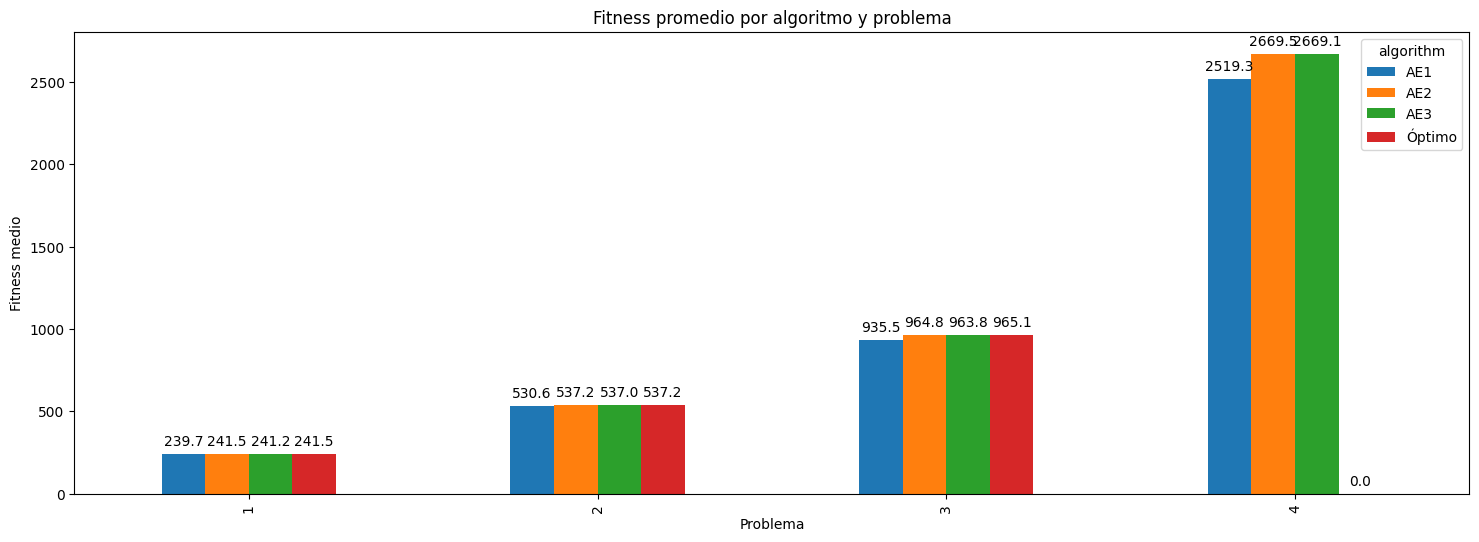

In [25]:
# Mostrar los resultados en un gráfico de barras agrupadas por problema
results_df_grouped = results_df.groupby(['problem', 'algorithm']).mean().reset_index()
results_df_grouped['mean'] = -results_df_grouped['mean']

fig, ax = plt.subplots(figsize=(18, 6))
pivot_table = results_df_grouped.pivot(index='problem', columns='algorithm', values='mean')
pivot_table.plot(kind='bar', ax=ax)

# Escribir el valor correspondiente a cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.title('Fitness promedio por algoritmo y problema')
plt.ylabel('Fitness medio')
plt.xlabel('Problema')
plt.savefig(os.path.join(results_dir, 'cbio_p9_fitness.png'))

plt.show()

El gráfico de arriba permite visualizar y comparar el valor objetivo promedio para cada algoritmo y problema. El valor objetivo se muestra con signo positivo (problema de maximización) para facilitar la interpretación visual. Vemos que con el algoritmo AE2 (reparo) se obtienen mejores resultados que con el resto. En los problemas 1 y 2 apenas hay diferencia entre los resultados de los distintos algoritmos. Los resultados del algoritmo AE1 son peores, sobretodo conforme aumenta el tamaño y la complejidad del problema (problemas 3 y especialmente 4). El algoritmo AE3 tiene resultados similares al AE2, pero ligeramente peores. En la siguiente sección comprobaremos cuáles de esas diferencias son estadísticamente significativas.

La gráfica de abajo muestra la desviación típica del resultado obtenido por cada algoritmo y problema. Vemos que la desviación típica es mayor cuanto mayor es el número de problema (por su tamaño y complejidad). Además, con el algoritmo AE2 (reparo) la desviación típica es muy pequeña, ya que en casi todos los casos converge a un valor muy cercano al óptimo, mientras que la del resto de algoritmos es mayor. El algoritmo AE3 (representación permutacional) presenta una desviación típica baja, algo mayor que AE2 en los problemas 1 a 3. Esto se debe a que el tamaño del espacio de búsqueda es mayor, pero la variabilidad del fenotipo gracias a las modificaciones del cruce y la mutación permiten la exploración, disminuyen la variabilidad y mejoran la convergencia para obtener resultados similares a AE2. Por otro lado, el algoritmo AE1 (external feasibility first) presenta una desviación típica mucho más alta, extremadamente alta para el problema 4 (de mayor dimensionalidad): sus resultados varían mucho en distintas ejecuciones. Esto se debe sobre todo a la variabilidad en la fase del algoritmo en la que maneja soluciones infactibles en las primeras generaciones, como se verá en las gráficas de evolución.

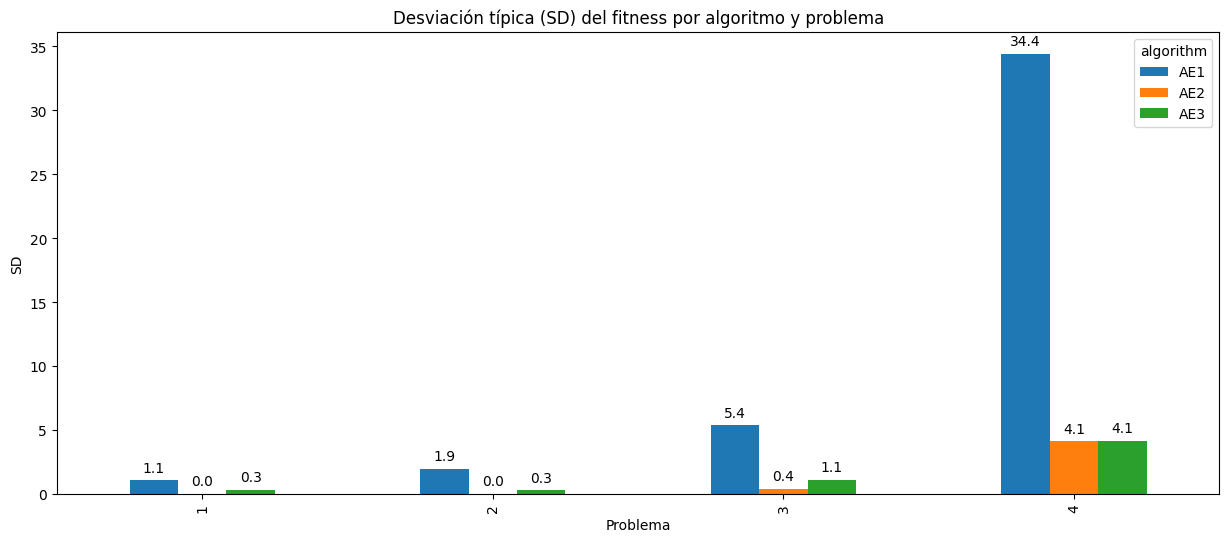

In [26]:
# Mostrar la desviación estándar en un gráfico

fig, ax = plt.subplots(figsize=(15, 6))
pivot_table = results_df_grouped[results_df_grouped['algorithm'] != 'Óptimo'].pivot(index='problem', columns='algorithm', values='std')
pivot_table.plot(kind='bar', ax=ax)

# Escribir el valor correspondiente a cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.title('Desviación típica (SD) del fitness por algoritmo y problema')
plt.ylabel('SD')
plt.xlabel('Problema')

plt.savefig(os.path.join(results_dir, 'cbio_p9_sd.png'))

plt.show()

### 5.3. Visualización de la evolución del algoritmo

A continuación, para cada problema y algoritmo, se muestra una gráfica con la evolución del mejor valor objetivo en la población (eje Y) según el número de generación (eje X). "Test $i$" indica que la gráfica corresponde al problema de test $i$. Además, para el algoritmo AE1 (external feasibility first) se muestra a la derecha una gráfica con la evolución del valor de $ \textit{maxg}\left | \sum\limits_{i=1}^n x_i - m \right |$, por lo que el valor 0 indica que la mejor solución de la generación es factible. El resto de algoritmos no consideran soluciones infactibles en su espacio de búsqueda, por tanto, no tiene sentido mostrar dicha segunda gráfica, que sería constante igual a 0.

Saved: cbio_p9_results/Evolution_AE1_1.png


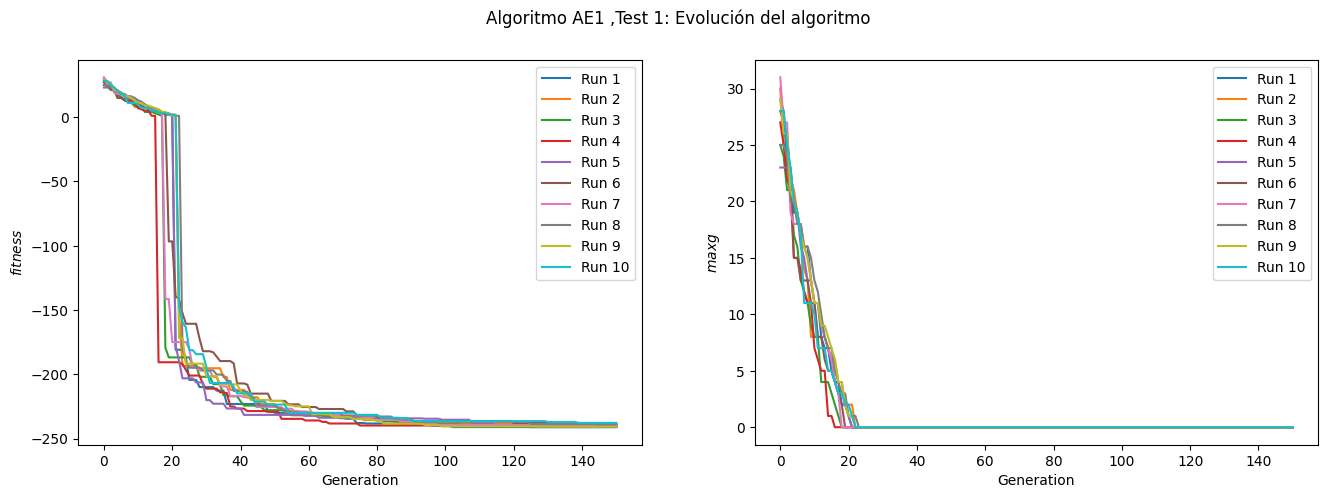

Saved: cbio_p9_results/Evolution_AE1_2.png


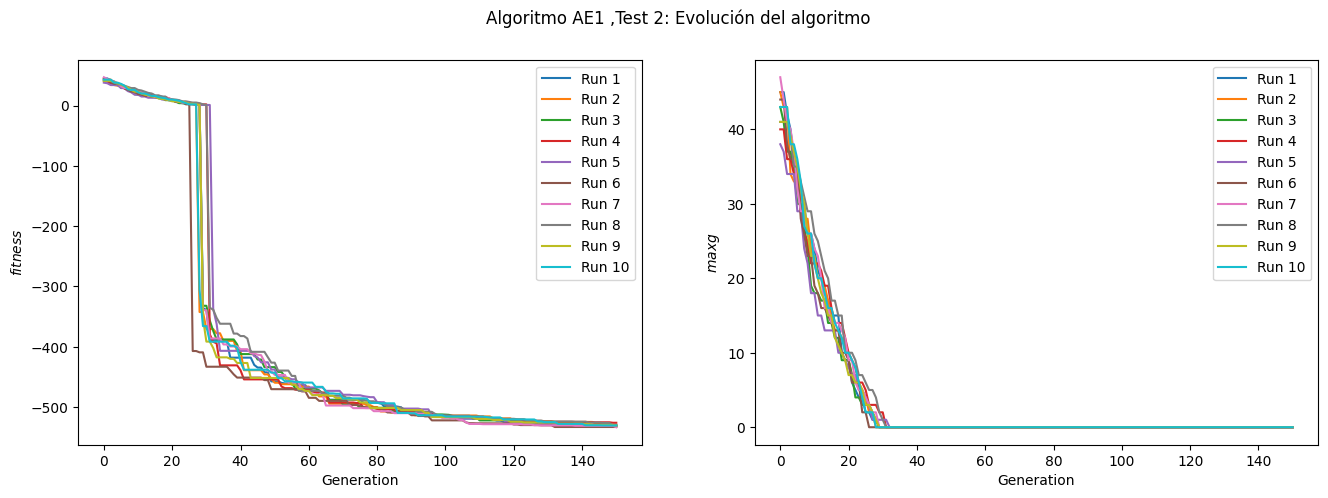

Saved: cbio_p9_results/Evolution_AE1_3.png


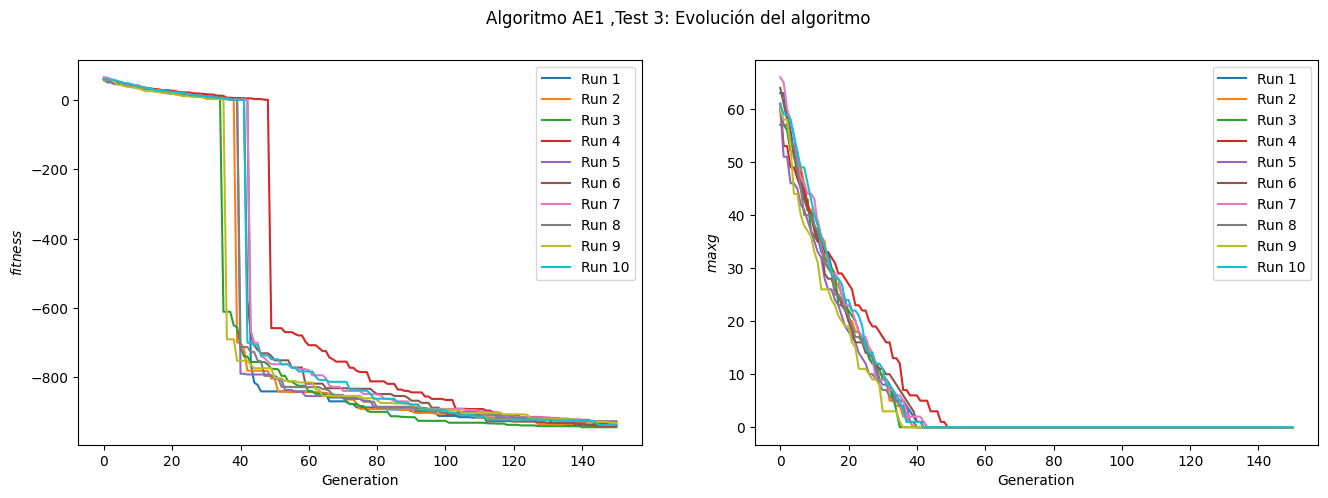

Saved: cbio_p9_results/Evolution_AE1_4.png


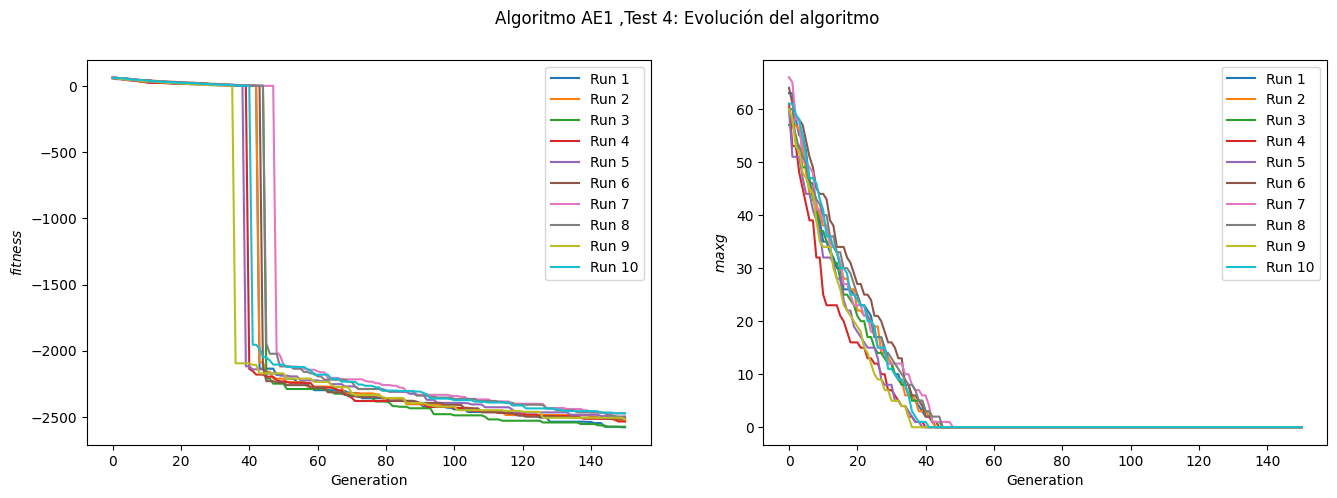

Saved: cbio_p9_results/Evolution_AE2_1.png


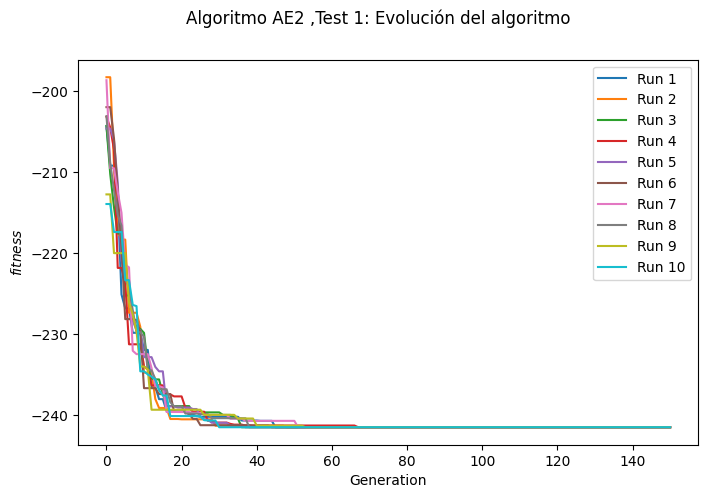

Saved: cbio_p9_results/Evolution_AE2_2.png


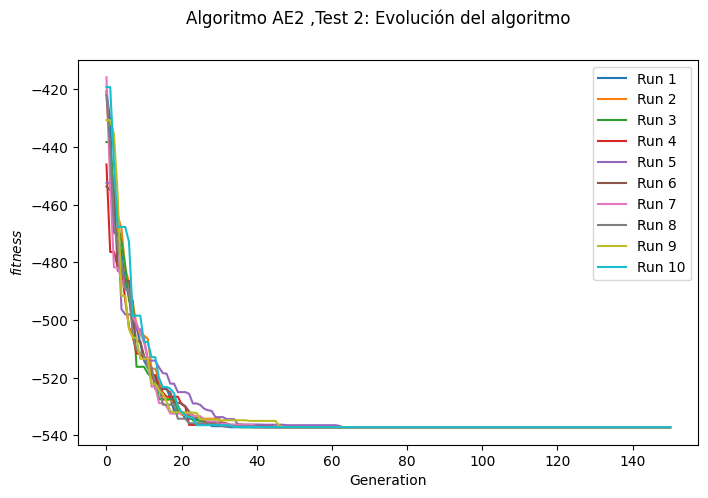

Saved: cbio_p9_results/Evolution_AE2_3.png


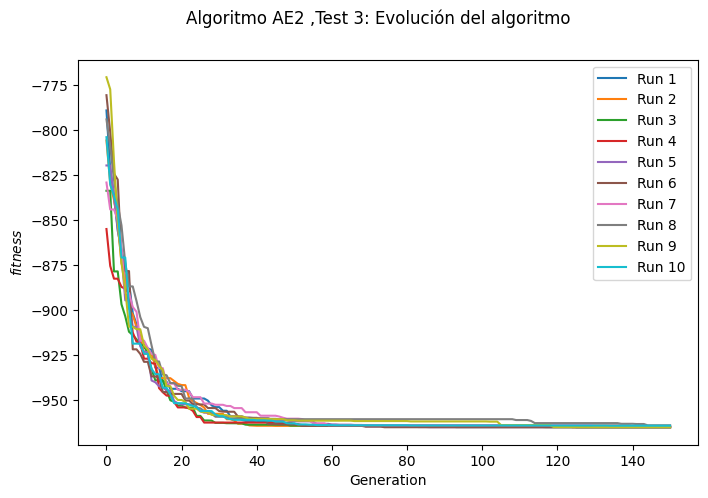

Saved: cbio_p9_results/Evolution_AE2_4.png


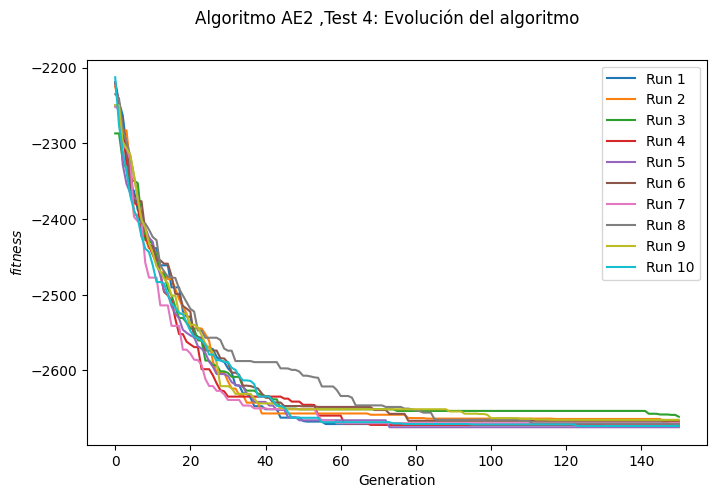

Saved: cbio_p9_results/Evolution_AE3_1.png


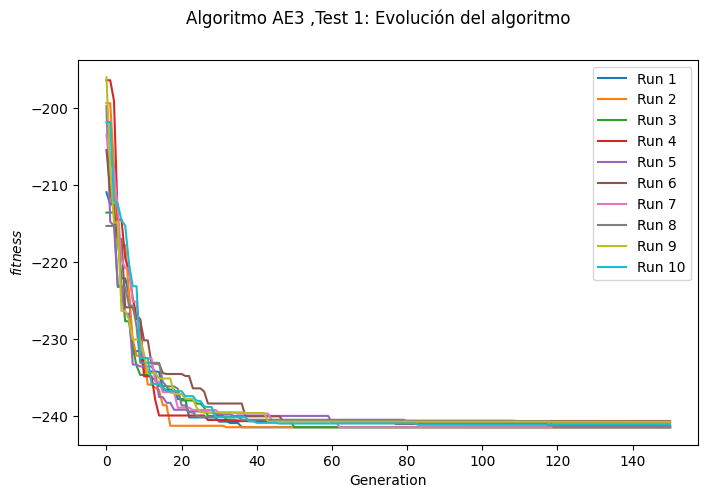

Saved: cbio_p9_results/Evolution_AE3_2.png


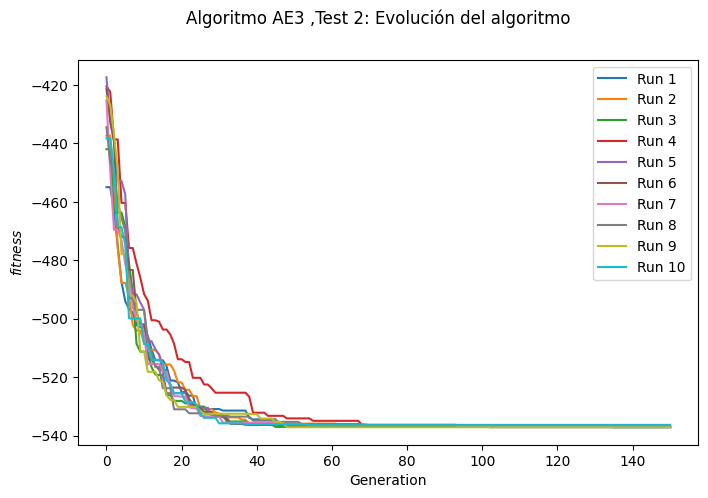

Saved: cbio_p9_results/Evolution_AE3_3.png


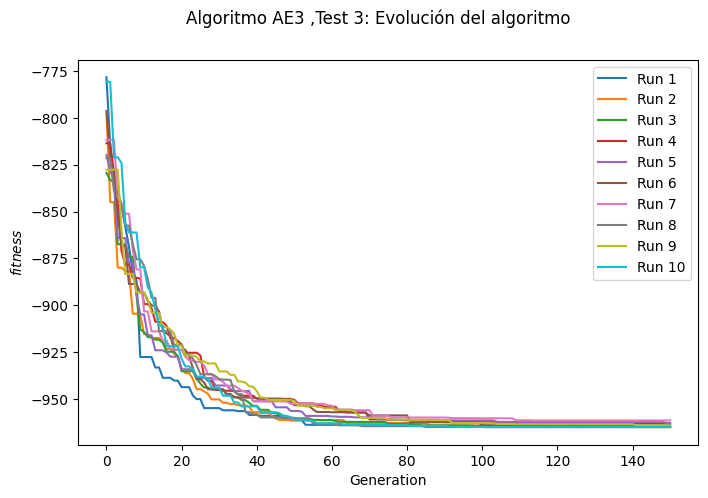

Saved: cbio_p9_results/Evolution_AE3_4.png


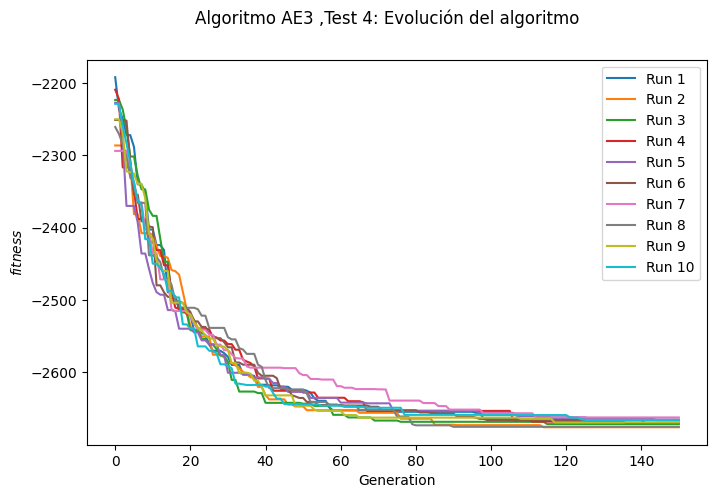

In [27]:
def VisualizaEvolucion(outputs, ylabels, title="Algorithm Evolution", file_prefix=None):
    """
    Muestra una única gráfica con todas las ejecuciones de best_outputs en distintos colores.
    
    Parámetros:
    - best_outputs: np.array de listas con la evolución del fitness en cada run.
    - ylabel: Etiqueta para el eje Y.
    - file_prefix: Prefijo del archivo si se desea guardar la figura.
    """
    
    fig, axes = plt.subplots(nrows=1, ncols = len(outputs), figsize=(8*len(outputs), 5))
    fig.suptitle(title)  # Título común para ambas gráficas
    
    if len(outputs) == 1:
        axes = [axes]
    
    for i, output in enumerate(outputs):
        for j in range(output.shape[0]):
            axes[i].plot(output[j], label=f"Run {j+1}")
            axes[i].set_xlabel("Generation")
            axes[i].set_ylabel(ylabels[i])
            axes[i].legend()
    
    plt.xlabel("Generation")
    plt.legend()
    
    if file_prefix is not None:
        file_path = f"{file_prefix}.png"
        plt.savefig(file_path)
        print(f"Saved: {file_path}")
    
    plt.show()

if not done:
    for nalgorithm, name in enumerate(algorithm_names):
        for nproblem in range(len(problems)):
            outputs = [best_outputs_f[nalgorithm, nproblem, :]]
            if nalgorithm == 0:
                outputs.append(best_outputs_g[nalgorithm, nproblem, :])
            VisualizaEvolucion(outputs, 
                               ["$fitness$", "$maxg$"], 
                               f"Algoritmo {name} ,Test {nproblem+1}: Evolución del algoritmo", 
                               os.path.join(results_dir, f"Evolution_{name}_{nproblem+1}"))  
else:
    for nalgorithm, name in enumerate(algorithm_names):
        for nproblem in range(len(problems)):
            file_path = os.path.join(results_dir, f"Evolution_{name}_{nproblem+1}.png")
            print(f"Showing: {file_path}")
            plt.figure(figsize=(15, 5))
            plt.imshow(plt.imread(file_path))            
            plt.axis('off')
            plt.show()

- **Algoritmo AE1**: Vemos que se requiere una cantidad con mucha variabilidad de generaciones para alcanzar una solución factible. Está en torno a 20 generaciones para los problemas 1 y 2 y en torno a 40 generaciones para los problemas 3 y 4. Esto hace la convergencia más lenta, obteniendo peores resultados que el resto de algoritmos, y aumenta la varianza del resultado obtenido. Además, incluso superada esta primera fase, el decrecimiento del valor objetivo es más lento que en los otros dos algoritmos. Estos fenómenos son más notables en los problemas de mayor tamaño y complejidad (3 y 4).

- **Algoritmos AE2 y AE3**: Se observa la convergencia a valores óptimos o cercanos, con cierta variabilidad, mayor en los problemas más complejos (3 y 4). En las primeras generaciones el decrecimiento es muy pronunciado. Los resultados y evolución son similares, aunque se observa ligeramente que el algoritmo AE2 presenta una convergencia más rápida, con un área bajo la gráfica ligeramente menor.


A continuación comparamos la mejor solución obtenida por cada algoritmo para los problemas 1, 2 y 3 en su mejor ejecución con la solución óptima del problema.

In [28]:
for i, (f, sol) in enumerate(solutions):
    print("PROBLEMA ", i+1)
    print("Valor objetivo: ", f)
    print("Valor obtenido: ")
    for j in range(len(algorithm_names)):
        print("\t", algorithm_names[j], np.min(best_fitness[j, i, :]))
        best_individuo_index = int(np.argmin(best_fitness[j, i, :]))
        print(best_individuos[j, i, best_individuo_index])
    print("Solución: ")
    print(sol)

PROBLEMA  1
Valor objetivo:  -241.4837093035511
Valor obtenido: 
	 AE1 -241.08339407528717
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
	 AE2 -241.4837093035511
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
	 AE3 -241.4837093035511
[20  8 75 72 97 70 34 16 99 52 59 55 47 30 87 81 15 58 11 52 70 36 84 48
 60 14 61 95 75 27 27 37 61 32 18 39 31 42 73 51 74 23 24 76 99  3 91 90
 64  4  5  6 62 19 88  1 67 44 10 17 57 83 29 26  7 66 96 80  9 71 86 50
  0 34 22 45 46 68 28 78 33 77 63 53 25  8 79 12 38 94 65 83 85 54 41 82
 40 49 56 98]
Solución: 
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 

Como hemos comentado anteriormente:

- En el problema 1, se obtiene la solución óptima con los 3 algoritmos.
- En el problema 2, se obtiene la solución óptima con los algoritmos AE2 y AE3.
- En el problema 3, solo se obtiene la solución óptima con el algoritmo AE3.

Podemos visualizar las similitudes y diferencias entre la mejor solución encontrada por cada algoritmo entre todas las ejecuciones y la solución óptima.

## 6. Test estadísticos

Utilizaremos distintas herramientas estadísticas para comparar los resultados de los 3 algoritmos sobre los 4 problemas de test.

- Calculamos el ranking wins-losses de los resultados medios. 
    
- Calculamos también el ranking wins-losses de las diferencias estadísticamente significativas obtenidas mediante el test estadístico Mann-Whitney U test (Wilconxon rank-sum test), un test estadístico no paramétrico apropiado para la comparación  de algoritmos probabilistas ejecutados múltiples veces con distintas semillas (muestras independientes).



### Definición del tipo de test (maximización o minimización)

In [29]:
def mejor(x,y):
#    return x>y # maximización
    return x<y # minimización

def peor(x,y):
#    return x<y # maximización
    return x>y # minimización

### Definición de la clase Ranking

In [30]:
class Ranking:
    def __init__(self, name):
        self.name = name # Nombre del algoritmo
        self.wins = 0 # Veces que ha ganado
        self.losses = 0 # Veces que ha perdido
    def __lt__(self,x):
        return (self.wins-self.losses) < (x.wins-x.losses)
    def __str__(self):
        return f"{self.name:<15} {self.wins:>10} {self.losses:>10} {self.wins - self.losses:>15}"

### Calcula la matriz de wins - losses de las medias a partir de los scores de un problema

In [31]:
def CalculateWinsLossesMatrixMean(scores):
    labels = scores.columns.values
    nScores = len(labels)
    WinLossMatriz = np.zeros((nScores,nScores)) 
    for i in range(nScores-1):            
        score_i = scores.iloc[:,i].values
        for j in range(i+1,nScores):
            score_j = scores.iloc[:,j].values
            if mejor(mean(score_i),mean(score_j)):
                WinLossMatriz[i,j] = 1
                WinLossMatriz[j,i] = -1
            if peor(mean(score_i),mean(score_j)):
                WinLossMatriz[i,j] = -1
                WinLossMatriz[j,i] = 1
    return WinLossMatriz

### Calcula las veces que cada algoritmo ha ganado y ha perdido a partir de la matriz de wins - losses de un problema

In [32]:
def CalculateWinsLossesAmount(WinsLossesMatriz,labels):
    nScores = len(labels)
    WinsLossesAmount = [Ranking(scoreName) for scoreName in labels]
    for i in range(nScores-1):            
        for j in range(i+1,nScores):
            if WinsLossesMatriz[i,j]==1:            
                WinsLossesAmount[i].wins += 1
                WinsLossesAmount[j].losses += 1
            if WinsLossesMatriz[i,j]==-1:            
                WinsLossesAmount[j].wins += 1
                WinsLossesAmount[i].losses += 1
    return WinsLossesAmount

### Acumula las cantidades de wins - losses de un problema

In [33]:
def AddWinsLossesAmount(WinsLossesTotalAmount,WinsLossesAmount):
    for i in range(len(WinsLossesAmount)):
        WinsLossesTotalAmount[i].wins += WinsLossesAmount[i].wins
        WinsLossesTotalAmount[i].losses += WinsLossesAmount[i].losses

### Calcula la matriz de wins - losses de las diferencias estadísticamente significativas para un test estadistico dado, junto con la matriz de p-values, a partir de los scores de un problema

In [34]:
def CalculateWinsLossesMatrixStat(scores,stat):
    labels = scores.columns.values
    nScores = len(labels)
    WinLossMatriz = np.zeros((nScores,nScores)) 
    pValues = np.zeros((nScores,nScores)) 
    for i in range(nScores-1):            
        score_i = scores.iloc[:,i].values
        for j in range(i+1,nScores):
            score_j = scores.iloc[:,j].values
            if not all(x_i == y_i for x_i, y_i in zip(score_i, score_j)): # si son datos diferentes
                _, p_value = stat(score_i, score_j)  
                pValues[i,j] = p_value
                pValues[j,i] = p_value                
                if p_value<0.05:
                    if mejor(mean(score_i),mean(score_j)):
                        WinLossMatriz[i,j] = 1
                        WinLossMatriz[j,i] = -1                        
                    if peor(mean(score_i),mean(score_j)):
                        WinLossMatriz[i,j] = -1
                        WinLossMatriz[j,i] = 1                        
    return WinLossMatriz,pValues

### Impresión de la matriz wins - losses

In [35]:
def PrintMatriz(WinLossMatriz,labels):
    print("win: El algoritmo en la columna gana al algoritmo de la fila")
    print("loss: El algoritmo en la columna pierde frente al algoritmo de la fila")
    print("tie: El algoritmo en la columna empata con al algoritmo de la fila")
    n = len(labels)
    col_width = 10  # Ancho fijo para cada columna
    # Imprimir encabezados de columna
    print(" " * col_width, end="")
    for j in range(n):
        print(f"{labels[j]:>{col_width}}", end="")
    print()
    for i in range(n):
        print(f"{labels[i]:<{col_width}}", end="")
        for j in range(n):
            if i == j:
                print(f"{'-':>{col_width}}", end="")
            elif WinLossMatriz[j,i] == 1:
                print(f"{'win':>{col_width}}", end="")
            elif WinLossMatriz[j,i] == -1:
                print(f"{'loss':>{col_width}}", end="")
            else:
                print(f"{'tie':>{col_width}}", end="")
        print()

### Impresión  del ranking wins - losses

In [36]:
def PrintRanking(WinLoss):
    Ranking = sorted(WinLoss, reverse=True)    
    print(f"{'Ranking':<15} {'Wins':>10} {'Losses':>10} {'Wins-Losses':>15}")
    for r in Ranking:
        print(r)

### Impresión de la matriz de p-values

In [37]:
def PrintPValuesMatriz(pValues, labels):
    n = len(labels)
    col_width = 15  # Ancho fijo para cada columna, ajusta según sea necesario
    print("p-values")
    # Imprimir encabezados de columna
    print(" " * col_width, end="")
    for j in range(n):
        print(f"{labels[j]:>{col_width}}", end="")
    print()

    # Imprimir filas con datos
    for i in range(n):
        print(f"{labels[i]:<{col_width}}", end="")
        for j in range(n):
            if i == j:
                print(f"{'-':>{col_width}}", end="")
            else:
                print(f"{pValues[i,j]:>{col_width}.8f}", end="")
        print()

### Realización de los test estadísticos e impresión de resultados

A continuación se muestran los resultados de los tests estadísticos anteriormente mencionados para cada problema.

In [ ]:
#fileName = ["lymphoma_11classes-results","micro-mass-results","GCM-results"] # todas deben tener las mismas cabeceras de algoritmos
# En este ejemplo son sklearn.ensemble.RandomForestClassifier, sklearn.svm.SVC y sklearn.neural_network.MLPClassifier 

#scores = pd.read_csv(fileName[0]+".csv") # Se coje el primero de ellos para crear los objetos de la clase Ranking

labels = algorithm_names 


WinsLossesTotalAmountMean = [Ranking(scoreName) for scoreName in algorithm_names]
WinsLossesTotalAmountRanksum = [Ranking(scoreName) for scoreName in algorithm_names]

for i in range(len(problems)):

    print(f"TESTS ESTADÍSTICOS PROBLEMA {i+1}\n")
    
    scores = pd.DataFrame(columns=algorithm_names, data=np.array([best_fitness[nalgorithm, i, :] for nalgorithm in range(len(algorithm_names))]).T)

    print("Resultados medios")
    print(scores.mean())
    print('\n')
    
    # WINS-LOSSES DE MEDIAS
    # Matriz de dos dimensiones con valores -1, 0, 1 para comparar los algoritmos en cada problema
    WinsLossesMatrizMean = CalculateWinsLossesMatrixMean(scores) 
    # Lista con los objetos Ranking de cada algoritmo 
    WinsLossesAmountMean = CalculateWinsLossesAmount(WinsLossesMatrizMean,labels)
    # Acumula los wins-loss de los algoritmos en todos los problemas
    AddWinsLossesAmount(WinsLossesTotalAmountMean,WinsLossesAmountMean)
    print("Mean")
    PrintMatriz(WinsLossesMatrizMean,labels)
    PrintRanking(WinsLossesAmountMean)
    print('\n')
  
    # WINS-LOSSES Y P-VALUES DE RANK-SUM
    # Matriz de dos dimensiones con valores -1, 0, 1 para comparar los algoritmos en cada problema
    # y matriz de dos dimensiones para los p-values
    WinsLossesMatrizRanksum, pValuesRanksum = CalculateWinsLossesMatrixStat(scores,mannwhitneyu)
    # Lista con los objetos Ranking de cada algoritmo 
    WinsLossesAmountRanksum = CalculateWinsLossesAmount(WinsLossesMatrizRanksum,labels)
    # Acumula los wins-loss de los algoritmos en todos los problemas
    AddWinsLossesAmount(WinsLossesTotalAmountRanksum,WinsLossesAmountRanksum)
    print("Ranksum")    
    PrintMatriz(WinsLossesMatrizRanksum,labels)
    PrintPValuesMatriz(pValuesRanksum, labels)    
    PrintRanking(WinsLossesAmountRanksum)
    print('')
    print('-'*80)
    print('')
        
print("Total Mean")
PrintRanking(WinsLossesTotalAmountMean)
print('\n')

print("Total Ranksum")
PrintRanking(WinsLossesTotalAmountRanksum)
print('\n')

TESTS ESTADÍSTICOS PROBLEMA 1

Resultados medios
AE1   -239.699630
AE2   -241.483709
AE3   -241.219775
dtype: float64


Mean
win: El algoritmo en la columna gana al algoritmo de la fila
loss: El algoritmo en la columna pierde frente al algoritmo de la fila
tie: El algoritmo en la columna empata con al algoritmo de la fila
                 AE1       AE2       AE3
AE1                -       win       win
AE2             loss         -      loss
AE3             loss       win         -
Ranking               Wins     Losses     Wins-Losses
AE2                      2          0               2
AE3                      1          1               0
AE1                      0          2              -2


Ranksum
win: El algoritmo en la columna gana al algoritmo de la fila
loss: El algoritmo en la columna pierde frente al algoritmo de la fila
tie: El algoritmo en la columna empata con al algoritmo de la fila
                 AE1       AE2       AE3
AE1                -       win       win
AE2  

De acuerdo con los resultados mostrados en la celda anterior: 

- Problemas 1, 2 y 3: 
  
  - Según la media de los resultados los algoritmos de mejor a peor son AE2, AE3, AE1. 
  - Según el test de Wilkoxon rank-sum, el ranking es el mismo, y las diferencias entre los resultados son estadísticamente significativas.

- Problema 4: 

  - Según la media de los resultados, los algoritmos de mejor a peor son AE2, AE3, AE1.
  - Según el test de Wilkoxon rank-sum, hay un empate etre AE2 y AE3 (las diferencias entre resultados no son estadísticamente significativas), y AE1 es peor.
  
- Total:
  - Según el ranking total de medias y de ranksum, los algoritmos de mejor a peor son AE2, AE3, AE1.
  

## 7. Conclusiones

Hemos implementado y comparado 3 algoritmos evolutivos para resolver el problema de la máxima diversidad, un problema de optimización con restricciones, con 4 problemas de test de distinto tamaño y complejidad. Los algoritmos manejan las restricciones con métodos distintos. 

El algoritmo evolutivo AE2 (reparo) presenta resultados significativamente mejores y mejor convergencia en el problema de la máxima diversidad respecto a AE1 (external feasibility first), y respecto a AE3 (representación permutacional) salvo en el problema 4, más complejo, en el que no hay una diferencia estadísticamente significativa entre AE3 y AE2.

El reparo de soluciones (AE2) limita el espacio de búsqueda, acelerando la convergencia. Concluimos que es la estrategia más adecuada. La representación permutacional con cruce y mutación modificados (AE3) también mejora los resultados y la convergencia, con resultados casi igual de buenos, aunque la convergencia de AE2 es más rápida, como hemos visto en la evolución de las ejecuciones. External feasibility first (AE1) tiene el hándicap de tener infactibles en la población, y tiene peores resultados.


## Contribución de cada miembro del grupo

- Santiago Méndez García:
  - Análisis del problema y la solución para K=1. Implementación de los problemas de test y solución para K=1.
  - Implementación del algoritmo AE3.
  - Documentación de los algoritmos.
  - Gráficas de resultados.
  - Ejecución de notebooks en el clúster atlas (versión no definitiva) y en un entorno local (versión definitiva con AE3 mejorado).
  - Análisis y documentación de resultados.
  - Presentación oral.
 
- Domingo Méndez García: 
  - Implementación de los algoritmos AE1 y AE2.
  - Implementación del grid search.
  - Pruebas preliminares. Implementación del guardado y recuperación de resultados.
  - Implementación y documentación de tests estadísticos.
  - Análisis y documentación de resultados.